In [ ]:
from google.colab import drive
drive.mount("/content/myDrive")

Mounted at /content/myDrive


### GPU 설정

In [1]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
use_cuda = torch.cuda.is_available()
print(use_cuda)
if use_cuda:
  print(torch.cuda.get_device_name(0))

cuda:0
True
Tesla T4


### 필요 라이브러리 설치

In [2]:
!pip install scrapbook
!pip install recommenders
#-- https://github.com/microsoft/recommenders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.0 MB/s eta 0:00:00
ERROR: Ignored the following versions that require a different python version: 0.6.0 Requires-Python >=3.6, <=3.8; 0.7.0 Requires-Python >=3.6, <3.8; 1.0.0 Requires-Python >=3.6, <3.9; 1.1.0 Requires-Python >=3.6, <3.10; 1.1.1 Requires-Python >=3.6, <3.10
ERROR: Could not find a version that satisfies the requirement recommenders (from versions: none)
ERROR: No matching distribution found for recommenders


In [3]:
# Install required packages.
# !pip install torch-sparse
print(torch.__version__)
print(torch.version.cuda)

!pip install torch-geometric
!pip install -q git+https://github.com/snap-stanford/deepsnap.git
"""
DeepSNAP는 그래프 신경망(Graph Neural Networks)을 구축하고 훈련하기 위한 파이썬 패키지
DeepSNAP은 PyTorch 기반의 그래프 신경망 라이브러리 PyG(PyTorch Geometric)에서 영감을 받아 개발되었다. DeepSNAP은 PyG와 유사한 인터페이스를 제공하여 그래프 데이터를 로드하고 전처리할 수 있다.
"""
!pip install -U -q PyDrive
!pip install torch_scatter -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cu118.html

2.0.1+cu118
11.8
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 37.3 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 22.7 MB/s eta 0:00:00


In [4]:
!pip install LibRecommender
#-- https://github.com/massquantity/LibRecommender#references 라이브러리

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 22.5 MB/s eta 0:00:00


### 필요 라이브러리 IMPORT

In [5]:
import numpy as np
import pandas as pd
from libreco.data import random_split, DatasetPure
from libreco.algorithms import LightGCN  # pure data, algorithm NGCF
from libreco.evaluation import evaluate
#-- Libreco

import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch import nn, optim, Tensor
from torch_sparse import SparseTensor, matmul
from torch_geometric.utils import structured_negative_sampling
from torch_geometric.data import download_url, extract_zip
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.typing import Adj
#-- import required modules Blog

Instructions for updating:
non-resource variables are not supported in the long term


## 데이터 준비 movielens 10만개 데이터

In [6]:
# download the dataset
url = 'https://files.grouplens.org/datasets/movielens/ml-latest-small.zip'
extract_zip(download_url(url, '.'), '.')

rating_path = '/content/ml-latest-small/ratings.csv'
item_path = "/content/ml-latest-small/movies.csv"

Extracting ./ml-latest-small.zip


In [36]:
def libco_LightGCN_data(path, data_frame, ratio = [0.8, 0.1, 0.1], excluded_user=None):
  #-- data
  data = pd.read_csv(path)
  data.rename(columns = {data_frame[0] : "user", data_frame[1]:"item", data_frame[2]:"label",},
              inplace = True)

  # print(data.head(10))
  #-- 테스트를 위한 특정 유저의 가장 앞에 있는 데이터 n개 삭제
  if excluded_user is not None:
    user_data = data[data["user"] == excluded_user]
    user_data_5stars = user_data[user_data["label"] == 5.0]  # Filter the data with a rating of 5.0
    if not user_data_5stars.empty:
      excluded_number = 10
      user_data_5stars = user_data_5stars.head(excluded_number)
      data = data.drop(user_data_5stars.index)

  # print(data.head(10))

  # split whole data into three folds for training, evaluating and testing
  train_data, eval_data, test_data = random_split(data, multi_ratios= ratio)

  train_data, data_info = DatasetPure.build_trainset(train_data)
  eval_data = DatasetPure.build_evalset(eval_data)
  test_data = DatasetPure.build_testset(test_data)
  tet_data = [train_data, eval_data, test_data]
  print(data_info)  # n_users: 5894, n_items: 3253, data sparsity: 0.4172 %
  return tet_data, data_info
  #-- Libco --

def blog_LightGCN_data(path, data_frame, rating_threshold =4, excluded_user=None):

  #-- 유저, 아이템 매핑
  rating_data = pd.read_csv(path[0], index_col= data_frame[0])
  item_data = pd.read_csv(path[1], index_col= data_frame[1])
  data = pd.read_csv(path[0])

  print("1번째 데이터 삭제하기 전")
  print(rating_data.head(10))

  #-- 테스트를 위한 특정 유저의 가장 앞에 있는 데이터 삭제

  if excluded_user is not None:
    user_data = data[data[data_frame[0]] == excluded_user]
    user_data_5stars = user_data[user_data[data_frame[2]] == 5.0]  # Filter the data with a rating of 5.0r_user_data[r_user_data[data_frame[2]] == 5.0]  # Filter the data with a rating of 5.0

    r_user_data =  rating_data[rating_data.index == excluded_user].reset_index()

    if not user_data_5stars.empty:
      excluded_number = 10
      user_data_5stars = user_data_5stars.head(excluded_number)
      r_user_data_5stars = r_user_data[r_user_data[data_frame[2]] == 5.0]
      data = data.drop(user_data_5stars.index)

      row_index = []
      for i in range(0,excluded_number):
        row_index.append(r_user_data_5stars.iloc[i].name)

      rating_data = rating_data.reset_index().drop(row_index[0])
      rating_data.set_index(data_frame[0], inplace=True)
      for i in range(1, len(row_index)) :
        rating_data = rating_data.reset_index().drop(row_index[i]-i)
      # rating_data = rating_data.drop(rating_data.iloc.nam)
        rating_data.set_index(data_frame[0], inplace=True)

  print("\n\n\n1번째 데이터 삭제하기 후")
  print(rating_data.head(10))

  # # rating_data의 컬럼 확인
  # print(rating_data.head(5))

  user_mapping = {index: i for i, index in enumerate(rating_data.index.unique())}
  item_mapping = {index: i for i, index in enumerate(item_data.index.unique())}

  #-- 매핑 데이터로 edge연결
  edge_index = None
  src = [user_mapping[index] for index in data[data_frame[0]]]
  dst = [item_mapping[index] for index in data[data_frame[1]]]
  edge_attr = torch.from_numpy(data[data_frame[2]].values).view(-1, 1).to(torch.long) >= rating_threshold

  edge_index = [[], []]
  for i in range(edge_attr.shape[0]):
    if edge_attr[i]:
        edge_index[0].append(src[i])
        edge_index[1].append(dst[i])
  edge_index = torch.tensor(edge_index)

  #-- 데이터 분할 8:1:1
  num_users, num_movies = len(user_mapping), len(item_mapping)
  num_interactions = edge_index.shape[1]
  all_indices = [i for i in range(num_interactions)]

  train_indices, test_indices = train_test_split(
      all_indices, test_size=0.2, random_state=1)
  val_indices, test_indices = train_test_split(
      test_indices, test_size=0.5, random_state=1)

  train_edge_index = edge_index[:, train_indices]
  val_edge_index = edge_index[:, val_indices]
  test_edge_index = edge_index[:, test_indices]

  print("Train Edge Data : ", train_edge_index.shape)
  print("Val Edge Data :", val_edge_index.shape)
  print("Test Edge Data : ", test_edge_index.shape)

  #-- 연결된 엣지를 희소행렬로 변환
  # convert edge indices into Sparse Tensors: https://pytorch-geometric.readthedocs.io/en/latest/notes/sparse_tensor.html
  from torch_geometric.utils import train_test_split_edges

  train_sparse_edge_index = SparseTensor(row=train_edge_index[0], col=train_edge_index[1], sparse_sizes=(
      num_users + num_movies, num_users + num_movies))
  val_sparse_edge_index = SparseTensor(row=val_edge_index[0], col=val_edge_index[1], sparse_sizes=(
      num_users + num_movies, num_users + num_movies))
  test_sparse_edge_index = SparseTensor(row=test_edge_index[0], col=test_edge_index[1], sparse_sizes=(
      num_users + num_movies, num_users + num_movies))

  tet_edge_data = [edge_index, train_edge_index,val_edge_index, test_edge_index]
  tet_sparse_data = [train_sparse_edge_index, val_sparse_edge_index, test_sparse_edge_index]
  return tet_edge_data, tet_sparse_data, user_mapping, item_mapping
#-- Blog --

In [8]:
excluded_user_id = 1
data_frame = ["userId", "movieId", "rating"]
path = [rating_path, item_path]

lib_tet_data, lib_data_info = libco_LightGCN_data(path[0], data_frame, excluded_user = excluded_user_id)
blog_tet_edge_data, blog_tet_sparse_data, user_mapping, item_mapping = blog_LightGCN_data(path, data_frame, 4, excluded_user_id)

n_users: 610, n_items: 8981, data density: 1.4723 %
1번째 데이터 삭제하기 전
        movieId  rating  timestamp
userId                            
1             1     4.0  964982703
1             3     4.0  964981247
1             6     4.0  964982224
1            47     5.0  964983815
1            50     5.0  964982931
1            70     3.0  964982400
1           101     5.0  964980868
1           110     4.0  964982176
1           151     5.0  964984041
1           157     5.0  964984100



1번째 데이터 삭제하기 후
        movieId  rating  timestamp
userId                            
1             1     4.0  964982703
1             3     4.0  964981247
1             6     4.0  964982224
1            70     3.0  964982400
1           110     4.0  964982176
1           223     3.0  964980985
1           235     4.0  964980908
1           296     3.0  964982967
1           316     3.0  964982310
1           349     4.0  964982563
Train Edge Data :  torch.Size([2, 38856])
Val Edge Data : torch.Size([2, 48

## 모델 정의

In [21]:
def libco_LightGCN(data_info, embed_size =32, n_epochs = 20):
  lightgcn = LightGCN(
      task="ranking",
      data_info= data_info,
      loss_type="bpr",
      embed_size= embed_size,
      n_epochs=n_epochs,
      lr=1e-3,
      batch_size=2048,
      num_neg=1,
      device="cuda",
  )
  return lightgcn
#-- Libco --#

class Blog_LightGCN(MessagePassing):
      def __init__(self, num_users, num_items, embedding_dim=64, K=3, add_self_loops=False):
          super().__init__()
          self.num_users, self.num_items = num_users, num_items
          self.embedding_dim, self.K = embedding_dim, K
          self.add_self_loops = add_self_loops
          self.users_emb = nn.Embedding(
              num_embeddings=self.num_users, embedding_dim=self.embedding_dim) # e_u^0
          self.items_emb = nn.Embedding(
              num_embeddings=self.num_items, embedding_dim=self.embedding_dim) # e_i^0
          nn.init.normal_(self.users_emb.weight, std=0.1)
          nn.init.normal_(self.items_emb.weight, std=0.1)
      def forward(self, edge_index: SparseTensor):
          # compute \tilde{A}: symmetrically normalized adjacency matrix
          edge_index_norm = gcn_norm(
              edge_index, add_self_loops=self.add_self_loops)
          emb_0 = torch.cat([self.users_emb.weight, self.items_emb.weight]) # E^0
          embs = [emb_0]
          emb_k = emb_0

          # multi-scale diffusion
          for i in range(self.K):
              emb_k = self.propagate(edge_index_norm, x=emb_k)
              embs.append(emb_k)
          embs = torch.stack(embs, dim=1)
          emb_final = torch.mean(embs, dim=1) # E^K
          users_emb_final, items_emb_final = torch.split(
              emb_final, [self.num_users, self.num_items]) # splits into e_u^K and e_i^K
          # returns e_u^K, e_u^0, e_i^K, e_i^0
          return users_emb_final, self.users_emb.weight, items_emb_final, self.items_emb.weight

      def message(self, x_j: Tensor) -> Tensor:
          return x_j

      def message_and_aggregate(self, adj_t: SparseTensor, x: Tensor) -> Tensor:
          # computes \tilde{A} @ x
          return matmul(adj_t, x)

#-- 손실함수 bpr
def bpr_loss(users_emb_final, users_emb_0, pos_items_emb_final, pos_items_emb_0, neg_items_emb_final, neg_items_emb_0, lambda_val):
    reg_loss = lambda_val * (users_emb_0.norm(2).pow(2) +
                             pos_items_emb_0.norm(2).pow(2) +
                             neg_items_emb_0.norm(2).pow(2)) # L2 loss

    pos_scores = torch.mul(users_emb_final, pos_items_emb_final)
    pos_scores = torch.sum(pos_scores, dim=-1) # predicted scores of positive samples
    neg_scores = torch.mul(users_emb_final, neg_items_emb_final)
    neg_scores = torch.sum(neg_scores, dim=-1) # predicted scores of negative samples

    loss = -torch.mean(torch.nn.functional.softplus(pos_scores - neg_scores)) + reg_loss
    return loss

def blog_LightGCN(num_users, num_movies, embed_size):
  # defines LightGCN model
  model = Blog_LightGCN(num_users, num_movies, embedding_dim = embed_size)
  return model

#-- Blog --#

In [11]:
lib_model = libco_LightGCN(lib_data_info, embed_size =32, n_epochs = 20)
blog_model = blog_LightGCN(len(user_mapping), len(item_mapping), embed_size= 32)

### 모델 학습

In [23]:
def libco_fit(model, train_data, eval_data):
  model.fit(
        train_data,
        neg_sampling=True,
        verbose=1,
        eval_data=eval_data,
        metrics=["loss", "roc_auc", "precision", "recall", "ndcg"],
    )
#-- Libco--#


# function which random samples a mini-batch of positive and negative samples
def sample_mini_batch(batch_size, edge_index):
    edges = structured_negative_sampling(edge_index)
    edges = torch.stack(edges, dim=0)
    indices = random.choices(
        [i for i in range(edges[0].shape[0])], k=batch_size)
    batch = edges[:, indices]
    user_indices, pos_item_indices, neg_item_indices = batch[0], batch[1], batch[2]
    return user_indices, pos_item_indices, neg_item_indices

# helper function to get N_u
def get_user_positive_items(edge_index):
    user_pos_items = {}
    for i in range(edge_index.shape[1]):
        user = edge_index[0][i].item()
        item = edge_index[1][i].item()
        if user not in user_pos_items:
            user_pos_items[user] = []
        user_pos_items[user].append(item)
    return user_pos_items

# computes recall@K and precision@K
def RecallPrecision_ATk(groundTruth, r, k):
    num_correct_pred = torch.sum(r, dim=-1)  # number of correctly predicted items per user
    # number of items liked by each user in the test set
    user_num_liked = torch.Tensor([len(groundTruth[i])
                                  for i in range(len(groundTruth))])
    recall = torch.mean(num_correct_pred / user_num_liked)
    precision = torch.mean(num_correct_pred) / k
    return recall.item(), precision.item()

# computes NDCG@K
def NDCGatK_r(groundTruth, r, k):
    assert len(r) == len(groundTruth)

    test_matrix = torch.zeros((len(r), k))

    for i, items in enumerate(groundTruth):
        length = min(len(items), k)
        test_matrix[i, :length] = 1
    max_r = test_matrix
    idcg = torch.sum(max_r * 1. / torch.log2(torch.arange(2, k + 2)), axis=1)
    dcg = r * (1. / torch.log2(torch.arange(2, k + 2)))
    dcg = torch.sum(dcg, axis=1)
    idcg[idcg == 0.] = 1.
    ndcg = dcg / idcg
    ndcg[torch.isnan(ndcg)] = 0.
    return torch.mean(ndcg).item()

# wrapper function to get evaluation metrics
def get_metrics(model, edge_index, exclude_edge_indices, k):
    user_embedding = model.users_emb.weight
    item_embedding = model.items_emb.weight

    # get ratings between every user and item - shape is num users x num movies
    rating = torch.matmul(user_embedding, item_embedding.T)

    for exclude_edge_index in exclude_edge_indices:
        # gets all the positive items for each user from the edge index
        user_pos_items = get_user_positive_items(exclude_edge_index)
        # get coordinates of all edges to exclude
        exclude_users = []
        exclude_items = []
        for user, items in user_pos_items.items():
            exclude_users.extend([user] * len(items))
            exclude_items.extend(items)

        # set ratings of excluded edges to large negative value
        rating[exclude_users, exclude_items] = -(1 << 10)

    # get the top k recommended items for each user
    _, top_K_items = torch.topk(rating, k=k)

    # get all unique users in evaluated split
    users = edge_index[0].unique()

    test_user_pos_items = get_user_positive_items(edge_index)

    # convert test user pos items dictionary into a list
    test_user_pos_items_list = [
        test_user_pos_items[user.item()] for user in users]

    # determine the correctness of topk predictions
    r = []
    for user in users:
        ground_truth_items = test_user_pos_items[user.item()]
        label = list(map(lambda x: x in ground_truth_items, top_K_items[user]))
        r.append(label)
    r = torch.Tensor(np.array(r).astype('float'))

    recall, precision = RecallPrecision_ATk(test_user_pos_items_list, r, k)
    ndcg = NDCGatK_r(test_user_pos_items_list, r, k)

    return recall, precision, ndcg
# wrapper function to evaluate model
def evaluation(model, edge_index, sparse_edge_index, exclude_edge_indices, k, lambda_val):
    # get embeddings
    users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(
        sparse_edge_index)
    edges = structured_negative_sampling(
        edge_index, contains_neg_self_loops=False)
    user_indices, pos_item_indices, neg_item_indices = edges[0], edges[1], edges[2]
    users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]
    pos_items_emb_final, pos_items_emb_0 = items_emb_final[
        pos_item_indices], items_emb_0[pos_item_indices]
    neg_items_emb_final, neg_items_emb_0 = items_emb_final[
        neg_item_indices], items_emb_0[neg_item_indices]

    loss = bpr_loss(users_emb_final, users_emb_0, pos_items_emb_final, pos_items_emb_0,
                    neg_items_emb_final, neg_items_emb_0, lambda_val).item()

    recall, precision, ndcg = get_metrics(
        model, edge_index, exclude_edge_indices, k)

    return loss, recall, precision, ndcg
def blog_fit(model, blog_tet_edge_data, blog_tet_sparse_data, epochs = 50):
  # define contants
  ITERATIONS = epochs
  BATCH_SIZE = 2048
  LR = 1e-3
  ITERS_PER_EVAL = 300
  ITERS_PER_LR_DECAY = 300
  K = 10
  LAMBDA = 1e-6

  model = model.to(device)
  model.train()

  optimizer = optim.Adam(model.parameters(), lr=LR)
  scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

  edge_index = blog_tet_edge_data[0].to(device)
  train_edge_index = blog_tet_edge_data[1].to(device)
  train_sparse_edge_index = blog_tet_sparse_data[0].to(device)

  val_edge_index = blog_tet_edge_data[2].to(device)
  val_sparse_edge_index = blog_tet_sparse_data[1].to(device)

  # training loop
  train_losses = []
  val_losses = []

  for iter in range(ITERATIONS):
      # forward propagation
      users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(
          train_sparse_edge_index)

      # mini batching
      user_indices, pos_item_indices, neg_item_indices = sample_mini_batch(
          BATCH_SIZE, train_edge_index)
      user_indices, pos_item_indices, neg_item_indices = user_indices.to(
          device), pos_item_indices.to(device), neg_item_indices.to(device)
      users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]
      pos_items_emb_final, pos_items_emb_0 = items_emb_final[
          pos_item_indices], items_emb_0[pos_item_indices]
      neg_items_emb_final, neg_items_emb_0 = items_emb_final[
          neg_item_indices], items_emb_0[neg_item_indices]

      # loss computation
      train_loss = bpr_loss(users_emb_final, users_emb_0, pos_items_emb_final,
                            pos_items_emb_0, neg_items_emb_final, neg_items_emb_0, LAMBDA)

      optimizer.zero_grad()
      train_loss.backward()
      optimizer.step()

      if iter % ITERS_PER_EVAL == 0:
          model.eval()
          val_loss, recall, precision, ndcg = evaluation(
              model, val_edge_index, val_sparse_edge_index, [train_edge_index], K, LAMBDA)
          print(f"[Iteration {iter}/{ITERATIONS}] train_loss: {round(train_loss.item(), 5)}, val_loss: {round(val_loss, 5)}, val_recall@{K}: {round(recall, 5)}, val_precision@{K}: {round(precision, 5)}, val_ndcg@{K}: {round(ndcg, 5)}")
          train_losses.append(train_loss.item())
          val_losses.append(val_loss)
          model.train()

      if iter % ITERS_PER_LR_DECAY == 0 and iter != 0:
          scheduler.step()
  iters = [iter * ITERS_PER_EVAL for iter in range(len(train_losses))]
  plt.plot(iters, train_losses, label='train')
  plt.plot(iters, val_losses, label='validation')
  plt.xlabel('iteration')
  plt.ylabel('loss')
  plt.title('training and validation loss curves')
  plt.legend()
  plt.show()

Training start time: 2023-10-18 04:25:56


train: 100%|██████████| 40/40 [00:00<00:00, 62.99it/s]


Epoch 1 elapsed: 0.641s


train: 100%|██████████| 40/40 [00:00<00:00, 107.14it/s]


Epoch 2 elapsed: 0.379s


train: 100%|██████████| 40/40 [00:00<00:00, 109.04it/s]


Epoch 3 elapsed: 0.377s


train: 100%|██████████| 40/40 [00:00<00:00, 111.92it/s]


Epoch 4 elapsed: 0.363s


train: 100%|██████████| 40/40 [00:00<00:00, 113.31it/s]


Epoch 5 elapsed: 0.362s


train: 100%|██████████| 40/40 [00:00<00:00, 108.22it/s]


Epoch 6 elapsed: 0.377s


train: 100%|██████████| 40/40 [00:00<00:00, 113.22it/s]


Epoch 7 elapsed: 0.358s


train: 100%|██████████| 40/40 [00:00<00:00, 113.14it/s]


Epoch 8 elapsed: 0.362s


train: 100%|██████████| 40/40 [00:00<00:00, 115.59it/s]


Epoch 9 elapsed: 0.352s


train: 100%|██████████| 40/40 [00:00<00:00, 110.93it/s]


Epoch 10 elapsed: 0.367s


train: 100%|██████████| 40/40 [00:00<00:00, 119.63it/s]


Epoch 11 elapsed: 0.341s


train: 100%|██████████| 40/40 [00:00<00:00, 123.31it/s]


Epoch 12 elapsed: 0.330s


train: 100%|██████████| 40/40 [00:00<00:00, 107.87it/s]


Epoch 13 elapsed: 0.379s


train: 100%|██████████| 40/40 [00:00<00:00, 127.80it/s]


Epoch 14 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 126.85it/s]


Epoch 15 elapsed: 0.320s


train: 100%|██████████| 40/40 [00:00<00:00, 129.95it/s]


Epoch 16 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 131.86it/s]


Epoch 17 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 130.01it/s]


Epoch 18 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 128.67it/s]


Epoch 19 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 127.37it/s]


Epoch 20 elapsed: 0.320s
[Iteration 0/10000] train_loss: -0.6911, val_loss: -0.68853, val_recall@10: 0.00031, val_precision@10: 0.00053, val_ndcg@10: 0.00083
[Iteration 300/10000] train_loss: -0.75491, val_loss: -0.73793, val_recall@10: 0.08305, val_precision@10: 0.04733, val_ndcg@10: 0.07513
[Iteration 600/10000] train_loss: -1.60891, val_loss: -1.4429, val_recall@10: 0.09345, val_precision@10: 0.05498, val_ndcg@10: 0.09032
[Iteration 900/10000] train_loss: -3.64512, val_loss: -3.13448, val_recall@10: 0.09685, val_precision@10: 0.05712, val_ndcg@10: 0.09299
[Iteration 1200/10000] train_loss: -6.02434, val_loss: -5.26949, val_recall@10: 0.08924, val_precision@10: 0.05676, val_ndcg@10: 0.09166
[Iteration 1500/10000] train_loss: -9.00211, val_loss: -7.67391, val_recall@10: 0.09134, val_precision@10: 0.0589, val_ndcg@10: 0.09317
[Iteration 1800/10000] train_loss: -11.78894, val_loss: -10.17672, val_recall@10: 0.09279, val_precision@10: 0.05907, val_ndcg@10: 0.09444
[Iteration 2100/10000] 

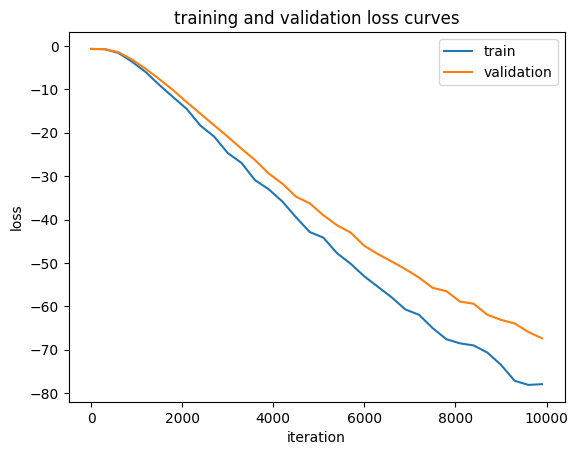

In [12]:
libco_fit(lib_model, lib_tet_data[0], lib_tet_data[1])
blog_fit(blog_model, blog_tet_edge_data, blog_tet_sparse_data, epochs =10000)

### 모델 평가

In [24]:
def libco_eval(model, test_data):
  result = evaluate(
      model=model,
      data=test_data,
      neg_sampling=True,
      metrics=["loss", "roc_auc", "precision", "recall", "ndcg"],
  )
  print(result)

#-- Libco --

def blog_eval(model, blog_tet_edge_data, blog_tet_sparse_data , K = 10):
  # evaluate on test set
  LAMBDA = 1e-6
  model.eval()
  test_edge_index = blog_tet_edge_data[3].to(device)
  test_sparse_edge_index = blog_tet_sparse_data[2].to(device)

  test_loss, test_recall, test_precision, test_ndcg = evaluation(
              model, test_edge_index, test_sparse_edge_index, [blog_tet_edge_data[1], blog_tet_edge_data[2]], K, LAMBDA)

  print(f"[test_loss: {round(test_loss, 5)}, test_recall@{K}: {round(test_recall, 5)}, test_precision@{K}: {round(test_precision, 5)}, test_ndcg@{K}: {round(test_ndcg, 5)}")


In [14]:
libco_eval(lib_model, lib_tet_data[2])
blog_eval(blog_model, blog_tet_edge_data, blog_tet_sparse_data, 10)

eval_listwise: 100%|██████████| 591/591 [00:00<00:00, 1613.41it/s]


{'loss': 0.676297893593398, 'roc_auc': 0.8483268203805565, 'precision': 0.08324873096446701, 'recall': 0.08135967165200032, 'ndcg': 0.2746154884028451}
[test_loss: -63.81942, test_recall@10: 0.08653, test_precision@10: 0.0583, test_ndcg@10: 0.09073


### 모델 예측

In [25]:
def lilco_predict(model, user_id, path, K = 10):
  df = pd.read_csv(path[1])
  rec_arr = model.recommend_user(user=user_id, n_rec=K).get(user_id)

  titles = []
  genres = []
  for i in rec_arr:
    title = df[df['movieId'] == i]['title']
    genre = df[df['movieId'] == i]['genres']
    titles.append(title)
    genres.append(genre)
    # print(f"title: {title}, genres: {genre} ")


  return titles, genres
#-- Libco  --#

def blog_predict(model, user_id ,TopK, path, user_mapping, item_mapping, edge_index):

  df = pd.read_csv(path[1])
  movieid_title = pd.Series(df.title.values,index=df.movieId).to_dict()
  movieid_genres = pd.Series(df.genres.values,index=df.movieId).to_dict()

  user_pos_items = get_user_positive_items(edge_index)
  user = user_mapping[user_id]
  e_u = model.users_emb.weight[user]
  scores = model.items_emb.weight @ e_u

  values, indices = torch.topk(scores, k=len(user_pos_items[user]) + TopK)

  movies = [index.cpu().item() for index in indices if index in user_pos_items[user]][:TopK]
  movie_ids = [list(item_mapping.keys())[list(item_mapping.values()).index(movie)] for movie in movies]
  titles = [movieid_title[id] for id in movie_ids]
  genres = [movieid_genres[id] for id in movie_ids]

  # print(f"Here are some movies that user {user_id} rated highly")
  # for i in range(TopK):
  #     print(f"title: {titles[i]}, genres: {genres[i]} ")

  movies = [index.cpu().item() for index in indices if index not in user_pos_items[user]][:TopK]
  movie_ids = [list(item_mapping.keys())[list(item_mapping.values()).index(movie)] for movie in movies]
  titles = [movieid_title[id] for id in movie_ids]
  genres = [movieid_genres[id] for id in movie_ids]

  # print(f"Here are some suggested movies for user {user_id}")
  return titles, genres

In [16]:
user_id = 1
K = 5
lilco_predict(lib_model,user_id, path, K = K)
blog_predict(blog_model, user_id , K, path, user_mapping, item_mapping, blog_tet_edge_data[0])

(['Shawshank Redemption, The (1994)',
  'Pulp Fiction (1994)',
  'Star Wars: Episode IV - A New Hope (1977)',
  'Usual Suspects, The (1995)',
  'Terminator 2: Judgment Day (1991)'],
 ['Crime|Drama',
  'Comedy|Crime|Drama|Thriller',
  'Action|Adventure|Sci-Fi',
  'Crime|Mystery|Thriller',
  'Action|Sci-Fi'])

## 프레임워크

In [35]:
def libco(data_frame, path, embed_size, n_epochs, excluded_user):
  lib_tet_data, lib_data_info = libco_LightGCN_data(path[0], data_frame, excluded_user = excluded_user_id)
  lib_model = libco_LightGCN(lib_data_info, embed_size =embed_size, n_epochs = int(n_epochs/3))
  libco_fit(lib_model, lib_tet_data[0], lib_tet_data[1])
  libco_eval(lib_model, lib_tet_data[2])
  titles, genres = lilco_predict(lib_model,user_id, path, K = K)
  return titles,genres

def blog(data_frame, path, embed_size, n_epochs, excluded_user):
  blog_tet_edge_data, blog_tet_sparse_data, user_mapping, item_mapping = blog_LightGCN_data(path, data_frame, 4, excluded_user_id)
  blog_model = blog_LightGCN(len(user_mapping), len(item_mapping), embed_size= 32)
  blog_fit(blog_model, blog_tet_edge_data, blog_tet_sparse_data, epochs =n_epochs)
  blog_eval(blog_model, blog_tet_edge_data, blog_tet_sparse_data, 10)
  titles, genres = blog_predict(blog_model, user_id , K, path, user_mapping, item_mapping, blog_tet_edge_data[0])
  return titles,genres

n_users: 610, n_items: 8981, data density: 1.4723 %
Training start time: 2023-10-18 04:39:57


train: 100%|██████████| 40/40 [00:00<00:00, 105.18it/s]


Epoch 1 elapsed: 0.384s


train: 100%|██████████| 40/40 [00:00<00:00, 138.23it/s]


Epoch 2 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 140.34it/s]


Epoch 3 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 142.92it/s]


Epoch 4 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 142.22it/s]


Epoch 5 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 141.06it/s]


Epoch 6 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 139.61it/s]


Epoch 7 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 140.05it/s]


Epoch 8 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 139.94it/s]


Epoch 9 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 139.69it/s]


Epoch 10 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 142.39it/s]


Epoch 11 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 141.44it/s]


Epoch 12 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 142.40it/s]


Epoch 13 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 142.13it/s]


Epoch 14 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 140.74it/s]


Epoch 15 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 140.04it/s]


Epoch 16 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.51it/s]


Epoch 17 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 138.45it/s]


Epoch 18 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 140.41it/s]


Epoch 19 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 137.30it/s]


Epoch 20 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 141.82it/s]


Epoch 21 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 141.87it/s]


Epoch 22 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 142.25it/s]


Epoch 23 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 139.74it/s]


Epoch 24 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 137.39it/s]


Epoch 25 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 136.99it/s]


Epoch 26 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 140.54it/s]


Epoch 27 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 141.91it/s]


Epoch 28 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 143.51it/s]


Epoch 29 elapsed: 0.284s


train: 100%|██████████| 40/40 [00:00<00:00, 140.80it/s]


Epoch 30 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 142.72it/s]


Epoch 31 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 142.34it/s]


Epoch 32 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 144.35it/s]


Epoch 33 elapsed: 0.281s


train: 100%|██████████| 40/40 [00:00<00:00, 143.05it/s]


Epoch 34 elapsed: 0.285s


train: 100%|██████████| 40/40 [00:00<00:00, 143.33it/s]


Epoch 35 elapsed: 0.285s


train: 100%|██████████| 40/40 [00:00<00:00, 137.80it/s]


Epoch 36 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 140.02it/s]


Epoch 37 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 140.54it/s]


Epoch 38 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 142.51it/s]


Epoch 39 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 143.45it/s]


Epoch 40 elapsed: 0.285s


train: 100%|██████████| 40/40 [00:00<00:00, 142.97it/s]


Epoch 41 elapsed: 0.285s


train: 100%|██████████| 40/40 [00:00<00:00, 141.13it/s]


Epoch 42 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 141.10it/s]


Epoch 43 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 140.74it/s]


Epoch 44 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 140.85it/s]


Epoch 45 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 140.49it/s]


Epoch 46 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 142.06it/s]


Epoch 47 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 141.39it/s]


Epoch 48 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 141.21it/s]


Epoch 49 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 140.89it/s]


Epoch 50 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 139.83it/s]


Epoch 51 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 142.55it/s]


Epoch 52 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 143.39it/s]


Epoch 53 elapsed: 0.284s


train: 100%|██████████| 40/40 [00:00<00:00, 142.55it/s]


Epoch 54 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 140.78it/s]


Epoch 55 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 143.72it/s]


Epoch 56 elapsed: 0.285s


train: 100%|██████████| 40/40 [00:00<00:00, 142.41it/s]


Epoch 57 elapsed: 0.285s


train: 100%|██████████| 40/40 [00:00<00:00, 141.74it/s]


Epoch 58 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 141.84it/s]


Epoch 59 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 138.96it/s]


Epoch 60 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.27it/s]


Epoch 61 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 141.16it/s]


Epoch 62 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 138.33it/s]


Epoch 63 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 141.65it/s]


Epoch 64 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 140.28it/s]


Epoch 65 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 138.12it/s]


Epoch 66 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 139.80it/s]


Epoch 67 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 135.08it/s]


Epoch 68 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 139.11it/s]


Epoch 69 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 138.85it/s]


Epoch 70 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.98it/s]


Epoch 71 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 141.23it/s]


Epoch 72 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 140.97it/s]


Epoch 73 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 141.98it/s]


Epoch 74 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 139.49it/s]


Epoch 75 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 141.81it/s]


Epoch 76 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 144.81it/s]


Epoch 77 elapsed: 0.281s


train: 100%|██████████| 40/40 [00:00<00:00, 140.83it/s]


Epoch 78 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 142.72it/s]


Epoch 79 elapsed: 0.284s


train: 100%|██████████| 40/40 [00:00<00:00, 141.60it/s]


Epoch 80 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 141.82it/s]


Epoch 81 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 141.63it/s]


Epoch 82 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 140.17it/s]


Epoch 83 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 140.36it/s]


Epoch 84 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 136.33it/s]


Epoch 85 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 138.87it/s]


Epoch 86 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 142.53it/s]


Epoch 87 elapsed: 0.285s


train: 100%|██████████| 40/40 [00:00<00:00, 143.70it/s]


Epoch 88 elapsed: 0.284s


train: 100%|██████████| 40/40 [00:00<00:00, 142.96it/s]


Epoch 89 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 145.12it/s]


Epoch 90 elapsed: 0.282s


train: 100%|██████████| 40/40 [00:00<00:00, 144.50it/s]


Epoch 91 elapsed: 0.282s


train: 100%|██████████| 40/40 [00:00<00:00, 141.28it/s]


Epoch 92 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 142.53it/s]


Epoch 93 elapsed: 0.285s


train: 100%|██████████| 40/40 [00:00<00:00, 145.53it/s]


Epoch 94 elapsed: 0.282s


train: 100%|██████████| 40/40 [00:00<00:00, 143.92it/s]


Epoch 95 elapsed: 0.283s


train: 100%|██████████| 40/40 [00:00<00:00, 143.48it/s]


Epoch 96 elapsed: 0.285s


train: 100%|██████████| 40/40 [00:00<00:00, 144.69it/s]


Epoch 97 elapsed: 0.281s


train: 100%|██████████| 40/40 [00:00<00:00, 143.99it/s]


Epoch 98 elapsed: 0.281s


train: 100%|██████████| 40/40 [00:00<00:00, 143.21it/s]


Epoch 99 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 143.31it/s]


Epoch 100 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 141.07it/s]


Epoch 101 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 137.21it/s]


Epoch 102 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 137.95it/s]


Epoch 103 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 138.74it/s]


Epoch 104 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 137.75it/s]


Epoch 105 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 140.58it/s]


Epoch 106 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 141.86it/s]


Epoch 107 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 142.03it/s]


Epoch 108 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 142.12it/s]


Epoch 109 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 136.82it/s]


Epoch 110 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 138.58it/s]


Epoch 111 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 142.57it/s]


Epoch 112 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 141.36it/s]


Epoch 113 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 142.66it/s]


Epoch 114 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 144.29it/s]


Epoch 115 elapsed: 0.281s


train: 100%|██████████| 40/40 [00:00<00:00, 141.74it/s]


Epoch 116 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 140.55it/s]


Epoch 117 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 139.36it/s]


Epoch 118 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 141.76it/s]


Epoch 119 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 139.82it/s]


Epoch 120 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 138.70it/s]


Epoch 121 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 140.12it/s]


Epoch 122 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 138.62it/s]


Epoch 123 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 143.14it/s]


Epoch 124 elapsed: 0.284s


train: 100%|██████████| 40/40 [00:00<00:00, 140.10it/s]


Epoch 125 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 139.38it/s]


Epoch 126 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 138.00it/s]


Epoch 127 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 142.38it/s]


Epoch 128 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 140.90it/s]


Epoch 129 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 140.54it/s]


Epoch 130 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 142.96it/s]


Epoch 131 elapsed: 0.285s


train: 100%|██████████| 40/40 [00:00<00:00, 141.96it/s]


Epoch 132 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 141.72it/s]


Epoch 133 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 140.21it/s]


Epoch 134 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 142.71it/s]


Epoch 135 elapsed: 0.285s


train: 100%|██████████| 40/40 [00:00<00:00, 144.44it/s]


Epoch 136 elapsed: 0.283s


train: 100%|██████████| 40/40 [00:00<00:00, 141.96it/s]


Epoch 137 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 142.02it/s]


Epoch 138 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 145.19it/s]


Epoch 139 elapsed: 0.283s


train: 100%|██████████| 40/40 [00:00<00:00, 139.87it/s]


Epoch 140 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 141.16it/s]


Epoch 141 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 142.69it/s]


Epoch 142 elapsed: 0.285s


train: 100%|██████████| 40/40 [00:00<00:00, 143.77it/s]


Epoch 143 elapsed: 0.283s


train: 100%|██████████| 40/40 [00:00<00:00, 141.72it/s]


Epoch 144 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 141.51it/s]


Epoch 145 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 138.00it/s]


Epoch 146 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 140.73it/s]


Epoch 147 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 140.02it/s]


Epoch 148 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 141.14it/s]


Epoch 149 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 142.02it/s]


Epoch 150 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 139.17it/s]


Epoch 151 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 138.57it/s]


Epoch 152 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 138.49it/s]


Epoch 153 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 142.08it/s]


Epoch 154 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 141.46it/s]


Epoch 155 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 141.40it/s]


Epoch 156 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 141.85it/s]


Epoch 157 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 140.52it/s]


Epoch 158 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 141.51it/s]


Epoch 159 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 141.31it/s]


Epoch 160 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 142.01it/s]


Epoch 161 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 139.96it/s]


Epoch 162 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 142.18it/s]


Epoch 163 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 140.55it/s]


Epoch 164 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 142.77it/s]


Epoch 165 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 141.60it/s]


Epoch 166 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 140.88it/s]


Epoch 167 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 139.29it/s]


Epoch 168 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 139.83it/s]


Epoch 169 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 140.12it/s]


Epoch 170 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 139.80it/s]


Epoch 171 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 140.78it/s]


Epoch 172 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 139.38it/s]


Epoch 173 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 138.97it/s]


Epoch 174 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 138.30it/s]


Epoch 175 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 142.70it/s]


Epoch 176 elapsed: 0.285s


train: 100%|██████████| 40/40 [00:00<00:00, 141.12it/s]


Epoch 177 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 140.44it/s]


Epoch 178 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 142.64it/s]


Epoch 179 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 139.97it/s]


Epoch 180 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 139.27it/s]


Epoch 181 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.44it/s]


Epoch 182 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 139.51it/s]


Epoch 183 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.32it/s]


Epoch 184 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 140.37it/s]


Epoch 185 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 141.25it/s]


Epoch 186 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 141.11it/s]


Epoch 187 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 138.83it/s]


Epoch 188 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 139.94it/s]


Epoch 189 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 140.93it/s]


Epoch 190 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 141.03it/s]


Epoch 191 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 139.81it/s]


Epoch 192 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 135.70it/s]


Epoch 193 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 135.44it/s]


Epoch 194 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 138.86it/s]


Epoch 195 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 140.84it/s]


Epoch 196 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 140.98it/s]


Epoch 197 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 140.88it/s]


Epoch 198 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 140.20it/s]


Epoch 199 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 137.99it/s]


Epoch 200 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 138.74it/s]


Epoch 201 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 141.92it/s]


Epoch 202 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 138.57it/s]


Epoch 203 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 139.37it/s]


Epoch 204 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 141.10it/s]


Epoch 205 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 140.79it/s]


Epoch 206 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 141.52it/s]


Epoch 207 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 137.62it/s]


Epoch 208 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 138.99it/s]


Epoch 209 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 138.05it/s]


Epoch 210 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 138.90it/s]


Epoch 211 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 141.52it/s]


Epoch 212 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 140.42it/s]


Epoch 213 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 140.23it/s]


Epoch 214 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 139.48it/s]


Epoch 215 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 140.02it/s]


Epoch 216 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 139.06it/s]


Epoch 217 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 139.55it/s]


Epoch 218 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.86it/s]


Epoch 219 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 138.35it/s]


Epoch 220 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 140.72it/s]


Epoch 221 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 139.46it/s]


Epoch 222 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 139.50it/s]


Epoch 223 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 142.39it/s]


Epoch 224 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 139.95it/s]


Epoch 225 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 138.50it/s]


Epoch 226 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 139.83it/s]


Epoch 227 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 138.96it/s]


Epoch 228 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 137.27it/s]


Epoch 229 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 136.10it/s]


Epoch 230 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 137.49it/s]


Epoch 231 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 139.01it/s]


Epoch 232 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 137.74it/s]


Epoch 233 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 132.39it/s]


Epoch 234 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 134.88it/s]


Epoch 235 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 135.86it/s]


Epoch 236 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 139.13it/s]


Epoch 237 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 139.81it/s]


Epoch 238 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 138.57it/s]


Epoch 239 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 141.52it/s]


Epoch 240 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 141.46it/s]


Epoch 241 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 140.54it/s]


Epoch 242 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 137.75it/s]


Epoch 243 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 141.36it/s]


Epoch 244 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 138.41it/s]


Epoch 245 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 140.83it/s]


Epoch 246 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 141.64it/s]


Epoch 247 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 141.98it/s]


Epoch 248 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 140.64it/s]


Epoch 249 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 143.06it/s]


Epoch 250 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 141.02it/s]


Epoch 251 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 141.52it/s]


Epoch 252 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 142.21it/s]


Epoch 253 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 143.15it/s]


Epoch 254 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 143.85it/s]


Epoch 255 elapsed: 0.283s


train: 100%|██████████| 40/40 [00:00<00:00, 140.80it/s]


Epoch 256 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 142.24it/s]


Epoch 257 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 141.48it/s]


Epoch 258 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 140.92it/s]


Epoch 259 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 143.44it/s]


Epoch 260 elapsed: 0.283s


train: 100%|██████████| 40/40 [00:00<00:00, 144.02it/s]


Epoch 261 elapsed: 0.282s


train: 100%|██████████| 40/40 [00:00<00:00, 142.45it/s]


Epoch 262 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 138.98it/s]


Epoch 263 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 142.78it/s]


Epoch 264 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 140.49it/s]


Epoch 265 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 143.29it/s]


Epoch 266 elapsed: 0.285s


train: 100%|██████████| 40/40 [00:00<00:00, 140.19it/s]


Epoch 267 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 140.87it/s]


Epoch 268 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 140.19it/s]


Epoch 269 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 142.10it/s]


Epoch 270 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 141.27it/s]


Epoch 271 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 139.77it/s]


Epoch 272 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 138.93it/s]


Epoch 273 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 138.16it/s]


Epoch 274 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 139.93it/s]


Epoch 275 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 139.57it/s]


Epoch 276 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 137.70it/s]


Epoch 277 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 134.26it/s]


Epoch 278 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 140.10it/s]


Epoch 279 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 139.99it/s]


Epoch 280 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 139.11it/s]


Epoch 281 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.70it/s]


Epoch 282 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 140.96it/s]


Epoch 283 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 138.88it/s]


Epoch 284 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.14it/s]


Epoch 285 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 142.00it/s]


Epoch 286 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 141.74it/s]


Epoch 287 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 138.74it/s]


Epoch 288 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 138.89it/s]


Epoch 289 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 139.96it/s]


Epoch 290 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 141.23it/s]


Epoch 291 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 139.86it/s]


Epoch 292 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 140.70it/s]


Epoch 293 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 139.96it/s]


Epoch 294 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 139.78it/s]


Epoch 295 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 141.25it/s]


Epoch 296 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 139.73it/s]


Epoch 297 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 140.18it/s]


Epoch 298 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 139.59it/s]


Epoch 299 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 140.76it/s]


Epoch 300 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 139.88it/s]


Epoch 301 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 140.78it/s]


Epoch 302 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 143.19it/s]


Epoch 303 elapsed: 0.285s


train: 100%|██████████| 40/40 [00:00<00:00, 143.17it/s]


Epoch 304 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 142.06it/s]


Epoch 305 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 143.03it/s]


Epoch 306 elapsed: 0.285s


train: 100%|██████████| 40/40 [00:00<00:00, 141.92it/s]


Epoch 307 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 138.13it/s]


Epoch 308 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 141.25it/s]


Epoch 309 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 142.57it/s]


Epoch 310 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 142.41it/s]


Epoch 311 elapsed: 0.285s


train: 100%|██████████| 40/40 [00:00<00:00, 140.45it/s]


Epoch 312 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 136.47it/s]


Epoch 313 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 137.10it/s]


Epoch 314 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 138.24it/s]


Epoch 315 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 139.59it/s]


Epoch 316 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 134.39it/s]


Epoch 317 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 134.90it/s]


Epoch 318 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 138.17it/s]


Epoch 319 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 135.60it/s]


Epoch 320 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 139.44it/s]


Epoch 321 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 138.11it/s]


Epoch 322 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 138.40it/s]


Epoch 323 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 139.07it/s]


Epoch 324 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 138.28it/s]


Epoch 325 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 139.35it/s]


Epoch 326 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 140.94it/s]


Epoch 327 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 139.34it/s]


Epoch 328 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 140.25it/s]


Epoch 329 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 140.39it/s]


Epoch 330 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 143.26it/s]


Epoch 331 elapsed: 0.285s


train: 100%|██████████| 40/40 [00:00<00:00, 139.80it/s]


Epoch 332 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 139.70it/s]


Epoch 333 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 140.13it/s]


Epoch 334 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 140.43it/s]


Epoch 335 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 143.16it/s]


Epoch 336 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 138.36it/s]


Epoch 337 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 140.99it/s]


Epoch 338 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 141.74it/s]


Epoch 339 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 141.38it/s]


Epoch 340 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 142.09it/s]


Epoch 341 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 140.40it/s]


Epoch 342 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 128.32it/s]


Epoch 343 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 129.40it/s]


Epoch 344 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 143.62it/s]


Epoch 345 elapsed: 0.283s


train: 100%|██████████| 40/40 [00:00<00:00, 140.37it/s]


Epoch 346 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 140.11it/s]


Epoch 347 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 143.06it/s]


Epoch 348 elapsed: 0.285s


train: 100%|██████████| 40/40 [00:00<00:00, 141.91it/s]


Epoch 349 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 141.30it/s]


Epoch 350 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 141.35it/s]


Epoch 351 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 141.26it/s]


Epoch 352 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 141.44it/s]


Epoch 353 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 139.17it/s]


Epoch 354 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 138.71it/s]


Epoch 355 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 142.64it/s]


Epoch 356 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 140.05it/s]


Epoch 357 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 141.67it/s]


Epoch 358 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 139.65it/s]


Epoch 359 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 139.54it/s]


Epoch 360 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 139.50it/s]


Epoch 361 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 139.45it/s]


Epoch 362 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 138.31it/s]


Epoch 363 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 141.79it/s]


Epoch 364 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 140.37it/s]


Epoch 365 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 140.88it/s]


Epoch 366 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 145.55it/s]


Epoch 367 elapsed: 0.279s


train: 100%|██████████| 40/40 [00:00<00:00, 138.53it/s]


Epoch 368 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 140.12it/s]


Epoch 369 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 138.19it/s]


Epoch 370 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 138.53it/s]


Epoch 371 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 144.54it/s]


Epoch 372 elapsed: 0.283s


train: 100%|██████████| 40/40 [00:00<00:00, 143.59it/s]


Epoch 373 elapsed: 0.284s


train: 100%|██████████| 40/40 [00:00<00:00, 140.55it/s]


Epoch 374 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 142.04it/s]


Epoch 375 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 140.95it/s]


Epoch 376 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 141.77it/s]


Epoch 377 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 139.51it/s]


Epoch 378 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 139.26it/s]


Epoch 379 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 139.07it/s]


Epoch 380 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 137.47it/s]


Epoch 381 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 142.07it/s]


Epoch 382 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 140.10it/s]


Epoch 383 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 141.48it/s]


Epoch 384 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 142.22it/s]


Epoch 385 elapsed: 0.285s


train: 100%|██████████| 40/40 [00:00<00:00, 140.36it/s]


Epoch 386 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.23it/s]


Epoch 387 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 138.30it/s]


Epoch 388 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 139.55it/s]


Epoch 389 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 139.31it/s]


Epoch 390 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 140.70it/s]


Epoch 391 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 141.02it/s]


Epoch 392 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 140.25it/s]


Epoch 393 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 141.35it/s]


Epoch 394 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 139.03it/s]


Epoch 395 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 137.22it/s]


Epoch 396 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 140.93it/s]


Epoch 397 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 140.81it/s]


Epoch 398 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 139.66it/s]


Epoch 399 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 130.00it/s]


Epoch 400 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 140.53it/s]


Epoch 401 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 139.34it/s]


Epoch 402 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 137.87it/s]


Epoch 403 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 142.20it/s]


Epoch 404 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 141.42it/s]


Epoch 405 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 140.92it/s]


Epoch 406 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 142.92it/s]


Epoch 407 elapsed: 0.284s


train: 100%|██████████| 40/40 [00:00<00:00, 140.93it/s]


Epoch 408 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 141.43it/s]


Epoch 409 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 141.74it/s]


Epoch 410 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 142.31it/s]


Epoch 411 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 139.18it/s]


Epoch 412 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 142.52it/s]


Epoch 413 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 143.19it/s]


Epoch 414 elapsed: 0.284s


train: 100%|██████████| 40/40 [00:00<00:00, 141.78it/s]


Epoch 415 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 143.13it/s]


Epoch 416 elapsed: 0.284s


train: 100%|██████████| 40/40 [00:00<00:00, 141.59it/s]


Epoch 417 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 139.32it/s]


Epoch 418 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 138.25it/s]


Epoch 419 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 135.49it/s]


Epoch 420 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 138.76it/s]


Epoch 421 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.85it/s]


Epoch 422 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 141.43it/s]


Epoch 423 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 138.20it/s]


Epoch 424 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 140.47it/s]


Epoch 425 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 140.29it/s]


Epoch 426 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 140.86it/s]


Epoch 427 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 141.00it/s]


Epoch 428 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 133.98it/s]


Epoch 429 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 122.74it/s]


Epoch 430 elapsed: 0.336s


train: 100%|██████████| 40/40 [00:00<00:00, 138.87it/s]


Epoch 431 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 142.60it/s]


Epoch 432 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 143.28it/s]


Epoch 433 elapsed: 0.283s


train: 100%|██████████| 40/40 [00:00<00:00, 139.33it/s]


Epoch 434 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 139.44it/s]


Epoch 435 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 139.01it/s]


Epoch 436 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.78it/s]


Epoch 437 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 129.88it/s]


Epoch 438 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 139.44it/s]


Epoch 439 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 138.91it/s]


Epoch 440 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 135.33it/s]


Epoch 441 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 135.60it/s]


Epoch 442 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 135.54it/s]


Epoch 443 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 134.61it/s]


Epoch 444 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 138.90it/s]


Epoch 445 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 140.70it/s]


Epoch 446 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 139.95it/s]


Epoch 447 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 136.07it/s]


Epoch 448 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 136.08it/s]


Epoch 449 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 137.33it/s]


Epoch 450 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 139.10it/s]


Epoch 451 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 138.26it/s]


Epoch 452 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 140.02it/s]


Epoch 453 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 139.06it/s]


Epoch 454 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 139.45it/s]


Epoch 455 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 141.43it/s]


Epoch 456 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 140.38it/s]


Epoch 457 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 139.04it/s]


Epoch 458 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 139.24it/s]


Epoch 459 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 139.09it/s]


Epoch 460 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 140.28it/s]


Epoch 461 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 141.65it/s]


Epoch 462 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 138.11it/s]


Epoch 463 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 140.48it/s]


Epoch 464 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 141.70it/s]


Epoch 465 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 142.12it/s]


Epoch 466 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 141.13it/s]


Epoch 467 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 141.71it/s]


Epoch 468 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 137.88it/s]


Epoch 469 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 142.12it/s]


Epoch 470 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 141.23it/s]


Epoch 471 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 139.01it/s]


Epoch 472 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.84it/s]


Epoch 473 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 141.39it/s]


Epoch 474 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 142.92it/s]


Epoch 475 elapsed: 0.285s


train: 100%|██████████| 40/40 [00:00<00:00, 141.12it/s]


Epoch 476 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 140.64it/s]


Epoch 477 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 141.72it/s]


Epoch 478 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 135.80it/s]


Epoch 479 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 136.89it/s]


Epoch 480 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 135.17it/s]


Epoch 481 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 142.45it/s]


Epoch 482 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 138.68it/s]


Epoch 483 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 136.05it/s]


Epoch 484 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 138.34it/s]


Epoch 485 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 137.56it/s]


Epoch 486 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 137.64it/s]


Epoch 487 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 139.56it/s]


Epoch 488 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 141.99it/s]


Epoch 489 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 139.37it/s]


Epoch 490 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 141.83it/s]


Epoch 491 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 139.40it/s]


Epoch 492 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 140.41it/s]


Epoch 493 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 139.50it/s]


Epoch 494 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 140.76it/s]


Epoch 495 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 141.80it/s]


Epoch 496 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 140.61it/s]


Epoch 497 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 139.49it/s]


Epoch 498 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 138.67it/s]


Epoch 499 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 138.57it/s]


Epoch 500 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 138.66it/s]


Epoch 501 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 142.97it/s]


Epoch 502 elapsed: 0.285s


train: 100%|██████████| 40/40 [00:00<00:00, 141.51it/s]


Epoch 503 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 142.06it/s]


Epoch 504 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 142.87it/s]


Epoch 505 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 142.07it/s]


Epoch 506 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 143.26it/s]


Epoch 507 elapsed: 0.285s


train: 100%|██████████| 40/40 [00:00<00:00, 141.26it/s]


Epoch 508 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 143.02it/s]


Epoch 509 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 144.21it/s]


Epoch 510 elapsed: 0.284s


train: 100%|██████████| 40/40 [00:00<00:00, 141.55it/s]


Epoch 511 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 140.44it/s]


Epoch 512 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 141.64it/s]


Epoch 513 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 139.71it/s]


Epoch 514 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.20it/s]


Epoch 515 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 141.32it/s]


Epoch 516 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 138.83it/s]


Epoch 517 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 139.13it/s]


Epoch 518 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 139.95it/s]


Epoch 519 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 141.17it/s]


Epoch 520 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 140.79it/s]


Epoch 521 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 137.75it/s]


Epoch 522 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 137.58it/s]


Epoch 523 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 136.08it/s]


Epoch 524 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 136.76it/s]


Epoch 525 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 136.55it/s]


Epoch 526 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 134.15it/s]


Epoch 527 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 135.98it/s]


Epoch 528 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 142.17it/s]


Epoch 529 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 141.16it/s]


Epoch 530 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 140.69it/s]


Epoch 531 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 138.41it/s]


Epoch 532 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 139.62it/s]


Epoch 533 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 141.84it/s]


Epoch 534 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 142.06it/s]


Epoch 535 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 140.67it/s]


Epoch 536 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 139.48it/s]


Epoch 537 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 141.29it/s]


Epoch 538 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 141.96it/s]


Epoch 539 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 140.42it/s]


Epoch 540 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 143.31it/s]


Epoch 541 elapsed: 0.285s


train: 100%|██████████| 40/40 [00:00<00:00, 140.45it/s]


Epoch 542 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 140.50it/s]


Epoch 543 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 141.81it/s]


Epoch 544 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 143.72it/s]


Epoch 545 elapsed: 0.284s


train: 100%|██████████| 40/40 [00:00<00:00, 140.32it/s]


Epoch 546 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 139.26it/s]


Epoch 547 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 141.23it/s]


Epoch 548 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 139.49it/s]


Epoch 549 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 140.63it/s]


Epoch 550 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 139.73it/s]


Epoch 551 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 137.74it/s]


Epoch 552 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 138.77it/s]


Epoch 553 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 140.75it/s]


Epoch 554 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 139.43it/s]


Epoch 555 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 138.40it/s]


Epoch 556 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 142.13it/s]


Epoch 557 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 140.48it/s]


Epoch 558 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 141.51it/s]


Epoch 559 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 138.36it/s]


Epoch 560 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 141.73it/s]


Epoch 561 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 140.96it/s]


Epoch 562 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 138.39it/s]


Epoch 563 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 137.44it/s]


Epoch 564 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 138.22it/s]


Epoch 565 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 137.10it/s]


Epoch 566 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 137.92it/s]


Epoch 567 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 141.33it/s]


Epoch 568 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 137.94it/s]


Epoch 569 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 135.56it/s]


Epoch 570 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 139.51it/s]


Epoch 571 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 141.95it/s]


Epoch 572 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 141.16it/s]


Epoch 573 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 139.09it/s]


Epoch 574 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 139.47it/s]


Epoch 575 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 141.52it/s]


Epoch 576 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 141.71it/s]


Epoch 577 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 142.87it/s]


Epoch 578 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 140.77it/s]


Epoch 579 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 138.34it/s]


Epoch 580 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 140.18it/s]


Epoch 581 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 139.54it/s]


Epoch 582 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 139.81it/s]


Epoch 583 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 142.05it/s]


Epoch 584 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 140.97it/s]


Epoch 585 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 140.71it/s]


Epoch 586 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 138.12it/s]


Epoch 587 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 139.95it/s]


Epoch 588 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 141.04it/s]


Epoch 589 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 141.11it/s]


Epoch 590 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 140.61it/s]


Epoch 591 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 137.62it/s]


Epoch 592 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 143.13it/s]


Epoch 593 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 140.12it/s]


Epoch 594 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 138.91it/s]


Epoch 595 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.61it/s]


Epoch 596 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 139.96it/s]


Epoch 597 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 142.27it/s]


Epoch 598 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 140.90it/s]


Epoch 599 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 141.98it/s]


Epoch 600 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 139.15it/s]


Epoch 601 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.06it/s]


Epoch 602 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.32it/s]


Epoch 603 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 142.58it/s]


Epoch 604 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 140.06it/s]


Epoch 605 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 137.51it/s]


Epoch 606 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 137.30it/s]


Epoch 607 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 134.32it/s]


Epoch 608 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 138.52it/s]


Epoch 609 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 138.03it/s]


Epoch 610 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 136.80it/s]


Epoch 611 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 137.49it/s]


Epoch 612 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 139.85it/s]


Epoch 613 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 142.74it/s]


Epoch 614 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 141.60it/s]


Epoch 615 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 140.31it/s]


Epoch 616 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 139.46it/s]


Epoch 617 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.56it/s]


Epoch 618 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 142.52it/s]


Epoch 619 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 141.45it/s]


Epoch 620 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 141.10it/s]


Epoch 621 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 136.90it/s]


Epoch 622 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 139.34it/s]


Epoch 623 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 143.13it/s]


Epoch 624 elapsed: 0.285s


train: 100%|██████████| 40/40 [00:00<00:00, 142.59it/s]


Epoch 625 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 139.06it/s]


Epoch 626 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 139.58it/s]


Epoch 627 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 141.05it/s]


Epoch 628 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 138.20it/s]


Epoch 629 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 140.17it/s]


Epoch 630 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 140.12it/s]


Epoch 631 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 140.16it/s]


Epoch 632 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 141.39it/s]


Epoch 633 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 141.46it/s]


Epoch 634 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 140.94it/s]


Epoch 635 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 142.15it/s]


Epoch 636 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 140.40it/s]


Epoch 637 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 141.11it/s]


Epoch 638 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 138.85it/s]


Epoch 639 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 138.41it/s]


Epoch 640 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 142.92it/s]


Epoch 641 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 143.24it/s]


Epoch 642 elapsed: 0.283s


train: 100%|██████████| 40/40 [00:00<00:00, 140.94it/s]


Epoch 643 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 138.90it/s]


Epoch 644 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.40it/s]


Epoch 645 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 138.44it/s]


Epoch 646 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 137.36it/s]


Epoch 647 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 137.76it/s]


Epoch 648 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 135.31it/s]


Epoch 649 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 136.03it/s]


Epoch 650 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 136.02it/s]


Epoch 651 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 133.01it/s]


Epoch 652 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 130.24it/s]


Epoch 653 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 132.44it/s]


Epoch 654 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 135.29it/s]


Epoch 655 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 136.24it/s]


Epoch 656 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 136.69it/s]


Epoch 657 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 137.01it/s]


Epoch 658 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 138.88it/s]


Epoch 659 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 138.03it/s]


Epoch 660 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 137.53it/s]


Epoch 661 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 137.43it/s]


Epoch 662 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 138.50it/s]


Epoch 663 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 140.25it/s]


Epoch 664 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 138.77it/s]


Epoch 665 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 140.94it/s]


Epoch 666 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 140.77it/s]


Epoch 667 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 141.16it/s]


Epoch 668 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 141.90it/s]


Epoch 669 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 140.63it/s]


Epoch 670 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 141.50it/s]


Epoch 671 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 143.77it/s]


Epoch 672 elapsed: 0.283s


train: 100%|██████████| 40/40 [00:00<00:00, 139.39it/s]


Epoch 673 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 139.86it/s]


Epoch 674 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 140.10it/s]


Epoch 675 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 140.09it/s]


Epoch 676 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 139.96it/s]


Epoch 677 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 138.45it/s]


Epoch 678 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 139.73it/s]


Epoch 679 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 136.99it/s]


Epoch 680 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 137.47it/s]


Epoch 681 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 139.76it/s]


Epoch 682 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 140.99it/s]


Epoch 683 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 140.51it/s]


Epoch 684 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 138.39it/s]


Epoch 685 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 138.66it/s]


Epoch 686 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 139.39it/s]


Epoch 687 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 134.69it/s]


Epoch 688 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 137.02it/s]


Epoch 689 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 135.53it/s]


Epoch 690 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 131.01it/s]


Epoch 691 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 134.56it/s]


Epoch 692 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 139.96it/s]


Epoch 693 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 135.27it/s]


Epoch 694 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 135.42it/s]


Epoch 695 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 140.43it/s]


Epoch 696 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 140.98it/s]


Epoch 697 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 140.55it/s]


Epoch 698 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 137.70it/s]


Epoch 699 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 139.95it/s]


Epoch 700 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 142.47it/s]


Epoch 701 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 140.05it/s]


Epoch 702 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 138.72it/s]


Epoch 703 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 140.82it/s]


Epoch 704 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 140.21it/s]


Epoch 705 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 141.01it/s]


Epoch 706 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 141.01it/s]


Epoch 707 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 140.40it/s]


Epoch 708 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 143.73it/s]


Epoch 709 elapsed: 0.285s


train: 100%|██████████| 40/40 [00:00<00:00, 140.76it/s]


Epoch 710 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 139.51it/s]


Epoch 711 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.70it/s]


Epoch 712 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 141.25it/s]


Epoch 713 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 140.50it/s]


Epoch 714 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 139.56it/s]


Epoch 715 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 139.66it/s]


Epoch 716 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 141.83it/s]


Epoch 717 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 142.13it/s]


Epoch 718 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 139.17it/s]


Epoch 719 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 141.80it/s]


Epoch 720 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 141.24it/s]


Epoch 721 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 139.69it/s]


Epoch 722 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 139.14it/s]


Epoch 723 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 139.93it/s]


Epoch 724 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 139.72it/s]


Epoch 725 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 141.16it/s]


Epoch 726 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 140.93it/s]


Epoch 727 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 141.67it/s]


Epoch 728 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 137.72it/s]


Epoch 729 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 134.44it/s]


Epoch 730 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 134.93it/s]


Epoch 731 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 141.06it/s]


Epoch 732 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 139.44it/s]


Epoch 733 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 131.00it/s]


Epoch 734 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 138.19it/s]


Epoch 735 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 134.45it/s]


Epoch 736 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 137.00it/s]


Epoch 737 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 142.34it/s]


Epoch 738 elapsed: 0.285s


train: 100%|██████████| 40/40 [00:00<00:00, 142.15it/s]


Epoch 739 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 143.48it/s]


Epoch 740 elapsed: 0.284s


train: 100%|██████████| 40/40 [00:00<00:00, 139.62it/s]


Epoch 741 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 140.40it/s]


Epoch 742 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 138.85it/s]


Epoch 743 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 140.25it/s]


Epoch 744 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 139.82it/s]


Epoch 745 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 139.57it/s]


Epoch 746 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.47it/s]


Epoch 747 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 140.08it/s]


Epoch 748 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 143.25it/s]


Epoch 749 elapsed: 0.285s


train: 100%|██████████| 40/40 [00:00<00:00, 138.97it/s]


Epoch 750 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 137.52it/s]


Epoch 751 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 138.36it/s]


Epoch 752 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 140.32it/s]


Epoch 753 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 138.18it/s]


Epoch 754 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 139.06it/s]


Epoch 755 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.18it/s]


Epoch 756 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.54it/s]


Epoch 757 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 141.71it/s]


Epoch 758 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 140.73it/s]


Epoch 759 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 139.58it/s]


Epoch 760 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 139.34it/s]


Epoch 761 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 141.84it/s]


Epoch 762 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 138.91it/s]


Epoch 763 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 140.20it/s]


Epoch 764 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 140.02it/s]


Epoch 765 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 139.24it/s]


Epoch 766 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 140.09it/s]


Epoch 767 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 139.84it/s]


Epoch 768 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 143.80it/s]


Epoch 769 elapsed: 0.283s


train: 100%|██████████| 40/40 [00:00<00:00, 141.95it/s]


Epoch 770 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 138.94it/s]


Epoch 771 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 137.08it/s]


Epoch 772 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 142.65it/s]


Epoch 773 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 139.97it/s]


Epoch 774 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 137.35it/s]


Epoch 775 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 137.62it/s]


Epoch 776 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 137.59it/s]


Epoch 777 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 135.83it/s]


Epoch 778 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 137.11it/s]


Epoch 779 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 142.65it/s]


Epoch 780 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 138.97it/s]


Epoch 781 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 141.28it/s]


Epoch 782 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 140.91it/s]


Epoch 783 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 142.41it/s]


Epoch 784 elapsed: 0.285s


train: 100%|██████████| 40/40 [00:00<00:00, 141.27it/s]


Epoch 785 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 141.11it/s]


Epoch 786 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 143.01it/s]


Epoch 787 elapsed: 0.285s


train: 100%|██████████| 40/40 [00:00<00:00, 141.25it/s]


Epoch 788 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 141.33it/s]


Epoch 789 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 140.12it/s]


Epoch 790 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 143.17it/s]


Epoch 791 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 140.19it/s]


Epoch 792 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 139.50it/s]


Epoch 793 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 140.06it/s]


Epoch 794 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.33it/s]


Epoch 795 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 140.79it/s]


Epoch 796 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 141.94it/s]


Epoch 797 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 139.02it/s]


Epoch 798 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 133.65it/s]


Epoch 799 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 140.08it/s]


Epoch 800 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 134.76it/s]


Epoch 801 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 137.20it/s]


Epoch 802 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 133.70it/s]


Epoch 803 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 135.60it/s]


Epoch 804 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 134.14it/s]


Epoch 805 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 134.92it/s]


Epoch 806 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 138.68it/s]


Epoch 807 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 137.51it/s]


Epoch 808 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 138.54it/s]


Epoch 809 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 139.67it/s]


Epoch 810 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 137.62it/s]


Epoch 811 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 139.35it/s]


Epoch 812 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 135.97it/s]


Epoch 813 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 133.92it/s]


Epoch 814 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 138.40it/s]


Epoch 815 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 135.90it/s]


Epoch 816 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 140.08it/s]


Epoch 817 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 132.01it/s]


Epoch 818 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 132.61it/s]


Epoch 819 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 138.41it/s]


Epoch 820 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 140.44it/s]


Epoch 821 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 140.55it/s]


Epoch 822 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.76it/s]


Epoch 823 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 135.57it/s]


Epoch 824 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 135.47it/s]


Epoch 825 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 138.74it/s]


Epoch 826 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 136.62it/s]


Epoch 827 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 138.30it/s]


Epoch 828 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 136.25it/s]


Epoch 829 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 138.85it/s]


Epoch 830 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 136.90it/s]


Epoch 831 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 139.85it/s]


Epoch 832 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 138.05it/s]


Epoch 833 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 139.94it/s]


Epoch 834 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 141.25it/s]


Epoch 835 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 142.00it/s]


Epoch 836 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 140.60it/s]


Epoch 837 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 137.93it/s]


Epoch 838 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 138.69it/s]


Epoch 839 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 138.42it/s]


Epoch 840 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 142.57it/s]


Epoch 841 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 138.79it/s]


Epoch 842 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 141.80it/s]


Epoch 843 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 141.82it/s]


Epoch 844 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 140.28it/s]


Epoch 845 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 142.83it/s]


Epoch 846 elapsed: 0.284s


train: 100%|██████████| 40/40 [00:00<00:00, 142.66it/s]


Epoch 847 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 140.47it/s]


Epoch 848 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 143.68it/s]


Epoch 849 elapsed: 0.285s


train: 100%|██████████| 40/40 [00:00<00:00, 141.62it/s]


Epoch 850 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 143.74it/s]


Epoch 851 elapsed: 0.282s


train: 100%|██████████| 40/40 [00:00<00:00, 141.60it/s]


Epoch 852 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 140.39it/s]


Epoch 853 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 138.32it/s]


Epoch 854 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 129.78it/s]


Epoch 855 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 136.73it/s]


Epoch 856 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 134.66it/s]


Epoch 857 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 133.43it/s]


Epoch 858 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 134.43it/s]


Epoch 859 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 132.16it/s]


Epoch 860 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 135.92it/s]


Epoch 861 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 136.62it/s]


Epoch 862 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 139.44it/s]


Epoch 863 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 139.96it/s]


Epoch 864 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 140.01it/s]


Epoch 865 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 139.93it/s]


Epoch 866 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 137.91it/s]


Epoch 867 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 142.76it/s]


Epoch 868 elapsed: 0.285s


train: 100%|██████████| 40/40 [00:00<00:00, 140.69it/s]


Epoch 869 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 144.53it/s]


Epoch 870 elapsed: 0.281s


train: 100%|██████████| 40/40 [00:00<00:00, 144.60it/s]


Epoch 871 elapsed: 0.281s


train: 100%|██████████| 40/40 [00:00<00:00, 139.80it/s]


Epoch 872 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 143.29it/s]


Epoch 873 elapsed: 0.284s


train: 100%|██████████| 40/40 [00:00<00:00, 140.38it/s]


Epoch 874 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 141.45it/s]


Epoch 875 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 138.25it/s]


Epoch 876 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 141.39it/s]


Epoch 877 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 143.70it/s]


Epoch 878 elapsed: 0.283s


train: 100%|██████████| 40/40 [00:00<00:00, 140.39it/s]


Epoch 879 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 139.30it/s]


Epoch 880 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 139.10it/s]


Epoch 881 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 142.15it/s]


Epoch 882 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 140.54it/s]


Epoch 883 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 138.98it/s]


Epoch 884 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.93it/s]


Epoch 885 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 141.33it/s]


Epoch 886 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 142.53it/s]


Epoch 887 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 137.35it/s]


Epoch 888 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 140.57it/s]


Epoch 889 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 139.59it/s]


Epoch 890 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 139.58it/s]


Epoch 891 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 139.38it/s]


Epoch 892 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 139.31it/s]


Epoch 893 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 139.32it/s]


Epoch 894 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.23it/s]


Epoch 895 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 137.30it/s]


Epoch 896 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 137.27it/s]


Epoch 897 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 139.75it/s]


Epoch 898 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 137.43it/s]


Epoch 899 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 138.10it/s]


Epoch 900 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 138.70it/s]


Epoch 901 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 137.95it/s]


Epoch 902 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 140.12it/s]


Epoch 903 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 136.30it/s]


Epoch 904 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 141.01it/s]


Epoch 905 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 140.55it/s]


Epoch 906 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 141.26it/s]


Epoch 907 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 139.85it/s]


Epoch 908 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 141.04it/s]


Epoch 909 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 142.28it/s]


Epoch 910 elapsed: 0.285s


train: 100%|██████████| 40/40 [00:00<00:00, 142.92it/s]


Epoch 911 elapsed: 0.285s


train: 100%|██████████| 40/40 [00:00<00:00, 142.38it/s]


Epoch 912 elapsed: 0.285s


train: 100%|██████████| 40/40 [00:00<00:00, 143.16it/s]


Epoch 913 elapsed: 0.284s


train: 100%|██████████| 40/40 [00:00<00:00, 141.33it/s]


Epoch 914 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 141.05it/s]


Epoch 915 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 139.90it/s]


Epoch 916 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 139.39it/s]


Epoch 917 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 139.41it/s]


Epoch 918 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 142.07it/s]


Epoch 919 elapsed: 0.285s


train: 100%|██████████| 40/40 [00:00<00:00, 142.46it/s]


Epoch 920 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 139.86it/s]


Epoch 921 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 135.59it/s]


Epoch 922 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 140.22it/s]


Epoch 923 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 141.43it/s]


Epoch 924 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 137.74it/s]


Epoch 925 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 140.71it/s]


Epoch 926 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 140.77it/s]


Epoch 927 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 141.13it/s]


Epoch 928 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 140.23it/s]


Epoch 929 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.74it/s]


Epoch 930 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 141.63it/s]


Epoch 931 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 140.19it/s]


Epoch 932 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 140.37it/s]


Epoch 933 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 137.65it/s]


Epoch 934 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 140.25it/s]


Epoch 935 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 140.70it/s]


Epoch 936 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 143.63it/s]


Epoch 937 elapsed: 0.284s


train: 100%|██████████| 40/40 [00:00<00:00, 139.96it/s]


Epoch 938 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 137.64it/s]


Epoch 939 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 141.11it/s]


Epoch 940 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 141.23it/s]


Epoch 941 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 135.45it/s]


Epoch 942 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 137.06it/s]


Epoch 943 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 131.71it/s]


Epoch 944 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 136.30it/s]


Epoch 945 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 137.89it/s]


Epoch 946 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 140.19it/s]


Epoch 947 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 139.95it/s]


Epoch 948 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 144.11it/s]


Epoch 949 elapsed: 0.285s


train: 100%|██████████| 40/40 [00:00<00:00, 141.63it/s]


Epoch 950 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 142.01it/s]


Epoch 951 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 139.83it/s]


Epoch 952 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 140.93it/s]


Epoch 953 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 140.80it/s]


Epoch 954 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 140.39it/s]


Epoch 955 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 137.09it/s]


Epoch 956 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 137.50it/s]


Epoch 957 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 141.58it/s]


Epoch 958 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 141.71it/s]


Epoch 959 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 138.68it/s]


Epoch 960 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 139.51it/s]


Epoch 961 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 137.88it/s]


Epoch 962 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 139.00it/s]


Epoch 963 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 141.00it/s]


Epoch 964 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 139.14it/s]


Epoch 965 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 138.13it/s]


Epoch 966 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 142.90it/s]


Epoch 967 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 141.00it/s]


Epoch 968 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 140.54it/s]


Epoch 969 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 138.42it/s]


Epoch 970 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 141.28it/s]


Epoch 971 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 142.82it/s]


Epoch 972 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 140.22it/s]


Epoch 973 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 139.36it/s]


Epoch 974 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 139.08it/s]


Epoch 975 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 141.59it/s]


Epoch 976 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 139.70it/s]


Epoch 977 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 139.14it/s]


Epoch 978 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 142.38it/s]


Epoch 979 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 137.28it/s]


Epoch 980 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 139.90it/s]


Epoch 981 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 139.08it/s]


Epoch 982 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 142.11it/s]


Epoch 983 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 131.76it/s]


Epoch 984 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 134.88it/s]


Epoch 985 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 133.19it/s]


Epoch 986 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 137.95it/s]


Epoch 987 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 141.82it/s]


Epoch 988 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 139.57it/s]


Epoch 989 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 139.13it/s]


Epoch 990 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.78it/s]


Epoch 991 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 141.98it/s]


Epoch 992 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 141.95it/s]


Epoch 993 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 138.78it/s]


Epoch 994 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 138.88it/s]


Epoch 995 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 138.37it/s]


Epoch 996 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 137.69it/s]


Epoch 997 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 141.38it/s]


Epoch 998 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 141.61it/s]


Epoch 999 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 140.69it/s]


Epoch 1000 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 140.10it/s]


Epoch 1001 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 136.87it/s]


Epoch 1002 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 138.45it/s]


Epoch 1003 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 139.84it/s]


Epoch 1004 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 140.74it/s]


Epoch 1005 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 140.26it/s]


Epoch 1006 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 140.68it/s]


Epoch 1007 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 141.93it/s]


Epoch 1008 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 141.87it/s]


Epoch 1009 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 140.82it/s]


Epoch 1010 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 139.44it/s]


Epoch 1011 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 141.47it/s]


Epoch 1012 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 140.47it/s]


Epoch 1013 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 139.95it/s]


Epoch 1014 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 141.10it/s]


Epoch 1015 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 138.32it/s]


Epoch 1016 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 141.41it/s]


Epoch 1017 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 138.14it/s]


Epoch 1018 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 140.19it/s]


Epoch 1019 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 140.74it/s]


Epoch 1020 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 138.97it/s]


Epoch 1021 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 139.15it/s]


Epoch 1022 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 138.96it/s]


Epoch 1023 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.39it/s]


Epoch 1024 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 137.98it/s]


Epoch 1025 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 135.80it/s]


Epoch 1026 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 137.59it/s]


Epoch 1027 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 137.28it/s]


Epoch 1028 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 134.78it/s]


Epoch 1029 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 138.23it/s]


Epoch 1030 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 141.34it/s]


Epoch 1031 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 142.08it/s]


Epoch 1032 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 141.18it/s]


Epoch 1033 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 139.71it/s]


Epoch 1034 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 140.15it/s]


Epoch 1035 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 136.59it/s]


Epoch 1036 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 137.10it/s]


Epoch 1037 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 139.35it/s]


Epoch 1038 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 139.86it/s]


Epoch 1039 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 140.54it/s]


Epoch 1040 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 142.88it/s]


Epoch 1041 elapsed: 0.285s


train: 100%|██████████| 40/40 [00:00<00:00, 142.23it/s]


Epoch 1042 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 140.80it/s]


Epoch 1043 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 139.18it/s]


Epoch 1044 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.15it/s]


Epoch 1045 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 139.36it/s]


Epoch 1046 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 141.90it/s]


Epoch 1047 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 138.94it/s]


Epoch 1048 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 139.65it/s]


Epoch 1049 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 140.13it/s]


Epoch 1050 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 140.76it/s]


Epoch 1051 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 141.05it/s]


Epoch 1052 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 140.87it/s]


Epoch 1053 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 142.88it/s]


Epoch 1054 elapsed: 0.285s


train: 100%|██████████| 40/40 [00:00<00:00, 139.92it/s]


Epoch 1055 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 141.10it/s]


Epoch 1056 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 139.83it/s]


Epoch 1057 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 142.64it/s]


Epoch 1058 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 138.32it/s]


Epoch 1059 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 139.14it/s]


Epoch 1060 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 139.87it/s]


Epoch 1061 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.07it/s]


Epoch 1062 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 142.11it/s]


Epoch 1063 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 135.41it/s]


Epoch 1064 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 133.16it/s]


Epoch 1065 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 136.57it/s]


Epoch 1066 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 137.40it/s]


Epoch 1067 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 137.36it/s]


Epoch 1068 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 137.04it/s]


Epoch 1069 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 139.66it/s]


Epoch 1070 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 138.18it/s]


Epoch 1071 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 139.79it/s]


Epoch 1072 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 139.31it/s]


Epoch 1073 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 139.51it/s]


Epoch 1074 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 141.09it/s]


Epoch 1075 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 142.08it/s]


Epoch 1076 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 140.82it/s]


Epoch 1077 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 140.19it/s]


Epoch 1078 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 141.23it/s]


Epoch 1079 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 140.10it/s]


Epoch 1080 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.72it/s]


Epoch 1081 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 139.85it/s]


Epoch 1082 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 141.05it/s]


Epoch 1083 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 139.31it/s]


Epoch 1084 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.69it/s]


Epoch 1085 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 138.43it/s]


Epoch 1086 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 139.10it/s]


Epoch 1087 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 138.65it/s]


Epoch 1088 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 139.67it/s]


Epoch 1089 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 141.48it/s]


Epoch 1090 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 142.57it/s]


Epoch 1091 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 140.34it/s]


Epoch 1092 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 142.21it/s]


Epoch 1093 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 142.79it/s]


Epoch 1094 elapsed: 0.285s


train: 100%|██████████| 40/40 [00:00<00:00, 139.45it/s]


Epoch 1095 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.98it/s]


Epoch 1096 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 141.86it/s]


Epoch 1097 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 140.41it/s]


Epoch 1098 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 143.00it/s]


Epoch 1099 elapsed: 0.285s


train: 100%|██████████| 40/40 [00:00<00:00, 139.74it/s]


Epoch 1100 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 141.45it/s]


Epoch 1101 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 142.91it/s]


Epoch 1102 elapsed: 0.284s


train: 100%|██████████| 40/40 [00:00<00:00, 139.18it/s]


Epoch 1103 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 143.98it/s]


Epoch 1104 elapsed: 0.284s


train: 100%|██████████| 40/40 [00:00<00:00, 140.31it/s]


Epoch 1105 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 140.10it/s]


Epoch 1106 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 136.53it/s]


Epoch 1107 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 135.87it/s]


Epoch 1108 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 138.53it/s]


Epoch 1109 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 132.69it/s]


Epoch 1110 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 135.73it/s]


Epoch 1111 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 132.28it/s]


Epoch 1112 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 138.39it/s]


Epoch 1113 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 139.81it/s]


Epoch 1114 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 139.20it/s]


Epoch 1115 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 138.85it/s]


Epoch 1116 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.19it/s]


Epoch 1117 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 143.07it/s]


Epoch 1118 elapsed: 0.284s


train: 100%|██████████| 40/40 [00:00<00:00, 138.58it/s]


Epoch 1119 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 140.20it/s]


Epoch 1120 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 140.89it/s]


Epoch 1121 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 139.93it/s]


Epoch 1122 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 139.14it/s]


Epoch 1123 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 139.54it/s]


Epoch 1124 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 142.62it/s]


Epoch 1125 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 138.96it/s]


Epoch 1126 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 138.52it/s]


Epoch 1127 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 138.82it/s]


Epoch 1128 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 143.56it/s]


Epoch 1129 elapsed: 0.285s


train: 100%|██████████| 40/40 [00:00<00:00, 139.14it/s]


Epoch 1130 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 137.80it/s]


Epoch 1131 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 138.56it/s]


Epoch 1132 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 135.97it/s]


Epoch 1133 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 138.84it/s]


Epoch 1134 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 137.87it/s]


Epoch 1135 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 137.14it/s]


Epoch 1136 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 141.05it/s]


Epoch 1137 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 138.70it/s]


Epoch 1138 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 137.05it/s]


Epoch 1139 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 141.22it/s]


Epoch 1140 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 140.42it/s]


Epoch 1141 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 138.90it/s]


Epoch 1142 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 139.00it/s]


Epoch 1143 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 141.34it/s]


Epoch 1144 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 140.09it/s]


Epoch 1145 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 139.37it/s]


Epoch 1146 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 135.29it/s]


Epoch 1147 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 138.80it/s]


Epoch 1148 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 140.32it/s]


Epoch 1149 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 142.52it/s]


Epoch 1150 elapsed: 0.285s


train: 100%|██████████| 40/40 [00:00<00:00, 135.63it/s]


Epoch 1151 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 135.56it/s]


Epoch 1152 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 134.34it/s]


Epoch 1153 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 133.81it/s]


Epoch 1154 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 139.20it/s]


Epoch 1155 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 140.42it/s]


Epoch 1156 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 138.32it/s]


Epoch 1157 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 139.71it/s]


Epoch 1158 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 139.15it/s]


Epoch 1159 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.65it/s]


Epoch 1160 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 138.03it/s]


Epoch 1161 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 138.64it/s]


Epoch 1162 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 140.88it/s]


Epoch 1163 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 141.23it/s]


Epoch 1164 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 140.62it/s]


Epoch 1165 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 143.18it/s]


Epoch 1166 elapsed: 0.285s


train: 100%|██████████| 40/40 [00:00<00:00, 140.85it/s]


Epoch 1167 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 140.70it/s]


Epoch 1168 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 143.19it/s]


Epoch 1169 elapsed: 0.285s


train: 100%|██████████| 40/40 [00:00<00:00, 140.27it/s]


Epoch 1170 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 142.34it/s]


Epoch 1171 elapsed: 0.285s


train: 100%|██████████| 40/40 [00:00<00:00, 141.59it/s]


Epoch 1172 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 140.83it/s]


Epoch 1173 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 140.58it/s]


Epoch 1174 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 139.54it/s]


Epoch 1175 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.86it/s]


Epoch 1176 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 140.18it/s]


Epoch 1177 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.42it/s]


Epoch 1178 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 139.39it/s]


Epoch 1179 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 137.59it/s]


Epoch 1180 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 139.18it/s]


Epoch 1181 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 138.19it/s]


Epoch 1182 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 134.96it/s]


Epoch 1183 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 137.88it/s]


Epoch 1184 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 137.86it/s]


Epoch 1185 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 140.03it/s]


Epoch 1186 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 140.90it/s]


Epoch 1187 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 143.03it/s]


Epoch 1188 elapsed: 0.285s


train: 100%|██████████| 40/40 [00:00<00:00, 132.39it/s]


Epoch 1189 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 131.96it/s]


Epoch 1190 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 137.01it/s]


Epoch 1191 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 134.21it/s]


Epoch 1192 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 132.95it/s]


Epoch 1193 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 131.18it/s]


Epoch 1194 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 131.70it/s]


Epoch 1195 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 134.79it/s]


Epoch 1196 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 141.93it/s]


Epoch 1197 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 138.54it/s]


Epoch 1198 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 137.38it/s]


Epoch 1199 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 138.52it/s]


Epoch 1200 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 138.67it/s]


Epoch 1201 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 139.58it/s]


Epoch 1202 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 138.56it/s]


Epoch 1203 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 138.20it/s]


Epoch 1204 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 140.88it/s]


Epoch 1205 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 139.49it/s]


Epoch 1206 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 141.10it/s]


Epoch 1207 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 142.15it/s]


Epoch 1208 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 137.47it/s]


Epoch 1209 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 136.80it/s]


Epoch 1210 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 135.27it/s]


Epoch 1211 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 136.87it/s]


Epoch 1212 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 136.97it/s]


Epoch 1213 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 137.69it/s]


Epoch 1214 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 139.85it/s]


Epoch 1215 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 140.47it/s]


Epoch 1216 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 140.38it/s]


Epoch 1217 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 139.96it/s]


Epoch 1218 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 137.84it/s]


Epoch 1219 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 143.88it/s]


Epoch 1220 elapsed: 0.284s


train: 100%|██████████| 40/40 [00:00<00:00, 142.89it/s]


Epoch 1221 elapsed: 0.285s


train: 100%|██████████| 40/40 [00:00<00:00, 140.61it/s]


Epoch 1222 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 140.05it/s]


Epoch 1223 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 139.49it/s]


Epoch 1224 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 142.47it/s]


Epoch 1225 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 139.21it/s]


Epoch 1226 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 140.48it/s]


Epoch 1227 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 141.14it/s]


Epoch 1228 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 140.21it/s]


Epoch 1229 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 135.78it/s]


Epoch 1230 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 135.64it/s]


Epoch 1231 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 136.72it/s]


Epoch 1232 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 136.53it/s]


Epoch 1233 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 136.93it/s]


Epoch 1234 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 136.55it/s]


Epoch 1235 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 134.19it/s]


Epoch 1236 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 133.25it/s]


Epoch 1237 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 140.68it/s]


Epoch 1238 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 138.62it/s]


Epoch 1239 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 139.51it/s]


Epoch 1240 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 110.62it/s]


Epoch 1241 elapsed: 0.368s


train: 100%|██████████| 40/40 [00:00<00:00, 137.95it/s]


Epoch 1242 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 140.78it/s]


Epoch 1243 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 140.60it/s]


Epoch 1244 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.15it/s]


Epoch 1245 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 140.12it/s]


Epoch 1246 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 139.86it/s]


Epoch 1247 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.32it/s]


Epoch 1248 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 139.87it/s]


Epoch 1249 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 139.73it/s]


Epoch 1250 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 143.55it/s]


Epoch 1251 elapsed: 0.285s


train: 100%|██████████| 40/40 [00:00<00:00, 141.80it/s]


Epoch 1252 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 137.86it/s]


Epoch 1253 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 140.51it/s]


Epoch 1254 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 140.90it/s]


Epoch 1255 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 140.55it/s]


Epoch 1256 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 136.89it/s]


Epoch 1257 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 135.21it/s]


Epoch 1258 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 138.50it/s]


Epoch 1259 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 137.82it/s]


Epoch 1260 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 138.56it/s]


Epoch 1261 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 139.74it/s]


Epoch 1262 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 140.25it/s]


Epoch 1263 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 139.57it/s]


Epoch 1264 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 137.57it/s]


Epoch 1265 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 140.07it/s]


Epoch 1266 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 138.25it/s]


Epoch 1267 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 137.33it/s]


Epoch 1268 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 137.24it/s]


Epoch 1269 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 138.14it/s]


Epoch 1270 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 135.04it/s]


Epoch 1271 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 135.47it/s]


Epoch 1272 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 138.74it/s]


Epoch 1273 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 135.13it/s]


Epoch 1274 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 134.78it/s]


Epoch 1275 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 133.90it/s]


Epoch 1276 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 133.06it/s]


Epoch 1277 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 135.36it/s]


Epoch 1278 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 136.32it/s]


Epoch 1279 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 135.54it/s]


Epoch 1280 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 138.61it/s]


Epoch 1281 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 132.54it/s]


Epoch 1282 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 138.31it/s]


Epoch 1283 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 140.57it/s]


Epoch 1284 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 139.24it/s]


Epoch 1285 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 139.28it/s]


Epoch 1286 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 138.50it/s]


Epoch 1287 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 140.40it/s]


Epoch 1288 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 137.58it/s]


Epoch 1289 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 138.32it/s]


Epoch 1290 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 137.62it/s]


Epoch 1291 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 138.21it/s]


Epoch 1292 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 139.37it/s]


Epoch 1293 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 138.11it/s]


Epoch 1294 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 139.51it/s]


Epoch 1295 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 138.44it/s]


Epoch 1296 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 137.15it/s]


Epoch 1297 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 138.01it/s]


Epoch 1298 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 138.50it/s]


Epoch 1299 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 137.60it/s]


Epoch 1300 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 139.23it/s]


Epoch 1301 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 136.54it/s]


Epoch 1302 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 137.72it/s]


Epoch 1303 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 138.57it/s]


Epoch 1304 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 139.79it/s]


Epoch 1305 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 138.04it/s]


Epoch 1306 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 140.17it/s]


Epoch 1307 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 138.41it/s]


Epoch 1308 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 137.18it/s]


Epoch 1309 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 139.91it/s]


Epoch 1310 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 139.51it/s]


Epoch 1311 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 139.86it/s]


Epoch 1312 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 138.46it/s]


Epoch 1313 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 137.99it/s]


Epoch 1314 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 137.75it/s]


Epoch 1315 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 130.99it/s]


Epoch 1316 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 136.27it/s]


Epoch 1317 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 133.75it/s]


Epoch 1318 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 136.80it/s]


Epoch 1319 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 136.56it/s]


Epoch 1320 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 139.49it/s]


Epoch 1321 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 137.34it/s]


Epoch 1322 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 139.61it/s]


Epoch 1323 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 139.39it/s]


Epoch 1324 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 138.63it/s]


Epoch 1325 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 138.01it/s]


Epoch 1326 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 139.04it/s]


Epoch 1327 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 138.83it/s]


Epoch 1328 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.59it/s]


Epoch 1329 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 139.02it/s]


Epoch 1330 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 137.59it/s]


Epoch 1331 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 139.23it/s]


Epoch 1332 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 139.81it/s]


Epoch 1333 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 138.44it/s]


Epoch 1334 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 137.50it/s]


Epoch 1335 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 136.07it/s]


Epoch 1336 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 136.94it/s]


Epoch 1337 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 138.69it/s]


Epoch 1338 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 137.62it/s]


Epoch 1339 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 138.00it/s]


Epoch 1340 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 139.43it/s]


Epoch 1341 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 137.42it/s]


Epoch 1342 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 139.30it/s]


Epoch 1343 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 139.44it/s]


Epoch 1344 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 140.50it/s]


Epoch 1345 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 138.51it/s]


Epoch 1346 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 140.17it/s]


Epoch 1347 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 137.63it/s]


Epoch 1348 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 140.68it/s]


Epoch 1349 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 139.15it/s]


Epoch 1350 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 139.25it/s]


Epoch 1351 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 139.72it/s]


Epoch 1352 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 138.64it/s]


Epoch 1353 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 138.44it/s]


Epoch 1354 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 139.36it/s]


Epoch 1355 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 141.44it/s]


Epoch 1356 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 140.05it/s]


Epoch 1357 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 138.51it/s]


Epoch 1358 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 137.87it/s]


Epoch 1359 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 135.22it/s]


Epoch 1360 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 131.16it/s]


Epoch 1361 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 135.71it/s]


Epoch 1362 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 137.33it/s]


Epoch 1363 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 137.51it/s]


Epoch 1364 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 138.51it/s]


Epoch 1365 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 140.19it/s]


Epoch 1366 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 139.20it/s]


Epoch 1367 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 138.67it/s]


Epoch 1368 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 138.43it/s]


Epoch 1369 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 139.41it/s]


Epoch 1370 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 140.36it/s]


Epoch 1371 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 139.37it/s]


Epoch 1372 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 136.36it/s]


Epoch 1373 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 140.56it/s]


Epoch 1374 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 140.18it/s]


Epoch 1375 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 138.58it/s]


Epoch 1376 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 136.91it/s]


Epoch 1377 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 136.90it/s]


Epoch 1378 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 139.85it/s]


Epoch 1379 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 139.02it/s]


Epoch 1380 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 142.25it/s]


Epoch 1381 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 138.85it/s]


Epoch 1382 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 141.98it/s]


Epoch 1383 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 140.64it/s]


Epoch 1384 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 136.29it/s]


Epoch 1385 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 139.12it/s]


Epoch 1386 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 142.98it/s]


Epoch 1387 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 138.79it/s]


Epoch 1388 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 138.52it/s]


Epoch 1389 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 139.89it/s]


Epoch 1390 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 141.65it/s]


Epoch 1391 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 140.74it/s]


Epoch 1392 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 137.86it/s]


Epoch 1393 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 138.81it/s]


Epoch 1394 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 142.46it/s]


Epoch 1395 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 135.03it/s]


Epoch 1396 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 141.11it/s]


Epoch 1397 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 138.96it/s]


Epoch 1398 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 141.64it/s]


Epoch 1399 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 134.46it/s]


Epoch 1400 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 135.71it/s]


Epoch 1401 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 138.34it/s]


Epoch 1402 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 136.79it/s]


Epoch 1403 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 137.93it/s]


Epoch 1404 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 138.33it/s]


Epoch 1405 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 140.40it/s]


Epoch 1406 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 140.75it/s]


Epoch 1407 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 141.09it/s]


Epoch 1408 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 142.61it/s]


Epoch 1409 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 140.51it/s]


Epoch 1410 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 140.61it/s]


Epoch 1411 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 141.90it/s]


Epoch 1412 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 139.05it/s]


Epoch 1413 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 140.57it/s]


Epoch 1414 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 143.20it/s]


Epoch 1415 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 138.62it/s]


Epoch 1416 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 139.96it/s]


Epoch 1417 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 139.75it/s]


Epoch 1418 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 138.68it/s]


Epoch 1419 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 140.24it/s]


Epoch 1420 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 137.73it/s]


Epoch 1421 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 139.15it/s]


Epoch 1422 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 140.75it/s]


Epoch 1423 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 140.47it/s]


Epoch 1424 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 142.90it/s]


Epoch 1425 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 140.70it/s]


Epoch 1426 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 141.93it/s]


Epoch 1427 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 139.64it/s]


Epoch 1428 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 140.67it/s]


Epoch 1429 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 140.68it/s]


Epoch 1430 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 142.11it/s]


Epoch 1431 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 140.51it/s]


Epoch 1432 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 139.57it/s]


Epoch 1433 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 141.25it/s]


Epoch 1434 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 138.33it/s]


Epoch 1435 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 139.92it/s]


Epoch 1436 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 138.35it/s]


Epoch 1437 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 135.67it/s]


Epoch 1438 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 139.24it/s]


Epoch 1439 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 133.55it/s]


Epoch 1440 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 135.75it/s]


Epoch 1441 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 136.79it/s]


Epoch 1442 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 137.36it/s]


Epoch 1443 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 138.11it/s]


Epoch 1444 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 136.34it/s]


Epoch 1445 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 138.34it/s]


Epoch 1446 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 138.69it/s]


Epoch 1447 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 139.48it/s]


Epoch 1448 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 139.79it/s]


Epoch 1449 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 140.79it/s]


Epoch 1450 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 140.89it/s]


Epoch 1451 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 140.24it/s]


Epoch 1452 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 140.34it/s]


Epoch 1453 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 140.97it/s]


Epoch 1454 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 139.53it/s]


Epoch 1455 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 139.99it/s]


Epoch 1456 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.58it/s]


Epoch 1457 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 143.41it/s]


Epoch 1458 elapsed: 0.283s


train: 100%|██████████| 40/40 [00:00<00:00, 138.83it/s]


Epoch 1459 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 142.29it/s]


Epoch 1460 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 138.89it/s]


Epoch 1461 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.79it/s]


Epoch 1462 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 137.14it/s]


Epoch 1463 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 140.76it/s]


Epoch 1464 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 140.16it/s]


Epoch 1465 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 138.49it/s]


Epoch 1466 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 137.92it/s]


Epoch 1467 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 139.88it/s]


Epoch 1468 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 137.28it/s]


Epoch 1469 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 139.36it/s]


Epoch 1470 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.56it/s]


Epoch 1471 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 139.11it/s]


Epoch 1472 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 136.11it/s]


Epoch 1473 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 136.78it/s]


Epoch 1474 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 138.76it/s]


Epoch 1475 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 137.16it/s]


Epoch 1476 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 140.76it/s]


Epoch 1477 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 141.09it/s]


Epoch 1478 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 139.07it/s]


Epoch 1479 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 136.20it/s]


Epoch 1480 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 139.26it/s]


Epoch 1481 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 138.08it/s]


Epoch 1482 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 135.64it/s]


Epoch 1483 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 136.41it/s]


Epoch 1484 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 137.60it/s]


Epoch 1485 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 135.76it/s]


Epoch 1486 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 139.45it/s]


Epoch 1487 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 138.28it/s]


Epoch 1488 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 142.89it/s]


Epoch 1489 elapsed: 0.285s


train: 100%|██████████| 40/40 [00:00<00:00, 141.08it/s]


Epoch 1490 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 140.29it/s]


Epoch 1491 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 137.57it/s]


Epoch 1492 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 143.05it/s]


Epoch 1493 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 142.00it/s]


Epoch 1494 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 134.91it/s]


Epoch 1495 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 138.67it/s]


Epoch 1496 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 139.76it/s]


Epoch 1497 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 138.64it/s]


Epoch 1498 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 140.23it/s]


Epoch 1499 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 139.58it/s]


Epoch 1500 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 138.22it/s]


Epoch 1501 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 138.99it/s]


Epoch 1502 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 139.73it/s]


Epoch 1503 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 137.29it/s]


Epoch 1504 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 139.69it/s]


Epoch 1505 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 138.48it/s]


Epoch 1506 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 139.34it/s]


Epoch 1507 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 139.22it/s]


Epoch 1508 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 138.25it/s]


Epoch 1509 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 138.31it/s]


Epoch 1510 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 137.79it/s]


Epoch 1511 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 140.57it/s]


Epoch 1512 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 139.49it/s]


Epoch 1513 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 139.10it/s]


Epoch 1514 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 137.91it/s]


Epoch 1515 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 142.38it/s]


Epoch 1516 elapsed: 0.285s


train: 100%|██████████| 40/40 [00:00<00:00, 141.39it/s]


Epoch 1517 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 140.87it/s]


Epoch 1518 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 137.17it/s]


Epoch 1519 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 141.23it/s]


Epoch 1520 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 135.16it/s]


Epoch 1521 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 139.21it/s]


Epoch 1522 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 137.20it/s]


Epoch 1523 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 142.11it/s]


Epoch 1524 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 139.67it/s]


Epoch 1525 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 138.45it/s]


Epoch 1526 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 138.80it/s]


Epoch 1527 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 139.52it/s]


Epoch 1528 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 139.37it/s]


Epoch 1529 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 145.31it/s]


Epoch 1530 elapsed: 0.279s


train: 100%|██████████| 40/40 [00:00<00:00, 141.36it/s]


Epoch 1531 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 139.86it/s]


Epoch 1532 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 138.43it/s]


Epoch 1533 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 139.37it/s]


Epoch 1534 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 138.03it/s]


Epoch 1535 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 139.46it/s]


Epoch 1536 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 141.67it/s]


Epoch 1537 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 142.13it/s]


Epoch 1538 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 140.60it/s]


Epoch 1539 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 136.73it/s]


Epoch 1540 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 137.75it/s]


Epoch 1541 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 138.28it/s]


Epoch 1542 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 138.16it/s]


Epoch 1543 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 139.46it/s]


Epoch 1544 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 139.59it/s]


Epoch 1545 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 139.35it/s]


Epoch 1546 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 137.14it/s]


Epoch 1547 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 137.80it/s]


Epoch 1548 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 139.14it/s]


Epoch 1549 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 138.68it/s]


Epoch 1550 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 138.92it/s]


Epoch 1551 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 142.53it/s]


Epoch 1552 elapsed: 0.285s


train: 100%|██████████| 40/40 [00:00<00:00, 141.74it/s]


Epoch 1553 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 140.92it/s]


Epoch 1554 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 141.84it/s]


Epoch 1555 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 138.60it/s]


Epoch 1556 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 139.92it/s]


Epoch 1557 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 142.83it/s]


Epoch 1558 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 140.96it/s]


Epoch 1559 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 141.12it/s]


Epoch 1560 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 138.81it/s]


Epoch 1561 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.28it/s]


Epoch 1562 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 136.17it/s]


Epoch 1563 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 139.73it/s]


Epoch 1564 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 138.84it/s]


Epoch 1565 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 137.52it/s]


Epoch 1566 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 139.08it/s]


Epoch 1567 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 138.73it/s]


Epoch 1568 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 136.91it/s]


Epoch 1569 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 140.06it/s]


Epoch 1570 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 140.63it/s]


Epoch 1571 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 141.94it/s]


Epoch 1572 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 142.68it/s]


Epoch 1573 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 138.65it/s]


Epoch 1574 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 141.80it/s]


Epoch 1575 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 137.66it/s]


Epoch 1576 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 142.35it/s]


Epoch 1577 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 144.53it/s]


Epoch 1578 elapsed: 0.281s


train: 100%|██████████| 40/40 [00:00<00:00, 135.63it/s]


Epoch 1579 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 139.88it/s]


Epoch 1580 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 140.49it/s]


Epoch 1581 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 142.59it/s]


Epoch 1582 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 135.31it/s]


Epoch 1583 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 139.68it/s]


Epoch 1584 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 141.60it/s]


Epoch 1585 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 140.51it/s]


Epoch 1586 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 137.77it/s]


Epoch 1587 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 141.03it/s]


Epoch 1588 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 138.98it/s]


Epoch 1589 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 142.52it/s]


Epoch 1590 elapsed: 0.285s


train: 100%|██████████| 40/40 [00:00<00:00, 141.80it/s]


Epoch 1591 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 142.24it/s]


Epoch 1592 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 141.10it/s]


Epoch 1593 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 140.55it/s]


Epoch 1594 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 139.14it/s]


Epoch 1595 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 139.56it/s]


Epoch 1596 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 141.69it/s]


Epoch 1597 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 139.51it/s]


Epoch 1598 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 140.30it/s]


Epoch 1599 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 137.49it/s]


Epoch 1600 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 138.76it/s]


Epoch 1601 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 139.81it/s]


Epoch 1602 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 139.87it/s]


Epoch 1603 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 134.57it/s]


Epoch 1604 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 142.44it/s]


Epoch 1605 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 135.68it/s]


Epoch 1606 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 135.24it/s]


Epoch 1607 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 138.75it/s]


Epoch 1608 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 135.51it/s]


Epoch 1609 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 133.59it/s]


Epoch 1610 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 136.36it/s]


Epoch 1611 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 140.70it/s]


Epoch 1612 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 139.92it/s]


Epoch 1613 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 139.91it/s]


Epoch 1614 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 138.26it/s]


Epoch 1615 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 139.87it/s]


Epoch 1616 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 141.87it/s]


Epoch 1617 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 141.45it/s]


Epoch 1618 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 141.05it/s]


Epoch 1619 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 136.81it/s]


Epoch 1620 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 138.43it/s]


Epoch 1621 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 140.46it/s]


Epoch 1622 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 137.45it/s]


Epoch 1623 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 138.04it/s]


Epoch 1624 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 133.59it/s]


Epoch 1625 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 138.88it/s]


Epoch 1626 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 138.75it/s]


Epoch 1627 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 140.87it/s]


Epoch 1628 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 143.36it/s]


Epoch 1629 elapsed: 0.284s


train: 100%|██████████| 40/40 [00:00<00:00, 138.80it/s]


Epoch 1630 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 141.04it/s]


Epoch 1631 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 139.85it/s]


Epoch 1632 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 141.42it/s]


Epoch 1633 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 138.60it/s]


Epoch 1634 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 142.77it/s]


Epoch 1635 elapsed: 0.284s


train: 100%|██████████| 40/40 [00:00<00:00, 140.96it/s]


Epoch 1636 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 140.70it/s]


Epoch 1637 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 140.10it/s]


Epoch 1638 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.12it/s]


Epoch 1639 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 140.60it/s]


Epoch 1640 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 139.26it/s]


Epoch 1641 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 138.02it/s]


Epoch 1642 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 138.96it/s]


Epoch 1643 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 137.94it/s]


Epoch 1644 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 139.38it/s]


Epoch 1645 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 135.53it/s]


Epoch 1646 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 137.82it/s]


Epoch 1647 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 137.80it/s]


Epoch 1648 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 136.32it/s]


Epoch 1649 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 132.77it/s]


Epoch 1650 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 130.58it/s]


Epoch 1651 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 132.36it/s]


Epoch 1652 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 133.58it/s]


Epoch 1653 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 136.16it/s]


Epoch 1654 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 135.44it/s]


Epoch 1655 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 137.35it/s]


Epoch 1656 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 140.74it/s]


Epoch 1657 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 138.54it/s]


Epoch 1658 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 139.13it/s]


Epoch 1659 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 138.55it/s]


Epoch 1660 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 138.03it/s]


Epoch 1661 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 137.60it/s]


Epoch 1662 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 141.33it/s]


Epoch 1663 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 138.79it/s]


Epoch 1664 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.20it/s]


Epoch 1665 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 138.83it/s]


Epoch 1666 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 138.06it/s]


Epoch 1667 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 138.59it/s]


Epoch 1668 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 137.72it/s]


Epoch 1669 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 137.61it/s]


Epoch 1670 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 135.05it/s]


Epoch 1671 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 137.88it/s]


Epoch 1672 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 138.33it/s]


Epoch 1673 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 137.59it/s]


Epoch 1674 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 139.28it/s]


Epoch 1675 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 137.09it/s]


Epoch 1676 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 138.08it/s]


Epoch 1677 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 141.20it/s]


Epoch 1678 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 138.84it/s]


Epoch 1679 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 138.53it/s]


Epoch 1680 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 138.47it/s]


Epoch 1681 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 142.82it/s]


Epoch 1682 elapsed: 0.285s


train: 100%|██████████| 40/40 [00:00<00:00, 138.68it/s]


Epoch 1683 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 134.47it/s]


Epoch 1684 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 136.06it/s]


Epoch 1685 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 138.40it/s]


Epoch 1686 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 135.27it/s]


Epoch 1687 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 137.40it/s]


Epoch 1688 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 136.74it/s]


Epoch 1689 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 140.90it/s]


Epoch 1690 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 139.28it/s]


Epoch 1691 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 134.21it/s]


Epoch 1692 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 134.18it/s]


Epoch 1693 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 137.05it/s]


Epoch 1694 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 140.03it/s]


Epoch 1695 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 137.49it/s]


Epoch 1696 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 138.90it/s]


Epoch 1697 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 141.90it/s]


Epoch 1698 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 141.45it/s]


Epoch 1699 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 133.15it/s]


Epoch 1700 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 138.67it/s]


Epoch 1701 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 138.55it/s]


Epoch 1702 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 137.86it/s]


Epoch 1703 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 136.59it/s]


Epoch 1704 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 136.26it/s]


Epoch 1705 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 136.76it/s]


Epoch 1706 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 139.50it/s]


Epoch 1707 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.94it/s]


Epoch 1708 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 143.39it/s]


Epoch 1709 elapsed: 0.285s


train: 100%|██████████| 40/40 [00:00<00:00, 140.53it/s]


Epoch 1710 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 139.54it/s]


Epoch 1711 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 139.47it/s]


Epoch 1712 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 139.82it/s]


Epoch 1713 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 140.91it/s]


Epoch 1714 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 137.12it/s]


Epoch 1715 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 137.40it/s]


Epoch 1716 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 140.08it/s]


Epoch 1717 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 136.48it/s]


Epoch 1718 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 139.42it/s]


Epoch 1719 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 137.58it/s]


Epoch 1720 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 139.04it/s]


Epoch 1721 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 138.45it/s]


Epoch 1722 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 139.41it/s]


Epoch 1723 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 141.34it/s]


Epoch 1724 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 141.41it/s]


Epoch 1725 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 139.49it/s]


Epoch 1726 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 139.34it/s]


Epoch 1727 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 139.68it/s]


Epoch 1728 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 136.27it/s]


Epoch 1729 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 136.65it/s]


Epoch 1730 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 139.42it/s]


Epoch 1731 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 138.62it/s]


Epoch 1732 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 132.85it/s]


Epoch 1733 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 137.09it/s]


Epoch 1734 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 136.47it/s]


Epoch 1735 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 139.37it/s]


Epoch 1736 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 138.16it/s]


Epoch 1737 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 139.63it/s]


Epoch 1738 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 140.83it/s]


Epoch 1739 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 138.83it/s]


Epoch 1740 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.25it/s]


Epoch 1741 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.84it/s]


Epoch 1742 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 140.52it/s]


Epoch 1743 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 137.42it/s]


Epoch 1744 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 137.17it/s]


Epoch 1745 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 137.42it/s]


Epoch 1746 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 137.19it/s]


Epoch 1747 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 137.64it/s]


Epoch 1748 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 139.01it/s]


Epoch 1749 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 140.27it/s]


Epoch 1750 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 136.05it/s]


Epoch 1751 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 139.86it/s]


Epoch 1752 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 134.81it/s]


Epoch 1753 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 138.01it/s]


Epoch 1754 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 138.13it/s]


Epoch 1755 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 138.15it/s]


Epoch 1756 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 139.16it/s]


Epoch 1757 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 140.60it/s]


Epoch 1758 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 139.57it/s]


Epoch 1759 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 137.75it/s]


Epoch 1760 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 140.42it/s]


Epoch 1761 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 139.73it/s]


Epoch 1762 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 140.12it/s]


Epoch 1763 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 138.34it/s]


Epoch 1764 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 140.73it/s]


Epoch 1765 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 141.27it/s]


Epoch 1766 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 138.06it/s]


Epoch 1767 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 139.41it/s]


Epoch 1768 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 138.13it/s]


Epoch 1769 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 138.29it/s]


Epoch 1770 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 138.75it/s]


Epoch 1771 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.89it/s]


Epoch 1772 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 140.48it/s]


Epoch 1773 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 137.75it/s]


Epoch 1774 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 135.72it/s]


Epoch 1775 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 135.23it/s]


Epoch 1776 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 135.67it/s]


Epoch 1777 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 137.51it/s]


Epoch 1778 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 139.37it/s]


Epoch 1779 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 137.92it/s]


Epoch 1780 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 137.29it/s]


Epoch 1781 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 143.70it/s]


Epoch 1782 elapsed: 0.283s


train: 100%|██████████| 40/40 [00:00<00:00, 140.75it/s]


Epoch 1783 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 139.52it/s]


Epoch 1784 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 139.21it/s]


Epoch 1785 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 139.25it/s]


Epoch 1786 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 139.11it/s]


Epoch 1787 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 136.09it/s]


Epoch 1788 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 136.83it/s]


Epoch 1789 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 137.24it/s]


Epoch 1790 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 139.93it/s]


Epoch 1791 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 142.68it/s]


Epoch 1792 elapsed: 0.285s


train: 100%|██████████| 40/40 [00:00<00:00, 142.46it/s]


Epoch 1793 elapsed: 0.285s


train: 100%|██████████| 40/40 [00:00<00:00, 142.06it/s]


Epoch 1794 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 144.67it/s]


Epoch 1795 elapsed: 0.282s


train: 100%|██████████| 40/40 [00:00<00:00, 143.40it/s]


Epoch 1796 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 141.24it/s]


Epoch 1797 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 136.51it/s]


Epoch 1798 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 140.98it/s]


Epoch 1799 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 141.81it/s]


Epoch 1800 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 138.08it/s]


Epoch 1801 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 139.65it/s]


Epoch 1802 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 138.76it/s]


Epoch 1803 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 137.73it/s]


Epoch 1804 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 138.49it/s]


Epoch 1805 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 140.17it/s]


Epoch 1806 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 139.15it/s]


Epoch 1807 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 137.76it/s]


Epoch 1808 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 138.76it/s]


Epoch 1809 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 139.52it/s]


Epoch 1810 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 135.57it/s]


Epoch 1811 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 133.57it/s]


Epoch 1812 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 138.65it/s]


Epoch 1813 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 128.40it/s]


Epoch 1814 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 133.37it/s]


Epoch 1815 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 137.63it/s]


Epoch 1816 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 137.31it/s]


Epoch 1817 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 136.24it/s]


Epoch 1818 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 137.95it/s]


Epoch 1819 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 139.51it/s]


Epoch 1820 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 142.11it/s]


Epoch 1821 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 138.45it/s]


Epoch 1822 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 140.16it/s]


Epoch 1823 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.56it/s]


Epoch 1824 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 139.90it/s]


Epoch 1825 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 139.54it/s]


Epoch 1826 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.81it/s]


Epoch 1827 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 142.00it/s]


Epoch 1828 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 138.42it/s]


Epoch 1829 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 144.11it/s]


Epoch 1830 elapsed: 0.283s


train: 100%|██████████| 40/40 [00:00<00:00, 142.70it/s]


Epoch 1831 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 139.08it/s]


Epoch 1832 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 139.91it/s]


Epoch 1833 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 138.77it/s]


Epoch 1834 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 138.12it/s]


Epoch 1835 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 138.31it/s]


Epoch 1836 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 140.76it/s]


Epoch 1837 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 139.76it/s]


Epoch 1838 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 138.60it/s]


Epoch 1839 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 141.56it/s]


Epoch 1840 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 141.22it/s]


Epoch 1841 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 139.26it/s]


Epoch 1842 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 139.40it/s]


Epoch 1843 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 140.60it/s]


Epoch 1844 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 142.14it/s]


Epoch 1845 elapsed: 0.285s


train: 100%|██████████| 40/40 [00:00<00:00, 136.90it/s]


Epoch 1846 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 140.69it/s]


Epoch 1847 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 139.50it/s]


Epoch 1848 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 139.68it/s]


Epoch 1849 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 139.52it/s]


Epoch 1850 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 138.87it/s]


Epoch 1851 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 142.26it/s]


Epoch 1852 elapsed: 0.285s


train: 100%|██████████| 40/40 [00:00<00:00, 136.03it/s]


Epoch 1853 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 135.13it/s]


Epoch 1854 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 137.54it/s]


Epoch 1855 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 133.91it/s]


Epoch 1856 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 132.66it/s]


Epoch 1857 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 139.97it/s]


Epoch 1858 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 136.19it/s]


Epoch 1859 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 131.55it/s]


Epoch 1860 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 139.43it/s]


Epoch 1861 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 138.57it/s]


Epoch 1862 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 139.25it/s]


Epoch 1863 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 137.44it/s]


Epoch 1864 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 139.75it/s]


Epoch 1865 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 139.00it/s]


Epoch 1866 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 136.35it/s]


Epoch 1867 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 139.60it/s]


Epoch 1868 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 138.96it/s]


Epoch 1869 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 138.84it/s]


Epoch 1870 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 138.64it/s]


Epoch 1871 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.46it/s]


Epoch 1872 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 138.01it/s]


Epoch 1873 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 139.18it/s]


Epoch 1874 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 137.80it/s]


Epoch 1875 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 138.09it/s]


Epoch 1876 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 139.88it/s]


Epoch 1877 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.37it/s]


Epoch 1878 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 139.91it/s]


Epoch 1879 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 139.49it/s]


Epoch 1880 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 138.36it/s]


Epoch 1881 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 135.04it/s]


Epoch 1882 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 140.01it/s]


Epoch 1883 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.89it/s]


Epoch 1884 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 138.09it/s]


Epoch 1885 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 138.91it/s]


Epoch 1886 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 140.12it/s]


Epoch 1887 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 137.02it/s]


Epoch 1888 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 138.79it/s]


Epoch 1889 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 138.87it/s]


Epoch 1890 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 136.19it/s]


Epoch 1891 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 138.89it/s]


Epoch 1892 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 136.10it/s]


Epoch 1893 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 137.49it/s]


Epoch 1894 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 136.28it/s]


Epoch 1895 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 136.03it/s]


Epoch 1896 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 134.16it/s]


Epoch 1897 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 137.97it/s]


Epoch 1898 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 134.97it/s]


Epoch 1899 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 130.64it/s]


Epoch 1900 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 133.79it/s]


Epoch 1901 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 134.89it/s]


Epoch 1902 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 137.98it/s]


Epoch 1903 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 136.70it/s]


Epoch 1904 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 137.46it/s]


Epoch 1905 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 139.33it/s]


Epoch 1906 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 138.40it/s]


Epoch 1907 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 139.97it/s]


Epoch 1908 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 140.92it/s]


Epoch 1909 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 140.16it/s]


Epoch 1910 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 144.03it/s]


Epoch 1911 elapsed: 0.284s


train: 100%|██████████| 40/40 [00:00<00:00, 139.02it/s]


Epoch 1912 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 139.70it/s]


Epoch 1913 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 139.06it/s]


Epoch 1914 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 137.33it/s]


Epoch 1915 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 137.83it/s]


Epoch 1916 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 138.62it/s]


Epoch 1917 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 140.58it/s]


Epoch 1918 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 137.03it/s]


Epoch 1919 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 141.22it/s]


Epoch 1920 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 137.21it/s]


Epoch 1921 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 135.87it/s]


Epoch 1922 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 140.30it/s]


Epoch 1923 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 139.14it/s]


Epoch 1924 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 140.23it/s]


Epoch 1925 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 137.69it/s]


Epoch 1926 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 138.99it/s]


Epoch 1927 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 137.56it/s]


Epoch 1928 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 138.84it/s]


Epoch 1929 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 139.41it/s]


Epoch 1930 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 137.51it/s]


Epoch 1931 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 139.21it/s]


Epoch 1932 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 138.47it/s]


Epoch 1933 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 137.87it/s]


Epoch 1934 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 138.50it/s]


Epoch 1935 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 135.38it/s]


Epoch 1936 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 134.85it/s]


Epoch 1937 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 126.36it/s]


Epoch 1938 elapsed: 0.322s


train: 100%|██████████| 40/40 [00:00<00:00, 137.27it/s]


Epoch 1939 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 139.84it/s]


Epoch 1940 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 133.64it/s]


Epoch 1941 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 136.71it/s]


Epoch 1942 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 138.74it/s]


Epoch 1943 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 140.06it/s]


Epoch 1944 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 139.28it/s]


Epoch 1945 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 139.52it/s]


Epoch 1946 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 138.79it/s]


Epoch 1947 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.44it/s]


Epoch 1948 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 138.70it/s]


Epoch 1949 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 140.56it/s]


Epoch 1950 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 138.38it/s]


Epoch 1951 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 140.31it/s]


Epoch 1952 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 140.42it/s]


Epoch 1953 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 140.60it/s]


Epoch 1954 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 139.38it/s]


Epoch 1955 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 137.61it/s]


Epoch 1956 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 141.08it/s]


Epoch 1957 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 138.99it/s]


Epoch 1958 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 137.09it/s]


Epoch 1959 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 137.64it/s]


Epoch 1960 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 137.86it/s]


Epoch 1961 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 139.14it/s]


Epoch 1962 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 140.79it/s]


Epoch 1963 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 136.79it/s]


Epoch 1964 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 141.55it/s]


Epoch 1965 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 141.28it/s]


Epoch 1966 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 140.12it/s]


Epoch 1967 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 139.25it/s]


Epoch 1968 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 141.60it/s]


Epoch 1969 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 139.71it/s]


Epoch 1970 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 136.86it/s]


Epoch 1971 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 138.86it/s]


Epoch 1972 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 139.12it/s]


Epoch 1973 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 138.28it/s]


Epoch 1974 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 137.56it/s]


Epoch 1975 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 138.87it/s]


Epoch 1976 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 136.19it/s]


Epoch 1977 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 134.90it/s]


Epoch 1978 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 128.15it/s]


Epoch 1979 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 138.43it/s]


Epoch 1980 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 135.32it/s]


Epoch 1981 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 132.65it/s]


Epoch 1982 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 132.90it/s]


Epoch 1983 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 133.18it/s]


Epoch 1984 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 135.26it/s]


Epoch 1985 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 138.46it/s]


Epoch 1986 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 135.88it/s]


Epoch 1987 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 138.94it/s]


Epoch 1988 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 136.32it/s]


Epoch 1989 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 135.66it/s]


Epoch 1990 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 132.52it/s]


Epoch 1991 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 134.02it/s]


Epoch 1992 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 136.98it/s]


Epoch 1993 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 140.95it/s]


Epoch 1994 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 138.72it/s]


Epoch 1995 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 134.37it/s]


Epoch 1996 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 139.45it/s]


Epoch 1997 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 138.81it/s]


Epoch 1998 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.20it/s]


Epoch 1999 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 139.34it/s]


Epoch 2000 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 141.26it/s]


Epoch 2001 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 139.20it/s]


Epoch 2002 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 139.67it/s]


Epoch 2003 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 137.12it/s]


Epoch 2004 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 138.40it/s]


Epoch 2005 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 140.48it/s]


Epoch 2006 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 138.97it/s]


Epoch 2007 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 137.84it/s]


Epoch 2008 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 136.90it/s]


Epoch 2009 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 140.76it/s]


Epoch 2010 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 137.61it/s]


Epoch 2011 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 137.74it/s]


Epoch 2012 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 137.39it/s]


Epoch 2013 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 136.17it/s]


Epoch 2014 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 137.83it/s]


Epoch 2015 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 135.58it/s]


Epoch 2016 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 136.25it/s]


Epoch 2017 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 133.56it/s]


Epoch 2018 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 134.64it/s]


Epoch 2019 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 133.52it/s]


Epoch 2020 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 137.31it/s]


Epoch 2021 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 136.44it/s]


Epoch 2022 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 134.12it/s]


Epoch 2023 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 131.54it/s]


Epoch 2024 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 130.92it/s]


Epoch 2025 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 135.94it/s]


Epoch 2026 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 140.42it/s]


Epoch 2027 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 137.47it/s]


Epoch 2028 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 141.06it/s]


Epoch 2029 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 141.22it/s]


Epoch 2030 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 135.60it/s]


Epoch 2031 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 136.23it/s]


Epoch 2032 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 137.01it/s]


Epoch 2033 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 136.93it/s]


Epoch 2034 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 138.53it/s]


Epoch 2035 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 136.96it/s]


Epoch 2036 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 138.84it/s]


Epoch 2037 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 137.99it/s]


Epoch 2038 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 138.13it/s]


Epoch 2039 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 140.65it/s]


Epoch 2040 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 142.50it/s]


Epoch 2041 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 139.31it/s]


Epoch 2042 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 139.76it/s]


Epoch 2043 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 140.92it/s]


Epoch 2044 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 144.11it/s]


Epoch 2045 elapsed: 0.281s


train: 100%|██████████| 40/40 [00:00<00:00, 141.37it/s]


Epoch 2046 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 138.95it/s]


Epoch 2047 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 143.96it/s]


Epoch 2048 elapsed: 0.284s


train: 100%|██████████| 40/40 [00:00<00:00, 139.40it/s]


Epoch 2049 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 139.50it/s]


Epoch 2050 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 141.04it/s]


Epoch 2051 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 141.52it/s]


Epoch 2052 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 138.66it/s]


Epoch 2053 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 139.45it/s]


Epoch 2054 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 141.20it/s]


Epoch 2055 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 141.25it/s]


Epoch 2056 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 141.22it/s]


Epoch 2057 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 141.09it/s]


Epoch 2058 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 140.72it/s]


Epoch 2059 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 138.10it/s]


Epoch 2060 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 137.51it/s]


Epoch 2061 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 135.10it/s]


Epoch 2062 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 133.39it/s]


Epoch 2063 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 138.09it/s]


Epoch 2064 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 132.90it/s]


Epoch 2065 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 134.76it/s]


Epoch 2066 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 137.76it/s]


Epoch 2067 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 135.68it/s]


Epoch 2068 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 139.93it/s]


Epoch 2069 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 140.87it/s]


Epoch 2070 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 139.62it/s]


Epoch 2071 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 139.57it/s]


Epoch 2072 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 137.14it/s]


Epoch 2073 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 135.92it/s]


Epoch 2074 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 136.30it/s]


Epoch 2075 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 137.04it/s]


Epoch 2076 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 141.67it/s]


Epoch 2077 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 140.61it/s]


Epoch 2078 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 137.42it/s]


Epoch 2079 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 135.26it/s]


Epoch 2080 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 138.85it/s]


Epoch 2081 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.06it/s]


Epoch 2082 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 136.34it/s]


Epoch 2083 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 140.20it/s]


Epoch 2084 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 135.47it/s]


Epoch 2085 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 135.84it/s]


Epoch 2086 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 136.27it/s]


Epoch 2087 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 134.40it/s]


Epoch 2088 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 137.83it/s]


Epoch 2089 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 138.46it/s]


Epoch 2090 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 135.41it/s]


Epoch 2091 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 138.27it/s]


Epoch 2092 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 138.89it/s]


Epoch 2093 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 138.25it/s]


Epoch 2094 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 139.92it/s]


Epoch 2095 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 139.16it/s]


Epoch 2096 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 142.31it/s]


Epoch 2097 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 139.96it/s]


Epoch 2098 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 136.26it/s]


Epoch 2099 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 135.66it/s]


Epoch 2100 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 137.25it/s]


Epoch 2101 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 130.52it/s]


Epoch 2102 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 133.91it/s]


Epoch 2103 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 136.74it/s]


Epoch 2104 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 135.16it/s]


Epoch 2105 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 136.69it/s]


Epoch 2106 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 132.28it/s]


Epoch 2107 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 134.42it/s]


Epoch 2108 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 132.81it/s]


Epoch 2109 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 139.67it/s]


Epoch 2110 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 141.03it/s]


Epoch 2111 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 137.90it/s]


Epoch 2112 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 139.60it/s]


Epoch 2113 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 140.40it/s]


Epoch 2114 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 140.49it/s]


Epoch 2115 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 138.77it/s]


Epoch 2116 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 139.99it/s]


Epoch 2117 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 138.44it/s]


Epoch 2118 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 139.12it/s]


Epoch 2119 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.64it/s]


Epoch 2120 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 142.27it/s]


Epoch 2121 elapsed: 0.285s


train: 100%|██████████| 40/40 [00:00<00:00, 137.34it/s]


Epoch 2122 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 141.05it/s]


Epoch 2123 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 142.60it/s]


Epoch 2124 elapsed: 0.285s


train: 100%|██████████| 40/40 [00:00<00:00, 139.34it/s]


Epoch 2125 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 141.46it/s]


Epoch 2126 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 137.38it/s]


Epoch 2127 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 140.81it/s]


Epoch 2128 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 138.62it/s]


Epoch 2129 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 137.74it/s]


Epoch 2130 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 141.07it/s]


Epoch 2131 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 139.86it/s]


Epoch 2132 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 140.46it/s]


Epoch 2133 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 140.47it/s]


Epoch 2134 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 138.08it/s]


Epoch 2135 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 141.51it/s]


Epoch 2136 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 143.31it/s]


Epoch 2137 elapsed: 0.283s


train: 100%|██████████| 40/40 [00:00<00:00, 142.29it/s]


Epoch 2138 elapsed: 0.285s


train: 100%|██████████| 40/40 [00:00<00:00, 137.03it/s]


Epoch 2139 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 138.70it/s]


Epoch 2140 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 139.87it/s]


Epoch 2141 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 139.92it/s]


Epoch 2142 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 137.78it/s]


Epoch 2143 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 134.46it/s]


Epoch 2144 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 139.23it/s]


Epoch 2145 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 133.95it/s]


Epoch 2146 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 138.63it/s]


Epoch 2147 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 136.31it/s]


Epoch 2148 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 133.12it/s]


Epoch 2149 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 136.42it/s]


Epoch 2150 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 136.28it/s]


Epoch 2151 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 137.54it/s]


Epoch 2152 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 136.64it/s]


Epoch 2153 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 137.10it/s]


Epoch 2154 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 137.21it/s]


Epoch 2155 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 139.97it/s]


Epoch 2156 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 137.83it/s]


Epoch 2157 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 138.48it/s]


Epoch 2158 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 140.12it/s]


Epoch 2159 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 137.25it/s]


Epoch 2160 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 139.68it/s]


Epoch 2161 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.52it/s]


Epoch 2162 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 140.33it/s]


Epoch 2163 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 140.65it/s]


Epoch 2164 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 138.31it/s]


Epoch 2165 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 140.64it/s]


Epoch 2166 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 139.88it/s]


Epoch 2167 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 137.94it/s]


Epoch 2168 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 141.32it/s]


Epoch 2169 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 138.55it/s]


Epoch 2170 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.21it/s]


Epoch 2171 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 139.61it/s]


Epoch 2172 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 137.42it/s]


Epoch 2173 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 140.97it/s]


Epoch 2174 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 140.45it/s]


Epoch 2175 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 138.48it/s]


Epoch 2176 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 138.61it/s]


Epoch 2177 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 138.39it/s]


Epoch 2178 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 139.72it/s]


Epoch 2179 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 139.47it/s]


Epoch 2180 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 137.92it/s]


Epoch 2181 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 138.72it/s]


Epoch 2182 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 139.64it/s]


Epoch 2183 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 139.91it/s]


Epoch 2184 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 134.75it/s]


Epoch 2185 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 140.30it/s]


Epoch 2186 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 130.88it/s]


Epoch 2187 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 136.49it/s]


Epoch 2188 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 137.38it/s]


Epoch 2189 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 132.77it/s]


Epoch 2190 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 131.03it/s]


Epoch 2191 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 135.62it/s]


Epoch 2192 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 138.58it/s]


Epoch 2193 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 138.18it/s]


Epoch 2194 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 138.92it/s]


Epoch 2195 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 138.26it/s]


Epoch 2196 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 138.68it/s]


Epoch 2197 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 139.10it/s]


Epoch 2198 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 141.60it/s]


Epoch 2199 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 138.15it/s]


Epoch 2200 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 139.77it/s]


Epoch 2201 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 138.46it/s]


Epoch 2202 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 136.99it/s]


Epoch 2203 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 139.30it/s]


Epoch 2204 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 134.38it/s]


Epoch 2205 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 137.44it/s]


Epoch 2206 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 141.07it/s]


Epoch 2207 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 139.68it/s]


Epoch 2208 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 132.72it/s]


Epoch 2209 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 136.36it/s]


Epoch 2210 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 138.98it/s]


Epoch 2211 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 138.34it/s]


Epoch 2212 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 139.19it/s]


Epoch 2213 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 140.15it/s]


Epoch 2214 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 136.97it/s]


Epoch 2215 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 141.33it/s]


Epoch 2216 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 138.58it/s]


Epoch 2217 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 138.06it/s]


Epoch 2218 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 140.69it/s]


Epoch 2219 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 141.42it/s]


Epoch 2220 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 137.39it/s]


Epoch 2221 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 139.84it/s]


Epoch 2222 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.18it/s]


Epoch 2223 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 140.55it/s]


Epoch 2224 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 141.96it/s]


Epoch 2225 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 139.05it/s]


Epoch 2226 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 134.39it/s]


Epoch 2227 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 133.65it/s]


Epoch 2228 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 135.32it/s]


Epoch 2229 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 136.42it/s]


Epoch 2230 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 136.18it/s]


Epoch 2231 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 136.68it/s]


Epoch 2232 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 136.84it/s]


Epoch 2233 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 136.62it/s]


Epoch 2234 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 137.37it/s]


Epoch 2235 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 139.06it/s]


Epoch 2236 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 139.76it/s]


Epoch 2237 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.16it/s]


Epoch 2238 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 137.30it/s]


Epoch 2239 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 140.73it/s]


Epoch 2240 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 139.52it/s]


Epoch 2241 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 136.72it/s]


Epoch 2242 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 141.69it/s]


Epoch 2243 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 140.14it/s]


Epoch 2244 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 137.29it/s]


Epoch 2245 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 136.21it/s]


Epoch 2246 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 138.21it/s]


Epoch 2247 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 137.45it/s]


Epoch 2248 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 139.32it/s]


Epoch 2249 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 137.83it/s]


Epoch 2250 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 139.04it/s]


Epoch 2251 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 137.98it/s]


Epoch 2252 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 139.99it/s]


Epoch 2253 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 138.17it/s]


Epoch 2254 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 137.24it/s]


Epoch 2255 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 135.77it/s]


Epoch 2256 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 141.09it/s]


Epoch 2257 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 143.13it/s]


Epoch 2258 elapsed: 0.284s


train: 100%|██████████| 40/40 [00:00<00:00, 139.76it/s]


Epoch 2259 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 138.74it/s]


Epoch 2260 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 140.84it/s]


Epoch 2261 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 137.37it/s]


Epoch 2262 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 137.87it/s]


Epoch 2263 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 139.48it/s]


Epoch 2264 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 138.46it/s]


Epoch 2265 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 140.87it/s]


Epoch 2266 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 139.24it/s]


Epoch 2267 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 132.45it/s]


Epoch 2268 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 133.28it/s]


Epoch 2269 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 135.69it/s]


Epoch 2270 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 130.49it/s]


Epoch 2271 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 136.82it/s]


Epoch 2272 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 136.79it/s]


Epoch 2273 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 136.57it/s]


Epoch 2274 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 134.55it/s]


Epoch 2275 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 140.95it/s]


Epoch 2276 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 138.96it/s]


Epoch 2277 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 139.29it/s]


Epoch 2278 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 139.20it/s]


Epoch 2279 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 139.65it/s]


Epoch 2280 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 137.75it/s]


Epoch 2281 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 137.99it/s]


Epoch 2282 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 138.98it/s]


Epoch 2283 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 137.00it/s]


Epoch 2284 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 141.99it/s]


Epoch 2285 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 137.43it/s]


Epoch 2286 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 138.53it/s]


Epoch 2287 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 136.36it/s]


Epoch 2288 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 134.77it/s]


Epoch 2289 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 138.06it/s]


Epoch 2290 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 138.79it/s]


Epoch 2291 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 139.54it/s]


Epoch 2292 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 139.06it/s]


Epoch 2293 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 137.46it/s]


Epoch 2294 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 140.10it/s]


Epoch 2295 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 136.14it/s]


Epoch 2296 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 136.55it/s]


Epoch 2297 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 136.35it/s]


Epoch 2298 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 138.62it/s]


Epoch 2299 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 134.91it/s]


Epoch 2300 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 137.75it/s]


Epoch 2301 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 138.64it/s]


Epoch 2302 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 137.26it/s]


Epoch 2303 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 140.12it/s]


Epoch 2304 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 138.14it/s]


Epoch 2305 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 139.50it/s]


Epoch 2306 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 138.95it/s]


Epoch 2307 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 135.64it/s]


Epoch 2308 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 135.74it/s]


Epoch 2309 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 139.52it/s]


Epoch 2310 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 135.40it/s]


Epoch 2311 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 137.39it/s]


Epoch 2312 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 137.69it/s]


Epoch 2313 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 135.41it/s]


Epoch 2314 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 134.17it/s]


Epoch 2315 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 135.80it/s]


Epoch 2316 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 134.34it/s]


Epoch 2317 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 138.00it/s]


Epoch 2318 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 136.97it/s]


Epoch 2319 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 140.58it/s]


Epoch 2320 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 139.10it/s]


Epoch 2321 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 136.33it/s]


Epoch 2322 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 138.75it/s]


Epoch 2323 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 138.75it/s]


Epoch 2324 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 137.95it/s]


Epoch 2325 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 138.33it/s]


Epoch 2326 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 136.57it/s]


Epoch 2327 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 138.70it/s]


Epoch 2328 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 136.81it/s]


Epoch 2329 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 137.52it/s]


Epoch 2330 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 138.19it/s]


Epoch 2331 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 139.03it/s]


Epoch 2332 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 137.57it/s]


Epoch 2333 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 137.76it/s]


Epoch 2334 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 138.38it/s]


Epoch 2335 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 138.25it/s]


Epoch 2336 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 136.75it/s]


Epoch 2337 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 139.09it/s]


Epoch 2338 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 136.82it/s]


Epoch 2339 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 137.81it/s]


Epoch 2340 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 137.14it/s]


Epoch 2341 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 137.78it/s]


Epoch 2342 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 139.66it/s]


Epoch 2343 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 136.75it/s]


Epoch 2344 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 139.80it/s]


Epoch 2345 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 136.40it/s]


Epoch 2346 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 139.12it/s]


Epoch 2347 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 139.05it/s]


Epoch 2348 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 137.54it/s]


Epoch 2349 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 139.36it/s]


Epoch 2350 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 132.87it/s]


Epoch 2351 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 137.00it/s]


Epoch 2352 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 138.02it/s]


Epoch 2353 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 133.07it/s]


Epoch 2354 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 134.66it/s]


Epoch 2355 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 131.44it/s]


Epoch 2356 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 129.02it/s]


Epoch 2357 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 134.70it/s]


Epoch 2358 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 136.73it/s]


Epoch 2359 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 139.20it/s]


Epoch 2360 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 135.57it/s]


Epoch 2361 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 139.16it/s]


Epoch 2362 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 135.58it/s]


Epoch 2363 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 138.40it/s]


Epoch 2364 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 136.40it/s]


Epoch 2365 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 139.14it/s]


Epoch 2366 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 137.37it/s]


Epoch 2367 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 140.61it/s]


Epoch 2368 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 138.46it/s]


Epoch 2369 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 135.83it/s]


Epoch 2370 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 138.17it/s]


Epoch 2371 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 137.44it/s]


Epoch 2372 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 140.11it/s]


Epoch 2373 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.64it/s]


Epoch 2374 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 141.00it/s]


Epoch 2375 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 138.21it/s]


Epoch 2376 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 140.13it/s]


Epoch 2377 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.87it/s]


Epoch 2378 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 139.92it/s]


Epoch 2379 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 138.82it/s]


Epoch 2380 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 141.20it/s]


Epoch 2381 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 137.33it/s]


Epoch 2382 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 135.60it/s]


Epoch 2383 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 134.89it/s]


Epoch 2384 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 137.22it/s]


Epoch 2385 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 139.21it/s]


Epoch 2386 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 137.44it/s]


Epoch 2387 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 140.57it/s]


Epoch 2388 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 136.16it/s]


Epoch 2389 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 135.62it/s]


Epoch 2390 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 139.72it/s]


Epoch 2391 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 133.48it/s]


Epoch 2392 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 137.87it/s]


Epoch 2393 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 134.74it/s]


Epoch 2394 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 135.46it/s]


Epoch 2395 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 136.50it/s]


Epoch 2396 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 131.64it/s]


Epoch 2397 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 131.84it/s]


Epoch 2398 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 137.24it/s]


Epoch 2399 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 139.96it/s]


Epoch 2400 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 137.85it/s]


Epoch 2401 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 137.51it/s]


Epoch 2402 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 133.93it/s]


Epoch 2403 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 134.56it/s]


Epoch 2404 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 137.45it/s]


Epoch 2405 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 137.60it/s]


Epoch 2406 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 138.53it/s]


Epoch 2407 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 138.39it/s]


Epoch 2408 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 137.04it/s]


Epoch 2409 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 139.48it/s]


Epoch 2410 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 135.36it/s]


Epoch 2411 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 135.35it/s]


Epoch 2412 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 139.25it/s]


Epoch 2413 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 137.43it/s]


Epoch 2414 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 141.64it/s]


Epoch 2415 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 137.85it/s]


Epoch 2416 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 138.64it/s]


Epoch 2417 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 137.21it/s]


Epoch 2418 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 140.28it/s]


Epoch 2419 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 137.25it/s]


Epoch 2420 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 139.34it/s]


Epoch 2421 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 138.17it/s]


Epoch 2422 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 133.92it/s]


Epoch 2423 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 135.38it/s]


Epoch 2424 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 140.29it/s]


Epoch 2425 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 137.01it/s]


Epoch 2426 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 142.34it/s]


Epoch 2427 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 137.75it/s]


Epoch 2428 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 140.18it/s]


Epoch 2429 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 136.89it/s]


Epoch 2430 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 136.77it/s]


Epoch 2431 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 131.69it/s]


Epoch 2432 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 135.05it/s]


Epoch 2433 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 134.24it/s]


Epoch 2434 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 131.92it/s]


Epoch 2435 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 135.43it/s]


Epoch 2436 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 134.82it/s]


Epoch 2437 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 123.67it/s]


Epoch 2438 elapsed: 0.332s


train: 100%|██████████| 40/40 [00:00<00:00, 131.24it/s]


Epoch 2439 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 131.85it/s]


Epoch 2440 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 130.86it/s]


Epoch 2441 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 133.40it/s]


Epoch 2442 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 127.97it/s]


Epoch 2443 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 127.30it/s]


Epoch 2444 elapsed: 0.322s


train: 100%|██████████| 40/40 [00:00<00:00, 127.24it/s]


Epoch 2445 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 134.51it/s]


Epoch 2446 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 136.89it/s]


Epoch 2447 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 141.82it/s]


Epoch 2448 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 138.18it/s]


Epoch 2449 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 136.42it/s]


Epoch 2450 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 138.22it/s]


Epoch 2451 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 138.12it/s]


Epoch 2452 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 137.83it/s]


Epoch 2453 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 140.67it/s]


Epoch 2454 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 137.81it/s]


Epoch 2455 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 136.83it/s]


Epoch 2456 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 136.34it/s]


Epoch 2457 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 133.66it/s]


Epoch 2458 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 138.50it/s]


Epoch 2459 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 136.17it/s]


Epoch 2460 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 133.31it/s]


Epoch 2461 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 134.84it/s]


Epoch 2462 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 135.34it/s]


Epoch 2463 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 137.34it/s]


Epoch 2464 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 138.28it/s]


Epoch 2465 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 141.16it/s]


Epoch 2466 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 138.57it/s]


Epoch 2467 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 140.67it/s]


Epoch 2468 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 138.76it/s]


Epoch 2469 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 139.39it/s]


Epoch 2470 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 136.94it/s]


Epoch 2471 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 139.49it/s]


Epoch 2472 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 141.41it/s]


Epoch 2473 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 133.41it/s]


Epoch 2474 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 133.91it/s]


Epoch 2475 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 135.36it/s]


Epoch 2476 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 136.52it/s]


Epoch 2477 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 135.79it/s]


Epoch 2478 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 132.01it/s]


Epoch 2479 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 133.82it/s]


Epoch 2480 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 132.80it/s]


Epoch 2481 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 137.78it/s]


Epoch 2482 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 136.68it/s]


Epoch 2483 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 134.54it/s]


Epoch 2484 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 135.34it/s]


Epoch 2485 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 134.02it/s]


Epoch 2486 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 139.66it/s]


Epoch 2487 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 137.31it/s]


Epoch 2488 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 137.77it/s]


Epoch 2489 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 132.20it/s]


Epoch 2490 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 137.43it/s]


Epoch 2491 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 140.77it/s]


Epoch 2492 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 137.57it/s]


Epoch 2493 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 138.79it/s]


Epoch 2494 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 137.84it/s]


Epoch 2495 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 138.81it/s]


Epoch 2496 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 138.72it/s]


Epoch 2497 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 137.98it/s]


Epoch 2498 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 136.64it/s]


Epoch 2499 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 135.62it/s]


Epoch 2500 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 135.90it/s]


Epoch 2501 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 137.57it/s]


Epoch 2502 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 135.25it/s]


Epoch 2503 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 142.28it/s]


Epoch 2504 elapsed: 0.285s


train: 100%|██████████| 40/40 [00:00<00:00, 138.46it/s]


Epoch 2505 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 137.52it/s]


Epoch 2506 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 140.01it/s]


Epoch 2507 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 139.41it/s]


Epoch 2508 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 137.82it/s]


Epoch 2509 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 137.04it/s]


Epoch 2510 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 139.73it/s]


Epoch 2511 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 136.97it/s]


Epoch 2512 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 137.34it/s]


Epoch 2513 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 134.37it/s]


Epoch 2514 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 134.19it/s]


Epoch 2515 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 138.51it/s]


Epoch 2516 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 134.70it/s]


Epoch 2517 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 130.26it/s]


Epoch 2518 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 135.57it/s]


Epoch 2519 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 136.36it/s]


Epoch 2520 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 132.73it/s]


Epoch 2521 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 135.67it/s]


Epoch 2522 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 136.61it/s]


Epoch 2523 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 137.53it/s]


Epoch 2524 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 139.26it/s]


Epoch 2525 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 137.82it/s]


Epoch 2526 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 136.77it/s]


Epoch 2527 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 136.50it/s]


Epoch 2528 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 136.48it/s]


Epoch 2529 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 135.71it/s]


Epoch 2530 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 137.50it/s]


Epoch 2531 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 139.31it/s]


Epoch 2532 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 138.04it/s]


Epoch 2533 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 136.77it/s]


Epoch 2534 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 135.10it/s]


Epoch 2535 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 138.84it/s]


Epoch 2536 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 136.44it/s]


Epoch 2537 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 135.10it/s]


Epoch 2538 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 136.76it/s]


Epoch 2539 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 132.53it/s]


Epoch 2540 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 135.16it/s]


Epoch 2541 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 136.09it/s]


Epoch 2542 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 138.69it/s]


Epoch 2543 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 136.46it/s]


Epoch 2544 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 140.03it/s]


Epoch 2545 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 137.46it/s]


Epoch 2546 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 134.78it/s]


Epoch 2547 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 135.97it/s]


Epoch 2548 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 138.18it/s]


Epoch 2549 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 136.47it/s]


Epoch 2550 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 136.89it/s]


Epoch 2551 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 136.73it/s]


Epoch 2552 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 133.54it/s]


Epoch 2553 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 136.51it/s]


Epoch 2554 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 134.55it/s]


Epoch 2555 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 128.56it/s]


Epoch 2556 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 131.79it/s]


Epoch 2557 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 134.75it/s]


Epoch 2558 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 130.71it/s]


Epoch 2559 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 130.85it/s]


Epoch 2560 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 133.59it/s]


Epoch 2561 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 134.60it/s]


Epoch 2562 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 128.99it/s]


Epoch 2563 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 134.79it/s]


Epoch 2564 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 136.31it/s]


Epoch 2565 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 136.50it/s]


Epoch 2566 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 138.05it/s]


Epoch 2567 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 136.61it/s]


Epoch 2568 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 139.02it/s]


Epoch 2569 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 137.49it/s]


Epoch 2570 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 136.27it/s]


Epoch 2571 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 136.81it/s]


Epoch 2572 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 140.73it/s]


Epoch 2573 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 137.45it/s]


Epoch 2574 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 139.71it/s]


Epoch 2575 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 138.96it/s]


Epoch 2576 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 135.10it/s]


Epoch 2577 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 138.39it/s]


Epoch 2578 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 137.21it/s]


Epoch 2579 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 137.34it/s]


Epoch 2580 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 141.67it/s]


Epoch 2581 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 142.89it/s]


Epoch 2582 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 138.91it/s]


Epoch 2583 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 139.51it/s]


Epoch 2584 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 138.70it/s]


Epoch 2585 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 142.76it/s]


Epoch 2586 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 141.01it/s]


Epoch 2587 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 139.81it/s]


Epoch 2588 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 139.40it/s]


Epoch 2589 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 143.12it/s]


Epoch 2590 elapsed: 0.284s


train: 100%|██████████| 40/40 [00:00<00:00, 137.56it/s]


Epoch 2591 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 137.03it/s]


Epoch 2592 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 141.18it/s]


Epoch 2593 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 138.53it/s]


Epoch 2594 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 140.93it/s]


Epoch 2595 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 140.17it/s]


Epoch 2596 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 136.55it/s]


Epoch 2597 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 136.61it/s]


Epoch 2598 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 135.60it/s]


Epoch 2599 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 135.75it/s]


Epoch 2600 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 140.34it/s]


Epoch 2601 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 131.19it/s]


Epoch 2602 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 134.60it/s]


Epoch 2603 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 139.92it/s]


Epoch 2604 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 140.89it/s]


Epoch 2605 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 139.13it/s]


Epoch 2606 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 140.44it/s]


Epoch 2607 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 139.12it/s]


Epoch 2608 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 138.27it/s]


Epoch 2609 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 136.67it/s]


Epoch 2610 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 135.47it/s]


Epoch 2611 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 137.76it/s]


Epoch 2612 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 136.18it/s]


Epoch 2613 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 134.30it/s]


Epoch 2614 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 137.96it/s]


Epoch 2615 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 139.87it/s]


Epoch 2616 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 135.15it/s]


Epoch 2617 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 134.07it/s]


Epoch 2618 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 136.67it/s]


Epoch 2619 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 139.65it/s]


Epoch 2620 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 139.75it/s]


Epoch 2621 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 136.31it/s]


Epoch 2622 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 137.73it/s]


Epoch 2623 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 135.86it/s]


Epoch 2624 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 137.81it/s]


Epoch 2625 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 133.18it/s]


Epoch 2626 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 137.22it/s]


Epoch 2627 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 138.62it/s]


Epoch 2628 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 138.72it/s]


Epoch 2629 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 137.65it/s]


Epoch 2630 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 139.48it/s]


Epoch 2631 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 137.58it/s]


Epoch 2632 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 138.12it/s]


Epoch 2633 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 137.52it/s]


Epoch 2634 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 140.31it/s]


Epoch 2635 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 136.19it/s]


Epoch 2636 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 138.19it/s]


Epoch 2637 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 138.02it/s]


Epoch 2638 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 134.08it/s]


Epoch 2639 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 133.63it/s]


Epoch 2640 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 137.89it/s]


Epoch 2641 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 134.98it/s]


Epoch 2642 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 135.43it/s]


Epoch 2643 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 132.76it/s]


Epoch 2644 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 134.35it/s]


Epoch 2645 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 135.76it/s]


Epoch 2646 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 136.77it/s]


Epoch 2647 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 137.50it/s]


Epoch 2648 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 135.71it/s]


Epoch 2649 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 137.79it/s]


Epoch 2650 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 137.38it/s]


Epoch 2651 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 137.79it/s]


Epoch 2652 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 138.46it/s]


Epoch 2653 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 137.51it/s]


Epoch 2654 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 137.55it/s]


Epoch 2655 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 137.66it/s]


Epoch 2656 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 139.70it/s]


Epoch 2657 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 139.93it/s]


Epoch 2658 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 139.20it/s]


Epoch 2659 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 138.72it/s]


Epoch 2660 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 139.05it/s]


Epoch 2661 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 137.71it/s]


Epoch 2662 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 140.34it/s]


Epoch 2663 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 138.79it/s]


Epoch 2664 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.95it/s]


Epoch 2665 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 136.01it/s]


Epoch 2666 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 135.25it/s]


Epoch 2667 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 135.88it/s]


Epoch 2668 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 132.61it/s]


Epoch 2669 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 130.56it/s]


Epoch 2670 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 135.76it/s]


Epoch 2671 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 135.36it/s]


Epoch 2672 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 137.07it/s]


Epoch 2673 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 135.26it/s]


Epoch 2674 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 136.86it/s]


Epoch 2675 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 137.44it/s]


Epoch 2676 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 141.56it/s]


Epoch 2677 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 141.56it/s]


Epoch 2678 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 137.17it/s]


Epoch 2679 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 136.84it/s]


Epoch 2680 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 136.57it/s]


Epoch 2681 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 134.68it/s]


Epoch 2682 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 136.56it/s]


Epoch 2683 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 135.70it/s]


Epoch 2684 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 133.41it/s]


Epoch 2685 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 133.55it/s]


Epoch 2686 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 137.05it/s]


Epoch 2687 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 137.66it/s]


Epoch 2688 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 139.99it/s]


Epoch 2689 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 135.23it/s]


Epoch 2690 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 137.33it/s]


Epoch 2691 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 129.86it/s]


Epoch 2692 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 135.02it/s]


Epoch 2693 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 136.65it/s]


Epoch 2694 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 139.83it/s]


Epoch 2695 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 138.51it/s]


Epoch 2696 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 144.12it/s]


Epoch 2697 elapsed: 0.283s


train: 100%|██████████| 40/40 [00:00<00:00, 140.07it/s]


Epoch 2698 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 141.48it/s]


Epoch 2699 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 140.76it/s]


Epoch 2700 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 141.21it/s]


Epoch 2701 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 139.29it/s]


Epoch 2702 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 137.86it/s]


Epoch 2703 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 138.68it/s]


Epoch 2704 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.91it/s]


Epoch 2705 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 139.29it/s]


Epoch 2706 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 139.65it/s]


Epoch 2707 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 140.53it/s]


Epoch 2708 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 138.51it/s]


Epoch 2709 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 140.56it/s]


Epoch 2710 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 139.57it/s]


Epoch 2711 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 136.65it/s]


Epoch 2712 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 136.86it/s]


Epoch 2713 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 139.18it/s]


Epoch 2714 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 139.72it/s]


Epoch 2715 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 134.21it/s]


Epoch 2716 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 136.58it/s]


Epoch 2717 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 132.80it/s]


Epoch 2718 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 139.89it/s]


Epoch 2719 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 138.06it/s]


Epoch 2720 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 133.23it/s]


Epoch 2721 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 137.17it/s]


Epoch 2722 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 138.69it/s]


Epoch 2723 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 132.49it/s]


Epoch 2724 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 132.77it/s]


Epoch 2725 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 134.89it/s]


Epoch 2726 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 136.27it/s]


Epoch 2727 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 138.61it/s]


Epoch 2728 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 140.29it/s]


Epoch 2729 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 138.81it/s]


Epoch 2730 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 137.41it/s]


Epoch 2731 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 137.56it/s]


Epoch 2732 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 138.76it/s]


Epoch 2733 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 139.55it/s]


Epoch 2734 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 139.13it/s]


Epoch 2735 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 137.99it/s]


Epoch 2736 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 136.60it/s]


Epoch 2737 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 139.77it/s]


Epoch 2738 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 139.65it/s]


Epoch 2739 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 141.66it/s]


Epoch 2740 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 138.65it/s]


Epoch 2741 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 138.48it/s]


Epoch 2742 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 140.04it/s]


Epoch 2743 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 137.34it/s]


Epoch 2744 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 142.48it/s]


Epoch 2745 elapsed: 0.285s


train: 100%|██████████| 40/40 [00:00<00:00, 138.47it/s]


Epoch 2746 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 138.58it/s]


Epoch 2747 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 139.57it/s]


Epoch 2748 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 137.44it/s]


Epoch 2749 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 139.69it/s]


Epoch 2750 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 138.71it/s]


Epoch 2751 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 142.30it/s]


Epoch 2752 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 142.50it/s]


Epoch 2753 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 136.90it/s]


Epoch 2754 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 139.75it/s]


Epoch 2755 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 135.18it/s]


Epoch 2756 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 140.29it/s]


Epoch 2757 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 139.83it/s]


Epoch 2758 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 138.02it/s]


Epoch 2759 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 141.86it/s]


Epoch 2760 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 140.46it/s]


Epoch 2761 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 138.55it/s]


Epoch 2762 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 135.99it/s]


Epoch 2763 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 132.92it/s]


Epoch 2764 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 137.32it/s]


Epoch 2765 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 129.97it/s]


Epoch 2766 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 135.10it/s]


Epoch 2767 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 136.14it/s]


Epoch 2768 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 134.27it/s]


Epoch 2769 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 139.68it/s]


Epoch 2770 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 137.77it/s]


Epoch 2771 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 140.54it/s]


Epoch 2772 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 137.52it/s]


Epoch 2773 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 137.34it/s]


Epoch 2774 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 139.02it/s]


Epoch 2775 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 138.06it/s]


Epoch 2776 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 136.48it/s]


Epoch 2777 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 143.12it/s]


Epoch 2778 elapsed: 0.285s


train: 100%|██████████| 40/40 [00:00<00:00, 138.01it/s]


Epoch 2779 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 136.78it/s]


Epoch 2780 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 134.71it/s]


Epoch 2781 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 141.79it/s]


Epoch 2782 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 139.44it/s]


Epoch 2783 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 137.71it/s]


Epoch 2784 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 138.73it/s]


Epoch 2785 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 138.44it/s]


Epoch 2786 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 138.71it/s]


Epoch 2787 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 137.44it/s]


Epoch 2788 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 136.51it/s]


Epoch 2789 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 140.21it/s]


Epoch 2790 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 137.48it/s]


Epoch 2791 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 137.03it/s]


Epoch 2792 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 139.07it/s]


Epoch 2793 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 137.16it/s]


Epoch 2794 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 138.45it/s]


Epoch 2795 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 139.41it/s]


Epoch 2796 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 139.00it/s]


Epoch 2797 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 138.80it/s]


Epoch 2798 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 139.87it/s]


Epoch 2799 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 139.62it/s]


Epoch 2800 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.67it/s]


Epoch 2801 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 136.48it/s]


Epoch 2802 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 135.93it/s]


Epoch 2803 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 133.88it/s]


Epoch 2804 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 139.60it/s]


Epoch 2805 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 138.64it/s]


Epoch 2806 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 141.01it/s]


Epoch 2807 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 134.19it/s]


Epoch 2808 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 135.83it/s]


Epoch 2809 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 135.41it/s]


Epoch 2810 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 143.62it/s]


Epoch 2811 elapsed: 0.282s


train: 100%|██████████| 40/40 [00:00<00:00, 139.17it/s]


Epoch 2812 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 139.83it/s]


Epoch 2813 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 141.77it/s]


Epoch 2814 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 139.16it/s]


Epoch 2815 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 138.35it/s]


Epoch 2816 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 138.48it/s]


Epoch 2817 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 138.31it/s]


Epoch 2818 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 137.93it/s]


Epoch 2819 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 139.76it/s]


Epoch 2820 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 137.33it/s]


Epoch 2821 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 139.91it/s]


Epoch 2822 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 140.78it/s]


Epoch 2823 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 137.88it/s]


Epoch 2824 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 136.53it/s]


Epoch 2825 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 137.89it/s]


Epoch 2826 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 136.63it/s]


Epoch 2827 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 134.34it/s]


Epoch 2828 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 139.18it/s]


Epoch 2829 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 137.03it/s]


Epoch 2830 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 136.12it/s]


Epoch 2831 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 138.84it/s]


Epoch 2832 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 137.47it/s]


Epoch 2833 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 138.81it/s]


Epoch 2834 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 136.26it/s]


Epoch 2835 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 136.62it/s]


Epoch 2836 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 140.39it/s]


Epoch 2837 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 138.32it/s]


Epoch 2838 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 140.13it/s]


Epoch 2839 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 142.37it/s]


Epoch 2840 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 140.58it/s]


Epoch 2841 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 140.06it/s]


Epoch 2842 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 141.89it/s]


Epoch 2843 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 136.93it/s]


Epoch 2844 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 142.05it/s]


Epoch 2845 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 135.77it/s]


Epoch 2846 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 135.03it/s]


Epoch 2847 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 136.57it/s]


Epoch 2848 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 132.43it/s]


Epoch 2849 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 132.65it/s]


Epoch 2850 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 136.13it/s]


Epoch 2851 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 136.85it/s]


Epoch 2852 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 141.50it/s]


Epoch 2853 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 141.73it/s]


Epoch 2854 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 136.91it/s]


Epoch 2855 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 140.04it/s]


Epoch 2856 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 143.66it/s]


Epoch 2857 elapsed: 0.285s


train: 100%|██████████| 40/40 [00:00<00:00, 141.76it/s]


Epoch 2858 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 137.93it/s]


Epoch 2859 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 141.94it/s]


Epoch 2860 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 142.34it/s]


Epoch 2861 elapsed: 0.285s


train: 100%|██████████| 40/40 [00:00<00:00, 138.52it/s]


Epoch 2862 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 135.29it/s]


Epoch 2863 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 142.69it/s]


Epoch 2864 elapsed: 0.285s


train: 100%|██████████| 40/40 [00:00<00:00, 141.12it/s]


Epoch 2865 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 138.38it/s]


Epoch 2866 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 138.76it/s]


Epoch 2867 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 139.70it/s]


Epoch 2868 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 136.02it/s]


Epoch 2869 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 141.70it/s]


Epoch 2870 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 138.32it/s]


Epoch 2871 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 137.20it/s]


Epoch 2872 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 140.05it/s]


Epoch 2873 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 141.10it/s]


Epoch 2874 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 138.94it/s]


Epoch 2875 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 138.73it/s]


Epoch 2876 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.07it/s]


Epoch 2877 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 138.17it/s]


Epoch 2878 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 138.79it/s]


Epoch 2879 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 137.10it/s]


Epoch 2880 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 138.50it/s]


Epoch 2881 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 136.95it/s]


Epoch 2882 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 137.29it/s]


Epoch 2883 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 137.18it/s]


Epoch 2884 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 136.60it/s]


Epoch 2885 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 129.09it/s]


Epoch 2886 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 133.27it/s]


Epoch 2887 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 138.06it/s]


Epoch 2888 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 137.31it/s]


Epoch 2889 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 134.98it/s]


Epoch 2890 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 138.84it/s]


Epoch 2891 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 137.23it/s]


Epoch 2892 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 134.93it/s]


Epoch 2893 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 137.78it/s]


Epoch 2894 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 136.24it/s]


Epoch 2895 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 135.42it/s]


Epoch 2896 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 136.79it/s]


Epoch 2897 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 138.99it/s]


Epoch 2898 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 141.01it/s]


Epoch 2899 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 140.96it/s]


Epoch 2900 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 140.52it/s]


Epoch 2901 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 136.84it/s]


Epoch 2902 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 136.81it/s]


Epoch 2903 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 138.97it/s]


Epoch 2904 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.79it/s]


Epoch 2905 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 142.03it/s]


Epoch 2906 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 140.78it/s]


Epoch 2907 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 140.64it/s]


Epoch 2908 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 142.61it/s]


Epoch 2909 elapsed: 0.284s


train: 100%|██████████| 40/40 [00:00<00:00, 141.40it/s]


Epoch 2910 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 139.31it/s]


Epoch 2911 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 141.22it/s]


Epoch 2912 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 140.21it/s]


Epoch 2913 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 141.34it/s]


Epoch 2914 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 139.32it/s]


Epoch 2915 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 139.14it/s]


Epoch 2916 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 141.67it/s]


Epoch 2917 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 139.03it/s]


Epoch 2918 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.04it/s]


Epoch 2919 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 137.48it/s]


Epoch 2920 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 137.38it/s]


Epoch 2921 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 136.28it/s]


Epoch 2922 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 138.05it/s]


Epoch 2923 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 137.26it/s]


Epoch 2924 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 137.40it/s]


Epoch 2925 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 140.48it/s]


Epoch 2926 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 136.14it/s]


Epoch 2927 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 134.59it/s]


Epoch 2928 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 133.20it/s]


Epoch 2929 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 137.62it/s]


Epoch 2930 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 125.00it/s]


Epoch 2931 elapsed: 0.326s


train: 100%|██████████| 40/40 [00:00<00:00, 130.10it/s]


Epoch 2932 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 133.84it/s]


Epoch 2933 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 132.63it/s]


Epoch 2934 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 134.34it/s]


Epoch 2935 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 139.30it/s]


Epoch 2936 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 136.83it/s]


Epoch 2937 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 139.76it/s]


Epoch 2938 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 137.79it/s]


Epoch 2939 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 140.24it/s]


Epoch 2940 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 140.22it/s]


Epoch 2941 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 136.64it/s]


Epoch 2942 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 140.86it/s]


Epoch 2943 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 139.12it/s]


Epoch 2944 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 139.12it/s]


Epoch 2945 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 139.89it/s]


Epoch 2946 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 139.99it/s]


Epoch 2947 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 141.03it/s]


Epoch 2948 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 139.35it/s]


Epoch 2949 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 139.33it/s]


Epoch 2950 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 141.54it/s]


Epoch 2951 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 140.88it/s]


Epoch 2952 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 140.06it/s]


Epoch 2953 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 138.63it/s]


Epoch 2954 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 142.18it/s]


Epoch 2955 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 141.82it/s]


Epoch 2956 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 144.35it/s]


Epoch 2957 elapsed: 0.283s


train: 100%|██████████| 40/40 [00:00<00:00, 136.34it/s]


Epoch 2958 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 141.86it/s]


Epoch 2959 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 138.97it/s]


Epoch 2960 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 141.14it/s]


Epoch 2961 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 136.47it/s]


Epoch 2962 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 136.88it/s]


Epoch 2963 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 138.40it/s]


Epoch 2964 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 138.91it/s]


Epoch 2965 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 138.10it/s]


Epoch 2966 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 139.58it/s]


Epoch 2967 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 139.93it/s]


Epoch 2968 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 136.60it/s]


Epoch 2969 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 132.32it/s]


Epoch 2970 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 137.70it/s]


Epoch 2971 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 135.22it/s]


Epoch 2972 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 134.91it/s]


Epoch 2973 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 135.07it/s]


Epoch 2974 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 134.20it/s]


Epoch 2975 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 132.71it/s]


Epoch 2976 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 139.16it/s]


Epoch 2977 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 137.64it/s]


Epoch 2978 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 137.35it/s]


Epoch 2979 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 137.62it/s]


Epoch 2980 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 139.27it/s]


Epoch 2981 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 140.52it/s]


Epoch 2982 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 139.91it/s]


Epoch 2983 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 140.43it/s]


Epoch 2984 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 135.22it/s]


Epoch 2985 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 138.57it/s]


Epoch 2986 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 136.60it/s]


Epoch 2987 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 136.56it/s]


Epoch 2988 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 138.06it/s]


Epoch 2989 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 137.12it/s]


Epoch 2990 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 137.59it/s]


Epoch 2991 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 136.92it/s]


Epoch 2992 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 139.11it/s]


Epoch 2993 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 141.53it/s]


Epoch 2994 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 137.94it/s]


Epoch 2995 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 142.53it/s]


Epoch 2996 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 137.12it/s]


Epoch 2997 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 135.10it/s]


Epoch 2998 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 139.56it/s]


Epoch 2999 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 137.72it/s]


Epoch 3000 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 139.49it/s]


Epoch 3001 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.68it/s]


Epoch 3002 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 137.28it/s]


Epoch 3003 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 138.34it/s]


Epoch 3004 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 138.53it/s]


Epoch 3005 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 136.57it/s]


Epoch 3006 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 137.93it/s]


Epoch 3007 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 137.34it/s]


Epoch 3008 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 137.24it/s]


Epoch 3009 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 136.01it/s]


Epoch 3010 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 130.63it/s]


Epoch 3011 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 133.09it/s]


Epoch 3012 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 131.29it/s]


Epoch 3013 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 137.29it/s]


Epoch 3014 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 134.65it/s]


Epoch 3015 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 135.36it/s]


Epoch 3016 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 135.56it/s]


Epoch 3017 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 139.21it/s]


Epoch 3018 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 138.86it/s]


Epoch 3019 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 136.12it/s]


Epoch 3020 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 139.26it/s]


Epoch 3021 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 135.09it/s]


Epoch 3022 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 137.92it/s]


Epoch 3023 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 134.43it/s]


Epoch 3024 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 137.25it/s]


Epoch 3025 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 138.27it/s]


Epoch 3026 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 137.12it/s]


Epoch 3027 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 135.92it/s]


Epoch 3028 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 136.32it/s]


Epoch 3029 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 132.03it/s]


Epoch 3030 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 129.81it/s]


Epoch 3031 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 132.19it/s]


Epoch 3032 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 136.36it/s]


Epoch 3033 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 133.54it/s]


Epoch 3034 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 138.77it/s]


Epoch 3035 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 139.62it/s]


Epoch 3036 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 135.10it/s]


Epoch 3037 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 133.59it/s]


Epoch 3038 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 137.07it/s]


Epoch 3039 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 137.46it/s]


Epoch 3040 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 138.04it/s]


Epoch 3041 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 136.73it/s]


Epoch 3042 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 141.36it/s]


Epoch 3043 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 138.52it/s]


Epoch 3044 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 136.97it/s]


Epoch 3045 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 138.26it/s]


Epoch 3046 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 135.69it/s]


Epoch 3047 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 136.91it/s]


Epoch 3048 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 140.05it/s]


Epoch 3049 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 141.32it/s]


Epoch 3050 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 134.93it/s]


Epoch 3051 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 137.50it/s]


Epoch 3052 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 135.90it/s]


Epoch 3053 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 138.32it/s]


Epoch 3054 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 139.02it/s]


Epoch 3055 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 133.61it/s]


Epoch 3056 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 132.82it/s]


Epoch 3057 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 132.73it/s]


Epoch 3058 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 135.13it/s]


Epoch 3059 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 137.95it/s]


Epoch 3060 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 138.45it/s]


Epoch 3061 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 133.87it/s]


Epoch 3062 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 139.14it/s]


Epoch 3063 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 137.32it/s]


Epoch 3064 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 137.39it/s]


Epoch 3065 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 134.71it/s]


Epoch 3066 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 134.74it/s]


Epoch 3067 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 134.96it/s]


Epoch 3068 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 136.23it/s]


Epoch 3069 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 136.84it/s]


Epoch 3070 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 134.21it/s]


Epoch 3071 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 137.83it/s]


Epoch 3072 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 137.87it/s]


Epoch 3073 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 143.40it/s]


Epoch 3074 elapsed: 0.284s


train: 100%|██████████| 40/40 [00:00<00:00, 133.84it/s]


Epoch 3075 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 136.03it/s]


Epoch 3076 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 137.27it/s]


Epoch 3077 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 138.99it/s]


Epoch 3078 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 136.18it/s]


Epoch 3079 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 136.54it/s]


Epoch 3080 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 134.66it/s]


Epoch 3081 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 137.65it/s]


Epoch 3082 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 135.81it/s]


Epoch 3083 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 138.07it/s]


Epoch 3084 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 140.21it/s]


Epoch 3085 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 138.46it/s]


Epoch 3086 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 137.93it/s]


Epoch 3087 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 139.21it/s]


Epoch 3088 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 137.45it/s]


Epoch 3089 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 137.96it/s]


Epoch 3090 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 134.77it/s]


Epoch 3091 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 135.14it/s]


Epoch 3092 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 134.17it/s]


Epoch 3093 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 138.17it/s]


Epoch 3094 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 135.81it/s]


Epoch 3095 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 132.12it/s]


Epoch 3096 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 128.80it/s]


Epoch 3097 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 131.17it/s]


Epoch 3098 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 130.82it/s]


Epoch 3099 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 136.38it/s]


Epoch 3100 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 137.12it/s]


Epoch 3101 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 136.05it/s]


Epoch 3102 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 137.96it/s]


Epoch 3103 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 136.09it/s]


Epoch 3104 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 137.84it/s]


Epoch 3105 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 141.95it/s]


Epoch 3106 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 137.14it/s]


Epoch 3107 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 139.75it/s]


Epoch 3108 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 136.66it/s]


Epoch 3109 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 137.82it/s]


Epoch 3110 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 139.16it/s]


Epoch 3111 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 135.14it/s]


Epoch 3112 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 134.79it/s]


Epoch 3113 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 137.86it/s]


Epoch 3114 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 140.89it/s]


Epoch 3115 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 139.94it/s]


Epoch 3116 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 138.00it/s]


Epoch 3117 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 138.09it/s]


Epoch 3118 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 136.60it/s]


Epoch 3119 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 136.29it/s]


Epoch 3120 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 137.27it/s]


Epoch 3121 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 137.61it/s]


Epoch 3122 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 137.40it/s]


Epoch 3123 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 138.02it/s]


Epoch 3124 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 134.88it/s]


Epoch 3125 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 136.83it/s]


Epoch 3126 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 136.66it/s]


Epoch 3127 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 136.84it/s]


Epoch 3128 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 140.28it/s]


Epoch 3129 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 137.29it/s]


Epoch 3130 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 134.27it/s]


Epoch 3131 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 137.28it/s]


Epoch 3132 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 133.67it/s]


Epoch 3133 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 132.37it/s]


Epoch 3134 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 134.26it/s]


Epoch 3135 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 131.05it/s]


Epoch 3136 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 132.98it/s]


Epoch 3137 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 134.54it/s]


Epoch 3138 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 131.11it/s]


Epoch 3139 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 135.12it/s]


Epoch 3140 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 138.46it/s]


Epoch 3141 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 139.19it/s]


Epoch 3142 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 138.34it/s]


Epoch 3143 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 136.90it/s]


Epoch 3144 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 140.55it/s]


Epoch 3145 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 135.67it/s]


Epoch 3146 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 139.42it/s]


Epoch 3147 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 140.33it/s]


Epoch 3148 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 139.03it/s]


Epoch 3149 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 140.75it/s]


Epoch 3150 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 140.51it/s]


Epoch 3151 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 142.23it/s]


Epoch 3152 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 141.03it/s]


Epoch 3153 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 140.59it/s]


Epoch 3154 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 140.65it/s]


Epoch 3155 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 138.97it/s]


Epoch 3156 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 140.54it/s]


Epoch 3157 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 141.06it/s]


Epoch 3158 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 136.87it/s]


Epoch 3159 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 137.69it/s]


Epoch 3160 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 141.00it/s]


Epoch 3161 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 139.45it/s]


Epoch 3162 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 138.63it/s]


Epoch 3163 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 136.48it/s]


Epoch 3164 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 138.81it/s]


Epoch 3165 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 136.77it/s]


Epoch 3166 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 137.42it/s]


Epoch 3167 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 139.11it/s]


Epoch 3168 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 136.73it/s]


Epoch 3169 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 139.82it/s]


Epoch 3170 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 136.11it/s]


Epoch 3171 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 134.05it/s]


Epoch 3172 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 139.29it/s]


Epoch 3173 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 136.22it/s]


Epoch 3174 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 135.05it/s]


Epoch 3175 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 137.08it/s]


Epoch 3176 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 138.69it/s]


Epoch 3177 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 133.72it/s]


Epoch 3178 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 132.99it/s]


Epoch 3179 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 135.80it/s]


Epoch 3180 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 137.95it/s]


Epoch 3181 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 136.99it/s]


Epoch 3182 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 139.27it/s]


Epoch 3183 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.97it/s]


Epoch 3184 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 138.99it/s]


Epoch 3185 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.50it/s]


Epoch 3186 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 138.60it/s]


Epoch 3187 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 137.64it/s]


Epoch 3188 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 141.65it/s]


Epoch 3189 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 136.77it/s]


Epoch 3190 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 138.80it/s]


Epoch 3191 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 138.52it/s]


Epoch 3192 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 138.16it/s]


Epoch 3193 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 136.42it/s]


Epoch 3194 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 139.11it/s]


Epoch 3195 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 140.99it/s]


Epoch 3196 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 139.46it/s]


Epoch 3197 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 139.48it/s]


Epoch 3198 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 139.39it/s]


Epoch 3199 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 136.16it/s]


Epoch 3200 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 139.93it/s]


Epoch 3201 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 135.50it/s]


Epoch 3202 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 140.09it/s]


Epoch 3203 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 135.73it/s]


Epoch 3204 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 133.52it/s]


Epoch 3205 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 140.06it/s]


Epoch 3206 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 134.20it/s]


Epoch 3207 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 137.49it/s]


Epoch 3208 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 137.16it/s]


Epoch 3209 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 142.32it/s]


Epoch 3210 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 140.80it/s]


Epoch 3211 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 137.36it/s]


Epoch 3212 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 136.26it/s]


Epoch 3213 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 138.24it/s]


Epoch 3214 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 140.42it/s]


Epoch 3215 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 134.96it/s]


Epoch 3216 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 134.05it/s]


Epoch 3217 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 137.52it/s]


Epoch 3218 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 132.51it/s]


Epoch 3219 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 133.83it/s]


Epoch 3220 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 133.16it/s]


Epoch 3221 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 132.25it/s]


Epoch 3222 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 135.83it/s]


Epoch 3223 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 140.59it/s]


Epoch 3224 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 136.37it/s]


Epoch 3225 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 138.76it/s]


Epoch 3226 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 139.26it/s]


Epoch 3227 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 139.32it/s]


Epoch 3228 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 140.29it/s]


Epoch 3229 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 136.46it/s]


Epoch 3230 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 139.43it/s]


Epoch 3231 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 135.25it/s]


Epoch 3232 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 141.44it/s]


Epoch 3233 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 135.40it/s]


Epoch 3234 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 139.03it/s]


Epoch 3235 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 134.04it/s]


Epoch 3236 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 136.57it/s]


Epoch 3237 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 138.09it/s]


Epoch 3238 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 133.48it/s]


Epoch 3239 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 131.11it/s]


Epoch 3240 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 136.55it/s]


Epoch 3241 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 135.70it/s]


Epoch 3242 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 136.93it/s]


Epoch 3243 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 139.03it/s]


Epoch 3244 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 139.63it/s]


Epoch 3245 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 135.99it/s]


Epoch 3246 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 141.35it/s]


Epoch 3247 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 137.23it/s]


Epoch 3248 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 140.07it/s]


Epoch 3249 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 135.92it/s]


Epoch 3250 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 139.55it/s]


Epoch 3251 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 136.01it/s]


Epoch 3252 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 136.33it/s]


Epoch 3253 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 130.72it/s]


Epoch 3254 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 136.33it/s]


Epoch 3255 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 136.98it/s]


Epoch 3256 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 132.02it/s]


Epoch 3257 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 128.33it/s]


Epoch 3258 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 121.75it/s]


Epoch 3259 elapsed: 0.336s


train: 100%|██████████| 40/40 [00:00<00:00, 132.59it/s]


Epoch 3260 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 130.41it/s]


Epoch 3261 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 136.32it/s]


Epoch 3262 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 134.63it/s]


Epoch 3263 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 135.13it/s]


Epoch 3264 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 139.10it/s]


Epoch 3265 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 137.32it/s]


Epoch 3266 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 142.31it/s]


Epoch 3267 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 140.42it/s]


Epoch 3268 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 137.67it/s]


Epoch 3269 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 136.93it/s]


Epoch 3270 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 138.95it/s]


Epoch 3271 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 135.67it/s]


Epoch 3272 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 138.65it/s]


Epoch 3273 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 138.19it/s]


Epoch 3274 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 137.92it/s]


Epoch 3275 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 139.36it/s]


Epoch 3276 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 137.58it/s]


Epoch 3277 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 141.60it/s]


Epoch 3278 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 141.23it/s]


Epoch 3279 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 136.17it/s]


Epoch 3280 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 142.32it/s]


Epoch 3281 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 139.71it/s]


Epoch 3282 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 138.84it/s]


Epoch 3283 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 137.08it/s]


Epoch 3284 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 138.00it/s]


Epoch 3285 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 136.62it/s]


Epoch 3286 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 140.99it/s]


Epoch 3287 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 137.88it/s]


Epoch 3288 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 135.53it/s]


Epoch 3289 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 136.38it/s]


Epoch 3290 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 138.77it/s]


Epoch 3291 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 135.09it/s]


Epoch 3292 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 137.75it/s]


Epoch 3293 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 135.61it/s]


Epoch 3294 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 139.21it/s]


Epoch 3295 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 135.68it/s]


Epoch 3296 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 135.54it/s]


Epoch 3297 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 140.07it/s]


Epoch 3298 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 125.17it/s]


Epoch 3299 elapsed: 0.324s


train: 100%|██████████| 40/40 [00:00<00:00, 132.10it/s]


Epoch 3300 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 134.09it/s]


Epoch 3301 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 128.51it/s]


Epoch 3302 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 133.40it/s]


Epoch 3303 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 138.89it/s]


Epoch 3304 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 136.70it/s]


Epoch 3305 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 135.06it/s]


Epoch 3306 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 136.13it/s]


Epoch 3307 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 137.30it/s]


Epoch 3308 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 138.50it/s]


Epoch 3309 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 140.19it/s]


Epoch 3310 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 138.03it/s]


Epoch 3311 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 134.58it/s]


Epoch 3312 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 138.12it/s]


Epoch 3313 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 139.89it/s]


Epoch 3314 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 141.74it/s]


Epoch 3315 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 141.33it/s]


Epoch 3316 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 139.04it/s]


Epoch 3317 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 140.00it/s]


Epoch 3318 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 138.84it/s]


Epoch 3319 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 142.22it/s]


Epoch 3320 elapsed: 0.285s


train: 100%|██████████| 40/40 [00:00<00:00, 136.94it/s]


Epoch 3321 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 134.71it/s]


Epoch 3322 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 136.48it/s]


Epoch 3323 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 136.20it/s]


Epoch 3324 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 135.59it/s]


Epoch 3325 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 139.29it/s]


Epoch 3326 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 138.04it/s]


Epoch 3327 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 140.29it/s]


Epoch 3328 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 138.65it/s]


Epoch 3329 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 136.84it/s]


Epoch 3330 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 139.95it/s]


Epoch 3331 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.21it/s]


Epoch 3332 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 135.62it/s]


Epoch 3333 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 134.35it/s]


Epoch 3334 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 137.96it/s]


Epoch 3335 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 137.90it/s]


Epoch 3336 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 138.71it/s]


Epoch 3337 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.36it/s]


Epoch 3338 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 135.85it/s]


Epoch 3339 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 136.30it/s]


Epoch 3340 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 131.32it/s]


Epoch 3341 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 134.17it/s]


Epoch 3342 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 132.43it/s]


Epoch 3343 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 134.50it/s]


Epoch 3344 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 133.45it/s]


Epoch 3345 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 133.97it/s]


Epoch 3346 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 136.44it/s]


Epoch 3347 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 138.05it/s]


Epoch 3348 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 140.76it/s]


Epoch 3349 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 139.41it/s]


Epoch 3350 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 138.38it/s]


Epoch 3351 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 144.02it/s]


Epoch 3352 elapsed: 0.284s


train: 100%|██████████| 40/40 [00:00<00:00, 135.64it/s]


Epoch 3353 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 136.95it/s]


Epoch 3354 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 136.57it/s]


Epoch 3355 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 139.99it/s]


Epoch 3356 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 139.14it/s]


Epoch 3357 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 136.82it/s]


Epoch 3358 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 140.93it/s]


Epoch 3359 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 136.59it/s]


Epoch 3360 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 137.83it/s]


Epoch 3361 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 139.68it/s]


Epoch 3362 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 140.06it/s]


Epoch 3363 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 138.01it/s]


Epoch 3364 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 140.13it/s]


Epoch 3365 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 140.04it/s]


Epoch 3366 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 138.60it/s]


Epoch 3367 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 140.45it/s]


Epoch 3368 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 138.79it/s]


Epoch 3369 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 140.22it/s]


Epoch 3370 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 134.87it/s]


Epoch 3371 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 138.05it/s]


Epoch 3372 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 137.80it/s]


Epoch 3373 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 136.60it/s]


Epoch 3374 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 137.33it/s]


Epoch 3375 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 134.49it/s]


Epoch 3376 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 137.09it/s]


Epoch 3377 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 139.41it/s]


Epoch 3378 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 139.99it/s]


Epoch 3379 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 137.35it/s]


Epoch 3380 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 131.10it/s]


Epoch 3381 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 134.34it/s]


Epoch 3382 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 138.93it/s]


Epoch 3383 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 138.79it/s]


Epoch 3384 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 135.37it/s]


Epoch 3385 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 133.39it/s]


Epoch 3386 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 134.53it/s]


Epoch 3387 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 130.39it/s]


Epoch 3388 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 140.81it/s]


Epoch 3389 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 138.36it/s]


Epoch 3390 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 134.21it/s]


Epoch 3391 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 138.24it/s]


Epoch 3392 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 139.72it/s]


Epoch 3393 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 137.17it/s]


Epoch 3394 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 136.50it/s]


Epoch 3395 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 136.68it/s]


Epoch 3396 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 140.52it/s]


Epoch 3397 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.21it/s]


Epoch 3398 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 138.83it/s]


Epoch 3399 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 136.91it/s]


Epoch 3400 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 137.16it/s]


Epoch 3401 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 138.73it/s]


Epoch 3402 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 138.72it/s]


Epoch 3403 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 138.45it/s]


Epoch 3404 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 137.93it/s]


Epoch 3405 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 139.13it/s]


Epoch 3406 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 135.85it/s]


Epoch 3407 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 138.70it/s]


Epoch 3408 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 138.15it/s]


Epoch 3409 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 137.85it/s]


Epoch 3410 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 141.87it/s]


Epoch 3411 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 136.33it/s]


Epoch 3412 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 138.19it/s]


Epoch 3413 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 138.38it/s]


Epoch 3414 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 137.20it/s]


Epoch 3415 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 141.55it/s]


Epoch 3416 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 137.98it/s]


Epoch 3417 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 138.53it/s]


Epoch 3418 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 138.10it/s]


Epoch 3419 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 140.53it/s]


Epoch 3420 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 133.57it/s]


Epoch 3421 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 136.66it/s]


Epoch 3422 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 131.82it/s]


Epoch 3423 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 126.65it/s]


Epoch 3424 elapsed: 0.323s


train: 100%|██████████| 40/40 [00:00<00:00, 134.13it/s]


Epoch 3425 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 127.21it/s]


Epoch 3426 elapsed: 0.321s


train: 100%|██████████| 40/40 [00:00<00:00, 134.25it/s]


Epoch 3427 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 131.93it/s]


Epoch 3428 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 132.29it/s]


Epoch 3429 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 138.27it/s]


Epoch 3430 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 134.47it/s]


Epoch 3431 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 138.14it/s]


Epoch 3432 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 137.88it/s]


Epoch 3433 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 135.70it/s]


Epoch 3434 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 135.33it/s]


Epoch 3435 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 138.23it/s]


Epoch 3436 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 138.16it/s]


Epoch 3437 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 135.29it/s]


Epoch 3438 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 138.18it/s]


Epoch 3439 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 137.12it/s]


Epoch 3440 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 135.99it/s]


Epoch 3441 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 136.78it/s]


Epoch 3442 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 137.17it/s]


Epoch 3443 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 134.46it/s]


Epoch 3444 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 133.09it/s]


Epoch 3445 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 138.17it/s]


Epoch 3446 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 136.40it/s]


Epoch 3447 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 139.60it/s]


Epoch 3448 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 137.39it/s]


Epoch 3449 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 140.63it/s]


Epoch 3450 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 138.67it/s]


Epoch 3451 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 137.05it/s]


Epoch 3452 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 138.64it/s]


Epoch 3453 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 136.35it/s]


Epoch 3454 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 137.46it/s]


Epoch 3455 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 139.37it/s]


Epoch 3456 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 140.90it/s]


Epoch 3457 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 138.10it/s]


Epoch 3458 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 139.83it/s]


Epoch 3459 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 141.75it/s]


Epoch 3460 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 136.05it/s]


Epoch 3461 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 136.08it/s]


Epoch 3462 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 133.57it/s]


Epoch 3463 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 128.80it/s]


Epoch 3464 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 131.72it/s]


Epoch 3465 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 136.30it/s]


Epoch 3466 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 140.26it/s]


Epoch 3467 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 137.00it/s]


Epoch 3468 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 132.00it/s]


Epoch 3469 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 137.73it/s]


Epoch 3470 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 136.85it/s]


Epoch 3471 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 138.02it/s]


Epoch 3472 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 138.43it/s]


Epoch 3473 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 138.90it/s]


Epoch 3474 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 134.40it/s]


Epoch 3475 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 137.30it/s]


Epoch 3476 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 138.58it/s]


Epoch 3477 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 141.01it/s]


Epoch 3478 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 138.84it/s]


Epoch 3479 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 139.08it/s]


Epoch 3480 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 139.20it/s]


Epoch 3481 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 137.75it/s]


Epoch 3482 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 138.32it/s]


Epoch 3483 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 140.94it/s]


Epoch 3484 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 138.81it/s]


Epoch 3485 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 140.17it/s]


Epoch 3486 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 136.71it/s]


Epoch 3487 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 135.97it/s]


Epoch 3488 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 135.57it/s]


Epoch 3489 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 138.59it/s]


Epoch 3490 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 135.61it/s]


Epoch 3491 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 134.55it/s]


Epoch 3492 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 135.84it/s]


Epoch 3493 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 135.00it/s]


Epoch 3494 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 134.94it/s]


Epoch 3495 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 134.12it/s]


Epoch 3496 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 136.55it/s]


Epoch 3497 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 138.00it/s]


Epoch 3498 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 133.83it/s]


Epoch 3499 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 136.22it/s]


Epoch 3500 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 133.96it/s]


Epoch 3501 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 135.18it/s]


Epoch 3502 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 134.47it/s]


Epoch 3503 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 136.95it/s]


Epoch 3504 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 136.36it/s]


Epoch 3505 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 132.80it/s]


Epoch 3506 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 132.40it/s]


Epoch 3507 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 137.67it/s]


Epoch 3508 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 133.65it/s]


Epoch 3509 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 130.28it/s]


Epoch 3510 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 135.81it/s]


Epoch 3511 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 136.98it/s]


Epoch 3512 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 139.19it/s]


Epoch 3513 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 141.17it/s]


Epoch 3514 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 135.97it/s]


Epoch 3515 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 136.39it/s]


Epoch 3516 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 138.75it/s]


Epoch 3517 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 138.69it/s]


Epoch 3518 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 136.23it/s]


Epoch 3519 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 137.00it/s]


Epoch 3520 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 140.79it/s]


Epoch 3521 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 138.74it/s]


Epoch 3522 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 137.59it/s]


Epoch 3523 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 136.67it/s]


Epoch 3524 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 137.94it/s]


Epoch 3525 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 137.26it/s]


Epoch 3526 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 141.86it/s]


Epoch 3527 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 137.12it/s]


Epoch 3528 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 139.27it/s]


Epoch 3529 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 138.08it/s]


Epoch 3530 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 136.48it/s]


Epoch 3531 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 141.55it/s]


Epoch 3532 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 137.47it/s]


Epoch 3533 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 138.24it/s]


Epoch 3534 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 140.71it/s]


Epoch 3535 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 137.38it/s]


Epoch 3536 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 138.09it/s]


Epoch 3537 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 139.20it/s]


Epoch 3538 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 137.99it/s]


Epoch 3539 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 136.71it/s]


Epoch 3540 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 135.65it/s]


Epoch 3541 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 134.03it/s]


Epoch 3542 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 139.03it/s]


Epoch 3543 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 134.88it/s]


Epoch 3544 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 137.86it/s]


Epoch 3545 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 132.68it/s]


Epoch 3546 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 137.27it/s]


Epoch 3547 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 137.91it/s]


Epoch 3548 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 133.78it/s]


Epoch 3549 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 131.28it/s]


Epoch 3550 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 128.84it/s]


Epoch 3551 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 132.95it/s]


Epoch 3552 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 132.24it/s]


Epoch 3553 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 138.86it/s]


Epoch 3554 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 131.69it/s]


Epoch 3555 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 134.63it/s]


Epoch 3556 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 136.71it/s]


Epoch 3557 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 138.81it/s]


Epoch 3558 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 139.23it/s]


Epoch 3559 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 137.39it/s]


Epoch 3560 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 136.48it/s]


Epoch 3561 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 139.15it/s]


Epoch 3562 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 138.34it/s]


Epoch 3563 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 132.65it/s]


Epoch 3564 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 138.34it/s]


Epoch 3565 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 138.27it/s]


Epoch 3566 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 130.83it/s]


Epoch 3567 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 136.98it/s]


Epoch 3568 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 137.20it/s]


Epoch 3569 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 140.21it/s]


Epoch 3570 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 138.46it/s]


Epoch 3571 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 139.09it/s]


Epoch 3572 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 136.40it/s]


Epoch 3573 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 138.32it/s]


Epoch 3574 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 135.29it/s]


Epoch 3575 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 141.16it/s]


Epoch 3576 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 139.16it/s]


Epoch 3577 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 139.86it/s]


Epoch 3578 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 137.86it/s]


Epoch 3579 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 139.22it/s]


Epoch 3580 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 137.18it/s]


Epoch 3581 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 135.77it/s]


Epoch 3582 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 139.17it/s]


Epoch 3583 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 141.05it/s]


Epoch 3584 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 137.41it/s]


Epoch 3585 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 136.99it/s]


Epoch 3586 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 137.83it/s]


Epoch 3587 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 134.35it/s]


Epoch 3588 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 138.20it/s]


Epoch 3589 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 135.57it/s]


Epoch 3590 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 130.24it/s]


Epoch 3591 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 136.02it/s]


Epoch 3592 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 134.14it/s]


Epoch 3593 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 134.81it/s]


Epoch 3594 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 141.03it/s]


Epoch 3595 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 137.63it/s]


Epoch 3596 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 138.00it/s]


Epoch 3597 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 140.06it/s]


Epoch 3598 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 138.37it/s]


Epoch 3599 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 132.71it/s]


Epoch 3600 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 136.31it/s]


Epoch 3601 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 136.19it/s]


Epoch 3602 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 138.44it/s]


Epoch 3603 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 136.83it/s]


Epoch 3604 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 136.57it/s]


Epoch 3605 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 139.53it/s]


Epoch 3606 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.05it/s]


Epoch 3607 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 135.84it/s]


Epoch 3608 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 137.06it/s]


Epoch 3609 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 136.77it/s]


Epoch 3610 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 136.65it/s]


Epoch 3611 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 137.27it/s]


Epoch 3612 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 134.41it/s]


Epoch 3613 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 134.77it/s]


Epoch 3614 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 138.91it/s]


Epoch 3615 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 139.04it/s]


Epoch 3616 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 138.12it/s]


Epoch 3617 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 139.38it/s]


Epoch 3618 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 141.66it/s]


Epoch 3619 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 139.29it/s]


Epoch 3620 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 141.75it/s]


Epoch 3621 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 142.11it/s]


Epoch 3622 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 139.44it/s]


Epoch 3623 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 136.13it/s]


Epoch 3624 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 137.71it/s]


Epoch 3625 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 137.38it/s]


Epoch 3626 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 141.06it/s]


Epoch 3627 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 135.87it/s]


Epoch 3628 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 134.76it/s]


Epoch 3629 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 133.56it/s]


Epoch 3630 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 137.37it/s]


Epoch 3631 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 132.54it/s]


Epoch 3632 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 127.82it/s]


Epoch 3633 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 137.87it/s]


Epoch 3634 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 134.24it/s]


Epoch 3635 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 130.91it/s]


Epoch 3636 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 137.14it/s]


Epoch 3637 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 136.34it/s]


Epoch 3638 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 134.40it/s]


Epoch 3639 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 140.86it/s]


Epoch 3640 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 136.98it/s]


Epoch 3641 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 138.02it/s]


Epoch 3642 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 136.77it/s]


Epoch 3643 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 139.31it/s]


Epoch 3644 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 136.10it/s]


Epoch 3645 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 136.74it/s]


Epoch 3646 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 135.70it/s]


Epoch 3647 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 136.73it/s]


Epoch 3648 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 137.37it/s]


Epoch 3649 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 136.95it/s]


Epoch 3650 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 139.51it/s]


Epoch 3651 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 135.06it/s]


Epoch 3652 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 135.42it/s]


Epoch 3653 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 138.39it/s]


Epoch 3654 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 140.18it/s]


Epoch 3655 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 137.83it/s]


Epoch 3656 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 135.70it/s]


Epoch 3657 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 131.45it/s]


Epoch 3658 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 135.73it/s]


Epoch 3659 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 135.95it/s]


Epoch 3660 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 135.52it/s]


Epoch 3661 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 136.11it/s]


Epoch 3662 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 137.92it/s]


Epoch 3663 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 137.24it/s]


Epoch 3664 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 138.94it/s]


Epoch 3665 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 137.87it/s]


Epoch 3666 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 137.43it/s]


Epoch 3667 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 140.69it/s]


Epoch 3668 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 135.77it/s]


Epoch 3669 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 134.66it/s]


Epoch 3670 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 134.25it/s]


Epoch 3671 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 136.91it/s]


Epoch 3672 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 132.95it/s]


Epoch 3673 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 131.99it/s]


Epoch 3674 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 134.01it/s]


Epoch 3675 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 130.08it/s]


Epoch 3676 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 135.46it/s]


Epoch 3677 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 134.79it/s]


Epoch 3678 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 133.69it/s]


Epoch 3679 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 137.95it/s]


Epoch 3680 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 138.69it/s]


Epoch 3681 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 136.12it/s]


Epoch 3682 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 135.93it/s]


Epoch 3683 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 133.60it/s]


Epoch 3684 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 137.84it/s]


Epoch 3685 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 140.17it/s]


Epoch 3686 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 135.76it/s]


Epoch 3687 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 138.68it/s]


Epoch 3688 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 136.07it/s]


Epoch 3689 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 136.93it/s]


Epoch 3690 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 137.96it/s]


Epoch 3691 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 136.43it/s]


Epoch 3692 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 136.33it/s]


Epoch 3693 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 137.70it/s]


Epoch 3694 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 136.46it/s]


Epoch 3695 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 135.71it/s]


Epoch 3696 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 136.34it/s]


Epoch 3697 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 136.73it/s]


Epoch 3698 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 134.71it/s]


Epoch 3699 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 137.81it/s]


Epoch 3700 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 139.14it/s]


Epoch 3701 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 136.44it/s]


Epoch 3702 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 132.90it/s]


Epoch 3703 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 134.56it/s]


Epoch 3704 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 137.33it/s]


Epoch 3705 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 135.33it/s]


Epoch 3706 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 138.78it/s]


Epoch 3707 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 139.75it/s]


Epoch 3708 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 136.71it/s]


Epoch 3709 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 137.50it/s]


Epoch 3710 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 134.22it/s]


Epoch 3711 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 134.98it/s]


Epoch 3712 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 137.31it/s]


Epoch 3713 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 135.88it/s]


Epoch 3714 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 136.14it/s]


Epoch 3715 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 132.73it/s]


Epoch 3716 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 129.61it/s]


Epoch 3717 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 138.51it/s]


Epoch 3718 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 137.73it/s]


Epoch 3719 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 136.40it/s]


Epoch 3720 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 133.05it/s]


Epoch 3721 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 137.77it/s]


Epoch 3722 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 135.31it/s]


Epoch 3723 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 135.89it/s]


Epoch 3724 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 137.61it/s]


Epoch 3725 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 133.73it/s]


Epoch 3726 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 135.90it/s]


Epoch 3727 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 137.86it/s]


Epoch 3728 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 137.77it/s]


Epoch 3729 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 137.50it/s]


Epoch 3730 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 136.22it/s]


Epoch 3731 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 135.87it/s]


Epoch 3732 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 135.14it/s]


Epoch 3733 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 135.12it/s]


Epoch 3734 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 135.45it/s]


Epoch 3735 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 139.12it/s]


Epoch 3736 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 138.85it/s]


Epoch 3737 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 141.39it/s]


Epoch 3738 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 138.03it/s]


Epoch 3739 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 140.09it/s]


Epoch 3740 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 136.98it/s]


Epoch 3741 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 135.22it/s]


Epoch 3742 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 139.38it/s]


Epoch 3743 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 137.20it/s]


Epoch 3744 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 139.24it/s]


Epoch 3745 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 136.05it/s]


Epoch 3746 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 132.89it/s]


Epoch 3747 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 140.74it/s]


Epoch 3748 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 134.61it/s]


Epoch 3749 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 140.82it/s]


Epoch 3750 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 137.24it/s]


Epoch 3751 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 136.47it/s]


Epoch 3752 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 138.23it/s]


Epoch 3753 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 133.44it/s]


Epoch 3754 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 136.76it/s]


Epoch 3755 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 133.71it/s]


Epoch 3756 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 131.02it/s]


Epoch 3757 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 134.18it/s]


Epoch 3758 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 130.74it/s]


Epoch 3759 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 138.05it/s]


Epoch 3760 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 137.62it/s]


Epoch 3761 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 137.11it/s]


Epoch 3762 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 139.93it/s]


Epoch 3763 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 139.02it/s]


Epoch 3764 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 136.46it/s]


Epoch 3765 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 139.57it/s]


Epoch 3766 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 137.48it/s]


Epoch 3767 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 137.43it/s]


Epoch 3768 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 136.55it/s]


Epoch 3769 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 135.30it/s]


Epoch 3770 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 135.19it/s]


Epoch 3771 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 136.60it/s]


Epoch 3772 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 139.87it/s]


Epoch 3773 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 136.51it/s]


Epoch 3774 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 138.41it/s]


Epoch 3775 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 136.64it/s]


Epoch 3776 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 130.00it/s]


Epoch 3777 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 136.49it/s]


Epoch 3778 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 137.12it/s]


Epoch 3779 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 135.47it/s]


Epoch 3780 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 135.56it/s]


Epoch 3781 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 141.87it/s]


Epoch 3782 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 142.11it/s]


Epoch 3783 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 138.37it/s]


Epoch 3784 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 137.05it/s]


Epoch 3785 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 137.43it/s]


Epoch 3786 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 140.62it/s]


Epoch 3787 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 134.21it/s]


Epoch 3788 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 138.46it/s]


Epoch 3789 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 137.63it/s]


Epoch 3790 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 138.01it/s]


Epoch 3791 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 138.14it/s]


Epoch 3792 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 134.46it/s]


Epoch 3793 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 137.86it/s]


Epoch 3794 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 137.04it/s]


Epoch 3795 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 136.22it/s]


Epoch 3796 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 131.93it/s]


Epoch 3797 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 132.82it/s]


Epoch 3798 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 138.22it/s]


Epoch 3799 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 135.70it/s]


Epoch 3800 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 140.01it/s]


Epoch 3801 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 141.08it/s]


Epoch 3802 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 139.17it/s]


Epoch 3803 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 140.68it/s]


Epoch 3804 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 134.81it/s]


Epoch 3805 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 136.74it/s]


Epoch 3806 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 139.85it/s]


Epoch 3807 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 135.75it/s]


Epoch 3808 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 135.50it/s]


Epoch 3809 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 135.42it/s]


Epoch 3810 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 137.46it/s]


Epoch 3811 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 138.55it/s]


Epoch 3812 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 136.61it/s]


Epoch 3813 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 139.26it/s]


Epoch 3814 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 139.46it/s]


Epoch 3815 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 138.05it/s]


Epoch 3816 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 138.17it/s]


Epoch 3817 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 135.24it/s]


Epoch 3818 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 137.06it/s]


Epoch 3819 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 141.52it/s]


Epoch 3820 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 136.11it/s]


Epoch 3821 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 138.28it/s]


Epoch 3822 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 134.74it/s]


Epoch 3823 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 132.93it/s]


Epoch 3824 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 136.91it/s]


Epoch 3825 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 133.68it/s]


Epoch 3826 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 136.14it/s]


Epoch 3827 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 138.13it/s]


Epoch 3828 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 139.03it/s]


Epoch 3829 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 137.91it/s]


Epoch 3830 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 135.53it/s]


Epoch 3831 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 137.50it/s]


Epoch 3832 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 135.75it/s]


Epoch 3833 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 132.71it/s]


Epoch 3834 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 138.02it/s]


Epoch 3835 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 135.85it/s]


Epoch 3836 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 132.46it/s]


Epoch 3837 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 133.18it/s]


Epoch 3838 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 138.09it/s]


Epoch 3839 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 128.19it/s]


Epoch 3840 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 134.73it/s]


Epoch 3841 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 136.71it/s]


Epoch 3842 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 135.25it/s]


Epoch 3843 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 133.51it/s]


Epoch 3844 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 138.62it/s]


Epoch 3845 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 138.47it/s]


Epoch 3846 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 140.07it/s]


Epoch 3847 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 135.61it/s]


Epoch 3848 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 137.26it/s]


Epoch 3849 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 138.05it/s]


Epoch 3850 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 139.67it/s]


Epoch 3851 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 138.02it/s]


Epoch 3852 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 139.88it/s]


Epoch 3853 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 136.62it/s]


Epoch 3854 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 139.31it/s]


Epoch 3855 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 141.56it/s]


Epoch 3856 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 139.05it/s]


Epoch 3857 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 138.99it/s]


Epoch 3858 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 139.16it/s]


Epoch 3859 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 138.68it/s]


Epoch 3860 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 139.11it/s]


Epoch 3861 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 140.71it/s]


Epoch 3862 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 140.84it/s]


Epoch 3863 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 133.25it/s]


Epoch 3864 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 136.49it/s]


Epoch 3865 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 138.84it/s]


Epoch 3866 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 134.80it/s]


Epoch 3867 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 136.33it/s]


Epoch 3868 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 136.08it/s]


Epoch 3869 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 136.81it/s]


Epoch 3870 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 134.29it/s]


Epoch 3871 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 138.01it/s]


Epoch 3872 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 136.52it/s]


Epoch 3873 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 137.04it/s]


Epoch 3874 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 131.47it/s]


Epoch 3875 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 135.16it/s]


Epoch 3876 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 130.46it/s]


Epoch 3877 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 130.07it/s]


Epoch 3878 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 134.26it/s]


Epoch 3879 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 133.04it/s]


Epoch 3880 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 133.01it/s]


Epoch 3881 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 133.83it/s]


Epoch 3882 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 132.59it/s]


Epoch 3883 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 136.73it/s]


Epoch 3884 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 136.97it/s]


Epoch 3885 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 136.47it/s]


Epoch 3886 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 133.77it/s]


Epoch 3887 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 138.47it/s]


Epoch 3888 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 139.76it/s]


Epoch 3889 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 136.91it/s]


Epoch 3890 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 135.86it/s]


Epoch 3891 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 134.88it/s]


Epoch 3892 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 131.51it/s]


Epoch 3893 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 139.22it/s]


Epoch 3894 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 137.43it/s]


Epoch 3895 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 141.26it/s]


Epoch 3896 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 137.17it/s]


Epoch 3897 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 135.66it/s]


Epoch 3898 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 138.13it/s]


Epoch 3899 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 137.84it/s]


Epoch 3900 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 138.32it/s]


Epoch 3901 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 139.35it/s]


Epoch 3902 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 134.92it/s]


Epoch 3903 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 133.59it/s]


Epoch 3904 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 135.57it/s]


Epoch 3905 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 139.42it/s]


Epoch 3906 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 140.66it/s]


Epoch 3907 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 136.74it/s]


Epoch 3908 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 138.44it/s]


Epoch 3909 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 135.93it/s]


Epoch 3910 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 136.45it/s]


Epoch 3911 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 134.53it/s]


Epoch 3912 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 136.20it/s]


Epoch 3913 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 137.52it/s]


Epoch 3914 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 139.21it/s]


Epoch 3915 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 139.16it/s]


Epoch 3916 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 128.11it/s]


Epoch 3917 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 134.57it/s]


Epoch 3918 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 138.81it/s]


Epoch 3919 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 136.72it/s]


Epoch 3920 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 135.81it/s]


Epoch 3921 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 133.69it/s]


Epoch 3922 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 134.83it/s]


Epoch 3923 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 137.09it/s]


Epoch 3924 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 136.78it/s]


Epoch 3925 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 137.68it/s]


Epoch 3926 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 139.90it/s]


Epoch 3927 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 139.09it/s]


Epoch 3928 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 137.17it/s]


Epoch 3929 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 133.65it/s]


Epoch 3930 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 136.92it/s]


Epoch 3931 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 131.38it/s]


Epoch 3932 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 135.60it/s]


Epoch 3933 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 133.75it/s]


Epoch 3934 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 134.79it/s]


Epoch 3935 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 133.45it/s]


Epoch 3936 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 140.85it/s]


Epoch 3937 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 132.71it/s]


Epoch 3938 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 136.90it/s]


Epoch 3939 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 130.37it/s]


Epoch 3940 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 133.45it/s]


Epoch 3941 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 137.03it/s]


Epoch 3942 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 138.81it/s]


Epoch 3943 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 138.22it/s]


Epoch 3944 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 137.05it/s]


Epoch 3945 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 138.42it/s]


Epoch 3946 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 134.34it/s]


Epoch 3947 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 137.52it/s]


Epoch 3948 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 135.06it/s]


Epoch 3949 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 138.26it/s]


Epoch 3950 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 133.88it/s]


Epoch 3951 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 132.55it/s]


Epoch 3952 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 134.79it/s]


Epoch 3953 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 131.49it/s]


Epoch 3954 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 134.20it/s]


Epoch 3955 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 134.00it/s]


Epoch 3956 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 133.55it/s]


Epoch 3957 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 129.69it/s]


Epoch 3958 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 131.04it/s]


Epoch 3959 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 137.05it/s]


Epoch 3960 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 136.03it/s]


Epoch 3961 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 132.54it/s]


Epoch 3962 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 137.00it/s]


Epoch 3963 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 135.48it/s]


Epoch 3964 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 135.22it/s]


Epoch 3965 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 136.43it/s]


Epoch 3966 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 133.58it/s]


Epoch 3967 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 132.27it/s]


Epoch 3968 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 130.67it/s]


Epoch 3969 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 133.71it/s]


Epoch 3970 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 132.90it/s]


Epoch 3971 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 135.30it/s]


Epoch 3972 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 139.18it/s]


Epoch 3973 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 136.23it/s]


Epoch 3974 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 134.07it/s]


Epoch 3975 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 137.22it/s]


Epoch 3976 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 135.09it/s]


Epoch 3977 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 133.11it/s]


Epoch 3978 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 138.94it/s]


Epoch 3979 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.92it/s]


Epoch 3980 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 136.55it/s]


Epoch 3981 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 136.37it/s]


Epoch 3982 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 137.74it/s]


Epoch 3983 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 136.79it/s]


Epoch 3984 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 136.80it/s]


Epoch 3985 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 133.02it/s]


Epoch 3986 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 135.24it/s]


Epoch 3987 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 135.48it/s]


Epoch 3988 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 138.92it/s]


Epoch 3989 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 139.36it/s]


Epoch 3990 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 135.46it/s]


Epoch 3991 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 136.35it/s]


Epoch 3992 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 137.18it/s]


Epoch 3993 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 136.15it/s]


Epoch 3994 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 138.65it/s]


Epoch 3995 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 137.09it/s]


Epoch 3996 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 91.67it/s]


Epoch 3997 elapsed: 0.441s


train: 100%|██████████| 40/40 [00:00<00:00, 121.73it/s]


Epoch 3998 elapsed: 0.335s


train: 100%|██████████| 40/40 [00:00<00:00, 128.99it/s]


Epoch 3999 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 136.78it/s]


Epoch 4000 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 131.08it/s]


Epoch 4001 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 131.91it/s]


Epoch 4002 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 130.08it/s]


Epoch 4003 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 131.65it/s]


Epoch 4004 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 137.77it/s]


Epoch 4005 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 135.72it/s]


Epoch 4006 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 138.93it/s]


Epoch 4007 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 136.28it/s]


Epoch 4008 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 134.29it/s]


Epoch 4009 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 138.31it/s]


Epoch 4010 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 134.90it/s]


Epoch 4011 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 132.33it/s]


Epoch 4012 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 136.02it/s]


Epoch 4013 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 136.23it/s]


Epoch 4014 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 135.76it/s]


Epoch 4015 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 136.80it/s]


Epoch 4016 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 134.83it/s]


Epoch 4017 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 132.88it/s]


Epoch 4018 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 131.01it/s]


Epoch 4019 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 136.97it/s]


Epoch 4020 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 137.59it/s]


Epoch 4021 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 133.94it/s]


Epoch 4022 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 138.19it/s]


Epoch 4023 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 140.06it/s]


Epoch 4024 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 134.24it/s]


Epoch 4025 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 132.03it/s]


Epoch 4026 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 133.88it/s]


Epoch 4027 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 134.94it/s]


Epoch 4028 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 132.99it/s]


Epoch 4029 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 138.25it/s]


Epoch 4030 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 138.57it/s]


Epoch 4031 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 133.01it/s]


Epoch 4032 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 136.00it/s]


Epoch 4033 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 139.50it/s]


Epoch 4034 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 137.15it/s]


Epoch 4035 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 133.11it/s]


Epoch 4036 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 133.33it/s]


Epoch 4037 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 130.42it/s]


Epoch 4038 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 134.25it/s]


Epoch 4039 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 136.20it/s]


Epoch 4040 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 135.05it/s]


Epoch 4041 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 133.37it/s]


Epoch 4042 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 126.54it/s]


Epoch 4043 elapsed: 0.320s


train: 100%|██████████| 40/40 [00:00<00:00, 132.82it/s]


Epoch 4044 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 136.11it/s]


Epoch 4045 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 137.24it/s]


Epoch 4046 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 138.23it/s]


Epoch 4047 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 137.56it/s]


Epoch 4048 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 138.74it/s]


Epoch 4049 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 137.09it/s]


Epoch 4050 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 135.04it/s]


Epoch 4051 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 135.37it/s]


Epoch 4052 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 131.55it/s]


Epoch 4053 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 131.09it/s]


Epoch 4054 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 134.86it/s]


Epoch 4055 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 138.87it/s]


Epoch 4056 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 135.33it/s]


Epoch 4057 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 139.75it/s]


Epoch 4058 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 134.13it/s]


Epoch 4059 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 136.36it/s]


Epoch 4060 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 137.08it/s]


Epoch 4061 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 132.29it/s]


Epoch 4062 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 135.40it/s]


Epoch 4063 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 134.87it/s]


Epoch 4064 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 136.82it/s]


Epoch 4065 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 133.10it/s]


Epoch 4066 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 129.83it/s]


Epoch 4067 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 128.70it/s]


Epoch 4068 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 130.26it/s]


Epoch 4069 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 135.78it/s]


Epoch 4070 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 130.79it/s]


Epoch 4071 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 132.73it/s]


Epoch 4072 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 138.72it/s]


Epoch 4073 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 134.32it/s]


Epoch 4074 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 134.87it/s]


Epoch 4075 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 131.89it/s]


Epoch 4076 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 135.39it/s]


Epoch 4077 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 130.91it/s]


Epoch 4078 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 126.34it/s]


Epoch 4079 elapsed: 0.321s


train: 100%|██████████| 40/40 [00:00<00:00, 134.73it/s]


Epoch 4080 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 129.50it/s]


Epoch 4081 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 129.12it/s]


Epoch 4082 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 126.27it/s]


Epoch 4083 elapsed: 0.325s


train: 100%|██████████| 40/40 [00:00<00:00, 128.44it/s]


Epoch 4084 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 131.99it/s]


Epoch 4085 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 132.79it/s]


Epoch 4086 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 134.90it/s]


Epoch 4087 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 135.15it/s]


Epoch 4088 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 136.75it/s]


Epoch 4089 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 134.61it/s]


Epoch 4090 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 135.64it/s]


Epoch 4091 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 135.53it/s]


Epoch 4092 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 136.24it/s]


Epoch 4093 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 136.53it/s]


Epoch 4094 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 135.15it/s]


Epoch 4095 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 136.58it/s]


Epoch 4096 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 130.36it/s]


Epoch 4097 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 131.40it/s]


Epoch 4098 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 136.01it/s]


Epoch 4099 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 134.33it/s]


Epoch 4100 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 132.60it/s]


Epoch 4101 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 128.87it/s]


Epoch 4102 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 131.83it/s]


Epoch 4103 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 132.77it/s]


Epoch 4104 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 131.97it/s]


Epoch 4105 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 132.63it/s]


Epoch 4106 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 137.71it/s]


Epoch 4107 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 129.54it/s]


Epoch 4108 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 131.25it/s]


Epoch 4109 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 134.39it/s]


Epoch 4110 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 134.03it/s]


Epoch 4111 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 135.17it/s]


Epoch 4112 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 133.25it/s]


Epoch 4113 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 135.29it/s]


Epoch 4114 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 134.98it/s]


Epoch 4115 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 135.28it/s]


Epoch 4116 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 132.35it/s]


Epoch 4117 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 133.73it/s]


Epoch 4118 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 127.46it/s]


Epoch 4119 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 136.74it/s]


Epoch 4120 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 133.56it/s]


Epoch 4121 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 133.61it/s]


Epoch 4122 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 134.06it/s]


Epoch 4123 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 129.32it/s]


Epoch 4124 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 128.14it/s]


Epoch 4125 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 132.87it/s]


Epoch 4126 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 135.37it/s]


Epoch 4127 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 136.98it/s]


Epoch 4128 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 131.56it/s]


Epoch 4129 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 132.96it/s]


Epoch 4130 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 131.39it/s]


Epoch 4131 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 132.88it/s]


Epoch 4132 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 132.69it/s]


Epoch 4133 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 134.11it/s]


Epoch 4134 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 133.93it/s]


Epoch 4135 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 136.72it/s]


Epoch 4136 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 133.31it/s]


Epoch 4137 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 129.71it/s]


Epoch 4138 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 132.98it/s]


Epoch 4139 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 135.59it/s]


Epoch 4140 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 133.81it/s]


Epoch 4141 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 132.45it/s]


Epoch 4142 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 134.66it/s]


Epoch 4143 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 133.00it/s]


Epoch 4144 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 134.94it/s]


Epoch 4145 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 134.72it/s]


Epoch 4146 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 136.00it/s]


Epoch 4147 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 133.80it/s]


Epoch 4148 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 127.13it/s]


Epoch 4149 elapsed: 0.320s


train: 100%|██████████| 40/40 [00:00<00:00, 131.62it/s]


Epoch 4150 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 136.25it/s]


Epoch 4151 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 133.54it/s]


Epoch 4152 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 135.64it/s]


Epoch 4153 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 137.41it/s]


Epoch 4154 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 131.96it/s]


Epoch 4155 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 133.13it/s]


Epoch 4156 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 131.27it/s]


Epoch 4157 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 133.12it/s]


Epoch 4158 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 129.19it/s]


Epoch 4159 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 130.48it/s]


Epoch 4160 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 129.46it/s]


Epoch 4161 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 122.33it/s]


Epoch 4162 elapsed: 0.333s


train: 100%|██████████| 40/40 [00:00<00:00, 123.67it/s]


Epoch 4163 elapsed: 0.333s


train: 100%|██████████| 40/40 [00:00<00:00, 128.13it/s]


Epoch 4164 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 127.32it/s]


Epoch 4165 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 126.61it/s]


Epoch 4166 elapsed: 0.323s


train: 100%|██████████| 40/40 [00:00<00:00, 131.36it/s]


Epoch 4167 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 133.73it/s]


Epoch 4168 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 134.20it/s]


Epoch 4169 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 134.93it/s]


Epoch 4170 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 135.31it/s]


Epoch 4171 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 131.06it/s]


Epoch 4172 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 129.01it/s]


Epoch 4173 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 132.04it/s]


Epoch 4174 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 129.79it/s]


Epoch 4175 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 132.09it/s]


Epoch 4176 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 135.32it/s]


Epoch 4177 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 135.44it/s]


Epoch 4178 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 133.77it/s]


Epoch 4179 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 131.12it/s]


Epoch 4180 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 134.08it/s]


Epoch 4181 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 132.98it/s]


Epoch 4182 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 133.88it/s]


Epoch 4183 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 131.31it/s]


Epoch 4184 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 132.48it/s]


Epoch 4185 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 133.85it/s]


Epoch 4186 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 134.26it/s]


Epoch 4187 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 135.63it/s]


Epoch 4188 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 132.05it/s]


Epoch 4189 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 132.11it/s]


Epoch 4190 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 133.10it/s]


Epoch 4191 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 128.23it/s]


Epoch 4192 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 135.95it/s]


Epoch 4193 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 131.21it/s]


Epoch 4194 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 129.77it/s]


Epoch 4195 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 132.69it/s]


Epoch 4196 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 131.04it/s]


Epoch 4197 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 136.45it/s]


Epoch 4198 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 127.58it/s]


Epoch 4199 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 131.37it/s]


Epoch 4200 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 124.75it/s]


Epoch 4201 elapsed: 0.326s


train: 100%|██████████| 40/40 [00:00<00:00, 131.37it/s]


Epoch 4202 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 125.69it/s]


Epoch 4203 elapsed: 0.323s


train: 100%|██████████| 40/40 [00:00<00:00, 126.44it/s]


Epoch 4204 elapsed: 0.322s


train: 100%|██████████| 40/40 [00:00<00:00, 124.45it/s]


Epoch 4205 elapsed: 0.328s


train: 100%|██████████| 40/40 [00:00<00:00, 124.58it/s]


Epoch 4206 elapsed: 0.328s


train: 100%|██████████| 40/40 [00:00<00:00, 134.23it/s]


Epoch 4207 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 135.08it/s]


Epoch 4208 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 136.03it/s]


Epoch 4209 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 135.95it/s]


Epoch 4210 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 133.94it/s]


Epoch 4211 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 134.78it/s]


Epoch 4212 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 134.14it/s]


Epoch 4213 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 131.44it/s]


Epoch 4214 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 133.54it/s]


Epoch 4215 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 136.56it/s]


Epoch 4216 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 135.56it/s]


Epoch 4217 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 134.78it/s]


Epoch 4218 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 134.45it/s]


Epoch 4219 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 134.67it/s]


Epoch 4220 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 135.03it/s]


Epoch 4221 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 130.18it/s]


Epoch 4222 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 132.49it/s]


Epoch 4223 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 134.11it/s]


Epoch 4224 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 132.61it/s]


Epoch 4225 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 132.99it/s]


Epoch 4226 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 130.43it/s]


Epoch 4227 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 133.47it/s]


Epoch 4228 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 132.55it/s]


Epoch 4229 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 130.55it/s]


Epoch 4230 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 136.15it/s]


Epoch 4231 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 129.70it/s]


Epoch 4232 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 130.98it/s]


Epoch 4233 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 132.24it/s]


Epoch 4234 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 130.03it/s]


Epoch 4235 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 136.17it/s]


Epoch 4236 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 132.18it/s]


Epoch 4237 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 135.26it/s]


Epoch 4238 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 133.81it/s]


Epoch 4239 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 131.67it/s]


Epoch 4240 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 134.52it/s]


Epoch 4241 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 129.52it/s]


Epoch 4242 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 132.52it/s]


Epoch 4243 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 129.03it/s]


Epoch 4244 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 125.19it/s]


Epoch 4245 elapsed: 0.324s


train: 100%|██████████| 40/40 [00:00<00:00, 131.44it/s]


Epoch 4246 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 134.25it/s]


Epoch 4247 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 131.45it/s]


Epoch 4248 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 129.68it/s]


Epoch 4249 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 135.60it/s]


Epoch 4250 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 131.30it/s]


Epoch 4251 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 130.45it/s]


Epoch 4252 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 134.06it/s]


Epoch 4253 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 132.88it/s]


Epoch 4254 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 132.08it/s]


Epoch 4255 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 135.53it/s]


Epoch 4256 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 136.78it/s]


Epoch 4257 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 136.37it/s]


Epoch 4258 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 131.97it/s]


Epoch 4259 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 134.89it/s]


Epoch 4260 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 133.59it/s]


Epoch 4261 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 131.82it/s]


Epoch 4262 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 130.55it/s]


Epoch 4263 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 136.93it/s]


Epoch 4264 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 133.32it/s]


Epoch 4265 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 133.62it/s]


Epoch 4266 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 130.13it/s]


Epoch 4267 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 130.82it/s]


Epoch 4268 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 131.93it/s]


Epoch 4269 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 130.61it/s]


Epoch 4270 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 133.15it/s]


Epoch 4271 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 133.75it/s]


Epoch 4272 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 134.95it/s]


Epoch 4273 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 133.45it/s]


Epoch 4274 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 132.49it/s]


Epoch 4275 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 130.21it/s]


Epoch 4276 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 133.26it/s]


Epoch 4277 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 131.26it/s]


Epoch 4278 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 121.95it/s]


Epoch 4279 elapsed: 0.333s


train: 100%|██████████| 40/40 [00:00<00:00, 125.89it/s]


Epoch 4280 elapsed: 0.323s


train: 100%|██████████| 40/40 [00:00<00:00, 127.96it/s]


Epoch 4281 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 127.75it/s]


Epoch 4282 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 128.71it/s]


Epoch 4283 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 125.27it/s]


Epoch 4284 elapsed: 0.326s


train: 100%|██████████| 40/40 [00:00<00:00, 125.48it/s]


Epoch 4285 elapsed: 0.325s


train: 100%|██████████| 40/40 [00:00<00:00, 127.28it/s]


Epoch 4286 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 132.11it/s]


Epoch 4287 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 133.86it/s]


Epoch 4288 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 129.06it/s]


Epoch 4289 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 130.73it/s]


Epoch 4290 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 129.41it/s]


Epoch 4291 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 132.98it/s]


Epoch 4292 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 132.14it/s]


Epoch 4293 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 133.64it/s]


Epoch 4294 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 133.47it/s]


Epoch 4295 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 133.62it/s]


Epoch 4296 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 131.81it/s]


Epoch 4297 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 133.16it/s]


Epoch 4298 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 135.04it/s]


Epoch 4299 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 128.86it/s]


Epoch 4300 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 127.87it/s]


Epoch 4301 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 133.24it/s]


Epoch 4302 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 133.88it/s]


Epoch 4303 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 129.68it/s]


Epoch 4304 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 135.09it/s]


Epoch 4305 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 134.36it/s]


Epoch 4306 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 135.14it/s]


Epoch 4307 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 135.05it/s]


Epoch 4308 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 132.78it/s]


Epoch 4309 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 131.02it/s]


Epoch 4310 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 126.63it/s]


Epoch 4311 elapsed: 0.320s


train: 100%|██████████| 40/40 [00:00<00:00, 135.34it/s]


Epoch 4312 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 132.52it/s]


Epoch 4313 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 132.18it/s]


Epoch 4314 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 132.49it/s]


Epoch 4315 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 134.58it/s]


Epoch 4316 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 134.45it/s]


Epoch 4317 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 134.89it/s]


Epoch 4318 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 130.81it/s]


Epoch 4319 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 129.13it/s]


Epoch 4320 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 133.27it/s]


Epoch 4321 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 132.55it/s]


Epoch 4322 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 131.84it/s]


Epoch 4323 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 126.32it/s]


Epoch 4324 elapsed: 0.323s


train: 100%|██████████| 40/40 [00:00<00:00, 129.29it/s]


Epoch 4325 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 129.71it/s]


Epoch 4326 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 133.30it/s]


Epoch 4327 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 134.51it/s]


Epoch 4328 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 129.17it/s]


Epoch 4329 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 132.00it/s]


Epoch 4330 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 132.99it/s]


Epoch 4331 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 132.74it/s]


Epoch 4332 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 134.59it/s]


Epoch 4333 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 127.91it/s]


Epoch 4334 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 130.22it/s]


Epoch 4335 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 134.26it/s]


Epoch 4336 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 130.20it/s]


Epoch 4337 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 132.24it/s]


Epoch 4338 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 132.41it/s]


Epoch 4339 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 132.21it/s]


Epoch 4340 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 134.15it/s]


Epoch 4341 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 134.39it/s]


Epoch 4342 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 130.14it/s]


Epoch 4343 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 136.62it/s]


Epoch 4344 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 134.97it/s]


Epoch 4345 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 133.22it/s]


Epoch 4346 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 136.45it/s]


Epoch 4347 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 137.77it/s]


Epoch 4348 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 135.70it/s]


Epoch 4349 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 133.84it/s]


Epoch 4350 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 130.27it/s]


Epoch 4351 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 134.12it/s]


Epoch 4352 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 132.11it/s]


Epoch 4353 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 133.64it/s]


Epoch 4354 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 134.35it/s]


Epoch 4355 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 135.96it/s]


Epoch 4356 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 134.52it/s]


Epoch 4357 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 132.42it/s]


Epoch 4358 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 130.53it/s]


Epoch 4359 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 130.99it/s]


Epoch 4360 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 132.59it/s]


Epoch 4361 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 127.75it/s]


Epoch 4362 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 119.84it/s]


Epoch 4363 elapsed: 0.338s


train: 100%|██████████| 40/40 [00:00<00:00, 130.10it/s]


Epoch 4364 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 129.92it/s]


Epoch 4365 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 132.08it/s]


Epoch 4366 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 125.49it/s]


Epoch 4367 elapsed: 0.325s


train: 100%|██████████| 40/40 [00:00<00:00, 131.45it/s]


Epoch 4368 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 134.80it/s]


Epoch 4369 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 127.09it/s]


Epoch 4370 elapsed: 0.321s


train: 100%|██████████| 40/40 [00:00<00:00, 132.68it/s]


Epoch 4371 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 131.77it/s]


Epoch 4372 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 129.85it/s]


Epoch 4373 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 133.43it/s]


Epoch 4374 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 134.74it/s]


Epoch 4375 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 136.45it/s]


Epoch 4376 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 133.55it/s]


Epoch 4377 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 135.26it/s]


Epoch 4378 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 131.19it/s]


Epoch 4379 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 127.58it/s]


Epoch 4380 elapsed: 0.320s


train: 100%|██████████| 40/40 [00:00<00:00, 133.12it/s]


Epoch 4381 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 133.43it/s]


Epoch 4382 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 132.47it/s]


Epoch 4383 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 134.13it/s]


Epoch 4384 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 131.22it/s]


Epoch 4385 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 129.77it/s]


Epoch 4386 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 128.41it/s]


Epoch 4387 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 131.54it/s]


Epoch 4388 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 128.76it/s]


Epoch 4389 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 132.55it/s]


Epoch 4390 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 132.69it/s]


Epoch 4391 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 132.97it/s]


Epoch 4392 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 132.53it/s]


Epoch 4393 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 133.00it/s]


Epoch 4394 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 133.15it/s]


Epoch 4395 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 134.29it/s]


Epoch 4396 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 132.41it/s]


Epoch 4397 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 136.34it/s]


Epoch 4398 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 133.16it/s]


Epoch 4399 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 131.65it/s]


Epoch 4400 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 132.82it/s]


Epoch 4401 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 127.78it/s]


Epoch 4402 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 130.46it/s]


Epoch 4403 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 131.15it/s]


Epoch 4404 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 130.23it/s]


Epoch 4405 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 137.29it/s]


Epoch 4406 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 132.23it/s]


Epoch 4407 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 133.75it/s]


Epoch 4408 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 134.90it/s]


Epoch 4409 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 133.29it/s]


Epoch 4410 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 132.23it/s]


Epoch 4411 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 134.69it/s]


Epoch 4412 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 132.05it/s]


Epoch 4413 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 131.74it/s]


Epoch 4414 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 132.77it/s]


Epoch 4415 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 130.32it/s]


Epoch 4416 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 129.22it/s]


Epoch 4417 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 131.05it/s]


Epoch 4418 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 130.07it/s]


Epoch 4419 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 132.04it/s]


Epoch 4420 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 130.78it/s]


Epoch 4421 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 135.76it/s]


Epoch 4422 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 132.49it/s]


Epoch 4423 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 133.47it/s]


Epoch 4424 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 134.32it/s]


Epoch 4425 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 131.82it/s]


Epoch 4426 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 133.51it/s]


Epoch 4427 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 133.95it/s]


Epoch 4428 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 133.11it/s]


Epoch 4429 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 133.07it/s]


Epoch 4430 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 135.38it/s]


Epoch 4431 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 132.98it/s]


Epoch 4432 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 135.59it/s]


Epoch 4433 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 134.50it/s]


Epoch 4434 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 128.78it/s]


Epoch 4435 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 131.05it/s]


Epoch 4436 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 133.93it/s]


Epoch 4437 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 129.73it/s]


Epoch 4438 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 127.73it/s]


Epoch 4439 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 133.30it/s]


Epoch 4440 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 130.89it/s]


Epoch 4441 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 128.54it/s]


Epoch 4442 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 126.05it/s]


Epoch 4443 elapsed: 0.323s


train: 100%|██████████| 40/40 [00:00<00:00, 134.12it/s]


Epoch 4444 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 137.02it/s]


Epoch 4445 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 133.79it/s]


Epoch 4446 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 132.81it/s]


Epoch 4447 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 134.04it/s]


Epoch 4448 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 134.16it/s]


Epoch 4449 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 136.22it/s]


Epoch 4450 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 134.51it/s]


Epoch 4451 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 132.67it/s]


Epoch 4452 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 136.71it/s]


Epoch 4453 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 136.28it/s]


Epoch 4454 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 137.77it/s]


Epoch 4455 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 127.45it/s]


Epoch 4456 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 133.99it/s]


Epoch 4457 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 129.69it/s]


Epoch 4458 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 132.47it/s]


Epoch 4459 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 133.30it/s]


Epoch 4460 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 132.04it/s]


Epoch 4461 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 135.95it/s]


Epoch 4462 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 131.09it/s]


Epoch 4463 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 132.29it/s]


Epoch 4464 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 135.65it/s]


Epoch 4465 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 134.41it/s]


Epoch 4466 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 133.00it/s]


Epoch 4467 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 130.26it/s]


Epoch 4468 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 133.19it/s]


Epoch 4469 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 133.57it/s]


Epoch 4470 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 133.54it/s]


Epoch 4471 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 131.27it/s]


Epoch 4472 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 133.33it/s]


Epoch 4473 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 133.78it/s]


Epoch 4474 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 134.51it/s]


Epoch 4475 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 129.73it/s]


Epoch 4476 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 129.25it/s]


Epoch 4477 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 126.91it/s]


Epoch 4478 elapsed: 0.321s


train: 100%|██████████| 40/40 [00:00<00:00, 120.71it/s]


Epoch 4479 elapsed: 0.337s


train: 100%|██████████| 40/40 [00:00<00:00, 121.80it/s]


Epoch 4480 elapsed: 0.333s


train: 100%|██████████| 40/40 [00:00<00:00, 126.55it/s]


Epoch 4481 elapsed: 0.324s


train: 100%|██████████| 40/40 [00:00<00:00, 128.52it/s]


Epoch 4482 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 131.51it/s]


Epoch 4483 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 132.21it/s]


Epoch 4484 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 133.63it/s]


Epoch 4485 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 135.21it/s]


Epoch 4486 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 134.69it/s]


Epoch 4487 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 132.70it/s]


Epoch 4488 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 133.33it/s]


Epoch 4489 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 132.38it/s]


Epoch 4490 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 133.39it/s]


Epoch 4491 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 131.76it/s]


Epoch 4492 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 132.81it/s]


Epoch 4493 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 133.23it/s]


Epoch 4494 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 134.85it/s]


Epoch 4495 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 132.23it/s]


Epoch 4496 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 132.30it/s]


Epoch 4497 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 134.07it/s]


Epoch 4498 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 130.40it/s]


Epoch 4499 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 134.73it/s]


Epoch 4500 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 136.32it/s]


Epoch 4501 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 128.19it/s]


Epoch 4502 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 128.67it/s]


Epoch 4503 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 129.31it/s]


Epoch 4504 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 133.09it/s]


Epoch 4505 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 135.73it/s]


Epoch 4506 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 129.77it/s]


Epoch 4507 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 133.01it/s]


Epoch 4508 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 133.25it/s]


Epoch 4509 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 134.05it/s]


Epoch 4510 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 130.15it/s]


Epoch 4511 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 131.76it/s]


Epoch 4512 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 128.25it/s]


Epoch 4513 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 125.68it/s]


Epoch 4514 elapsed: 0.324s


train: 100%|██████████| 40/40 [00:00<00:00, 126.65it/s]


Epoch 4515 elapsed: 0.324s


train: 100%|██████████| 40/40 [00:00<00:00, 132.68it/s]


Epoch 4516 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 125.73it/s]


Epoch 4517 elapsed: 0.323s


train: 100%|██████████| 40/40 [00:00<00:00, 126.59it/s]


Epoch 4518 elapsed: 0.323s


train: 100%|██████████| 40/40 [00:00<00:00, 132.32it/s]


Epoch 4519 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 128.34it/s]


Epoch 4520 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 131.51it/s]


Epoch 4521 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 134.23it/s]


Epoch 4522 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 131.83it/s]


Epoch 4523 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 133.69it/s]


Epoch 4524 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 129.09it/s]


Epoch 4525 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 133.43it/s]


Epoch 4526 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 134.11it/s]


Epoch 4527 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 132.36it/s]


Epoch 4528 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 132.25it/s]


Epoch 4529 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 134.82it/s]


Epoch 4530 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 136.37it/s]


Epoch 4531 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 130.58it/s]


Epoch 4532 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 135.95it/s]


Epoch 4533 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 132.40it/s]


Epoch 4534 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 133.86it/s]


Epoch 4535 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 134.41it/s]


Epoch 4536 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 135.11it/s]


Epoch 4537 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 131.49it/s]


Epoch 4538 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 138.12it/s]


Epoch 4539 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 136.43it/s]


Epoch 4540 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 136.29it/s]


Epoch 4541 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 131.95it/s]


Epoch 4542 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 135.72it/s]


Epoch 4543 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 133.34it/s]


Epoch 4544 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 133.30it/s]


Epoch 4545 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 135.30it/s]


Epoch 4546 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 132.30it/s]


Epoch 4547 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 132.06it/s]


Epoch 4548 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 136.19it/s]


Epoch 4549 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 133.88it/s]


Epoch 4550 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 135.44it/s]


Epoch 4551 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 127.73it/s]


Epoch 4552 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 135.14it/s]


Epoch 4553 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 127.89it/s]


Epoch 4554 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 122.77it/s]


Epoch 4555 elapsed: 0.330s


train: 100%|██████████| 40/40 [00:00<00:00, 124.85it/s]


Epoch 4556 elapsed: 0.328s


train: 100%|██████████| 40/40 [00:00<00:00, 129.05it/s]


Epoch 4557 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 132.27it/s]


Epoch 4558 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 132.86it/s]


Epoch 4559 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 133.59it/s]


Epoch 4560 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 132.59it/s]


Epoch 4561 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 134.02it/s]


Epoch 4562 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 133.41it/s]


Epoch 4563 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 130.35it/s]


Epoch 4564 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 131.74it/s]


Epoch 4565 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 131.48it/s]


Epoch 4566 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 137.80it/s]


Epoch 4567 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 132.76it/s]


Epoch 4568 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 135.51it/s]


Epoch 4569 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 132.71it/s]


Epoch 4570 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 130.91it/s]


Epoch 4571 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 135.14it/s]


Epoch 4572 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 133.28it/s]


Epoch 4573 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 136.15it/s]


Epoch 4574 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 133.27it/s]


Epoch 4575 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 130.26it/s]


Epoch 4576 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 135.61it/s]


Epoch 4577 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 135.88it/s]


Epoch 4578 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 134.08it/s]


Epoch 4579 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 134.39it/s]


Epoch 4580 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 132.33it/s]


Epoch 4581 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 134.97it/s]


Epoch 4582 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 132.67it/s]


Epoch 4583 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 131.09it/s]


Epoch 4584 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 131.20it/s]


Epoch 4585 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 136.60it/s]


Epoch 4586 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 130.76it/s]


Epoch 4587 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 135.17it/s]


Epoch 4588 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 131.11it/s]


Epoch 4589 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 129.77it/s]


Epoch 4590 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 129.54it/s]


Epoch 4591 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 130.08it/s]


Epoch 4592 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 132.67it/s]


Epoch 4593 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 129.90it/s]


Epoch 4594 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 126.93it/s]


Epoch 4595 elapsed: 0.320s


train: 100%|██████████| 40/40 [00:00<00:00, 134.07it/s]


Epoch 4596 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 131.55it/s]


Epoch 4597 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 133.85it/s]


Epoch 4598 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 132.92it/s]


Epoch 4599 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 134.59it/s]


Epoch 4600 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 133.94it/s]


Epoch 4601 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 133.50it/s]


Epoch 4602 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 135.30it/s]


Epoch 4603 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 131.10it/s]


Epoch 4604 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 131.88it/s]


Epoch 4605 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 131.46it/s]


Epoch 4606 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 132.93it/s]


Epoch 4607 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 130.26it/s]


Epoch 4608 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 133.19it/s]


Epoch 4609 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 137.16it/s]


Epoch 4610 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 134.51it/s]


Epoch 4611 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 136.12it/s]


Epoch 4612 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 130.77it/s]


Epoch 4613 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 131.50it/s]


Epoch 4614 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 130.88it/s]


Epoch 4615 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 130.34it/s]


Epoch 4616 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 135.08it/s]


Epoch 4617 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 134.48it/s]


Epoch 4618 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 135.25it/s]


Epoch 4619 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 134.20it/s]


Epoch 4620 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 131.82it/s]


Epoch 4621 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 129.06it/s]


Epoch 4622 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 127.86it/s]


Epoch 4623 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 128.87it/s]


Epoch 4624 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 134.61it/s]


Epoch 4625 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 133.01it/s]


Epoch 4626 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 131.66it/s]


Epoch 4627 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 128.00it/s]


Epoch 4628 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 131.28it/s]


Epoch 4629 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 134.82it/s]


Epoch 4630 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 122.22it/s]


Epoch 4631 elapsed: 0.336s


train: 100%|██████████| 40/40 [00:00<00:00, 123.35it/s]


Epoch 4632 elapsed: 0.329s


train: 100%|██████████| 40/40 [00:00<00:00, 129.56it/s]


Epoch 4633 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 128.09it/s]


Epoch 4634 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 133.38it/s]


Epoch 4635 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 132.31it/s]


Epoch 4636 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 132.81it/s]


Epoch 4637 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 135.06it/s]


Epoch 4638 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 133.31it/s]


Epoch 4639 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 132.30it/s]


Epoch 4640 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 131.96it/s]


Epoch 4641 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 130.17it/s]


Epoch 4642 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 129.99it/s]


Epoch 4643 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 131.69it/s]


Epoch 4644 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 134.94it/s]


Epoch 4645 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 128.49it/s]


Epoch 4646 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 131.04it/s]


Epoch 4647 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 130.71it/s]


Epoch 4648 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 134.09it/s]


Epoch 4649 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 132.45it/s]


Epoch 4650 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 130.87it/s]


Epoch 4651 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 127.00it/s]


Epoch 4652 elapsed: 0.321s


train: 100%|██████████| 40/40 [00:00<00:00, 133.19it/s]


Epoch 4653 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 132.17it/s]


Epoch 4654 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 127.42it/s]


Epoch 4655 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 126.35it/s]


Epoch 4656 elapsed: 0.324s


train: 100%|██████████| 40/40 [00:00<00:00, 130.51it/s]


Epoch 4657 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 130.75it/s]


Epoch 4658 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 131.79it/s]


Epoch 4659 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 134.01it/s]


Epoch 4660 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 135.64it/s]


Epoch 4661 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 135.69it/s]


Epoch 4662 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 132.83it/s]


Epoch 4663 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 133.43it/s]


Epoch 4664 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 135.34it/s]


Epoch 4665 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 133.06it/s]


Epoch 4666 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 131.78it/s]


Epoch 4667 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 129.83it/s]


Epoch 4668 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 130.72it/s]


Epoch 4669 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 127.70it/s]


Epoch 4670 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 128.91it/s]


Epoch 4671 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 129.78it/s]


Epoch 4672 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 134.10it/s]


Epoch 4673 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 134.96it/s]


Epoch 4674 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 134.34it/s]


Epoch 4675 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 134.04it/s]


Epoch 4676 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 134.48it/s]


Epoch 4677 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 129.36it/s]


Epoch 4678 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 125.57it/s]


Epoch 4679 elapsed: 0.326s


train: 100%|██████████| 40/40 [00:00<00:00, 128.73it/s]


Epoch 4680 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 127.97it/s]


Epoch 4681 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 130.12it/s]


Epoch 4682 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 135.29it/s]


Epoch 4683 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 129.69it/s]


Epoch 4684 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 130.06it/s]


Epoch 4685 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 132.11it/s]


Epoch 4686 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 130.73it/s]


Epoch 4687 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 133.88it/s]


Epoch 4688 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 136.67it/s]


Epoch 4689 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 134.00it/s]


Epoch 4690 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 135.80it/s]


Epoch 4691 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 132.28it/s]


Epoch 4692 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 131.77it/s]


Epoch 4693 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 133.93it/s]


Epoch 4694 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 132.91it/s]


Epoch 4695 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 132.58it/s]


Epoch 4696 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 132.58it/s]


Epoch 4697 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 136.07it/s]


Epoch 4698 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 135.28it/s]


Epoch 4699 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 130.13it/s]


Epoch 4700 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 133.46it/s]


Epoch 4701 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 136.91it/s]


Epoch 4702 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 135.59it/s]


Epoch 4703 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 132.76it/s]


Epoch 4704 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 130.29it/s]


Epoch 4705 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 132.22it/s]


Epoch 4706 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 132.28it/s]


Epoch 4707 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 130.99it/s]


Epoch 4708 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 128.93it/s]


Epoch 4709 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 129.84it/s]


Epoch 4710 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 136.34it/s]


Epoch 4711 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 135.48it/s]


Epoch 4712 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 129.92it/s]


Epoch 4713 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 136.19it/s]


Epoch 4714 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 132.05it/s]


Epoch 4715 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 133.56it/s]


Epoch 4716 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 131.28it/s]


Epoch 4717 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 132.58it/s]


Epoch 4718 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 134.26it/s]


Epoch 4719 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 133.33it/s]


Epoch 4720 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 132.72it/s]


Epoch 4721 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 131.54it/s]


Epoch 4722 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 134.78it/s]


Epoch 4723 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 134.00it/s]


Epoch 4724 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 136.83it/s]


Epoch 4725 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 133.66it/s]


Epoch 4726 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 132.69it/s]


Epoch 4727 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 135.95it/s]


Epoch 4728 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 132.76it/s]


Epoch 4729 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 131.84it/s]


Epoch 4730 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 135.70it/s]


Epoch 4731 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 132.95it/s]


Epoch 4732 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 132.31it/s]


Epoch 4733 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 131.35it/s]


Epoch 4734 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 132.48it/s]


Epoch 4735 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 135.63it/s]


Epoch 4736 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 135.73it/s]


Epoch 4737 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 134.36it/s]


Epoch 4738 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 132.30it/s]


Epoch 4739 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 133.05it/s]


Epoch 4740 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 134.15it/s]


Epoch 4741 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 133.51it/s]


Epoch 4742 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 126.80it/s]


Epoch 4743 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 125.53it/s]


Epoch 4744 elapsed: 0.322s


train: 100%|██████████| 40/40 [00:00<00:00, 124.67it/s]


Epoch 4745 elapsed: 0.326s


train: 100%|██████████| 40/40 [00:00<00:00, 128.04it/s]


Epoch 4746 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 129.31it/s]


Epoch 4747 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 131.66it/s]


Epoch 4748 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 137.71it/s]


Epoch 4749 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 133.62it/s]


Epoch 4750 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 134.23it/s]


Epoch 4751 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 131.99it/s]


Epoch 4752 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 129.99it/s]


Epoch 4753 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 135.69it/s]


Epoch 4754 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 133.05it/s]


Epoch 4755 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 131.80it/s]


Epoch 4756 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 133.55it/s]


Epoch 4757 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 130.71it/s]


Epoch 4758 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 136.21it/s]


Epoch 4759 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 132.56it/s]


Epoch 4760 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 132.14it/s]


Epoch 4761 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 133.96it/s]


Epoch 4762 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 127.41it/s]


Epoch 4763 elapsed: 0.320s


train: 100%|██████████| 40/40 [00:00<00:00, 129.65it/s]


Epoch 4764 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 130.04it/s]


Epoch 4765 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 128.80it/s]


Epoch 4766 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 132.66it/s]


Epoch 4767 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 136.22it/s]


Epoch 4768 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 134.00it/s]


Epoch 4769 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 129.79it/s]


Epoch 4770 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 131.06it/s]


Epoch 4771 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 130.86it/s]


Epoch 4772 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 131.94it/s]


Epoch 4773 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 136.19it/s]


Epoch 4774 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 132.79it/s]


Epoch 4775 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 130.25it/s]


Epoch 4776 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 134.49it/s]


Epoch 4777 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 136.31it/s]


Epoch 4778 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 131.10it/s]


Epoch 4779 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 135.84it/s]


Epoch 4780 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 130.30it/s]


Epoch 4781 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 132.98it/s]


Epoch 4782 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 132.95it/s]


Epoch 4783 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 130.70it/s]


Epoch 4784 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 125.57it/s]


Epoch 4785 elapsed: 0.325s


train: 100%|██████████| 40/40 [00:00<00:00, 129.46it/s]


Epoch 4786 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 134.65it/s]


Epoch 4787 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 135.24it/s]


Epoch 4788 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 134.58it/s]


Epoch 4789 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 129.90it/s]


Epoch 4790 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 137.76it/s]


Epoch 4791 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 134.28it/s]


Epoch 4792 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 133.66it/s]


Epoch 4793 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 136.84it/s]


Epoch 4794 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 137.39it/s]


Epoch 4795 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 132.52it/s]


Epoch 4796 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 133.06it/s]


Epoch 4797 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 136.57it/s]


Epoch 4798 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 137.51it/s]


Epoch 4799 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 135.00it/s]


Epoch 4800 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 134.78it/s]


Epoch 4801 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 130.06it/s]


Epoch 4802 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 132.84it/s]


Epoch 4803 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 129.01it/s]


Epoch 4804 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 128.75it/s]


Epoch 4805 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 126.80it/s]


Epoch 4806 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 135.43it/s]


Epoch 4807 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 130.90it/s]


Epoch 4808 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 135.44it/s]


Epoch 4809 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 133.33it/s]


Epoch 4810 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 133.31it/s]


Epoch 4811 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 131.13it/s]


Epoch 4812 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 133.85it/s]


Epoch 4813 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 133.31it/s]


Epoch 4814 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 133.77it/s]


Epoch 4815 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 131.77it/s]


Epoch 4816 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 129.43it/s]


Epoch 4817 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 133.97it/s]


Epoch 4818 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 127.92it/s]


Epoch 4819 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 133.42it/s]


Epoch 4820 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 131.10it/s]


Epoch 4821 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 131.65it/s]


Epoch 4822 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 130.55it/s]


Epoch 4823 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 128.63it/s]


Epoch 4824 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 128.64it/s]


Epoch 4825 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 135.32it/s]


Epoch 4826 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 134.22it/s]


Epoch 4827 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 135.52it/s]


Epoch 4828 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 132.57it/s]


Epoch 4829 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 133.16it/s]


Epoch 4830 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 131.73it/s]


Epoch 4831 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 131.91it/s]


Epoch 4832 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 138.04it/s]


Epoch 4833 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 135.03it/s]


Epoch 4834 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 134.07it/s]


Epoch 4835 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 135.35it/s]


Epoch 4836 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 136.02it/s]


Epoch 4837 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 136.81it/s]


Epoch 4838 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 132.91it/s]


Epoch 4839 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 134.74it/s]


Epoch 4840 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 133.06it/s]


Epoch 4841 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 128.67it/s]


Epoch 4842 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 133.71it/s]


Epoch 4843 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 132.25it/s]


Epoch 4844 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 134.25it/s]


Epoch 4845 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 126.81it/s]


Epoch 4846 elapsed: 0.324s


train: 100%|██████████| 40/40 [00:00<00:00, 130.93it/s]


Epoch 4847 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 131.72it/s]


Epoch 4848 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 127.34it/s]


Epoch 4849 elapsed: 0.321s


train: 100%|██████████| 40/40 [00:00<00:00, 129.05it/s]


Epoch 4850 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 129.70it/s]


Epoch 4851 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 133.76it/s]


Epoch 4852 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 126.79it/s]


Epoch 4853 elapsed: 0.323s


train: 100%|██████████| 40/40 [00:00<00:00, 130.08it/s]


Epoch 4854 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 127.42it/s]


Epoch 4855 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 129.12it/s]


Epoch 4856 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 128.11it/s]


Epoch 4857 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 125.51it/s]


Epoch 4858 elapsed: 0.323s


train: 100%|██████████| 40/40 [00:00<00:00, 134.95it/s]


Epoch 4859 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 130.25it/s]


Epoch 4860 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 129.82it/s]


Epoch 4861 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 130.96it/s]


Epoch 4862 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 126.84it/s]


Epoch 4863 elapsed: 0.323s


train: 100%|██████████| 40/40 [00:00<00:00, 126.63it/s]


Epoch 4864 elapsed: 0.322s


train: 100%|██████████| 40/40 [00:00<00:00, 134.41it/s]


Epoch 4865 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 125.70it/s]


Epoch 4866 elapsed: 0.326s


train: 100%|██████████| 40/40 [00:00<00:00, 136.48it/s]


Epoch 4867 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 132.00it/s]


Epoch 4868 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 127.45it/s]


Epoch 4869 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 134.06it/s]


Epoch 4870 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 129.77it/s]


Epoch 4871 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 134.92it/s]


Epoch 4872 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 131.46it/s]


Epoch 4873 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 133.00it/s]


Epoch 4874 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 126.73it/s]


Epoch 4875 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 126.18it/s]


Epoch 4876 elapsed: 0.321s


train: 100%|██████████| 40/40 [00:00<00:00, 133.87it/s]


Epoch 4877 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 126.20it/s]


Epoch 4878 elapsed: 0.322s


train: 100%|██████████| 40/40 [00:00<00:00, 127.96it/s]


Epoch 4879 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 122.60it/s]


Epoch 4880 elapsed: 0.331s


train: 100%|██████████| 40/40 [00:00<00:00, 130.86it/s]


Epoch 4881 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 128.62it/s]


Epoch 4882 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 129.17it/s]


Epoch 4883 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 125.39it/s]


Epoch 4884 elapsed: 0.325s


train: 100%|██████████| 40/40 [00:00<00:00, 128.38it/s]


Epoch 4885 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 130.34it/s]


Epoch 4886 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 132.18it/s]


Epoch 4887 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 128.20it/s]


Epoch 4888 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 128.23it/s]


Epoch 4889 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 127.94it/s]


Epoch 4890 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 125.37it/s]


Epoch 4891 elapsed: 0.325s


train: 100%|██████████| 40/40 [00:00<00:00, 127.83it/s]


Epoch 4892 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 130.77it/s]


Epoch 4893 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 134.23it/s]


Epoch 4894 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 125.55it/s]


Epoch 4895 elapsed: 0.326s


train: 100%|██████████| 40/40 [00:00<00:00, 124.54it/s]


Epoch 4896 elapsed: 0.326s


train: 100%|██████████| 40/40 [00:00<00:00, 125.42it/s]


Epoch 4897 elapsed: 0.324s


train: 100%|██████████| 40/40 [00:00<00:00, 126.72it/s]


Epoch 4898 elapsed: 0.322s


train: 100%|██████████| 40/40 [00:00<00:00, 128.53it/s]


Epoch 4899 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 128.22it/s]


Epoch 4900 elapsed: 0.320s


train: 100%|██████████| 40/40 [00:00<00:00, 130.35it/s]


Epoch 4901 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 133.80it/s]


Epoch 4902 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 131.76it/s]


Epoch 4903 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 133.55it/s]


Epoch 4904 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 131.21it/s]


Epoch 4905 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 131.12it/s]


Epoch 4906 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 132.49it/s]


Epoch 4907 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 133.33it/s]


Epoch 4908 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 136.18it/s]


Epoch 4909 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 134.23it/s]


Epoch 4910 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 132.53it/s]


Epoch 4911 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 134.36it/s]


Epoch 4912 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 133.11it/s]


Epoch 4913 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 134.00it/s]


Epoch 4914 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 133.44it/s]


Epoch 4915 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 135.25it/s]


Epoch 4916 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 133.19it/s]


Epoch 4917 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 134.00it/s]


Epoch 4918 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 134.36it/s]


Epoch 4919 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 133.51it/s]


Epoch 4920 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 129.67it/s]


Epoch 4921 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 129.57it/s]


Epoch 4922 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 135.39it/s]


Epoch 4923 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 135.36it/s]


Epoch 4924 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 135.57it/s]


Epoch 4925 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 130.80it/s]


Epoch 4926 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 139.44it/s]


Epoch 4927 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 127.88it/s]


Epoch 4928 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 134.13it/s]


Epoch 4929 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 130.28it/s]


Epoch 4930 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 129.30it/s]


Epoch 4931 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 135.73it/s]


Epoch 4932 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 129.39it/s]


Epoch 4933 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 131.54it/s]


Epoch 4934 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 133.73it/s]


Epoch 4935 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 126.68it/s]


Epoch 4936 elapsed: 0.323s


train: 100%|██████████| 40/40 [00:00<00:00, 123.76it/s]


Epoch 4937 elapsed: 0.332s


train: 100%|██████████| 40/40 [00:00<00:00, 130.00it/s]


Epoch 4938 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 133.66it/s]


Epoch 4939 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 136.07it/s]


Epoch 4940 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 137.07it/s]


Epoch 4941 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 136.81it/s]


Epoch 4942 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 132.33it/s]


Epoch 4943 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 136.35it/s]


Epoch 4944 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 133.60it/s]


Epoch 4945 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 134.36it/s]


Epoch 4946 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 136.27it/s]


Epoch 4947 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 133.01it/s]


Epoch 4948 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 129.80it/s]


Epoch 4949 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 134.55it/s]


Epoch 4950 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 134.10it/s]


Epoch 4951 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 132.84it/s]


Epoch 4952 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 132.57it/s]


Epoch 4953 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 132.52it/s]


Epoch 4954 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 136.95it/s]


Epoch 4955 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 134.28it/s]


Epoch 4956 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 133.75it/s]


Epoch 4957 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 131.82it/s]


Epoch 4958 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 132.23it/s]


Epoch 4959 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 131.82it/s]


Epoch 4960 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 132.66it/s]


Epoch 4961 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 132.23it/s]


Epoch 4962 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 135.44it/s]


Epoch 4963 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 134.92it/s]


Epoch 4964 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 134.08it/s]


Epoch 4965 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 137.03it/s]


Epoch 4966 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 136.39it/s]


Epoch 4967 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 134.62it/s]


Epoch 4968 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 134.78it/s]


Epoch 4969 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 135.66it/s]


Epoch 4970 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 128.73it/s]


Epoch 4971 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 131.99it/s]


Epoch 4972 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 136.76it/s]


Epoch 4973 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 130.72it/s]


Epoch 4974 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 130.88it/s]


Epoch 4975 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 126.57it/s]


Epoch 4976 elapsed: 0.323s


train: 100%|██████████| 40/40 [00:00<00:00, 132.37it/s]


Epoch 4977 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 131.06it/s]


Epoch 4978 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 134.63it/s]


Epoch 4979 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 139.01it/s]


Epoch 4980 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 136.64it/s]


Epoch 4981 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 133.97it/s]


Epoch 4982 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 136.36it/s]


Epoch 4983 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 137.35it/s]


Epoch 4984 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 135.87it/s]


Epoch 4985 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 133.32it/s]


Epoch 4986 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 133.31it/s]


Epoch 4987 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 134.19it/s]


Epoch 4988 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 136.71it/s]


Epoch 4989 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 131.12it/s]


Epoch 4990 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 133.05it/s]


Epoch 4991 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 130.70it/s]


Epoch 4992 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 131.61it/s]


Epoch 4993 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 133.32it/s]


Epoch 4994 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 135.52it/s]


Epoch 4995 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 128.77it/s]


Epoch 4996 elapsed: 0.321s


train: 100%|██████████| 40/40 [00:00<00:00, 134.92it/s]


Epoch 4997 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 134.56it/s]


Epoch 4998 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 136.56it/s]


Epoch 4999 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 133.80it/s]


Epoch 5000 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 133.41it/s]


Epoch 5001 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 134.79it/s]


Epoch 5002 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 137.77it/s]


Epoch 5003 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 135.35it/s]


Epoch 5004 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 133.31it/s]


Epoch 5005 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 134.01it/s]


Epoch 5006 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 134.07it/s]


Epoch 5007 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 134.14it/s]


Epoch 5008 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 130.90it/s]


Epoch 5009 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 128.36it/s]


Epoch 5010 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 127.63it/s]


Epoch 5011 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 126.21it/s]


Epoch 5012 elapsed: 0.321s


train: 100%|██████████| 40/40 [00:00<00:00, 127.64it/s]


Epoch 5013 elapsed: 0.322s


train: 100%|██████████| 40/40 [00:00<00:00, 134.35it/s]


Epoch 5014 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 125.90it/s]


Epoch 5015 elapsed: 0.322s


train: 100%|██████████| 40/40 [00:00<00:00, 131.95it/s]


Epoch 5016 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 132.38it/s]


Epoch 5017 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 133.85it/s]


Epoch 5018 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 132.07it/s]


Epoch 5019 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 132.16it/s]


Epoch 5020 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 129.04it/s]


Epoch 5021 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 133.51it/s]


Epoch 5022 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 132.78it/s]


Epoch 5023 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 134.88it/s]


Epoch 5024 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 135.29it/s]


Epoch 5025 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 137.51it/s]


Epoch 5026 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 131.80it/s]


Epoch 5027 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 131.69it/s]


Epoch 5028 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 132.31it/s]


Epoch 5029 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 133.76it/s]


Epoch 5030 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 133.16it/s]


Epoch 5031 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 130.50it/s]


Epoch 5032 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 135.81it/s]


Epoch 5033 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 135.14it/s]


Epoch 5034 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 137.76it/s]


Epoch 5035 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 136.93it/s]


Epoch 5036 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 137.69it/s]


Epoch 5037 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 134.75it/s]


Epoch 5038 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 132.02it/s]


Epoch 5039 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 129.98it/s]


Epoch 5040 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 132.25it/s]


Epoch 5041 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 134.70it/s]


Epoch 5042 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 132.61it/s]


Epoch 5043 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 135.43it/s]


Epoch 5044 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 135.66it/s]


Epoch 5045 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 136.78it/s]


Epoch 5046 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 136.27it/s]


Epoch 5047 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 133.43it/s]


Epoch 5048 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 127.28it/s]


Epoch 5049 elapsed: 0.320s


train: 100%|██████████| 40/40 [00:00<00:00, 121.07it/s]


Epoch 5050 elapsed: 0.338s


train: 100%|██████████| 40/40 [00:00<00:00, 126.43it/s]


Epoch 5051 elapsed: 0.321s


train: 100%|██████████| 40/40 [00:00<00:00, 125.04it/s]


Epoch 5052 elapsed: 0.325s


train: 100%|██████████| 40/40 [00:00<00:00, 129.35it/s]


Epoch 5053 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 137.70it/s]


Epoch 5054 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 132.43it/s]


Epoch 5055 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 128.89it/s]


Epoch 5056 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 132.86it/s]


Epoch 5057 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 136.89it/s]


Epoch 5058 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 134.97it/s]


Epoch 5059 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 134.15it/s]


Epoch 5060 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 131.87it/s]


Epoch 5061 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 137.04it/s]


Epoch 5062 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 132.24it/s]


Epoch 5063 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 133.12it/s]


Epoch 5064 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 134.07it/s]


Epoch 5065 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 135.37it/s]


Epoch 5066 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 130.27it/s]


Epoch 5067 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 135.95it/s]


Epoch 5068 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 135.50it/s]


Epoch 5069 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 139.39it/s]


Epoch 5070 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 135.61it/s]


Epoch 5071 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 134.24it/s]


Epoch 5072 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 131.67it/s]


Epoch 5073 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 131.75it/s]


Epoch 5074 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 129.67it/s]


Epoch 5075 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 129.66it/s]


Epoch 5076 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 133.92it/s]


Epoch 5077 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 133.31it/s]


Epoch 5078 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 133.36it/s]


Epoch 5079 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 130.44it/s]


Epoch 5080 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 135.00it/s]


Epoch 5081 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 132.89it/s]


Epoch 5082 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 133.55it/s]


Epoch 5083 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 128.60it/s]


Epoch 5084 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 130.01it/s]


Epoch 5085 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 131.56it/s]


Epoch 5086 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 129.07it/s]


Epoch 5087 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 127.15it/s]


Epoch 5088 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 126.08it/s]


Epoch 5089 elapsed: 0.322s


train: 100%|██████████| 40/40 [00:00<00:00, 130.10it/s]


Epoch 5090 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 128.72it/s]


Epoch 5091 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 131.95it/s]


Epoch 5092 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 134.01it/s]


Epoch 5093 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 133.98it/s]


Epoch 5094 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 133.38it/s]


Epoch 5095 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 131.00it/s]


Epoch 5096 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 129.92it/s]


Epoch 5097 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 135.58it/s]


Epoch 5098 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 128.71it/s]


Epoch 5099 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 131.06it/s]


Epoch 5100 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 130.32it/s]


Epoch 5101 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 135.11it/s]


Epoch 5102 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 130.98it/s]


Epoch 5103 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 128.16it/s]


Epoch 5104 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 131.11it/s]


Epoch 5105 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 133.13it/s]


Epoch 5106 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 131.56it/s]


Epoch 5107 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 127.13it/s]


Epoch 5108 elapsed: 0.321s


train: 100%|██████████| 40/40 [00:00<00:00, 130.00it/s]


Epoch 5109 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 132.77it/s]


Epoch 5110 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 134.10it/s]


Epoch 5111 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 131.66it/s]


Epoch 5112 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 130.87it/s]


Epoch 5113 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 134.37it/s]


Epoch 5114 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 128.38it/s]


Epoch 5115 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 131.19it/s]


Epoch 5116 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 132.09it/s]


Epoch 5117 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 130.41it/s]


Epoch 5118 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 129.81it/s]


Epoch 5119 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 129.00it/s]


Epoch 5120 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 130.28it/s]


Epoch 5121 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 130.65it/s]


Epoch 5122 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 133.00it/s]


Epoch 5123 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 126.38it/s]


Epoch 5124 elapsed: 0.324s


train: 100%|██████████| 40/40 [00:00<00:00, 126.73it/s]


Epoch 5125 elapsed: 0.323s


train: 100%|██████████| 40/40 [00:00<00:00, 118.00it/s]


Epoch 5126 elapsed: 0.344s


train: 100%|██████████| 40/40 [00:00<00:00, 130.78it/s]


Epoch 5127 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 129.06it/s]


Epoch 5128 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 121.66it/s]


Epoch 5129 elapsed: 0.335s


train: 100%|██████████| 40/40 [00:00<00:00, 135.07it/s]


Epoch 5130 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 134.09it/s]


Epoch 5131 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 132.38it/s]


Epoch 5132 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 132.23it/s]


Epoch 5133 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 128.38it/s]


Epoch 5134 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 131.74it/s]


Epoch 5135 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 132.62it/s]


Epoch 5136 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 134.55it/s]


Epoch 5137 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 130.23it/s]


Epoch 5138 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 131.01it/s]


Epoch 5139 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 135.02it/s]


Epoch 5140 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 134.94it/s]


Epoch 5141 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 130.24it/s]


Epoch 5142 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 136.92it/s]


Epoch 5143 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 132.14it/s]


Epoch 5144 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 131.27it/s]


Epoch 5145 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 133.04it/s]


Epoch 5146 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 133.79it/s]


Epoch 5147 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 130.57it/s]


Epoch 5148 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 134.65it/s]


Epoch 5149 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 130.07it/s]


Epoch 5150 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 134.19it/s]


Epoch 5151 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 136.43it/s]


Epoch 5152 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 132.61it/s]


Epoch 5153 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 130.69it/s]


Epoch 5154 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 136.47it/s]


Epoch 5155 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 133.07it/s]


Epoch 5156 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 136.89it/s]


Epoch 5157 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 129.65it/s]


Epoch 5158 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 132.17it/s]


Epoch 5159 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 133.73it/s]


Epoch 5160 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 134.38it/s]


Epoch 5161 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 132.45it/s]


Epoch 5162 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 132.69it/s]


Epoch 5163 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 126.31it/s]


Epoch 5164 elapsed: 0.323s


train: 100%|██████████| 40/40 [00:00<00:00, 131.26it/s]


Epoch 5165 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 123.45it/s]


Epoch 5166 elapsed: 0.331s


train: 100%|██████████| 40/40 [00:00<00:00, 129.99it/s]


Epoch 5167 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 134.62it/s]


Epoch 5168 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 135.22it/s]


Epoch 5169 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 130.59it/s]


Epoch 5170 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 133.83it/s]


Epoch 5171 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 134.52it/s]


Epoch 5172 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 134.85it/s]


Epoch 5173 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 134.07it/s]


Epoch 5174 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 132.06it/s]


Epoch 5175 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 132.42it/s]


Epoch 5176 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 136.26it/s]


Epoch 5177 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 135.64it/s]


Epoch 5178 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 132.26it/s]


Epoch 5179 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 135.37it/s]


Epoch 5180 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 135.29it/s]


Epoch 5181 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 122.54it/s]


Epoch 5182 elapsed: 0.333s


train: 100%|██████████| 40/40 [00:00<00:00, 129.64it/s]


Epoch 5183 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 133.73it/s]


Epoch 5184 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 130.36it/s]


Epoch 5185 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 132.39it/s]


Epoch 5186 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 135.65it/s]


Epoch 5187 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 128.52it/s]


Epoch 5188 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 132.92it/s]


Epoch 5189 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 132.32it/s]


Epoch 5190 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 131.17it/s]


Epoch 5191 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 132.52it/s]


Epoch 5192 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 134.55it/s]


Epoch 5193 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 131.80it/s]


Epoch 5194 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 131.27it/s]


Epoch 5195 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 133.65it/s]


Epoch 5196 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 130.06it/s]


Epoch 5197 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 129.66it/s]


Epoch 5198 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 138.70it/s]


Epoch 5199 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 132.34it/s]


Epoch 5200 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 126.32it/s]


Epoch 5201 elapsed: 0.324s


train: 100%|██████████| 40/40 [00:00<00:00, 128.64it/s]


Epoch 5202 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 133.70it/s]


Epoch 5203 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 126.45it/s]


Epoch 5204 elapsed: 0.322s


train: 100%|██████████| 40/40 [00:00<00:00, 134.28it/s]


Epoch 5205 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 133.65it/s]


Epoch 5206 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 136.14it/s]


Epoch 5207 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 133.27it/s]


Epoch 5208 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 134.22it/s]


Epoch 5209 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 134.82it/s]


Epoch 5210 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 135.80it/s]


Epoch 5211 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 138.17it/s]


Epoch 5212 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 136.82it/s]


Epoch 5213 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 134.93it/s]


Epoch 5214 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 138.70it/s]


Epoch 5215 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 138.32it/s]


Epoch 5216 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 137.59it/s]


Epoch 5217 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 136.03it/s]


Epoch 5218 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 136.29it/s]


Epoch 5219 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 137.36it/s]


Epoch 5220 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 134.23it/s]


Epoch 5221 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 131.55it/s]


Epoch 5222 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 135.02it/s]


Epoch 5223 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 134.55it/s]


Epoch 5224 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 134.67it/s]


Epoch 5225 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 133.85it/s]


Epoch 5226 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 134.78it/s]


Epoch 5227 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 135.81it/s]


Epoch 5228 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 135.14it/s]


Epoch 5229 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 136.50it/s]


Epoch 5230 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 135.19it/s]


Epoch 5231 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 130.91it/s]


Epoch 5232 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 134.61it/s]


Epoch 5233 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 130.70it/s]


Epoch 5234 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 131.61it/s]


Epoch 5235 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 135.62it/s]


Epoch 5236 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 132.94it/s]


Epoch 5237 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 134.39it/s]


Epoch 5238 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 130.93it/s]


Epoch 5239 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 133.27it/s]


Epoch 5240 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 131.95it/s]


Epoch 5241 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 126.26it/s]


Epoch 5242 elapsed: 0.322s


train: 100%|██████████| 40/40 [00:00<00:00, 122.86it/s]


Epoch 5243 elapsed: 0.334s


train: 100%|██████████| 40/40 [00:00<00:00, 123.86it/s]


Epoch 5244 elapsed: 0.328s


train: 100%|██████████| 40/40 [00:00<00:00, 133.87it/s]


Epoch 5245 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 135.81it/s]


Epoch 5246 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 129.86it/s]


Epoch 5247 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 136.58it/s]


Epoch 5248 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 133.29it/s]


Epoch 5249 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 136.37it/s]


Epoch 5250 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 127.39it/s]


Epoch 5251 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 129.62it/s]


Epoch 5252 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 135.03it/s]


Epoch 5253 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 135.46it/s]


Epoch 5254 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 137.10it/s]


Epoch 5255 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 132.84it/s]


Epoch 5256 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 135.25it/s]


Epoch 5257 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 136.45it/s]


Epoch 5258 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 131.42it/s]


Epoch 5259 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 132.04it/s]


Epoch 5260 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 132.28it/s]


Epoch 5261 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 131.56it/s]


Epoch 5262 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 130.11it/s]


Epoch 5263 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 130.85it/s]


Epoch 5264 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 131.88it/s]


Epoch 5265 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 134.80it/s]


Epoch 5266 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 135.67it/s]


Epoch 5267 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 128.41it/s]


Epoch 5268 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 131.53it/s]


Epoch 5269 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 132.84it/s]


Epoch 5270 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 133.81it/s]


Epoch 5271 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 132.31it/s]


Epoch 5272 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 134.61it/s]


Epoch 5273 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 132.57it/s]


Epoch 5274 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 135.97it/s]


Epoch 5275 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 129.92it/s]


Epoch 5276 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 134.32it/s]


Epoch 5277 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 128.43it/s]


Epoch 5278 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 125.91it/s]


Epoch 5279 elapsed: 0.324s


train: 100%|██████████| 40/40 [00:00<00:00, 118.59it/s]


Epoch 5280 elapsed: 0.342s


train: 100%|██████████| 40/40 [00:00<00:00, 121.72it/s]


Epoch 5281 elapsed: 0.336s


train: 100%|██████████| 40/40 [00:00<00:00, 126.87it/s]


Epoch 5282 elapsed: 0.322s


train: 100%|██████████| 40/40 [00:00<00:00, 131.69it/s]


Epoch 5283 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 132.76it/s]


Epoch 5284 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 133.09it/s]


Epoch 5285 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 138.08it/s]


Epoch 5286 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 130.04it/s]


Epoch 5287 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 133.29it/s]


Epoch 5288 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 130.73it/s]


Epoch 5289 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 135.28it/s]


Epoch 5290 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 129.27it/s]


Epoch 5291 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 135.50it/s]


Epoch 5292 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 137.05it/s]


Epoch 5293 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 133.68it/s]


Epoch 5294 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 135.32it/s]


Epoch 5295 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 137.13it/s]


Epoch 5296 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 134.82it/s]


Epoch 5297 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 133.69it/s]


Epoch 5298 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 135.57it/s]


Epoch 5299 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 139.64it/s]


Epoch 5300 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 137.49it/s]


Epoch 5301 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 135.59it/s]


Epoch 5302 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 137.15it/s]


Epoch 5303 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 131.55it/s]


Epoch 5304 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 132.35it/s]


Epoch 5305 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 135.86it/s]


Epoch 5306 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 135.09it/s]


Epoch 5307 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 129.40it/s]


Epoch 5308 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 132.01it/s]


Epoch 5309 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 132.96it/s]


Epoch 5310 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 128.20it/s]


Epoch 5311 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 130.62it/s]


Epoch 5312 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 136.71it/s]


Epoch 5313 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 129.42it/s]


Epoch 5314 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 132.02it/s]


Epoch 5315 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 131.99it/s]


Epoch 5316 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 131.28it/s]


Epoch 5317 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 129.68it/s]


Epoch 5318 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 131.44it/s]


Epoch 5319 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 133.10it/s]


Epoch 5320 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 128.42it/s]


Epoch 5321 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 133.64it/s]


Epoch 5322 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 131.94it/s]


Epoch 5323 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 133.55it/s]


Epoch 5324 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 130.36it/s]


Epoch 5325 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 133.31it/s]


Epoch 5326 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 138.17it/s]


Epoch 5327 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 131.91it/s]


Epoch 5328 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 135.65it/s]


Epoch 5329 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 132.04it/s]


Epoch 5330 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 132.80it/s]


Epoch 5331 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 133.42it/s]


Epoch 5332 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 133.02it/s]


Epoch 5333 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 134.00it/s]


Epoch 5334 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 132.72it/s]


Epoch 5335 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 128.98it/s]


Epoch 5336 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 127.78it/s]


Epoch 5337 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 129.89it/s]


Epoch 5338 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 128.26it/s]


Epoch 5339 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 127.53it/s]


Epoch 5340 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 129.91it/s]


Epoch 5341 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 131.34it/s]


Epoch 5342 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 129.64it/s]


Epoch 5343 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 131.04it/s]


Epoch 5344 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 133.70it/s]


Epoch 5345 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 135.10it/s]


Epoch 5346 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 133.18it/s]


Epoch 5347 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 129.89it/s]


Epoch 5348 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 131.87it/s]


Epoch 5349 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 134.59it/s]


Epoch 5350 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 134.70it/s]


Epoch 5351 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 134.69it/s]


Epoch 5352 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 129.34it/s]


Epoch 5353 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 127.87it/s]


Epoch 5354 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 125.33it/s]


Epoch 5355 elapsed: 0.325s


train: 100%|██████████| 40/40 [00:00<00:00, 125.31it/s]


Epoch 5356 elapsed: 0.325s


train: 100%|██████████| 40/40 [00:00<00:00, 131.65it/s]


Epoch 5357 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 126.63it/s]


Epoch 5358 elapsed: 0.321s


train: 100%|██████████| 40/40 [00:00<00:00, 124.98it/s]


Epoch 5359 elapsed: 0.325s


train: 100%|██████████| 40/40 [00:00<00:00, 130.38it/s]


Epoch 5360 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 132.87it/s]


Epoch 5361 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 131.78it/s]


Epoch 5362 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 133.35it/s]


Epoch 5363 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 129.31it/s]


Epoch 5364 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 134.85it/s]


Epoch 5365 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 132.69it/s]


Epoch 5366 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 129.59it/s]


Epoch 5367 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 131.60it/s]


Epoch 5368 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 134.23it/s]


Epoch 5369 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 136.32it/s]


Epoch 5370 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 131.85it/s]


Epoch 5371 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 130.41it/s]


Epoch 5372 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 132.13it/s]


Epoch 5373 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 135.11it/s]


Epoch 5374 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 130.35it/s]


Epoch 5375 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 128.90it/s]


Epoch 5376 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 133.13it/s]


Epoch 5377 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 129.36it/s]


Epoch 5378 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 134.47it/s]


Epoch 5379 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 132.65it/s]


Epoch 5380 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 132.24it/s]


Epoch 5381 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 133.67it/s]


Epoch 5382 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 128.03it/s]


Epoch 5383 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 130.67it/s]


Epoch 5384 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 130.25it/s]


Epoch 5385 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 132.72it/s]


Epoch 5386 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 130.92it/s]


Epoch 5387 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 133.40it/s]


Epoch 5388 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 133.35it/s]


Epoch 5389 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 135.28it/s]


Epoch 5390 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 132.12it/s]


Epoch 5391 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 127.81it/s]


Epoch 5392 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 131.83it/s]


Epoch 5393 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 124.19it/s]


Epoch 5394 elapsed: 0.328s


train: 100%|██████████| 40/40 [00:00<00:00, 131.68it/s]


Epoch 5395 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 129.41it/s]


Epoch 5396 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 129.17it/s]


Epoch 5397 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 130.43it/s]


Epoch 5398 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 131.28it/s]


Epoch 5399 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 131.32it/s]


Epoch 5400 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 131.14it/s]


Epoch 5401 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 131.54it/s]


Epoch 5402 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 135.71it/s]


Epoch 5403 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 131.27it/s]


Epoch 5404 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 132.61it/s]


Epoch 5405 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 134.94it/s]


Epoch 5406 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 132.24it/s]


Epoch 5407 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 133.55it/s]


Epoch 5408 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 132.78it/s]


Epoch 5409 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 138.17it/s]


Epoch 5410 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 133.71it/s]


Epoch 5411 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 131.11it/s]


Epoch 5412 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 133.54it/s]


Epoch 5413 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 132.40it/s]


Epoch 5414 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 135.59it/s]


Epoch 5415 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 133.93it/s]


Epoch 5416 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 138.08it/s]


Epoch 5417 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 137.50it/s]


Epoch 5418 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 133.92it/s]


Epoch 5419 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 131.76it/s]


Epoch 5420 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 133.90it/s]


Epoch 5421 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 133.91it/s]


Epoch 5422 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 134.34it/s]


Epoch 5423 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 131.34it/s]


Epoch 5424 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 132.72it/s]


Epoch 5425 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 131.90it/s]


Epoch 5426 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 133.03it/s]


Epoch 5427 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 137.04it/s]


Epoch 5428 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 132.91it/s]


Epoch 5429 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 126.76it/s]


Epoch 5430 elapsed: 0.320s


train: 100%|██████████| 40/40 [00:00<00:00, 131.42it/s]


Epoch 5431 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 125.12it/s]


Epoch 5432 elapsed: 0.324s


train: 100%|██████████| 40/40 [00:00<00:00, 128.38it/s]


Epoch 5433 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 124.10it/s]


Epoch 5434 elapsed: 0.327s


train: 100%|██████████| 40/40 [00:00<00:00, 126.50it/s]


Epoch 5435 elapsed: 0.323s


train: 100%|██████████| 40/40 [00:00<00:00, 137.09it/s]


Epoch 5436 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 136.59it/s]


Epoch 5437 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 134.91it/s]


Epoch 5438 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 126.93it/s]


Epoch 5439 elapsed: 0.320s


train: 100%|██████████| 40/40 [00:00<00:00, 129.80it/s]


Epoch 5440 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 129.47it/s]


Epoch 5441 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 134.97it/s]


Epoch 5442 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 133.93it/s]


Epoch 5443 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 134.10it/s]


Epoch 5444 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 132.38it/s]


Epoch 5445 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 133.12it/s]


Epoch 5446 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 135.46it/s]


Epoch 5447 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 131.05it/s]


Epoch 5448 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 136.30it/s]


Epoch 5449 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 131.38it/s]


Epoch 5450 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 136.42it/s]


Epoch 5451 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 134.42it/s]


Epoch 5452 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 130.66it/s]


Epoch 5453 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 133.50it/s]


Epoch 5454 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 131.16it/s]


Epoch 5455 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 128.46it/s]


Epoch 5456 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 134.38it/s]


Epoch 5457 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 138.55it/s]


Epoch 5458 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 130.98it/s]


Epoch 5459 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 134.23it/s]


Epoch 5460 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 136.56it/s]


Epoch 5461 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 129.05it/s]


Epoch 5462 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 136.94it/s]


Epoch 5463 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 129.21it/s]


Epoch 5464 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 131.77it/s]


Epoch 5465 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 134.04it/s]


Epoch 5466 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 135.85it/s]


Epoch 5467 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 134.76it/s]


Epoch 5468 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 132.67it/s]


Epoch 5469 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 119.70it/s]


Epoch 5470 elapsed: 0.340s


train: 100%|██████████| 40/40 [00:00<00:00, 128.41it/s]


Epoch 5471 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 128.64it/s]


Epoch 5472 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 130.83it/s]


Epoch 5473 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 132.94it/s]


Epoch 5474 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 124.77it/s]


Epoch 5475 elapsed: 0.325s


train: 100%|██████████| 40/40 [00:00<00:00, 134.62it/s]


Epoch 5476 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 133.20it/s]


Epoch 5477 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 134.74it/s]


Epoch 5478 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 138.00it/s]


Epoch 5479 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 138.06it/s]


Epoch 5480 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 132.52it/s]


Epoch 5481 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 129.29it/s]


Epoch 5482 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 134.83it/s]


Epoch 5483 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 133.54it/s]


Epoch 5484 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 129.02it/s]


Epoch 5485 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 129.59it/s]


Epoch 5486 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 132.66it/s]


Epoch 5487 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 136.06it/s]


Epoch 5488 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 135.21it/s]


Epoch 5489 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 139.00it/s]


Epoch 5490 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 135.49it/s]


Epoch 5491 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 130.26it/s]


Epoch 5492 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 136.55it/s]


Epoch 5493 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 134.90it/s]


Epoch 5494 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 135.59it/s]


Epoch 5495 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 134.93it/s]


Epoch 5496 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 135.29it/s]


Epoch 5497 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 137.64it/s]


Epoch 5498 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 129.75it/s]


Epoch 5499 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 136.54it/s]


Epoch 5500 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 136.15it/s]


Epoch 5501 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 132.04it/s]


Epoch 5502 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 132.21it/s]


Epoch 5503 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 133.21it/s]


Epoch 5504 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 132.83it/s]


Epoch 5505 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 132.01it/s]


Epoch 5506 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 128.67it/s]


Epoch 5507 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 132.18it/s]


Epoch 5508 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 133.30it/s]


Epoch 5509 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 130.87it/s]


Epoch 5510 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 127.85it/s]


Epoch 5511 elapsed: 0.322s


train: 100%|██████████| 40/40 [00:00<00:00, 134.81it/s]


Epoch 5512 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 135.90it/s]


Epoch 5513 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 136.36it/s]


Epoch 5514 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 133.95it/s]


Epoch 5515 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 136.66it/s]


Epoch 5516 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 130.96it/s]


Epoch 5517 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 136.56it/s]


Epoch 5518 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 136.88it/s]


Epoch 5519 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 134.69it/s]


Epoch 5520 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 130.58it/s]


Epoch 5521 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 135.38it/s]


Epoch 5522 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 132.13it/s]


Epoch 5523 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 133.97it/s]


Epoch 5524 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 129.39it/s]


Epoch 5525 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 136.97it/s]


Epoch 5526 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 136.63it/s]


Epoch 5527 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 133.63it/s]


Epoch 5528 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 133.52it/s]


Epoch 5529 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 135.22it/s]


Epoch 5530 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 131.88it/s]


Epoch 5531 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 135.39it/s]


Epoch 5532 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 136.11it/s]


Epoch 5533 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 136.76it/s]


Epoch 5534 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 133.65it/s]


Epoch 5535 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 128.48it/s]


Epoch 5536 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 131.63it/s]


Epoch 5537 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 129.54it/s]


Epoch 5538 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 132.64it/s]


Epoch 5539 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 131.88it/s]


Epoch 5540 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 137.81it/s]


Epoch 5541 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 133.91it/s]


Epoch 5542 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 133.36it/s]


Epoch 5543 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 132.39it/s]


Epoch 5544 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 134.02it/s]


Epoch 5545 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 129.61it/s]


Epoch 5546 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 126.96it/s]


Epoch 5547 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 128.38it/s]


Epoch 5548 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 133.14it/s]


Epoch 5549 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 129.30it/s]


Epoch 5550 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 135.23it/s]


Epoch 5551 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 137.84it/s]


Epoch 5552 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 136.32it/s]


Epoch 5553 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 135.20it/s]


Epoch 5554 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 134.44it/s]


Epoch 5555 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 132.85it/s]


Epoch 5556 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 130.41it/s]


Epoch 5557 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 130.03it/s]


Epoch 5558 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 136.92it/s]


Epoch 5559 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 134.36it/s]


Epoch 5560 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 135.26it/s]


Epoch 5561 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 130.24it/s]


Epoch 5562 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 134.37it/s]


Epoch 5563 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 127.58it/s]


Epoch 5564 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 133.88it/s]


Epoch 5565 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 134.59it/s]


Epoch 5566 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 132.81it/s]


Epoch 5567 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 131.98it/s]


Epoch 5568 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 132.06it/s]


Epoch 5569 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 130.63it/s]


Epoch 5570 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 131.11it/s]


Epoch 5571 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 134.41it/s]


Epoch 5572 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 132.41it/s]


Epoch 5573 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 136.28it/s]


Epoch 5574 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 137.92it/s]


Epoch 5575 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 138.38it/s]


Epoch 5576 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 134.14it/s]


Epoch 5577 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 133.03it/s]


Epoch 5578 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 134.84it/s]


Epoch 5579 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 134.63it/s]


Epoch 5580 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 132.25it/s]


Epoch 5581 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 133.35it/s]


Epoch 5582 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 132.02it/s]


Epoch 5583 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 126.63it/s]


Epoch 5584 elapsed: 0.321s


train: 100%|██████████| 40/40 [00:00<00:00, 129.20it/s]


Epoch 5585 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 129.72it/s]


Epoch 5586 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 131.15it/s]


Epoch 5587 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 124.78it/s]


Epoch 5588 elapsed: 0.329s


train: 100%|██████████| 40/40 [00:00<00:00, 136.29it/s]


Epoch 5589 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 132.18it/s]


Epoch 5590 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 130.63it/s]


Epoch 5591 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 138.64it/s]


Epoch 5592 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 135.79it/s]


Epoch 5593 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 133.19it/s]


Epoch 5594 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 132.72it/s]


Epoch 5595 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 134.49it/s]


Epoch 5596 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 133.79it/s]


Epoch 5597 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 134.62it/s]


Epoch 5598 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 136.39it/s]


Epoch 5599 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 135.47it/s]


Epoch 5600 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 134.60it/s]


Epoch 5601 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 131.45it/s]


Epoch 5602 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 135.49it/s]


Epoch 5603 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 134.02it/s]


Epoch 5604 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 131.75it/s]


Epoch 5605 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 131.51it/s]


Epoch 5606 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 133.89it/s]


Epoch 5607 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 132.72it/s]


Epoch 5608 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 134.11it/s]


Epoch 5609 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 133.16it/s]


Epoch 5610 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 132.67it/s]


Epoch 5611 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 134.69it/s]


Epoch 5612 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 136.34it/s]


Epoch 5613 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 135.71it/s]


Epoch 5614 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 131.55it/s]


Epoch 5615 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 139.29it/s]


Epoch 5616 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 134.08it/s]


Epoch 5617 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 133.78it/s]


Epoch 5618 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 136.63it/s]


Epoch 5619 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 136.28it/s]


Epoch 5620 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 133.09it/s]


Epoch 5621 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 126.74it/s]


Epoch 5622 elapsed: 0.322s


train: 100%|██████████| 40/40 [00:00<00:00, 128.09it/s]


Epoch 5623 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 128.25it/s]


Epoch 5624 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 124.81it/s]


Epoch 5625 elapsed: 0.324s


train: 100%|██████████| 40/40 [00:00<00:00, 122.21it/s]


Epoch 5626 elapsed: 0.332s


train: 100%|██████████| 40/40 [00:00<00:00, 127.56it/s]


Epoch 5627 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 129.31it/s]


Epoch 5628 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 132.55it/s]


Epoch 5629 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 133.21it/s]


Epoch 5630 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 124.88it/s]


Epoch 5631 elapsed: 0.325s


train: 100%|██████████| 40/40 [00:00<00:00, 121.74it/s]


Epoch 5632 elapsed: 0.337s


train: 100%|██████████| 40/40 [00:00<00:00, 126.19it/s]


Epoch 5633 elapsed: 0.321s


train: 100%|██████████| 40/40 [00:00<00:00, 125.27it/s]


Epoch 5634 elapsed: 0.324s


train: 100%|██████████| 40/40 [00:00<00:00, 131.70it/s]


Epoch 5635 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 134.51it/s]


Epoch 5636 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 134.86it/s]


Epoch 5637 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 134.25it/s]


Epoch 5638 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 130.05it/s]


Epoch 5639 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 131.63it/s]


Epoch 5640 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 134.07it/s]


Epoch 5641 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 135.55it/s]


Epoch 5642 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 133.17it/s]


Epoch 5643 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 134.01it/s]


Epoch 5644 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 135.85it/s]


Epoch 5645 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 134.61it/s]


Epoch 5646 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 134.71it/s]


Epoch 5647 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 131.20it/s]


Epoch 5648 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 131.47it/s]


Epoch 5649 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 133.19it/s]


Epoch 5650 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 134.93it/s]


Epoch 5651 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 136.17it/s]


Epoch 5652 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 135.68it/s]


Epoch 5653 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 129.49it/s]


Epoch 5654 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 136.27it/s]


Epoch 5655 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 134.10it/s]


Epoch 5656 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 133.81it/s]


Epoch 5657 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 135.10it/s]


Epoch 5658 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 134.57it/s]


Epoch 5659 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 130.44it/s]


Epoch 5660 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 134.01it/s]


Epoch 5661 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 127.67it/s]


Epoch 5662 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 129.39it/s]


Epoch 5663 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 121.49it/s]


Epoch 5664 elapsed: 0.335s


train: 100%|██████████| 40/40 [00:00<00:00, 129.02it/s]


Epoch 5665 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 136.88it/s]


Epoch 5666 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 133.73it/s]


Epoch 5667 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 131.09it/s]


Epoch 5668 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 133.04it/s]


Epoch 5669 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 127.70it/s]


Epoch 5670 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 135.38it/s]


Epoch 5671 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 133.92it/s]


Epoch 5672 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 132.40it/s]


Epoch 5673 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 133.27it/s]


Epoch 5674 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 135.66it/s]


Epoch 5675 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 136.20it/s]


Epoch 5676 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 132.92it/s]


Epoch 5677 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 135.48it/s]


Epoch 5678 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 134.01it/s]


Epoch 5679 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 135.01it/s]


Epoch 5680 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 130.98it/s]


Epoch 5681 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 136.37it/s]


Epoch 5682 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 132.88it/s]


Epoch 5683 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 131.93it/s]


Epoch 5684 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 136.79it/s]


Epoch 5685 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 137.04it/s]


Epoch 5686 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 132.15it/s]


Epoch 5687 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 134.26it/s]


Epoch 5688 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 132.79it/s]


Epoch 5689 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 132.89it/s]


Epoch 5690 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 137.67it/s]


Epoch 5691 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 130.75it/s]


Epoch 5692 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 131.71it/s]


Epoch 5693 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 133.30it/s]


Epoch 5694 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 134.72it/s]


Epoch 5695 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 133.37it/s]


Epoch 5696 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 130.07it/s]


Epoch 5697 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 125.93it/s]


Epoch 5698 elapsed: 0.323s


train: 100%|██████████| 40/40 [00:00<00:00, 125.57it/s]


Epoch 5699 elapsed: 0.325s


train: 100%|██████████| 40/40 [00:00<00:00, 127.18it/s]


Epoch 5700 elapsed: 0.322s


train: 100%|██████████| 40/40 [00:00<00:00, 131.70it/s]


Epoch 5701 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 126.64it/s]


Epoch 5702 elapsed: 0.323s


train: 100%|██████████| 40/40 [00:00<00:00, 132.07it/s]


Epoch 5703 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 135.34it/s]


Epoch 5704 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 136.89it/s]


Epoch 5705 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 134.05it/s]


Epoch 5706 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 130.55it/s]


Epoch 5707 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 134.26it/s]


Epoch 5708 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 135.30it/s]


Epoch 5709 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 133.72it/s]


Epoch 5710 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 133.58it/s]


Epoch 5711 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 132.60it/s]


Epoch 5712 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 133.32it/s]


Epoch 5713 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 133.85it/s]


Epoch 5714 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 133.86it/s]


Epoch 5715 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 130.22it/s]


Epoch 5716 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 132.82it/s]


Epoch 5717 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 105.92it/s]


Epoch 5718 elapsed: 0.384s


train: 100%|██████████| 40/40 [00:00<00:00, 133.99it/s]


Epoch 5719 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 135.52it/s]


Epoch 5720 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 130.53it/s]


Epoch 5721 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 132.85it/s]


Epoch 5722 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 131.24it/s]


Epoch 5723 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 133.86it/s]


Epoch 5724 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 136.03it/s]


Epoch 5725 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 129.24it/s]


Epoch 5726 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 131.85it/s]


Epoch 5727 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 134.00it/s]


Epoch 5728 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 134.27it/s]


Epoch 5729 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 131.65it/s]


Epoch 5730 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 129.92it/s]


Epoch 5731 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 133.17it/s]


Epoch 5732 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 130.77it/s]


Epoch 5733 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 131.26it/s]


Epoch 5734 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 132.41it/s]


Epoch 5735 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 127.02it/s]


Epoch 5736 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 130.23it/s]


Epoch 5737 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 131.08it/s]


Epoch 5738 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 132.10it/s]


Epoch 5739 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 125.72it/s]


Epoch 5740 elapsed: 0.324s


train: 100%|██████████| 40/40 [00:00<00:00, 122.55it/s]


Epoch 5741 elapsed: 0.331s


train: 100%|██████████| 40/40 [00:00<00:00, 134.12it/s]


Epoch 5742 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 137.04it/s]


Epoch 5743 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 127.20it/s]


Epoch 5744 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 129.20it/s]


Epoch 5745 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 132.55it/s]


Epoch 5746 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 136.03it/s]


Epoch 5747 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 131.19it/s]


Epoch 5748 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 132.64it/s]


Epoch 5749 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 133.24it/s]


Epoch 5750 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 133.62it/s]


Epoch 5751 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 131.62it/s]


Epoch 5752 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 129.65it/s]


Epoch 5753 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 127.62it/s]


Epoch 5754 elapsed: 0.320s


train: 100%|██████████| 40/40 [00:00<00:00, 131.29it/s]


Epoch 5755 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 134.88it/s]


Epoch 5756 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 131.64it/s]


Epoch 5757 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 133.06it/s]


Epoch 5758 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 131.58it/s]


Epoch 5759 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 133.64it/s]


Epoch 5760 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 134.24it/s]


Epoch 5761 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 135.37it/s]


Epoch 5762 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 134.71it/s]


Epoch 5763 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 137.25it/s]


Epoch 5764 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 134.28it/s]


Epoch 5765 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 130.79it/s]


Epoch 5766 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 130.60it/s]


Epoch 5767 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 130.31it/s]


Epoch 5768 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 132.95it/s]


Epoch 5769 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 133.38it/s]


Epoch 5770 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 134.62it/s]


Epoch 5771 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 131.09it/s]


Epoch 5772 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 130.70it/s]


Epoch 5773 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 134.59it/s]


Epoch 5774 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 130.42it/s]


Epoch 5775 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 129.81it/s]


Epoch 5776 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 123.48it/s]


Epoch 5777 elapsed: 0.330s


train: 100%|██████████| 40/40 [00:00<00:00, 129.32it/s]


Epoch 5778 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 122.57it/s]


Epoch 5779 elapsed: 0.333s


train: 100%|██████████| 40/40 [00:00<00:00, 131.13it/s]


Epoch 5780 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 135.12it/s]


Epoch 5781 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 132.24it/s]


Epoch 5782 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 131.80it/s]


Epoch 5783 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 131.07it/s]


Epoch 5784 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 132.52it/s]


Epoch 5785 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 131.13it/s]


Epoch 5786 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 128.24it/s]


Epoch 5787 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 134.73it/s]


Epoch 5788 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 131.72it/s]


Epoch 5789 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 133.35it/s]


Epoch 5790 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 124.03it/s]


Epoch 5791 elapsed: 0.328s


train: 100%|██████████| 40/40 [00:00<00:00, 133.59it/s]


Epoch 5792 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 134.56it/s]


Epoch 5793 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 134.66it/s]


Epoch 5794 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 135.22it/s]


Epoch 5795 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 125.09it/s]


Epoch 5796 elapsed: 0.330s


train: 100%|██████████| 40/40 [00:00<00:00, 131.43it/s]


Epoch 5797 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 129.41it/s]


Epoch 5798 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 129.41it/s]


Epoch 5799 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 133.17it/s]


Epoch 5800 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 132.39it/s]


Epoch 5801 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 134.11it/s]


Epoch 5802 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 129.88it/s]


Epoch 5803 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 132.02it/s]


Epoch 5804 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 126.77it/s]


Epoch 5805 elapsed: 0.321s


train: 100%|██████████| 40/40 [00:00<00:00, 126.64it/s]


Epoch 5806 elapsed: 0.320s


train: 100%|██████████| 40/40 [00:00<00:00, 132.44it/s]


Epoch 5807 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 131.53it/s]


Epoch 5808 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 129.25it/s]


Epoch 5809 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 130.09it/s]


Epoch 5810 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 135.44it/s]


Epoch 5811 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 129.34it/s]


Epoch 5812 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 131.71it/s]


Epoch 5813 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 125.33it/s]


Epoch 5814 elapsed: 0.324s


train: 100%|██████████| 40/40 [00:00<00:00, 129.12it/s]


Epoch 5815 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 127.48it/s]


Epoch 5816 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 122.41it/s]


Epoch 5817 elapsed: 0.334s


train: 100%|██████████| 40/40 [00:00<00:00, 127.05it/s]


Epoch 5818 elapsed: 0.321s


train: 100%|██████████| 40/40 [00:00<00:00, 130.90it/s]


Epoch 5819 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 134.28it/s]


Epoch 5820 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 135.83it/s]


Epoch 5821 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 130.18it/s]


Epoch 5822 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 132.26it/s]


Epoch 5823 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 129.78it/s]


Epoch 5824 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 130.47it/s]


Epoch 5825 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 132.65it/s]


Epoch 5826 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 128.75it/s]


Epoch 5827 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 131.30it/s]


Epoch 5828 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 131.52it/s]


Epoch 5829 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 131.87it/s]


Epoch 5830 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 130.15it/s]


Epoch 5831 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 133.21it/s]


Epoch 5832 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 126.71it/s]


Epoch 5833 elapsed: 0.321s


train: 100%|██████████| 40/40 [00:00<00:00, 124.85it/s]


Epoch 5834 elapsed: 0.324s


train: 100%|██████████| 40/40 [00:00<00:00, 129.80it/s]


Epoch 5835 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 135.77it/s]


Epoch 5836 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 130.71it/s]


Epoch 5837 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 133.71it/s]


Epoch 5838 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 124.44it/s]


Epoch 5839 elapsed: 0.328s


train: 100%|██████████| 40/40 [00:00<00:00, 131.08it/s]


Epoch 5840 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 133.93it/s]


Epoch 5841 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 134.58it/s]


Epoch 5842 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 130.90it/s]


Epoch 5843 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 132.12it/s]


Epoch 5844 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 131.89it/s]


Epoch 5845 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 128.55it/s]


Epoch 5846 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 131.03it/s]


Epoch 5847 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 130.35it/s]


Epoch 5848 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 132.06it/s]


Epoch 5849 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 128.43it/s]


Epoch 5850 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 129.19it/s]


Epoch 5851 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 119.05it/s]


Epoch 5852 elapsed: 0.341s


train: 100%|██████████| 40/40 [00:00<00:00, 119.59it/s]


Epoch 5853 elapsed: 0.341s


train: 100%|██████████| 40/40 [00:00<00:00, 127.41it/s]


Epoch 5854 elapsed: 0.320s


train: 100%|██████████| 40/40 [00:00<00:00, 126.57it/s]


Epoch 5855 elapsed: 0.320s


train: 100%|██████████| 40/40 [00:00<00:00, 133.18it/s]


Epoch 5856 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 128.94it/s]


Epoch 5857 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 136.24it/s]


Epoch 5858 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 129.42it/s]


Epoch 5859 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 136.29it/s]


Epoch 5860 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 136.40it/s]


Epoch 5861 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 132.27it/s]


Epoch 5862 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 135.06it/s]


Epoch 5863 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 134.30it/s]


Epoch 5864 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 130.57it/s]


Epoch 5865 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 134.98it/s]


Epoch 5866 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 134.79it/s]


Epoch 5867 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 131.79it/s]


Epoch 5868 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 129.78it/s]


Epoch 5869 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 132.49it/s]


Epoch 5870 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 137.35it/s]


Epoch 5871 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 131.98it/s]


Epoch 5872 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 134.91it/s]


Epoch 5873 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 134.69it/s]


Epoch 5874 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 131.03it/s]


Epoch 5875 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 135.63it/s]


Epoch 5876 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 133.21it/s]


Epoch 5877 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 131.13it/s]


Epoch 5878 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 130.62it/s]


Epoch 5879 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 131.22it/s]


Epoch 5880 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 135.14it/s]


Epoch 5881 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 124.68it/s]


Epoch 5882 elapsed: 0.327s


train: 100%|██████████| 40/40 [00:00<00:00, 137.30it/s]


Epoch 5883 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 134.51it/s]


Epoch 5884 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 137.92it/s]


Epoch 5885 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 135.94it/s]


Epoch 5886 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 130.67it/s]


Epoch 5887 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 122.70it/s]


Epoch 5888 elapsed: 0.330s


train: 100%|██████████| 40/40 [00:00<00:00, 132.21it/s]


Epoch 5889 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 127.49it/s]


Epoch 5890 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 130.80it/s]


Epoch 5891 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 125.46it/s]


Epoch 5892 elapsed: 0.324s


train: 100%|██████████| 40/40 [00:00<00:00, 124.55it/s]


Epoch 5893 elapsed: 0.327s


train: 100%|██████████| 40/40 [00:00<00:00, 131.05it/s]


Epoch 5894 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 131.33it/s]


Epoch 5895 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 130.53it/s]


Epoch 5896 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 134.86it/s]


Epoch 5897 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 133.35it/s]


Epoch 5898 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 131.51it/s]


Epoch 5899 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 133.75it/s]


Epoch 5900 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 137.40it/s]


Epoch 5901 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 134.10it/s]


Epoch 5902 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 130.52it/s]


Epoch 5903 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 135.48it/s]


Epoch 5904 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 136.12it/s]


Epoch 5905 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 131.86it/s]


Epoch 5906 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 131.39it/s]


Epoch 5907 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 137.35it/s]


Epoch 5908 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 132.71it/s]


Epoch 5909 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 131.67it/s]


Epoch 5910 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 132.82it/s]


Epoch 5911 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 128.14it/s]


Epoch 5912 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 132.76it/s]


Epoch 5913 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 135.49it/s]


Epoch 5914 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 135.64it/s]


Epoch 5915 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 135.74it/s]


Epoch 5916 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 131.38it/s]


Epoch 5917 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 133.87it/s]


Epoch 5918 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 129.09it/s]


Epoch 5919 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 131.52it/s]


Epoch 5920 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 131.31it/s]


Epoch 5921 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 132.15it/s]


Epoch 5922 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 132.19it/s]


Epoch 5923 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 130.92it/s]


Epoch 5924 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 125.87it/s]


Epoch 5925 elapsed: 0.322s


train: 100%|██████████| 40/40 [00:00<00:00, 125.47it/s]


Epoch 5926 elapsed: 0.325s


train: 100%|██████████| 40/40 [00:00<00:00, 131.28it/s]


Epoch 5927 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 121.84it/s]


Epoch 5928 elapsed: 0.334s


train: 100%|██████████| 40/40 [00:00<00:00, 123.14it/s]


Epoch 5929 elapsed: 0.330s


train: 100%|██████████| 40/40 [00:00<00:00, 126.97it/s]


Epoch 5930 elapsed: 0.321s


train: 100%|██████████| 40/40 [00:00<00:00, 127.15it/s]


Epoch 5931 elapsed: 0.321s


train: 100%|██████████| 40/40 [00:00<00:00, 132.98it/s]


Epoch 5932 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 131.79it/s]


Epoch 5933 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 133.16it/s]


Epoch 5934 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 133.29it/s]


Epoch 5935 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 131.88it/s]


Epoch 5936 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 132.90it/s]


Epoch 5937 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 136.15it/s]


Epoch 5938 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 134.40it/s]


Epoch 5939 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 132.54it/s]


Epoch 5940 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 131.00it/s]


Epoch 5941 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 135.89it/s]


Epoch 5942 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 131.92it/s]


Epoch 5943 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 134.15it/s]


Epoch 5944 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 132.90it/s]


Epoch 5945 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 133.47it/s]


Epoch 5946 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 132.01it/s]


Epoch 5947 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 133.49it/s]


Epoch 5948 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 129.99it/s]


Epoch 5949 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 132.30it/s]


Epoch 5950 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 133.24it/s]


Epoch 5951 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 133.77it/s]


Epoch 5952 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 132.32it/s]


Epoch 5953 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 131.88it/s]


Epoch 5954 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 128.81it/s]


Epoch 5955 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 131.33it/s]


Epoch 5956 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 131.11it/s]


Epoch 5957 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 127.87it/s]


Epoch 5958 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 131.14it/s]


Epoch 5959 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 131.44it/s]


Epoch 5960 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 133.06it/s]


Epoch 5961 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 132.71it/s]


Epoch 5962 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 132.49it/s]


Epoch 5963 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 127.78it/s]


Epoch 5964 elapsed: 0.320s


train: 100%|██████████| 40/40 [00:00<00:00, 130.62it/s]


Epoch 5965 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 129.06it/s]


Epoch 5966 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 128.50it/s]


Epoch 5967 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 123.72it/s]


Epoch 5968 elapsed: 0.332s


train: 100%|██████████| 40/40 [00:00<00:00, 127.78it/s]


Epoch 5969 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 132.43it/s]


Epoch 5970 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 133.75it/s]


Epoch 5971 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 131.19it/s]


Epoch 5972 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 127.81it/s]


Epoch 5973 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 129.75it/s]


Epoch 5974 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 135.04it/s]


Epoch 5975 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 132.83it/s]


Epoch 5976 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 131.28it/s]


Epoch 5977 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 131.07it/s]


Epoch 5978 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 130.37it/s]


Epoch 5979 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 129.14it/s]


Epoch 5980 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 132.50it/s]


Epoch 5981 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 130.98it/s]


Epoch 5982 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 130.89it/s]


Epoch 5983 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 133.94it/s]


Epoch 5984 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 134.32it/s]


Epoch 5985 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 128.64it/s]


Epoch 5986 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 131.83it/s]


Epoch 5987 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 128.01it/s]


Epoch 5988 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 127.95it/s]


Epoch 5989 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 134.68it/s]


Epoch 5990 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 134.07it/s]


Epoch 5991 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 130.28it/s]


Epoch 5992 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 133.95it/s]


Epoch 5993 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 129.31it/s]


Epoch 5994 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 126.82it/s]


Epoch 5995 elapsed: 0.321s


train: 100%|██████████| 40/40 [00:00<00:00, 135.24it/s]


Epoch 5996 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 131.22it/s]


Epoch 5997 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 130.89it/s]


Epoch 5998 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 133.47it/s]


Epoch 5999 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 129.65it/s]


Epoch 6000 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 127.87it/s]


Epoch 6001 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 126.83it/s]


Epoch 6002 elapsed: 0.321s


train: 100%|██████████| 40/40 [00:00<00:00, 132.53it/s]


Epoch 6003 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 127.59it/s]


Epoch 6004 elapsed: 0.320s


train: 100%|██████████| 40/40 [00:00<00:00, 127.79it/s]


Epoch 6005 elapsed: 0.320s


train: 100%|██████████| 40/40 [00:00<00:00, 132.35it/s]


Epoch 6006 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 131.58it/s]


Epoch 6007 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 131.64it/s]


Epoch 6008 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 132.56it/s]


Epoch 6009 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 135.54it/s]


Epoch 6010 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 132.70it/s]


Epoch 6011 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 130.79it/s]


Epoch 6012 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 135.94it/s]


Epoch 6013 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 133.87it/s]


Epoch 6014 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 133.02it/s]


Epoch 6015 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 134.07it/s]


Epoch 6016 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 127.95it/s]


Epoch 6017 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 128.79it/s]


Epoch 6018 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 130.94it/s]


Epoch 6019 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 136.37it/s]


Epoch 6020 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 134.96it/s]


Epoch 6021 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 130.91it/s]


Epoch 6022 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 129.97it/s]


Epoch 6023 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 128.59it/s]


Epoch 6024 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 128.31it/s]


Epoch 6025 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 130.11it/s]


Epoch 6026 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 130.71it/s]


Epoch 6027 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 132.06it/s]


Epoch 6028 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 132.81it/s]


Epoch 6029 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 130.40it/s]


Epoch 6030 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 130.60it/s]


Epoch 6031 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 133.23it/s]


Epoch 6032 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 128.88it/s]


Epoch 6033 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 133.47it/s]


Epoch 6034 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 129.95it/s]


Epoch 6035 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 136.39it/s]


Epoch 6036 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 134.20it/s]


Epoch 6037 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 135.82it/s]


Epoch 6038 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 130.27it/s]


Epoch 6039 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 123.57it/s]


Epoch 6040 elapsed: 0.328s


train: 100%|██████████| 40/40 [00:00<00:00, 130.00it/s]


Epoch 6041 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 129.51it/s]


Epoch 6042 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 131.63it/s]


Epoch 6043 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 127.96it/s]


Epoch 6044 elapsed: 0.320s


train: 100%|██████████| 40/40 [00:00<00:00, 129.48it/s]


Epoch 6045 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 129.77it/s]


Epoch 6046 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 129.06it/s]


Epoch 6047 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 132.53it/s]


Epoch 6048 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 133.30it/s]


Epoch 6049 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 135.17it/s]


Epoch 6050 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 133.80it/s]


Epoch 6051 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 132.27it/s]


Epoch 6052 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 136.10it/s]


Epoch 6053 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 134.93it/s]


Epoch 6054 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 132.43it/s]


Epoch 6055 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 135.95it/s]


Epoch 6056 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 132.47it/s]


Epoch 6057 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 134.33it/s]


Epoch 6058 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 132.04it/s]


Epoch 6059 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 134.74it/s]


Epoch 6060 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 129.93it/s]


Epoch 6061 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 130.10it/s]


Epoch 6062 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 129.59it/s]


Epoch 6063 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 131.36it/s]


Epoch 6064 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 131.75it/s]


Epoch 6065 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 137.76it/s]


Epoch 6066 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 131.71it/s]


Epoch 6067 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 132.57it/s]


Epoch 6068 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 135.98it/s]


Epoch 6069 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 130.88it/s]


Epoch 6070 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 136.87it/s]


Epoch 6071 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 135.38it/s]


Epoch 6072 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 135.82it/s]


Epoch 6073 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 132.41it/s]


Epoch 6074 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 132.21it/s]


Epoch 6075 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 132.46it/s]


Epoch 6076 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 130.38it/s]


Epoch 6077 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 126.72it/s]


Epoch 6078 elapsed: 0.321s


train: 100%|██████████| 40/40 [00:00<00:00, 130.38it/s]


Epoch 6079 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 129.94it/s]


Epoch 6080 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 126.28it/s]


Epoch 6081 elapsed: 0.324s


train: 100%|██████████| 40/40 [00:00<00:00, 129.48it/s]


Epoch 6082 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 128.59it/s]


Epoch 6083 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 126.76it/s]


Epoch 6084 elapsed: 0.321s


train: 100%|██████████| 40/40 [00:00<00:00, 128.73it/s]


Epoch 6085 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 128.89it/s]


Epoch 6086 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 134.93it/s]


Epoch 6087 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 137.35it/s]


Epoch 6088 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 134.76it/s]


Epoch 6089 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 133.20it/s]


Epoch 6090 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 131.97it/s]


Epoch 6091 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 131.13it/s]


Epoch 6092 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 134.51it/s]


Epoch 6093 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 131.79it/s]


Epoch 6094 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 132.78it/s]


Epoch 6095 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 137.04it/s]


Epoch 6096 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 132.18it/s]


Epoch 6097 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 131.32it/s]


Epoch 6098 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 127.35it/s]


Epoch 6099 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 131.90it/s]


Epoch 6100 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 131.72it/s]


Epoch 6101 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 135.86it/s]


Epoch 6102 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 135.27it/s]


Epoch 6103 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 132.78it/s]


Epoch 6104 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 133.03it/s]


Epoch 6105 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 131.09it/s]


Epoch 6106 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 129.70it/s]


Epoch 6107 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 132.30it/s]


Epoch 6108 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 130.50it/s]


Epoch 6109 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 134.18it/s]


Epoch 6110 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 127.03it/s]


Epoch 6111 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 133.79it/s]


Epoch 6112 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 131.42it/s]


Epoch 6113 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 132.82it/s]


Epoch 6114 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 131.86it/s]


Epoch 6115 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 127.55it/s]


Epoch 6116 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 132.91it/s]


Epoch 6117 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 132.37it/s]


Epoch 6118 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 128.06it/s]


Epoch 6119 elapsed: 0.320s


train: 100%|██████████| 40/40 [00:00<00:00, 127.87it/s]


Epoch 6120 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 127.90it/s]


Epoch 6121 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 132.31it/s]


Epoch 6122 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 138.24it/s]


Epoch 6123 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 135.60it/s]


Epoch 6124 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 131.62it/s]


Epoch 6125 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 132.76it/s]


Epoch 6126 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 133.33it/s]


Epoch 6127 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 136.70it/s]


Epoch 6128 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 133.55it/s]


Epoch 6129 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 131.96it/s]


Epoch 6130 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 134.64it/s]


Epoch 6131 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 127.28it/s]


Epoch 6132 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 136.16it/s]


Epoch 6133 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 133.13it/s]


Epoch 6134 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 129.60it/s]


Epoch 6135 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 126.73it/s]


Epoch 6136 elapsed: 0.322s


train: 100%|██████████| 40/40 [00:00<00:00, 129.57it/s]


Epoch 6137 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 130.83it/s]


Epoch 6138 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 131.86it/s]


Epoch 6139 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 126.05it/s]


Epoch 6140 elapsed: 0.321s


train: 100%|██████████| 40/40 [00:00<00:00, 134.81it/s]


Epoch 6141 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 133.75it/s]


Epoch 6142 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 137.28it/s]


Epoch 6143 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 130.51it/s]


Epoch 6144 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 132.91it/s]


Epoch 6145 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 131.44it/s]


Epoch 6146 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 132.53it/s]


Epoch 6147 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 132.55it/s]


Epoch 6148 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 134.93it/s]


Epoch 6149 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 131.55it/s]


Epoch 6150 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 132.25it/s]


Epoch 6151 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 138.89it/s]


Epoch 6152 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 135.49it/s]


Epoch 6153 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 135.18it/s]


Epoch 6154 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 132.04it/s]


Epoch 6155 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 127.08it/s]


Epoch 6156 elapsed: 0.322s


train: 100%|██████████| 40/40 [00:00<00:00, 130.98it/s]


Epoch 6157 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 129.56it/s]


Epoch 6158 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 128.77it/s]


Epoch 6159 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 137.92it/s]


Epoch 6160 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 135.37it/s]


Epoch 6161 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 137.24it/s]


Epoch 6162 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 136.84it/s]


Epoch 6163 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 139.48it/s]


Epoch 6164 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 132.82it/s]


Epoch 6165 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 135.33it/s]


Epoch 6166 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 123.52it/s]


Epoch 6167 elapsed: 0.328s


train: 100%|██████████| 40/40 [00:00<00:00, 135.34it/s]


Epoch 6168 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 134.59it/s]


Epoch 6169 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 137.38it/s]


Epoch 6170 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 134.60it/s]


Epoch 6171 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 130.24it/s]


Epoch 6172 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 132.38it/s]


Epoch 6173 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 135.93it/s]


Epoch 6174 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 137.94it/s]


Epoch 6175 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 140.23it/s]


Epoch 6176 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 131.03it/s]


Epoch 6177 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 136.55it/s]


Epoch 6178 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 138.16it/s]


Epoch 6179 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 135.51it/s]


Epoch 6180 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 136.80it/s]


Epoch 6181 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 138.09it/s]


Epoch 6182 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 137.20it/s]


Epoch 6183 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 131.91it/s]


Epoch 6184 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 133.03it/s]


Epoch 6185 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 137.77it/s]


Epoch 6186 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 134.13it/s]


Epoch 6187 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 131.06it/s]


Epoch 6188 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 134.13it/s]


Epoch 6189 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 136.92it/s]


Epoch 6190 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 134.12it/s]


Epoch 6191 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 135.98it/s]


Epoch 6192 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 135.82it/s]


Epoch 6193 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 134.66it/s]


Epoch 6194 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 131.80it/s]


Epoch 6195 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 131.11it/s]


Epoch 6196 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 128.13it/s]


Epoch 6197 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 133.41it/s]


Epoch 6198 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 134.29it/s]


Epoch 6199 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 138.16it/s]


Epoch 6200 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 137.90it/s]


Epoch 6201 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 137.97it/s]


Epoch 6202 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 133.55it/s]


Epoch 6203 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 136.57it/s]


Epoch 6204 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 127.87it/s]


Epoch 6205 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 132.87it/s]


Epoch 6206 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 132.44it/s]


Epoch 6207 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 133.19it/s]


Epoch 6208 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 132.13it/s]


Epoch 6209 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 136.18it/s]


Epoch 6210 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 132.92it/s]


Epoch 6211 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 133.04it/s]


Epoch 6212 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 133.30it/s]


Epoch 6213 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 136.13it/s]


Epoch 6214 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 127.84it/s]


Epoch 6215 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 135.41it/s]


Epoch 6216 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 131.91it/s]


Epoch 6217 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 134.52it/s]


Epoch 6218 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 133.97it/s]


Epoch 6219 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 139.45it/s]


Epoch 6220 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.05it/s]


Epoch 6221 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 134.76it/s]


Epoch 6222 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 136.60it/s]


Epoch 6223 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 133.87it/s]


Epoch 6224 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 140.03it/s]


Epoch 6225 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 137.45it/s]


Epoch 6226 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 139.38it/s]


Epoch 6227 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 134.98it/s]


Epoch 6228 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 135.44it/s]


Epoch 6229 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 142.26it/s]


Epoch 6230 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 133.79it/s]


Epoch 6231 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 136.65it/s]


Epoch 6232 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 132.84it/s]


Epoch 6233 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 134.09it/s]


Epoch 6234 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 129.65it/s]


Epoch 6235 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 130.57it/s]


Epoch 6236 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 137.99it/s]


Epoch 6237 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 138.85it/s]


Epoch 6238 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 130.30it/s]


Epoch 6239 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 133.24it/s]


Epoch 6240 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 133.24it/s]


Epoch 6241 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 135.99it/s]


Epoch 6242 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 134.34it/s]


Epoch 6243 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 136.95it/s]


Epoch 6244 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 134.06it/s]


Epoch 6245 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 137.69it/s]


Epoch 6246 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 140.44it/s]


Epoch 6247 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 139.55it/s]


Epoch 6248 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 131.86it/s]


Epoch 6249 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 139.96it/s]


Epoch 6250 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 137.22it/s]


Epoch 6251 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 136.08it/s]


Epoch 6252 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 139.47it/s]


Epoch 6253 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 136.28it/s]


Epoch 6254 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 135.30it/s]


Epoch 6255 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 130.93it/s]


Epoch 6256 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 133.08it/s]


Epoch 6257 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 140.26it/s]


Epoch 6258 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 137.75it/s]


Epoch 6259 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 135.97it/s]


Epoch 6260 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 130.75it/s]


Epoch 6261 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 137.81it/s]


Epoch 6262 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 133.48it/s]


Epoch 6263 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 134.27it/s]


Epoch 6264 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 133.16it/s]


Epoch 6265 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 134.90it/s]


Epoch 6266 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 136.68it/s]


Epoch 6267 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 129.71it/s]


Epoch 6268 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 138.14it/s]


Epoch 6269 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 131.27it/s]


Epoch 6270 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 134.31it/s]


Epoch 6271 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 133.06it/s]


Epoch 6272 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 124.78it/s]


Epoch 6273 elapsed: 0.325s


train: 100%|██████████| 40/40 [00:00<00:00, 131.20it/s]


Epoch 6274 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 134.31it/s]


Epoch 6275 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 138.49it/s]


Epoch 6276 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 136.54it/s]


Epoch 6277 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 137.48it/s]


Epoch 6278 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 137.99it/s]


Epoch 6279 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 139.20it/s]


Epoch 6280 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 138.10it/s]


Epoch 6281 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 141.03it/s]


Epoch 6282 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 139.55it/s]


Epoch 6283 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 141.32it/s]


Epoch 6284 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 138.37it/s]


Epoch 6285 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 137.72it/s]


Epoch 6286 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 135.42it/s]


Epoch 6287 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 136.54it/s]


Epoch 6288 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 138.58it/s]


Epoch 6289 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 137.44it/s]


Epoch 6290 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 136.54it/s]


Epoch 6291 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 134.46it/s]


Epoch 6292 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 139.30it/s]


Epoch 6293 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 139.58it/s]


Epoch 6294 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 139.99it/s]


Epoch 6295 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 138.70it/s]


Epoch 6296 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 140.53it/s]


Epoch 6297 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 137.57it/s]


Epoch 6298 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 138.16it/s]


Epoch 6299 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 135.39it/s]


Epoch 6300 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 134.58it/s]


Epoch 6301 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 140.81it/s]


Epoch 6302 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 134.81it/s]


Epoch 6303 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 137.95it/s]


Epoch 6304 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 136.61it/s]


Epoch 6305 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 138.83it/s]


Epoch 6306 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 134.76it/s]


Epoch 6307 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 135.23it/s]


Epoch 6308 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 130.48it/s]


Epoch 6309 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 135.84it/s]


Epoch 6310 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 128.53it/s]


Epoch 6311 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 124.10it/s]


Epoch 6312 elapsed: 0.330s


train: 100%|██████████| 40/40 [00:00<00:00, 131.81it/s]


Epoch 6313 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 131.56it/s]


Epoch 6314 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 134.64it/s]


Epoch 6315 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 129.52it/s]


Epoch 6316 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 132.23it/s]


Epoch 6317 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 136.22it/s]


Epoch 6318 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 136.23it/s]


Epoch 6319 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 135.64it/s]


Epoch 6320 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 139.42it/s]


Epoch 6321 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 139.39it/s]


Epoch 6322 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 132.82it/s]


Epoch 6323 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 134.57it/s]


Epoch 6324 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 139.60it/s]


Epoch 6325 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 133.68it/s]


Epoch 6326 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 137.68it/s]


Epoch 6327 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 135.51it/s]


Epoch 6328 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 136.62it/s]


Epoch 6329 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 132.68it/s]


Epoch 6330 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 140.94it/s]


Epoch 6331 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 134.71it/s]


Epoch 6332 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 138.93it/s]


Epoch 6333 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 132.92it/s]


Epoch 6334 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 133.54it/s]


Epoch 6335 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 135.46it/s]


Epoch 6336 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 133.99it/s]


Epoch 6337 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 136.41it/s]


Epoch 6338 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 136.57it/s]


Epoch 6339 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 133.78it/s]


Epoch 6340 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 137.92it/s]


Epoch 6341 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 127.63it/s]


Epoch 6342 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 135.59it/s]


Epoch 6343 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 135.41it/s]


Epoch 6344 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 141.11it/s]


Epoch 6345 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 135.83it/s]


Epoch 6346 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 139.20it/s]


Epoch 6347 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 130.90it/s]


Epoch 6348 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 133.83it/s]


Epoch 6349 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 130.03it/s]


Epoch 6350 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 130.34it/s]


Epoch 6351 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 130.46it/s]


Epoch 6352 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 136.05it/s]


Epoch 6353 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 134.57it/s]


Epoch 6354 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 140.16it/s]


Epoch 6355 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 137.99it/s]


Epoch 6356 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 135.80it/s]


Epoch 6357 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 135.02it/s]


Epoch 6358 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 135.21it/s]


Epoch 6359 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 133.77it/s]


Epoch 6360 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 135.48it/s]


Epoch 6361 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 132.11it/s]


Epoch 6362 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 139.16it/s]


Epoch 6363 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 134.06it/s]


Epoch 6364 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 134.68it/s]


Epoch 6365 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 132.26it/s]


Epoch 6366 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 131.24it/s]


Epoch 6367 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 130.68it/s]


Epoch 6368 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 134.04it/s]


Epoch 6369 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 131.37it/s]


Epoch 6370 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 135.24it/s]


Epoch 6371 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 132.07it/s]


Epoch 6372 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 132.25it/s]


Epoch 6373 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 133.01it/s]


Epoch 6374 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 131.34it/s]


Epoch 6375 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 130.28it/s]


Epoch 6376 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 134.39it/s]


Epoch 6377 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 137.47it/s]


Epoch 6378 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 138.18it/s]


Epoch 6379 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 133.56it/s]


Epoch 6380 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 130.21it/s]


Epoch 6381 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 138.55it/s]


Epoch 6382 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 133.05it/s]


Epoch 6383 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 134.51it/s]


Epoch 6384 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 130.87it/s]


Epoch 6385 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 132.19it/s]


Epoch 6386 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 135.04it/s]


Epoch 6387 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 129.21it/s]


Epoch 6388 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 134.44it/s]


Epoch 6389 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 131.96it/s]


Epoch 6390 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 128.33it/s]


Epoch 6391 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 134.86it/s]


Epoch 6392 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 137.24it/s]


Epoch 6393 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 138.36it/s]


Epoch 6394 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 137.92it/s]


Epoch 6395 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 138.65it/s]


Epoch 6396 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 131.92it/s]


Epoch 6397 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 135.35it/s]


Epoch 6398 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 137.06it/s]


Epoch 6399 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 131.00it/s]


Epoch 6400 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 135.60it/s]


Epoch 6401 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 138.43it/s]


Epoch 6402 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 132.26it/s]


Epoch 6403 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 140.12it/s]


Epoch 6404 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 137.57it/s]


Epoch 6405 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 139.42it/s]


Epoch 6406 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 137.42it/s]


Epoch 6407 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 135.09it/s]


Epoch 6408 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 138.77it/s]


Epoch 6409 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 136.35it/s]


Epoch 6410 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 136.53it/s]


Epoch 6411 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 135.79it/s]


Epoch 6412 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 140.62it/s]


Epoch 6413 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 134.84it/s]


Epoch 6414 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 129.51it/s]


Epoch 6415 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 123.55it/s]


Epoch 6416 elapsed: 0.330s


train: 100%|██████████| 40/40 [00:00<00:00, 128.26it/s]


Epoch 6417 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 129.32it/s]


Epoch 6418 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 132.58it/s]


Epoch 6419 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 130.25it/s]


Epoch 6420 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 138.71it/s]


Epoch 6421 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 129.33it/s]


Epoch 6422 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 135.18it/s]


Epoch 6423 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 133.20it/s]


Epoch 6424 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 128.57it/s]


Epoch 6425 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 133.54it/s]


Epoch 6426 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 128.95it/s]


Epoch 6427 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 133.84it/s]


Epoch 6428 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 131.30it/s]


Epoch 6429 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 134.91it/s]


Epoch 6430 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 136.02it/s]


Epoch 6431 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 134.38it/s]


Epoch 6432 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 134.68it/s]


Epoch 6433 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 135.00it/s]


Epoch 6434 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 139.83it/s]


Epoch 6435 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 137.12it/s]


Epoch 6436 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 135.51it/s]


Epoch 6437 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 133.02it/s]


Epoch 6438 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 138.12it/s]


Epoch 6439 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 129.47it/s]


Epoch 6440 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 141.50it/s]


Epoch 6441 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 128.70it/s]


Epoch 6442 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 136.83it/s]


Epoch 6443 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 128.47it/s]


Epoch 6444 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 136.57it/s]


Epoch 6445 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 135.53it/s]


Epoch 6446 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 139.45it/s]


Epoch 6447 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 129.66it/s]


Epoch 6448 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 132.89it/s]


Epoch 6449 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 140.34it/s]


Epoch 6450 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 137.87it/s]


Epoch 6451 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 139.23it/s]


Epoch 6452 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 135.92it/s]


Epoch 6453 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 140.52it/s]


Epoch 6454 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 135.74it/s]


Epoch 6455 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 138.36it/s]


Epoch 6456 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 138.19it/s]


Epoch 6457 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 140.17it/s]


Epoch 6458 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 131.88it/s]


Epoch 6459 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 137.93it/s]


Epoch 6460 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 140.24it/s]


Epoch 6461 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 136.23it/s]


Epoch 6462 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 138.33it/s]


Epoch 6463 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 125.98it/s]


Epoch 6464 elapsed: 0.322s


train: 100%|██████████| 40/40 [00:00<00:00, 137.73it/s]


Epoch 6465 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 133.33it/s]


Epoch 6466 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 132.03it/s]


Epoch 6467 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 130.65it/s]


Epoch 6468 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 133.98it/s]


Epoch 6469 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 130.88it/s]


Epoch 6470 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 136.60it/s]


Epoch 6471 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 135.63it/s]


Epoch 6472 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 136.79it/s]


Epoch 6473 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 132.43it/s]


Epoch 6474 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 137.20it/s]


Epoch 6475 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 137.84it/s]


Epoch 6476 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 140.30it/s]


Epoch 6477 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 132.63it/s]


Epoch 6478 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 134.63it/s]


Epoch 6479 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 133.72it/s]


Epoch 6480 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 134.25it/s]


Epoch 6481 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 136.90it/s]


Epoch 6482 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 136.47it/s]


Epoch 6483 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 136.82it/s]


Epoch 6484 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 137.21it/s]


Epoch 6485 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 135.67it/s]


Epoch 6486 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 135.98it/s]


Epoch 6487 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 133.42it/s]


Epoch 6488 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 138.01it/s]


Epoch 6489 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 137.43it/s]


Epoch 6490 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 129.31it/s]


Epoch 6491 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 131.85it/s]


Epoch 6492 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 138.91it/s]


Epoch 6493 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 135.93it/s]


Epoch 6494 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 141.51it/s]


Epoch 6495 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 135.08it/s]


Epoch 6496 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 138.21it/s]


Epoch 6497 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 135.86it/s]


Epoch 6498 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 131.58it/s]


Epoch 6499 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 138.25it/s]


Epoch 6500 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 134.40it/s]


Epoch 6501 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 137.54it/s]


Epoch 6502 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 130.29it/s]


Epoch 6503 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 131.53it/s]


Epoch 6504 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 130.08it/s]


Epoch 6505 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 136.13it/s]


Epoch 6506 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 124.01it/s]


Epoch 6507 elapsed: 0.329s


train: 100%|██████████| 40/40 [00:00<00:00, 134.30it/s]


Epoch 6508 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 133.99it/s]


Epoch 6509 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 135.08it/s]


Epoch 6510 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 130.92it/s]


Epoch 6511 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 139.74it/s]


Epoch 6512 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 130.95it/s]


Epoch 6513 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 134.41it/s]


Epoch 6514 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 137.40it/s]


Epoch 6515 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 135.06it/s]


Epoch 6516 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 134.32it/s]


Epoch 6517 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 139.56it/s]


Epoch 6518 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 138.73it/s]


Epoch 6519 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 138.45it/s]


Epoch 6520 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 135.90it/s]


Epoch 6521 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 136.21it/s]


Epoch 6522 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 138.55it/s]


Epoch 6523 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 132.14it/s]


Epoch 6524 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 133.36it/s]


Epoch 6525 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 137.42it/s]


Epoch 6526 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 136.72it/s]


Epoch 6527 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 141.04it/s]


Epoch 6528 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 137.97it/s]


Epoch 6529 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 135.59it/s]


Epoch 6530 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 133.64it/s]


Epoch 6531 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 134.87it/s]


Epoch 6532 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 134.20it/s]


Epoch 6533 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 131.98it/s]


Epoch 6534 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 137.05it/s]


Epoch 6535 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 139.94it/s]


Epoch 6536 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 133.81it/s]


Epoch 6537 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 138.65it/s]


Epoch 6538 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 141.55it/s]


Epoch 6539 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 139.24it/s]


Epoch 6540 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 134.60it/s]


Epoch 6541 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 129.10it/s]


Epoch 6542 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 129.86it/s]


Epoch 6543 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 129.08it/s]


Epoch 6544 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 131.10it/s]


Epoch 6545 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 135.84it/s]


Epoch 6546 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 133.20it/s]


Epoch 6547 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 134.82it/s]


Epoch 6548 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 133.87it/s]


Epoch 6549 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 137.48it/s]


Epoch 6550 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 134.42it/s]


Epoch 6551 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 140.37it/s]


Epoch 6552 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 135.86it/s]


Epoch 6553 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 137.91it/s]


Epoch 6554 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 136.12it/s]


Epoch 6555 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 137.13it/s]


Epoch 6556 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 131.00it/s]


Epoch 6557 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 134.04it/s]


Epoch 6558 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 134.61it/s]


Epoch 6559 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 130.05it/s]


Epoch 6560 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 135.00it/s]


Epoch 6561 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 137.82it/s]


Epoch 6562 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 137.32it/s]


Epoch 6563 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 134.53it/s]


Epoch 6564 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 130.33it/s]


Epoch 6565 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 136.34it/s]


Epoch 6566 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 129.35it/s]


Epoch 6567 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 137.66it/s]


Epoch 6568 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 133.99it/s]


Epoch 6569 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 133.50it/s]


Epoch 6570 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 132.82it/s]


Epoch 6571 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 140.60it/s]


Epoch 6572 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 137.39it/s]


Epoch 6573 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 137.27it/s]


Epoch 6574 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 131.82it/s]


Epoch 6575 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 131.13it/s]


Epoch 6576 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 136.36it/s]


Epoch 6577 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 139.88it/s]


Epoch 6578 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 135.92it/s]


Epoch 6579 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 136.44it/s]


Epoch 6580 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 137.26it/s]


Epoch 6581 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 129.62it/s]


Epoch 6582 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 130.67it/s]


Epoch 6583 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 134.56it/s]


Epoch 6584 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 126.29it/s]


Epoch 6585 elapsed: 0.324s


train: 100%|██████████| 40/40 [00:00<00:00, 137.90it/s]


Epoch 6586 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 138.47it/s]


Epoch 6587 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 138.35it/s]


Epoch 6588 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 137.16it/s]


Epoch 6589 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 134.24it/s]


Epoch 6590 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 137.94it/s]


Epoch 6591 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 135.44it/s]


Epoch 6592 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 131.57it/s]


Epoch 6593 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 133.28it/s]


Epoch 6594 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 129.29it/s]


Epoch 6595 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 135.48it/s]


Epoch 6596 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 127.94it/s]


Epoch 6597 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 142.73it/s]


Epoch 6598 elapsed: 0.285s


train: 100%|██████████| 40/40 [00:00<00:00, 132.10it/s]


Epoch 6599 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 140.61it/s]


Epoch 6600 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 135.98it/s]


Epoch 6601 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 136.00it/s]


Epoch 6602 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 138.36it/s]


Epoch 6603 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 138.31it/s]


Epoch 6604 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 132.67it/s]


Epoch 6605 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 132.72it/s]


Epoch 6606 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 132.96it/s]


Epoch 6607 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 133.90it/s]


Epoch 6608 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 136.43it/s]


Epoch 6609 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 138.77it/s]


Epoch 6610 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 138.90it/s]


Epoch 6611 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 136.83it/s]


Epoch 6612 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 137.10it/s]


Epoch 6613 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 132.41it/s]


Epoch 6614 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 137.67it/s]


Epoch 6615 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 134.46it/s]


Epoch 6616 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 136.16it/s]


Epoch 6617 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 135.37it/s]


Epoch 6618 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 132.78it/s]


Epoch 6619 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 134.48it/s]


Epoch 6620 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 125.85it/s]


Epoch 6621 elapsed: 0.325s


train: 100%|██████████| 40/40 [00:00<00:00, 130.75it/s]


Epoch 6622 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 131.90it/s]


Epoch 6623 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 137.07it/s]


Epoch 6624 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 131.69it/s]


Epoch 6625 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 130.73it/s]


Epoch 6626 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 136.32it/s]


Epoch 6627 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 132.07it/s]


Epoch 6628 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 138.62it/s]


Epoch 6629 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 138.27it/s]


Epoch 6630 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 133.63it/s]


Epoch 6631 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 133.20it/s]


Epoch 6632 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 134.14it/s]


Epoch 6633 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 136.57it/s]


Epoch 6634 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 131.29it/s]


Epoch 6635 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 136.08it/s]


Epoch 6636 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 137.68it/s]


Epoch 6637 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 134.00it/s]


Epoch 6638 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 134.14it/s]


Epoch 6639 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 137.11it/s]


Epoch 6640 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 129.67it/s]


Epoch 6641 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 138.23it/s]


Epoch 6642 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 135.91it/s]


Epoch 6643 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 137.60it/s]


Epoch 6644 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 137.35it/s]


Epoch 6645 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 137.03it/s]


Epoch 6646 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 133.23it/s]


Epoch 6647 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 132.76it/s]


Epoch 6648 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 135.35it/s]


Epoch 6649 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 135.52it/s]


Epoch 6650 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 135.00it/s]


Epoch 6651 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 135.91it/s]


Epoch 6652 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 138.46it/s]


Epoch 6653 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 135.60it/s]


Epoch 6654 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 133.36it/s]


Epoch 6655 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 135.86it/s]


Epoch 6656 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 131.38it/s]


Epoch 6657 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 133.35it/s]


Epoch 6658 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 137.93it/s]


Epoch 6659 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 128.08it/s]


Epoch 6660 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 131.56it/s]


Epoch 6661 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 128.87it/s]


Epoch 6662 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 135.30it/s]


Epoch 6663 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 130.19it/s]


Epoch 6664 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 132.02it/s]


Epoch 6665 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 134.89it/s]


Epoch 6666 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 135.67it/s]


Epoch 6667 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 133.27it/s]


Epoch 6668 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 135.79it/s]


Epoch 6669 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 132.60it/s]


Epoch 6670 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 135.66it/s]


Epoch 6671 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 132.37it/s]


Epoch 6672 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 131.99it/s]


Epoch 6673 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 134.84it/s]


Epoch 6674 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 132.19it/s]


Epoch 6675 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 134.34it/s]


Epoch 6676 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 132.84it/s]


Epoch 6677 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 129.17it/s]


Epoch 6678 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 132.13it/s]


Epoch 6679 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 134.14it/s]


Epoch 6680 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 133.75it/s]


Epoch 6681 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 132.47it/s]


Epoch 6682 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 138.09it/s]


Epoch 6683 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 139.47it/s]


Epoch 6684 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 133.67it/s]


Epoch 6685 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 136.76it/s]


Epoch 6686 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 143.01it/s]


Epoch 6687 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 134.65it/s]


Epoch 6688 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 136.99it/s]


Epoch 6689 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 137.08it/s]


Epoch 6690 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 139.05it/s]


Epoch 6691 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 130.52it/s]


Epoch 6692 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 137.74it/s]


Epoch 6693 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 140.41it/s]


Epoch 6694 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 131.39it/s]


Epoch 6695 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 133.75it/s]


Epoch 6696 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 137.03it/s]


Epoch 6697 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 123.29it/s]


Epoch 6698 elapsed: 0.330s


train: 100%|██████████| 40/40 [00:00<00:00, 131.29it/s]


Epoch 6699 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 131.87it/s]


Epoch 6700 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 130.59it/s]


Epoch 6701 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 134.52it/s]


Epoch 6702 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 138.85it/s]


Epoch 6703 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 137.52it/s]


Epoch 6704 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 135.94it/s]


Epoch 6705 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 132.38it/s]


Epoch 6706 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 134.70it/s]


Epoch 6707 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 135.06it/s]


Epoch 6708 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 135.92it/s]


Epoch 6709 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 133.67it/s]


Epoch 6710 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 130.38it/s]


Epoch 6711 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 134.03it/s]


Epoch 6712 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 133.52it/s]


Epoch 6713 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 133.86it/s]


Epoch 6714 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 132.66it/s]


Epoch 6715 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 136.56it/s]


Epoch 6716 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 134.30it/s]


Epoch 6717 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 133.75it/s]


Epoch 6718 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 128.18it/s]


Epoch 6719 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 136.89it/s]


Epoch 6720 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 136.01it/s]


Epoch 6721 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 139.93it/s]


Epoch 6722 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 139.97it/s]


Epoch 6723 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 132.94it/s]


Epoch 6724 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 135.22it/s]


Epoch 6725 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 133.17it/s]


Epoch 6726 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 134.80it/s]


Epoch 6727 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 132.22it/s]


Epoch 6728 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 136.26it/s]


Epoch 6729 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 134.57it/s]


Epoch 6730 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 133.71it/s]


Epoch 6731 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 132.56it/s]


Epoch 6732 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 139.18it/s]


Epoch 6733 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 132.11it/s]


Epoch 6734 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 133.62it/s]


Epoch 6735 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 124.09it/s]


Epoch 6736 elapsed: 0.330s


train: 100%|██████████| 40/40 [00:00<00:00, 137.49it/s]


Epoch 6737 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 133.56it/s]


Epoch 6738 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 133.80it/s]


Epoch 6739 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 130.20it/s]


Epoch 6740 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 139.57it/s]


Epoch 6741 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 136.56it/s]


Epoch 6742 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 134.19it/s]


Epoch 6743 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 138.11it/s]


Epoch 6744 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 140.09it/s]


Epoch 6745 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 140.84it/s]


Epoch 6746 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 136.42it/s]


Epoch 6747 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 135.08it/s]


Epoch 6748 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 139.53it/s]


Epoch 6749 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 135.02it/s]


Epoch 6750 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 133.53it/s]


Epoch 6751 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 136.95it/s]


Epoch 6752 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 135.40it/s]


Epoch 6753 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 129.83it/s]


Epoch 6754 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 134.70it/s]


Epoch 6755 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 140.55it/s]


Epoch 6756 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 134.32it/s]


Epoch 6757 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 140.52it/s]


Epoch 6758 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 137.98it/s]


Epoch 6759 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 132.51it/s]


Epoch 6760 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 135.26it/s]


Epoch 6761 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 135.29it/s]


Epoch 6762 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 139.69it/s]


Epoch 6763 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 136.29it/s]


Epoch 6764 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 136.22it/s]


Epoch 6765 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 133.52it/s]


Epoch 6766 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 133.15it/s]


Epoch 6767 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 137.50it/s]


Epoch 6768 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 134.08it/s]


Epoch 6769 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 137.60it/s]


Epoch 6770 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 140.56it/s]


Epoch 6771 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 137.60it/s]


Epoch 6772 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 129.03it/s]


Epoch 6773 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 131.17it/s]


Epoch 6774 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 123.81it/s]


Epoch 6775 elapsed: 0.330s


train: 100%|██████████| 40/40 [00:00<00:00, 123.38it/s]


Epoch 6776 elapsed: 0.331s


train: 100%|██████████| 40/40 [00:00<00:00, 126.85it/s]


Epoch 6777 elapsed: 0.320s


train: 100%|██████████| 40/40 [00:00<00:00, 129.55it/s]


Epoch 6778 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 135.31it/s]


Epoch 6779 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 135.18it/s]


Epoch 6780 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 137.26it/s]


Epoch 6781 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 135.82it/s]


Epoch 6782 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 136.09it/s]


Epoch 6783 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 133.18it/s]


Epoch 6784 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 139.16it/s]


Epoch 6785 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 132.03it/s]


Epoch 6786 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 134.30it/s]


Epoch 6787 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 136.85it/s]


Epoch 6788 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 137.45it/s]


Epoch 6789 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 135.05it/s]


Epoch 6790 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 133.77it/s]


Epoch 6791 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 138.81it/s]


Epoch 6792 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 133.78it/s]


Epoch 6793 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 138.84it/s]


Epoch 6794 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 140.03it/s]


Epoch 6795 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 133.76it/s]


Epoch 6796 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 131.95it/s]


Epoch 6797 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 138.58it/s]


Epoch 6798 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 134.80it/s]


Epoch 6799 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 135.95it/s]


Epoch 6800 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 138.84it/s]


Epoch 6801 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 131.95it/s]


Epoch 6802 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 137.31it/s]


Epoch 6803 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 133.75it/s]


Epoch 6804 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 136.96it/s]


Epoch 6805 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 126.38it/s]


Epoch 6806 elapsed: 0.323s


train: 100%|██████████| 40/40 [00:00<00:00, 129.35it/s]


Epoch 6807 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 133.64it/s]


Epoch 6808 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 133.37it/s]


Epoch 6809 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 128.24it/s]


Epoch 6810 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 135.36it/s]


Epoch 6811 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 131.37it/s]


Epoch 6812 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 131.89it/s]


Epoch 6813 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 130.80it/s]


Epoch 6814 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 133.12it/s]


Epoch 6815 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 132.43it/s]


Epoch 6816 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 131.71it/s]


Epoch 6817 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 134.43it/s]


Epoch 6818 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 134.44it/s]


Epoch 6819 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 132.87it/s]


Epoch 6820 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 137.98it/s]


Epoch 6821 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 137.84it/s]


Epoch 6822 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 130.64it/s]


Epoch 6823 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 134.71it/s]


Epoch 6824 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 134.18it/s]


Epoch 6825 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 136.47it/s]


Epoch 6826 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 134.61it/s]


Epoch 6827 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 133.70it/s]


Epoch 6828 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 132.99it/s]


Epoch 6829 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 136.33it/s]


Epoch 6830 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 133.88it/s]


Epoch 6831 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 133.31it/s]


Epoch 6832 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 134.82it/s]


Epoch 6833 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 132.64it/s]


Epoch 6834 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 132.54it/s]


Epoch 6835 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 135.39it/s]


Epoch 6836 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 134.71it/s]


Epoch 6837 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 133.61it/s]


Epoch 6838 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 131.41it/s]


Epoch 6839 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 137.25it/s]


Epoch 6840 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 135.52it/s]


Epoch 6841 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 138.48it/s]


Epoch 6842 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 136.45it/s]


Epoch 6843 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 133.00it/s]


Epoch 6844 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 131.18it/s]


Epoch 6845 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 133.31it/s]


Epoch 6846 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 136.39it/s]


Epoch 6847 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 136.02it/s]


Epoch 6848 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 138.32it/s]


Epoch 6849 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 132.56it/s]


Epoch 6850 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 137.14it/s]


Epoch 6851 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 133.09it/s]


Epoch 6852 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 129.38it/s]


Epoch 6853 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 131.19it/s]


Epoch 6854 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 133.11it/s]


Epoch 6855 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 134.43it/s]


Epoch 6856 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 138.91it/s]


Epoch 6857 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 134.71it/s]


Epoch 6858 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 136.84it/s]


Epoch 6859 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 133.63it/s]


Epoch 6860 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 141.63it/s]


Epoch 6861 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 140.33it/s]


Epoch 6862 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 135.47it/s]


Epoch 6863 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 135.41it/s]


Epoch 6864 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 129.30it/s]


Epoch 6865 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 132.99it/s]


Epoch 6866 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 136.90it/s]


Epoch 6867 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 131.35it/s]


Epoch 6868 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 135.78it/s]


Epoch 6869 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 131.98it/s]


Epoch 6870 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 137.16it/s]


Epoch 6871 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 135.73it/s]


Epoch 6872 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 136.94it/s]


Epoch 6873 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 133.34it/s]


Epoch 6874 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 133.53it/s]


Epoch 6875 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 127.63it/s]


Epoch 6876 elapsed: 0.320s


train: 100%|██████████| 40/40 [00:00<00:00, 132.60it/s]


Epoch 6877 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 128.68it/s]


Epoch 6878 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 135.62it/s]


Epoch 6879 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 134.58it/s]


Epoch 6880 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 136.76it/s]


Epoch 6881 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 134.54it/s]


Epoch 6882 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 128.09it/s]


Epoch 6883 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 131.22it/s]


Epoch 6884 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 134.62it/s]


Epoch 6885 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 137.81it/s]


Epoch 6886 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 140.97it/s]


Epoch 6887 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 139.29it/s]


Epoch 6888 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 133.62it/s]


Epoch 6889 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 138.41it/s]


Epoch 6890 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 134.32it/s]


Epoch 6891 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 133.30it/s]


Epoch 6892 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 126.94it/s]


Epoch 6893 elapsed: 0.320s


train: 100%|██████████| 40/40 [00:00<00:00, 130.52it/s]


Epoch 6894 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 141.54it/s]


Epoch 6895 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 136.96it/s]


Epoch 6896 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 134.01it/s]


Epoch 6897 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 137.90it/s]


Epoch 6898 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 131.79it/s]


Epoch 6899 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 131.96it/s]


Epoch 6900 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 135.44it/s]


Epoch 6901 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 140.93it/s]


Epoch 6902 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 139.60it/s]


Epoch 6903 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 134.52it/s]


Epoch 6904 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 135.20it/s]


Epoch 6905 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 131.61it/s]


Epoch 6906 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 138.81it/s]


Epoch 6907 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 134.02it/s]


Epoch 6908 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 133.16it/s]


Epoch 6909 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 136.20it/s]


Epoch 6910 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 133.11it/s]


Epoch 6911 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 137.63it/s]


Epoch 6912 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 135.62it/s]


Epoch 6913 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 141.64it/s]


Epoch 6914 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 134.74it/s]


Epoch 6915 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 134.85it/s]


Epoch 6916 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 136.82it/s]


Epoch 6917 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 131.74it/s]


Epoch 6918 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 134.88it/s]


Epoch 6919 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 136.74it/s]


Epoch 6920 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 136.60it/s]


Epoch 6921 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 138.23it/s]


Epoch 6922 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 136.88it/s]


Epoch 6923 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 134.09it/s]


Epoch 6924 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 134.42it/s]


Epoch 6925 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 138.46it/s]


Epoch 6926 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 134.65it/s]


Epoch 6927 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 139.59it/s]


Epoch 6928 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 133.01it/s]


Epoch 6929 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 128.01it/s]


Epoch 6930 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 139.17it/s]


Epoch 6931 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 133.34it/s]


Epoch 6932 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 136.36it/s]


Epoch 6933 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 137.24it/s]


Epoch 6934 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 140.67it/s]


Epoch 6935 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 138.14it/s]


Epoch 6936 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 135.66it/s]


Epoch 6937 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 127.66it/s]


Epoch 6938 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 137.80it/s]


Epoch 6939 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 141.20it/s]


Epoch 6940 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 132.62it/s]


Epoch 6941 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 135.01it/s]


Epoch 6942 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 139.25it/s]


Epoch 6943 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 135.74it/s]


Epoch 6944 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 141.71it/s]


Epoch 6945 elapsed: 0.286s


train: 100%|██████████| 40/40 [00:00<00:00, 134.78it/s]


Epoch 6946 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 137.92it/s]


Epoch 6947 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 138.00it/s]


Epoch 6948 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 138.17it/s]


Epoch 6949 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 137.39it/s]


Epoch 6950 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 134.24it/s]


Epoch 6951 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 135.56it/s]


Epoch 6952 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 138.44it/s]


Epoch 6953 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 133.91it/s]


Epoch 6954 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 134.30it/s]


Epoch 6955 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 133.73it/s]


Epoch 6956 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 135.74it/s]


Epoch 6957 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 136.54it/s]


Epoch 6958 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 133.33it/s]


Epoch 6959 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 134.82it/s]


Epoch 6960 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 135.72it/s]


Epoch 6961 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 137.04it/s]


Epoch 6962 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 136.25it/s]


Epoch 6963 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 133.95it/s]


Epoch 6964 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 136.42it/s]


Epoch 6965 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 129.90it/s]


Epoch 6966 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 136.31it/s]


Epoch 6967 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 133.28it/s]


Epoch 6968 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 134.66it/s]


Epoch 6969 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 128.15it/s]


Epoch 6970 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 126.38it/s]


Epoch 6971 elapsed: 0.325s


train: 100%|██████████| 40/40 [00:00<00:00, 133.43it/s]


Epoch 6972 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 136.32it/s]


Epoch 6973 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 136.57it/s]


Epoch 6974 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 137.55it/s]


Epoch 6975 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 138.18it/s]


Epoch 6976 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 134.34it/s]


Epoch 6977 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 135.36it/s]


Epoch 6978 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 136.07it/s]


Epoch 6979 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 133.76it/s]


Epoch 6980 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 138.84it/s]


Epoch 6981 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 131.84it/s]


Epoch 6982 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 133.07it/s]


Epoch 6983 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 131.57it/s]


Epoch 6984 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 136.73it/s]


Epoch 6985 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 141.00it/s]


Epoch 6986 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 140.76it/s]


Epoch 6987 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 142.97it/s]


Epoch 6988 elapsed: 0.285s


train: 100%|██████████| 40/40 [00:00<00:00, 133.45it/s]


Epoch 6989 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 137.45it/s]


Epoch 6990 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 137.37it/s]


Epoch 6991 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 138.66it/s]


Epoch 6992 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 136.44it/s]


Epoch 6993 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 138.97it/s]


Epoch 6994 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 132.49it/s]


Epoch 6995 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 134.73it/s]


Epoch 6996 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 137.65it/s]


Epoch 6997 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 134.57it/s]


Epoch 6998 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 135.98it/s]


Epoch 6999 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 138.37it/s]


Epoch 7000 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 138.90it/s]


Epoch 7001 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 137.03it/s]


Epoch 7002 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 136.50it/s]


Epoch 7003 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 137.40it/s]


Epoch 7004 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 135.50it/s]


Epoch 7005 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 127.67it/s]


Epoch 7006 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 135.56it/s]


Epoch 7007 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 134.40it/s]


Epoch 7008 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 129.84it/s]


Epoch 7009 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 129.87it/s]


Epoch 7010 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 136.62it/s]


Epoch 7011 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 133.52it/s]


Epoch 7012 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 131.97it/s]


Epoch 7013 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 131.21it/s]


Epoch 7014 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 131.81it/s]


Epoch 7015 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 136.91it/s]


Epoch 7016 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 134.90it/s]


Epoch 7017 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 131.95it/s]


Epoch 7018 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 136.21it/s]


Epoch 7019 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 138.55it/s]


Epoch 7020 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 136.46it/s]


Epoch 7021 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 138.75it/s]


Epoch 7022 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 134.55it/s]


Epoch 7023 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 135.45it/s]


Epoch 7024 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 132.54it/s]


Epoch 7025 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 133.64it/s]


Epoch 7026 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 137.70it/s]


Epoch 7027 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 132.67it/s]


Epoch 7028 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 139.65it/s]


Epoch 7029 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 135.45it/s]


Epoch 7030 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 133.70it/s]


Epoch 7031 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 132.21it/s]


Epoch 7032 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 138.54it/s]


Epoch 7033 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 137.88it/s]


Epoch 7034 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 133.41it/s]


Epoch 7035 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 135.98it/s]


Epoch 7036 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 133.85it/s]


Epoch 7037 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 135.92it/s]


Epoch 7038 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 136.74it/s]


Epoch 7039 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 135.06it/s]


Epoch 7040 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 130.52it/s]


Epoch 7041 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 136.62it/s]


Epoch 7042 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 136.74it/s]


Epoch 7043 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 135.47it/s]


Epoch 7044 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 137.60it/s]


Epoch 7045 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 128.18it/s]


Epoch 7046 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 131.23it/s]


Epoch 7047 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 129.82it/s]


Epoch 7048 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 133.97it/s]


Epoch 7049 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 139.57it/s]


Epoch 7050 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 135.29it/s]


Epoch 7051 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 139.79it/s]


Epoch 7052 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 135.40it/s]


Epoch 7053 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 137.75it/s]


Epoch 7054 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 137.49it/s]


Epoch 7055 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 133.95it/s]


Epoch 7056 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 134.96it/s]


Epoch 7057 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 133.97it/s]


Epoch 7058 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 134.77it/s]


Epoch 7059 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 137.30it/s]


Epoch 7060 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 135.27it/s]


Epoch 7061 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 136.04it/s]


Epoch 7062 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 138.00it/s]


Epoch 7063 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 136.62it/s]


Epoch 7064 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 134.44it/s]


Epoch 7065 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 134.65it/s]


Epoch 7066 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 134.20it/s]


Epoch 7067 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 135.01it/s]


Epoch 7068 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 131.52it/s]


Epoch 7069 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 138.59it/s]


Epoch 7070 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 133.37it/s]


Epoch 7071 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 133.21it/s]


Epoch 7072 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 138.47it/s]


Epoch 7073 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 134.90it/s]


Epoch 7074 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 136.07it/s]


Epoch 7075 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 139.56it/s]


Epoch 7076 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 137.84it/s]


Epoch 7077 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 133.54it/s]


Epoch 7078 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 136.29it/s]


Epoch 7079 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 141.38it/s]


Epoch 7080 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 139.38it/s]


Epoch 7081 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 139.02it/s]


Epoch 7082 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 133.11it/s]


Epoch 7083 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 134.71it/s]


Epoch 7084 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 131.68it/s]


Epoch 7085 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 132.21it/s]


Epoch 7086 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 137.41it/s]


Epoch 7087 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 133.98it/s]


Epoch 7088 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 134.74it/s]


Epoch 7089 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 138.07it/s]


Epoch 7090 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 137.52it/s]


Epoch 7091 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 133.04it/s]


Epoch 7092 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 135.98it/s]


Epoch 7093 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 133.82it/s]


Epoch 7094 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 134.95it/s]


Epoch 7095 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 134.80it/s]


Epoch 7096 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 136.98it/s]


Epoch 7097 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 134.36it/s]


Epoch 7098 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 131.62it/s]


Epoch 7099 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 139.77it/s]


Epoch 7100 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 135.84it/s]


Epoch 7101 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 135.08it/s]


Epoch 7102 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 137.65it/s]


Epoch 7103 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 136.19it/s]


Epoch 7104 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 134.91it/s]


Epoch 7105 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 136.01it/s]


Epoch 7106 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 138.41it/s]


Epoch 7107 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 137.79it/s]


Epoch 7108 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 134.20it/s]


Epoch 7109 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 132.29it/s]


Epoch 7110 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 137.23it/s]


Epoch 7111 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 133.31it/s]


Epoch 7112 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 132.59it/s]


Epoch 7113 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 136.99it/s]


Epoch 7114 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 133.57it/s]


Epoch 7115 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 135.68it/s]


Epoch 7116 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 133.92it/s]


Epoch 7117 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 133.06it/s]


Epoch 7118 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 133.50it/s]


Epoch 7119 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 135.70it/s]


Epoch 7120 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 136.84it/s]


Epoch 7121 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 132.49it/s]


Epoch 7122 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 131.51it/s]


Epoch 7123 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 131.53it/s]


Epoch 7124 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 130.65it/s]


Epoch 7125 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 121.42it/s]


Epoch 7126 elapsed: 0.334s


train: 100%|██████████| 40/40 [00:00<00:00, 136.04it/s]


Epoch 7127 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 135.39it/s]


Epoch 7128 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 140.14it/s]


Epoch 7129 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 133.10it/s]


Epoch 7130 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 139.67it/s]


Epoch 7131 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 139.54it/s]


Epoch 7132 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 139.26it/s]


Epoch 7133 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 132.85it/s]


Epoch 7134 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 138.82it/s]


Epoch 7135 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 136.63it/s]


Epoch 7136 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 135.06it/s]


Epoch 7137 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 134.82it/s]


Epoch 7138 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 139.08it/s]


Epoch 7139 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 133.03it/s]


Epoch 7140 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 139.44it/s]


Epoch 7141 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 134.16it/s]


Epoch 7142 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 137.94it/s]


Epoch 7143 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 137.00it/s]


Epoch 7144 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 136.76it/s]


Epoch 7145 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 134.58it/s]


Epoch 7146 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 132.41it/s]


Epoch 7147 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 137.79it/s]


Epoch 7148 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 136.60it/s]


Epoch 7149 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 138.12it/s]


Epoch 7150 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 137.69it/s]


Epoch 7151 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 139.24it/s]


Epoch 7152 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 136.15it/s]


Epoch 7153 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 138.76it/s]


Epoch 7154 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 134.21it/s]


Epoch 7155 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 137.80it/s]


Epoch 7156 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 134.47it/s]


Epoch 7157 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 136.88it/s]


Epoch 7158 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 136.48it/s]


Epoch 7159 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 136.26it/s]


Epoch 7160 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 132.06it/s]


Epoch 7161 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 130.07it/s]


Epoch 7162 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 119.02it/s]


Epoch 7163 elapsed: 0.341s


train: 100%|██████████| 40/40 [00:00<00:00, 127.19it/s]


Epoch 7164 elapsed: 0.320s


train: 100%|██████████| 40/40 [00:00<00:00, 123.68it/s]


Epoch 7165 elapsed: 0.329s


train: 100%|██████████| 40/40 [00:00<00:00, 130.12it/s]


Epoch 7166 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 135.46it/s]


Epoch 7167 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 131.86it/s]


Epoch 7168 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 134.21it/s]


Epoch 7169 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 138.45it/s]


Epoch 7170 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 128.92it/s]


Epoch 7171 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 134.38it/s]


Epoch 7172 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 136.92it/s]


Epoch 7173 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 133.96it/s]


Epoch 7174 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 137.16it/s]


Epoch 7175 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 132.45it/s]


Epoch 7176 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 137.02it/s]


Epoch 7177 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 139.21it/s]


Epoch 7178 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 135.60it/s]


Epoch 7179 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 134.51it/s]


Epoch 7180 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 135.01it/s]


Epoch 7181 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 136.69it/s]


Epoch 7182 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 136.42it/s]


Epoch 7183 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 137.67it/s]


Epoch 7184 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 134.79it/s]


Epoch 7185 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 138.70it/s]


Epoch 7186 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 141.63it/s]


Epoch 7187 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 136.55it/s]


Epoch 7188 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 135.13it/s]


Epoch 7189 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 128.53it/s]


Epoch 7190 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 134.74it/s]


Epoch 7191 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 136.12it/s]


Epoch 7192 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 135.63it/s]


Epoch 7193 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 127.56it/s]


Epoch 7194 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 135.48it/s]


Epoch 7195 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 131.51it/s]


Epoch 7196 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 136.61it/s]


Epoch 7197 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 136.37it/s]


Epoch 7198 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 132.22it/s]


Epoch 7199 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 133.34it/s]


Epoch 7200 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 137.87it/s]


Epoch 7201 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 129.95it/s]


Epoch 7202 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 131.74it/s]


Epoch 7203 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 127.62it/s]


Epoch 7204 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 137.05it/s]


Epoch 7205 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 135.05it/s]


Epoch 7206 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 136.23it/s]


Epoch 7207 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 134.97it/s]


Epoch 7208 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 134.26it/s]


Epoch 7209 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 133.44it/s]


Epoch 7210 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 131.75it/s]


Epoch 7211 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 129.67it/s]


Epoch 7212 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 120.56it/s]


Epoch 7213 elapsed: 0.336s


train: 100%|██████████| 40/40 [00:00<00:00, 127.12it/s]


Epoch 7214 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 129.19it/s]


Epoch 7215 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 127.47it/s]


Epoch 7216 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 126.45it/s]


Epoch 7217 elapsed: 0.321s


train: 100%|██████████| 40/40 [00:00<00:00, 137.13it/s]


Epoch 7218 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 125.94it/s]


Epoch 7219 elapsed: 0.324s


train: 100%|██████████| 40/40 [00:00<00:00, 101.69it/s]


Epoch 7220 elapsed: 0.399s


train: 100%|██████████| 40/40 [00:00<00:00, 131.87it/s]


Epoch 7221 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 131.20it/s]


Epoch 7222 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 135.50it/s]


Epoch 7223 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 132.86it/s]


Epoch 7224 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 128.40it/s]


Epoch 7225 elapsed: 0.323s


train: 100%|██████████| 40/40 [00:00<00:00, 131.47it/s]


Epoch 7226 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 130.67it/s]


Epoch 7227 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 130.62it/s]


Epoch 7228 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 133.94it/s]


Epoch 7229 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 130.67it/s]


Epoch 7230 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 133.34it/s]


Epoch 7231 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 135.03it/s]


Epoch 7232 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 133.07it/s]


Epoch 7233 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 139.03it/s]


Epoch 7234 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 130.51it/s]


Epoch 7235 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 133.14it/s]


Epoch 7236 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 128.82it/s]


Epoch 7237 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 134.38it/s]


Epoch 7238 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 131.40it/s]


Epoch 7239 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 127.68it/s]


Epoch 7240 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 123.36it/s]


Epoch 7241 elapsed: 0.331s


train: 100%|██████████| 40/40 [00:00<00:00, 126.62it/s]


Epoch 7242 elapsed: 0.320s


train: 100%|██████████| 40/40 [00:00<00:00, 136.29it/s]


Epoch 7243 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 134.96it/s]


Epoch 7244 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 132.41it/s]


Epoch 7245 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 129.63it/s]


Epoch 7246 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 132.10it/s]


Epoch 7247 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 128.27it/s]


Epoch 7248 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 134.23it/s]


Epoch 7249 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 135.33it/s]


Epoch 7250 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 132.20it/s]


Epoch 7251 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 131.74it/s]


Epoch 7252 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 136.71it/s]


Epoch 7253 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 136.92it/s]


Epoch 7254 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 130.60it/s]


Epoch 7255 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 132.16it/s]


Epoch 7256 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 130.63it/s]


Epoch 7257 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 132.81it/s]


Epoch 7258 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 132.07it/s]


Epoch 7259 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 134.79it/s]


Epoch 7260 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 136.03it/s]


Epoch 7261 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 135.45it/s]


Epoch 7262 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 134.24it/s]


Epoch 7263 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 133.99it/s]


Epoch 7264 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 136.47it/s]


Epoch 7265 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 130.27it/s]


Epoch 7266 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 127.67it/s]


Epoch 7267 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 133.29it/s]


Epoch 7268 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 134.34it/s]


Epoch 7269 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 134.91it/s]


Epoch 7270 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 134.63it/s]


Epoch 7271 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 133.59it/s]


Epoch 7272 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 123.22it/s]


Epoch 7273 elapsed: 0.330s


train: 100%|██████████| 40/40 [00:00<00:00, 137.48it/s]


Epoch 7274 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 128.45it/s]


Epoch 7275 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 129.80it/s]


Epoch 7276 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 125.98it/s]


Epoch 7277 elapsed: 0.322s


train: 100%|██████████| 40/40 [00:00<00:00, 129.31it/s]


Epoch 7278 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 134.62it/s]


Epoch 7279 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 127.79it/s]


Epoch 7280 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 137.48it/s]


Epoch 7281 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 128.32it/s]


Epoch 7282 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 133.78it/s]


Epoch 7283 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 132.50it/s]


Epoch 7284 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 129.72it/s]


Epoch 7285 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 136.69it/s]


Epoch 7286 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 136.07it/s]


Epoch 7287 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 135.28it/s]


Epoch 7288 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 128.39it/s]


Epoch 7289 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 133.97it/s]


Epoch 7290 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 130.86it/s]


Epoch 7291 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 130.78it/s]


Epoch 7292 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 132.92it/s]


Epoch 7293 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 135.39it/s]


Epoch 7294 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 132.43it/s]


Epoch 7295 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 138.78it/s]


Epoch 7296 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 133.88it/s]


Epoch 7297 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 134.65it/s]


Epoch 7298 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 133.72it/s]


Epoch 7299 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 134.56it/s]


Epoch 7300 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 131.80it/s]


Epoch 7301 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 132.06it/s]


Epoch 7302 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 135.63it/s]


Epoch 7303 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 133.30it/s]


Epoch 7304 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 127.24it/s]


Epoch 7305 elapsed: 0.325s


train: 100%|██████████| 40/40 [00:00<00:00, 131.63it/s]


Epoch 7306 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 128.28it/s]


Epoch 7307 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 132.33it/s]


Epoch 7308 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 131.84it/s]


Epoch 7309 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 131.94it/s]


Epoch 7310 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 128.86it/s]


Epoch 7311 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 132.25it/s]


Epoch 7312 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 120.20it/s]


Epoch 7313 elapsed: 0.338s


train: 100%|██████████| 40/40 [00:00<00:00, 123.63it/s]


Epoch 7314 elapsed: 0.328s


train: 100%|██████████| 40/40 [00:00<00:00, 133.05it/s]


Epoch 7315 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 131.56it/s]


Epoch 7316 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 131.14it/s]


Epoch 7317 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 127.76it/s]


Epoch 7318 elapsed: 0.320s


train: 100%|██████████| 40/40 [00:00<00:00, 135.02it/s]


Epoch 7319 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 135.81it/s]


Epoch 7320 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 134.07it/s]


Epoch 7321 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 136.01it/s]


Epoch 7322 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 137.25it/s]


Epoch 7323 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 130.54it/s]


Epoch 7324 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 134.44it/s]


Epoch 7325 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 133.81it/s]


Epoch 7326 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 133.71it/s]


Epoch 7327 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 133.33it/s]


Epoch 7328 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 136.88it/s]


Epoch 7329 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 133.61it/s]


Epoch 7330 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 131.25it/s]


Epoch 7331 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 132.97it/s]


Epoch 7332 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 134.76it/s]


Epoch 7333 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 133.42it/s]


Epoch 7334 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 130.64it/s]


Epoch 7335 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 134.24it/s]


Epoch 7336 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 134.02it/s]


Epoch 7337 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 131.16it/s]


Epoch 7338 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 125.94it/s]


Epoch 7339 elapsed: 0.322s


train: 100%|██████████| 40/40 [00:00<00:00, 131.17it/s]


Epoch 7340 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 133.75it/s]


Epoch 7341 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 130.92it/s]


Epoch 7342 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 135.78it/s]


Epoch 7343 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 135.40it/s]


Epoch 7344 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 139.69it/s]


Epoch 7345 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 133.04it/s]


Epoch 7346 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 130.93it/s]


Epoch 7347 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 134.31it/s]


Epoch 7348 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 135.91it/s]


Epoch 7349 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 132.39it/s]


Epoch 7350 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 138.28it/s]


Epoch 7351 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 135.70it/s]


Epoch 7352 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 136.56it/s]


Epoch 7353 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 130.64it/s]


Epoch 7354 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 129.95it/s]


Epoch 7355 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 130.49it/s]


Epoch 7356 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 134.36it/s]


Epoch 7357 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 136.94it/s]


Epoch 7358 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 133.81it/s]


Epoch 7359 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 132.87it/s]


Epoch 7360 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 130.55it/s]


Epoch 7361 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 127.22it/s]


Epoch 7362 elapsed: 0.320s


train: 100%|██████████| 40/40 [00:00<00:00, 134.56it/s]


Epoch 7363 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 131.16it/s]


Epoch 7364 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 133.87it/s]


Epoch 7365 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 129.85it/s]


Epoch 7366 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 133.15it/s]


Epoch 7367 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 134.68it/s]


Epoch 7368 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 134.28it/s]


Epoch 7369 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 132.30it/s]


Epoch 7370 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 137.82it/s]


Epoch 7371 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 136.01it/s]


Epoch 7372 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 133.72it/s]


Epoch 7373 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 137.30it/s]


Epoch 7374 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 132.00it/s]


Epoch 7375 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 135.79it/s]


Epoch 7376 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 136.67it/s]


Epoch 7377 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 134.51it/s]


Epoch 7378 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 136.83it/s]


Epoch 7379 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 131.28it/s]


Epoch 7380 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 133.90it/s]


Epoch 7381 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 136.68it/s]


Epoch 7382 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 131.74it/s]


Epoch 7383 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 135.88it/s]


Epoch 7384 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 135.31it/s]


Epoch 7385 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 135.79it/s]


Epoch 7386 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 136.94it/s]


Epoch 7387 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 134.03it/s]


Epoch 7388 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 132.64it/s]


Epoch 7389 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 130.29it/s]


Epoch 7390 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 131.97it/s]


Epoch 7391 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 132.50it/s]


Epoch 7392 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 131.81it/s]


Epoch 7393 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 127.26it/s]


Epoch 7394 elapsed: 0.321s


train: 100%|██████████| 40/40 [00:00<00:00, 136.10it/s]


Epoch 7395 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 135.84it/s]


Epoch 7396 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 132.35it/s]


Epoch 7397 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 133.75it/s]


Epoch 7398 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 132.42it/s]


Epoch 7399 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 135.17it/s]


Epoch 7400 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 136.99it/s]


Epoch 7401 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 132.58it/s]


Epoch 7402 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 134.15it/s]


Epoch 7403 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 130.75it/s]


Epoch 7404 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 135.42it/s]


Epoch 7405 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 135.44it/s]


Epoch 7406 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 129.68it/s]


Epoch 7407 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 134.88it/s]


Epoch 7408 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 132.05it/s]


Epoch 7409 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 138.08it/s]


Epoch 7410 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 134.02it/s]


Epoch 7411 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 132.56it/s]


Epoch 7412 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 135.21it/s]


Epoch 7413 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 129.88it/s]


Epoch 7414 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 132.18it/s]


Epoch 7415 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 135.32it/s]


Epoch 7416 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 133.74it/s]


Epoch 7417 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 132.95it/s]


Epoch 7418 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 132.22it/s]


Epoch 7419 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 134.85it/s]


Epoch 7420 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 134.63it/s]


Epoch 7421 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 133.42it/s]


Epoch 7422 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 131.17it/s]


Epoch 7423 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 134.83it/s]


Epoch 7424 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 132.19it/s]


Epoch 7425 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 133.53it/s]


Epoch 7426 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 133.99it/s]


Epoch 7427 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 131.34it/s]


Epoch 7428 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 123.45it/s]


Epoch 7429 elapsed: 0.330s


train: 100%|██████████| 40/40 [00:00<00:00, 131.31it/s]


Epoch 7430 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 124.89it/s]


Epoch 7431 elapsed: 0.329s


train: 100%|██████████| 40/40 [00:00<00:00, 131.34it/s]


Epoch 7432 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 134.06it/s]


Epoch 7433 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 137.40it/s]


Epoch 7434 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 131.26it/s]


Epoch 7435 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 137.05it/s]


Epoch 7436 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 134.56it/s]


Epoch 7437 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 130.75it/s]


Epoch 7438 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 138.19it/s]


Epoch 7439 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 137.56it/s]


Epoch 7440 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 134.36it/s]


Epoch 7441 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 133.69it/s]


Epoch 7442 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 132.00it/s]


Epoch 7443 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 135.71it/s]


Epoch 7444 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 126.47it/s]


Epoch 7445 elapsed: 0.321s


train: 100%|██████████| 40/40 [00:00<00:00, 134.15it/s]


Epoch 7446 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 131.47it/s]


Epoch 7447 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 130.99it/s]


Epoch 7448 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 136.99it/s]


Epoch 7449 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 133.85it/s]


Epoch 7450 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 133.34it/s]


Epoch 7451 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 132.99it/s]


Epoch 7452 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 129.59it/s]


Epoch 7453 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 131.40it/s]


Epoch 7454 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 134.97it/s]


Epoch 7455 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 128.78it/s]


Epoch 7456 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 135.82it/s]


Epoch 7457 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 135.02it/s]


Epoch 7458 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 137.05it/s]


Epoch 7459 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 134.54it/s]


Epoch 7460 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 130.18it/s]


Epoch 7461 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 130.88it/s]


Epoch 7462 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 132.71it/s]


Epoch 7463 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 130.59it/s]


Epoch 7464 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 135.00it/s]


Epoch 7465 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 130.16it/s]


Epoch 7466 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 130.62it/s]


Epoch 7467 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 130.37it/s]


Epoch 7468 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 126.06it/s]


Epoch 7469 elapsed: 0.321s


train: 100%|██████████| 40/40 [00:00<00:00, 126.53it/s]


Epoch 7470 elapsed: 0.321s


train: 100%|██████████| 40/40 [00:00<00:00, 129.79it/s]


Epoch 7471 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 133.20it/s]


Epoch 7472 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 138.41it/s]


Epoch 7473 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 132.12it/s]


Epoch 7474 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 136.63it/s]


Epoch 7475 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 137.84it/s]


Epoch 7476 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 132.18it/s]


Epoch 7477 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 134.74it/s]


Epoch 7478 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 135.15it/s]


Epoch 7479 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 135.93it/s]


Epoch 7480 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 130.93it/s]


Epoch 7481 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 135.74it/s]


Epoch 7482 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 133.15it/s]


Epoch 7483 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 126.05it/s]


Epoch 7484 elapsed: 0.322s


train: 100%|██████████| 40/40 [00:00<00:00, 134.19it/s]


Epoch 7485 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 134.96it/s]


Epoch 7486 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 132.88it/s]


Epoch 7487 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 131.71it/s]


Epoch 7488 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 138.03it/s]


Epoch 7489 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 138.30it/s]


Epoch 7490 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 132.69it/s]


Epoch 7491 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 139.24it/s]


Epoch 7492 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 139.43it/s]


Epoch 7493 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 131.25it/s]


Epoch 7494 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 132.24it/s]


Epoch 7495 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 138.93it/s]


Epoch 7496 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 133.56it/s]


Epoch 7497 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 135.32it/s]


Epoch 7498 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 134.58it/s]


Epoch 7499 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 132.44it/s]


Epoch 7500 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 130.03it/s]


Epoch 7501 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 132.65it/s]


Epoch 7502 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 134.30it/s]


Epoch 7503 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 129.69it/s]


Epoch 7504 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 132.83it/s]


Epoch 7505 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 133.16it/s]


Epoch 7506 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 131.00it/s]


Epoch 7507 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 130.26it/s]


Epoch 7508 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 128.98it/s]


Epoch 7509 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 135.72it/s]


Epoch 7510 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 133.31it/s]


Epoch 7511 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 136.91it/s]


Epoch 7512 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 139.10it/s]


Epoch 7513 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 132.17it/s]


Epoch 7514 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 138.80it/s]


Epoch 7515 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 134.99it/s]


Epoch 7516 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 132.59it/s]


Epoch 7517 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 137.01it/s]


Epoch 7518 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 134.82it/s]


Epoch 7519 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 132.56it/s]


Epoch 7520 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 132.71it/s]


Epoch 7521 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 128.34it/s]


Epoch 7522 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 128.27it/s]


Epoch 7523 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 135.94it/s]


Epoch 7524 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 135.24it/s]


Epoch 7525 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 136.70it/s]


Epoch 7526 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 138.47it/s]


Epoch 7527 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 133.61it/s]


Epoch 7528 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 135.79it/s]


Epoch 7529 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 136.68it/s]


Epoch 7530 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 135.13it/s]


Epoch 7531 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 135.95it/s]


Epoch 7532 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 137.30it/s]


Epoch 7533 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 134.77it/s]


Epoch 7534 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 126.89it/s]


Epoch 7535 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 133.21it/s]


Epoch 7536 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 137.37it/s]


Epoch 7537 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 133.67it/s]


Epoch 7538 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 135.49it/s]


Epoch 7539 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 131.41it/s]


Epoch 7540 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 134.56it/s]


Epoch 7541 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 137.04it/s]


Epoch 7542 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 121.53it/s]


Epoch 7543 elapsed: 0.333s


train: 100%|██████████| 40/40 [00:00<00:00, 125.54it/s]


Epoch 7544 elapsed: 0.327s


train: 100%|██████████| 40/40 [00:00<00:00, 132.23it/s]


Epoch 7545 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 127.44it/s]


Epoch 7546 elapsed: 0.321s


train: 100%|██████████| 40/40 [00:00<00:00, 130.55it/s]


Epoch 7547 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 132.34it/s]


Epoch 7548 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 132.98it/s]


Epoch 7549 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 130.56it/s]


Epoch 7550 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 131.60it/s]


Epoch 7551 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 135.86it/s]


Epoch 7552 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 134.07it/s]


Epoch 7553 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 134.19it/s]


Epoch 7554 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 131.93it/s]


Epoch 7555 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 137.85it/s]


Epoch 7556 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 135.84it/s]


Epoch 7557 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 132.39it/s]


Epoch 7558 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 135.03it/s]


Epoch 7559 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 133.97it/s]


Epoch 7560 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 131.48it/s]


Epoch 7561 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 133.72it/s]


Epoch 7562 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 131.87it/s]


Epoch 7563 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 135.99it/s]


Epoch 7564 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 135.58it/s]


Epoch 7565 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 134.98it/s]


Epoch 7566 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 135.41it/s]


Epoch 7567 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 128.82it/s]


Epoch 7568 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 134.20it/s]


Epoch 7569 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 135.86it/s]


Epoch 7570 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 132.92it/s]


Epoch 7571 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 133.85it/s]


Epoch 7572 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 137.64it/s]


Epoch 7573 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 136.32it/s]


Epoch 7574 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 131.75it/s]


Epoch 7575 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 135.99it/s]


Epoch 7576 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 131.30it/s]


Epoch 7577 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 135.37it/s]


Epoch 7578 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 129.03it/s]


Epoch 7579 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 126.71it/s]


Epoch 7580 elapsed: 0.321s


train: 100%|██████████| 40/40 [00:00<00:00, 129.12it/s]


Epoch 7581 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 136.47it/s]


Epoch 7582 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 128.08it/s]


Epoch 7583 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 130.85it/s]


Epoch 7584 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 131.59it/s]


Epoch 7585 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 131.06it/s]


Epoch 7586 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 129.82it/s]


Epoch 7587 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 131.79it/s]


Epoch 7588 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 134.98it/s]


Epoch 7589 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 134.94it/s]


Epoch 7590 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 133.70it/s]


Epoch 7591 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 137.40it/s]


Epoch 7592 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 134.27it/s]


Epoch 7593 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 129.23it/s]


Epoch 7594 elapsed: 0.321s


train: 100%|██████████| 40/40 [00:00<00:00, 130.66it/s]


Epoch 7595 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 135.43it/s]


Epoch 7596 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 137.21it/s]


Epoch 7597 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 135.93it/s]


Epoch 7598 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 137.91it/s]


Epoch 7599 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 136.44it/s]


Epoch 7600 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 134.92it/s]


Epoch 7601 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 134.29it/s]


Epoch 7602 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 136.57it/s]


Epoch 7603 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 133.24it/s]


Epoch 7604 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 131.37it/s]


Epoch 7605 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 137.34it/s]


Epoch 7606 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 132.37it/s]


Epoch 7607 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 139.07it/s]


Epoch 7608 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 133.82it/s]


Epoch 7609 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 134.86it/s]


Epoch 7610 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 133.75it/s]


Epoch 7611 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 137.91it/s]


Epoch 7612 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 134.79it/s]


Epoch 7613 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 132.19it/s]


Epoch 7614 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 130.06it/s]


Epoch 7615 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 135.76it/s]


Epoch 7616 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 133.84it/s]


Epoch 7617 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 131.68it/s]


Epoch 7618 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 127.55it/s]


Epoch 7619 elapsed: 0.320s


train: 100%|██████████| 40/40 [00:00<00:00, 130.02it/s]


Epoch 7620 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 131.28it/s]


Epoch 7621 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 127.76it/s]


Epoch 7622 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 125.61it/s]


Epoch 7623 elapsed: 0.324s


train: 100%|██████████| 40/40 [00:00<00:00, 129.77it/s]


Epoch 7624 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 136.94it/s]


Epoch 7625 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 133.83it/s]


Epoch 7626 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 129.17it/s]


Epoch 7627 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 134.77it/s]


Epoch 7628 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 137.15it/s]


Epoch 7629 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 137.09it/s]


Epoch 7630 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 132.94it/s]


Epoch 7631 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 131.82it/s]


Epoch 7632 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 136.77it/s]


Epoch 7633 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 134.72it/s]


Epoch 7634 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 141.38it/s]


Epoch 7635 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 134.11it/s]


Epoch 7636 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 135.34it/s]


Epoch 7637 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 134.96it/s]


Epoch 7638 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 136.22it/s]


Epoch 7639 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 135.28it/s]


Epoch 7640 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 137.14it/s]


Epoch 7641 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 132.40it/s]


Epoch 7642 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 133.00it/s]


Epoch 7643 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 135.23it/s]


Epoch 7644 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 137.17it/s]


Epoch 7645 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 137.52it/s]


Epoch 7646 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 131.93it/s]


Epoch 7647 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 129.31it/s]


Epoch 7648 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 135.01it/s]


Epoch 7649 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 127.70it/s]


Epoch 7650 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 132.31it/s]


Epoch 7651 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 131.01it/s]


Epoch 7652 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 133.06it/s]


Epoch 7653 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 132.44it/s]


Epoch 7654 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 134.36it/s]


Epoch 7655 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 127.61it/s]


Epoch 7656 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 130.00it/s]


Epoch 7657 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 125.46it/s]


Epoch 7658 elapsed: 0.323s


train: 100%|██████████| 40/40 [00:00<00:00, 137.00it/s]


Epoch 7659 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 130.92it/s]


Epoch 7660 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 127.57it/s]


Epoch 7661 elapsed: 0.321s


train: 100%|██████████| 40/40 [00:00<00:00, 133.84it/s]


Epoch 7662 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 126.88it/s]


Epoch 7663 elapsed: 0.322s


train: 100%|██████████| 40/40 [00:00<00:00, 129.89it/s]


Epoch 7664 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 130.45it/s]


Epoch 7665 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 135.25it/s]


Epoch 7666 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 125.77it/s]


Epoch 7667 elapsed: 0.323s


train: 100%|██████████| 40/40 [00:00<00:00, 136.07it/s]


Epoch 7668 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 126.93it/s]


Epoch 7669 elapsed: 0.321s


train: 100%|██████████| 40/40 [00:00<00:00, 133.03it/s]


Epoch 7670 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 136.22it/s]


Epoch 7671 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 133.59it/s]


Epoch 7672 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 132.41it/s]


Epoch 7673 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 136.77it/s]


Epoch 7674 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 136.74it/s]


Epoch 7675 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 136.31it/s]


Epoch 7676 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 134.50it/s]


Epoch 7677 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 137.38it/s]


Epoch 7678 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 133.39it/s]


Epoch 7679 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 133.84it/s]


Epoch 7680 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 134.89it/s]


Epoch 7681 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 134.97it/s]


Epoch 7682 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 137.18it/s]


Epoch 7683 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 128.86it/s]


Epoch 7684 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 130.54it/s]


Epoch 7685 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 129.19it/s]


Epoch 7686 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 130.49it/s]


Epoch 7687 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 134.48it/s]


Epoch 7688 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 135.15it/s]


Epoch 7689 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 130.99it/s]


Epoch 7690 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 127.81it/s]


Epoch 7691 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 130.11it/s]


Epoch 7692 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 132.06it/s]


Epoch 7693 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 131.79it/s]


Epoch 7694 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 136.23it/s]


Epoch 7695 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 122.20it/s]


Epoch 7696 elapsed: 0.333s


train: 100%|██████████| 40/40 [00:00<00:00, 124.65it/s]


Epoch 7697 elapsed: 0.327s


train: 100%|██████████| 40/40 [00:00<00:00, 120.08it/s]


Epoch 7698 elapsed: 0.340s


train: 100%|██████████| 40/40 [00:00<00:00, 130.06it/s]


Epoch 7699 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 128.36it/s]


Epoch 7700 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 126.98it/s]


Epoch 7701 elapsed: 0.323s


train: 100%|██████████| 40/40 [00:00<00:00, 130.52it/s]


Epoch 7702 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 128.14it/s]


Epoch 7703 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 129.27it/s]


Epoch 7704 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 136.36it/s]


Epoch 7705 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 136.42it/s]


Epoch 7706 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 132.31it/s]


Epoch 7707 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 134.62it/s]


Epoch 7708 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 130.97it/s]


Epoch 7709 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 132.18it/s]


Epoch 7710 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 131.90it/s]


Epoch 7711 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 135.93it/s]


Epoch 7712 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 136.04it/s]


Epoch 7713 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 135.13it/s]


Epoch 7714 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 134.57it/s]


Epoch 7715 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 134.61it/s]


Epoch 7716 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 129.46it/s]


Epoch 7717 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 134.41it/s]


Epoch 7718 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 133.39it/s]


Epoch 7719 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 133.31it/s]


Epoch 7720 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 135.26it/s]


Epoch 7721 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 132.66it/s]


Epoch 7722 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 134.57it/s]


Epoch 7723 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 133.51it/s]


Epoch 7724 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 131.39it/s]


Epoch 7725 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 133.57it/s]


Epoch 7726 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 133.96it/s]


Epoch 7727 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 129.59it/s]


Epoch 7728 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 133.70it/s]


Epoch 7729 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 134.91it/s]


Epoch 7730 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 134.72it/s]


Epoch 7731 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 137.05it/s]


Epoch 7732 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 134.54it/s]


Epoch 7733 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 129.88it/s]


Epoch 7734 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 126.00it/s]


Epoch 7735 elapsed: 0.322s


train: 100%|██████████| 40/40 [00:00<00:00, 128.73it/s]


Epoch 7736 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 132.71it/s]


Epoch 7737 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 121.44it/s]


Epoch 7738 elapsed: 0.338s


train: 100%|██████████| 40/40 [00:00<00:00, 125.81it/s]


Epoch 7739 elapsed: 0.323s


train: 100%|██████████| 40/40 [00:00<00:00, 130.98it/s]


Epoch 7740 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 134.71it/s]


Epoch 7741 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 131.12it/s]


Epoch 7742 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 131.30it/s]


Epoch 7743 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 130.92it/s]


Epoch 7744 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 134.03it/s]


Epoch 7745 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 133.47it/s]


Epoch 7746 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 132.58it/s]


Epoch 7747 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 127.51it/s]


Epoch 7748 elapsed: 0.320s


train: 100%|██████████| 40/40 [00:00<00:00, 131.10it/s]


Epoch 7749 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 134.75it/s]


Epoch 7750 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 134.83it/s]


Epoch 7751 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 130.22it/s]


Epoch 7752 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 132.54it/s]


Epoch 7753 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 135.60it/s]


Epoch 7754 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 131.26it/s]


Epoch 7755 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 129.01it/s]


Epoch 7756 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 131.79it/s]


Epoch 7757 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 137.19it/s]


Epoch 7758 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 130.18it/s]


Epoch 7759 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 136.58it/s]


Epoch 7760 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 129.56it/s]


Epoch 7761 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 127.57it/s]


Epoch 7762 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 135.25it/s]


Epoch 7763 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 134.84it/s]


Epoch 7764 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 134.94it/s]


Epoch 7765 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 131.68it/s]


Epoch 7766 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 128.74it/s]


Epoch 7767 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 130.41it/s]


Epoch 7768 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 137.14it/s]


Epoch 7769 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 136.28it/s]


Epoch 7770 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 134.39it/s]


Epoch 7771 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 132.60it/s]


Epoch 7772 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 122.70it/s]


Epoch 7773 elapsed: 0.331s


train: 100%|██████████| 40/40 [00:00<00:00, 122.08it/s]


Epoch 7774 elapsed: 0.333s


train: 100%|██████████| 40/40 [00:00<00:00, 130.02it/s]


Epoch 7775 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 133.59it/s]


Epoch 7776 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 130.09it/s]


Epoch 7777 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 132.40it/s]


Epoch 7778 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 130.39it/s]


Epoch 7779 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 131.53it/s]


Epoch 7780 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 130.58it/s]


Epoch 7781 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 135.58it/s]


Epoch 7782 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 130.66it/s]


Epoch 7783 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 132.04it/s]


Epoch 7784 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 130.91it/s]


Epoch 7785 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 135.16it/s]


Epoch 7786 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 134.22it/s]


Epoch 7787 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 128.44it/s]


Epoch 7788 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 126.24it/s]


Epoch 7789 elapsed: 0.321s


train: 100%|██████████| 40/40 [00:00<00:00, 128.78it/s]


Epoch 7790 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 130.74it/s]


Epoch 7791 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 132.07it/s]


Epoch 7792 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 131.84it/s]


Epoch 7793 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 134.33it/s]


Epoch 7794 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 135.19it/s]


Epoch 7795 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 131.50it/s]


Epoch 7796 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 133.48it/s]


Epoch 7797 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 134.79it/s]


Epoch 7798 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 138.10it/s]


Epoch 7799 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 136.00it/s]


Epoch 7800 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 137.75it/s]


Epoch 7801 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 137.71it/s]


Epoch 7802 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 131.17it/s]


Epoch 7803 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 134.48it/s]


Epoch 7804 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 133.83it/s]


Epoch 7805 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 137.22it/s]


Epoch 7806 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 125.98it/s]


Epoch 7807 elapsed: 0.323s


train: 100%|██████████| 40/40 [00:00<00:00, 135.67it/s]


Epoch 7808 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 134.99it/s]


Epoch 7809 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 127.85it/s]


Epoch 7810 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 133.16it/s]


Epoch 7811 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 124.61it/s]


Epoch 7812 elapsed: 0.329s


train: 100%|██████████| 40/40 [00:00<00:00, 129.91it/s]


Epoch 7813 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 121.30it/s]


Epoch 7814 elapsed: 0.334s


train: 100%|██████████| 40/40 [00:00<00:00, 129.57it/s]


Epoch 7815 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 136.04it/s]


Epoch 7816 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 137.92it/s]


Epoch 7817 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 134.84it/s]


Epoch 7818 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 134.11it/s]


Epoch 7819 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 132.98it/s]


Epoch 7820 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 126.24it/s]


Epoch 7821 elapsed: 0.322s


train: 100%|██████████| 40/40 [00:00<00:00, 123.08it/s]


Epoch 7822 elapsed: 0.330s


train: 100%|██████████| 40/40 [00:00<00:00, 132.23it/s]


Epoch 7823 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 133.31it/s]


Epoch 7824 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 134.50it/s]


Epoch 7825 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 136.41it/s]


Epoch 7826 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 134.75it/s]


Epoch 7827 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 135.72it/s]


Epoch 7828 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 129.82it/s]


Epoch 7829 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 130.76it/s]


Epoch 7830 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 134.19it/s]


Epoch 7831 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 134.12it/s]


Epoch 7832 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 136.23it/s]


Epoch 7833 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 135.08it/s]


Epoch 7834 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 134.35it/s]


Epoch 7835 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 133.91it/s]


Epoch 7836 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 135.33it/s]


Epoch 7837 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 132.00it/s]


Epoch 7838 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 132.55it/s]


Epoch 7839 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 132.18it/s]


Epoch 7840 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 130.87it/s]


Epoch 7841 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 131.18it/s]


Epoch 7842 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 135.21it/s]


Epoch 7843 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 131.23it/s]


Epoch 7844 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 134.54it/s]


Epoch 7845 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 134.81it/s]


Epoch 7846 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 129.68it/s]


Epoch 7847 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 131.42it/s]


Epoch 7848 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 126.70it/s]


Epoch 7849 elapsed: 0.321s


train: 100%|██████████| 40/40 [00:00<00:00, 125.01it/s]


Epoch 7850 elapsed: 0.324s


train: 100%|██████████| 40/40 [00:00<00:00, 128.43it/s]


Epoch 7851 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 126.40it/s]


Epoch 7852 elapsed: 0.322s


train: 100%|██████████| 40/40 [00:00<00:00, 127.34it/s]


Epoch 7853 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 134.55it/s]


Epoch 7854 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 137.48it/s]


Epoch 7855 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 130.87it/s]


Epoch 7856 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 133.20it/s]


Epoch 7857 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 130.55it/s]


Epoch 7858 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 130.55it/s]


Epoch 7859 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 133.45it/s]


Epoch 7860 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 135.51it/s]


Epoch 7861 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 131.20it/s]


Epoch 7862 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 131.12it/s]


Epoch 7863 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 131.15it/s]


Epoch 7864 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 128.02it/s]


Epoch 7865 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 135.36it/s]


Epoch 7866 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 130.48it/s]


Epoch 7867 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 135.11it/s]


Epoch 7868 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 130.35it/s]


Epoch 7869 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 131.61it/s]


Epoch 7870 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 137.85it/s]


Epoch 7871 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 131.34it/s]


Epoch 7872 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 134.40it/s]


Epoch 7873 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 132.80it/s]


Epoch 7874 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 134.97it/s]


Epoch 7875 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 135.39it/s]


Epoch 7876 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 132.61it/s]


Epoch 7877 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 130.90it/s]


Epoch 7878 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 138.81it/s]


Epoch 7879 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 136.92it/s]


Epoch 7880 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 132.07it/s]


Epoch 7881 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 134.89it/s]


Epoch 7882 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 130.67it/s]


Epoch 7883 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 134.90it/s]


Epoch 7884 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 129.82it/s]


Epoch 7885 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 126.82it/s]


Epoch 7886 elapsed: 0.320s


train: 100%|██████████| 40/40 [00:00<00:00, 130.28it/s]


Epoch 7887 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 126.51it/s]


Epoch 7888 elapsed: 0.320s


train: 100%|██████████| 40/40 [00:00<00:00, 126.41it/s]


Epoch 7889 elapsed: 0.322s


train: 100%|██████████| 40/40 [00:00<00:00, 129.15it/s]


Epoch 7890 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 134.99it/s]


Epoch 7891 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 136.33it/s]


Epoch 7892 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 132.84it/s]


Epoch 7893 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 132.37it/s]


Epoch 7894 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 134.86it/s]


Epoch 7895 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 129.38it/s]


Epoch 7896 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 132.81it/s]


Epoch 7897 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 137.29it/s]


Epoch 7898 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 131.85it/s]


Epoch 7899 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 132.66it/s]


Epoch 7900 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 129.87it/s]


Epoch 7901 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 132.51it/s]


Epoch 7902 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 129.05it/s]


Epoch 7903 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 133.44it/s]


Epoch 7904 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 133.64it/s]


Epoch 7905 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 131.36it/s]


Epoch 7906 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 129.48it/s]


Epoch 7907 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 134.01it/s]


Epoch 7908 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 133.67it/s]


Epoch 7909 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 136.70it/s]


Epoch 7910 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 131.70it/s]


Epoch 7911 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 129.27it/s]


Epoch 7912 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 132.32it/s]


Epoch 7913 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 133.02it/s]


Epoch 7914 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 135.40it/s]


Epoch 7915 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 134.53it/s]


Epoch 7916 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 132.60it/s]


Epoch 7917 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 130.39it/s]


Epoch 7918 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 130.20it/s]


Epoch 7919 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 136.97it/s]


Epoch 7920 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 137.47it/s]


Epoch 7921 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 134.58it/s]


Epoch 7922 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 135.10it/s]


Epoch 7923 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 125.51it/s]


Epoch 7924 elapsed: 0.324s


train: 100%|██████████| 40/40 [00:00<00:00, 128.57it/s]


Epoch 7925 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 122.94it/s]


Epoch 7926 elapsed: 0.331s


train: 100%|██████████| 40/40 [00:00<00:00, 130.14it/s]


Epoch 7927 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 127.15it/s]


Epoch 7928 elapsed: 0.321s


train: 100%|██████████| 40/40 [00:00<00:00, 123.19it/s]


Epoch 7929 elapsed: 0.331s


train: 100%|██████████| 40/40 [00:00<00:00, 134.17it/s]


Epoch 7930 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 129.57it/s]


Epoch 7931 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 133.68it/s]


Epoch 7932 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 133.64it/s]


Epoch 7933 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 134.57it/s]


Epoch 7934 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 135.34it/s]


Epoch 7935 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 131.65it/s]


Epoch 7936 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 132.41it/s]


Epoch 7937 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 133.01it/s]


Epoch 7938 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 128.39it/s]


Epoch 7939 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 135.48it/s]


Epoch 7940 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 134.61it/s]


Epoch 7941 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 133.04it/s]


Epoch 7942 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 131.55it/s]


Epoch 7943 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 133.62it/s]


Epoch 7944 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 130.36it/s]


Epoch 7945 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 131.49it/s]


Epoch 7946 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 133.72it/s]


Epoch 7947 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 131.70it/s]


Epoch 7948 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 130.68it/s]


Epoch 7949 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 130.39it/s]


Epoch 7950 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 131.05it/s]


Epoch 7951 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 132.28it/s]


Epoch 7952 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 129.47it/s]


Epoch 7953 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 137.30it/s]


Epoch 7954 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 128.35it/s]


Epoch 7955 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 130.84it/s]


Epoch 7956 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 136.96it/s]


Epoch 7957 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 132.64it/s]


Epoch 7958 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 134.36it/s]


Epoch 7959 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 137.51it/s]


Epoch 7960 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 136.66it/s]


Epoch 7961 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 130.45it/s]


Epoch 7962 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 127.83it/s]


Epoch 7963 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 132.75it/s]


Epoch 7964 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 130.26it/s]


Epoch 7965 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 130.70it/s]


Epoch 7966 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 134.21it/s]


Epoch 7967 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 128.44it/s]


Epoch 7968 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 128.61it/s]


Epoch 7969 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 134.32it/s]


Epoch 7970 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 132.54it/s]


Epoch 7971 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 133.51it/s]


Epoch 7972 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 128.41it/s]


Epoch 7973 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 129.45it/s]


Epoch 7974 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 133.21it/s]


Epoch 7975 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 128.67it/s]


Epoch 7976 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 132.26it/s]


Epoch 7977 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 129.20it/s]


Epoch 7978 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 131.94it/s]


Epoch 7979 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 133.64it/s]


Epoch 7980 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 134.32it/s]


Epoch 7981 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 138.51it/s]


Epoch 7982 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 135.16it/s]


Epoch 7983 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 129.70it/s]


Epoch 7984 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 133.04it/s]


Epoch 7985 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 129.62it/s]


Epoch 7986 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 128.89it/s]


Epoch 7987 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 132.13it/s]


Epoch 7988 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 129.28it/s]


Epoch 7989 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 134.48it/s]


Epoch 7990 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 129.02it/s]


Epoch 7991 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 125.97it/s]


Epoch 7992 elapsed: 0.323s


train: 100%|██████████| 40/40 [00:00<00:00, 129.80it/s]


Epoch 7993 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 131.41it/s]


Epoch 7994 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 127.16it/s]


Epoch 7995 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 129.66it/s]


Epoch 7996 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 131.66it/s]


Epoch 7997 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 129.99it/s]


Epoch 7998 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 128.31it/s]


Epoch 7999 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 127.91it/s]


Epoch 8000 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 133.04it/s]


Epoch 8001 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 127.72it/s]


Epoch 8002 elapsed: 0.320s


train: 100%|██████████| 40/40 [00:00<00:00, 127.23it/s]


Epoch 8003 elapsed: 0.322s


train: 100%|██████████| 40/40 [00:00<00:00, 130.69it/s]


Epoch 8004 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 123.44it/s]


Epoch 8005 elapsed: 0.329s


train: 100%|██████████| 40/40 [00:00<00:00, 125.73it/s]


Epoch 8006 elapsed: 0.323s


train: 100%|██████████| 40/40 [00:00<00:00, 129.99it/s]


Epoch 8007 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 127.54it/s]


Epoch 8008 elapsed: 0.321s


train: 100%|██████████| 40/40 [00:00<00:00, 131.60it/s]


Epoch 8009 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 122.30it/s]


Epoch 8010 elapsed: 0.333s


train: 100%|██████████| 40/40 [00:00<00:00, 133.36it/s]


Epoch 8011 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 129.39it/s]


Epoch 8012 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 131.14it/s]


Epoch 8013 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 135.54it/s]


Epoch 8014 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 132.78it/s]


Epoch 8015 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 126.45it/s]


Epoch 8016 elapsed: 0.320s


train: 100%|██████████| 40/40 [00:00<00:00, 132.17it/s]


Epoch 8017 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 133.16it/s]


Epoch 8018 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 134.04it/s]


Epoch 8019 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 131.77it/s]


Epoch 8020 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 129.42it/s]


Epoch 8021 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 130.09it/s]


Epoch 8022 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 135.32it/s]


Epoch 8023 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 130.93it/s]


Epoch 8024 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 128.12it/s]


Epoch 8025 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 132.44it/s]


Epoch 8026 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 129.33it/s]


Epoch 8027 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 136.79it/s]


Epoch 8028 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 128.68it/s]


Epoch 8029 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 134.73it/s]


Epoch 8030 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 132.77it/s]


Epoch 8031 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 131.95it/s]


Epoch 8032 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 134.18it/s]


Epoch 8033 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 134.10it/s]


Epoch 8034 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 132.79it/s]


Epoch 8035 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 127.35it/s]


Epoch 8036 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 127.25it/s]


Epoch 8037 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 131.31it/s]


Epoch 8038 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 123.52it/s]


Epoch 8039 elapsed: 0.329s


train: 100%|██████████| 40/40 [00:00<00:00, 129.49it/s]


Epoch 8040 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 128.67it/s]


Epoch 8041 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 124.32it/s]


Epoch 8042 elapsed: 0.332s


train: 100%|██████████| 40/40 [00:00<00:00, 132.68it/s]


Epoch 8043 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 129.69it/s]


Epoch 8044 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 129.31it/s]


Epoch 8045 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 128.89it/s]


Epoch 8046 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 129.89it/s]


Epoch 8047 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 129.89it/s]


Epoch 8048 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 127.23it/s]


Epoch 8049 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 138.29it/s]


Epoch 8050 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 129.84it/s]


Epoch 8051 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 134.28it/s]


Epoch 8052 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 132.68it/s]


Epoch 8053 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 134.20it/s]


Epoch 8054 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 127.76it/s]


Epoch 8055 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 134.85it/s]


Epoch 8056 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 137.06it/s]


Epoch 8057 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 135.21it/s]


Epoch 8058 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 132.00it/s]


Epoch 8059 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 134.85it/s]


Epoch 8060 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 131.24it/s]


Epoch 8061 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 132.51it/s]


Epoch 8062 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 136.53it/s]


Epoch 8063 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 131.14it/s]


Epoch 8064 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 127.80it/s]


Epoch 8065 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 126.74it/s]


Epoch 8066 elapsed: 0.321s


train: 100%|██████████| 40/40 [00:00<00:00, 136.50it/s]


Epoch 8067 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 130.62it/s]


Epoch 8068 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 136.01it/s]


Epoch 8069 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 134.02it/s]


Epoch 8070 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 134.81it/s]


Epoch 8071 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 135.27it/s]


Epoch 8072 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 129.89it/s]


Epoch 8073 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 132.47it/s]


Epoch 8074 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 122.28it/s]


Epoch 8075 elapsed: 0.334s


train: 100%|██████████| 40/40 [00:00<00:00, 133.77it/s]


Epoch 8076 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 125.58it/s]


Epoch 8077 elapsed: 0.332s


train: 100%|██████████| 40/40 [00:00<00:00, 127.54it/s]


Epoch 8078 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 129.84it/s]


Epoch 8079 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 132.16it/s]


Epoch 8080 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 131.46it/s]


Epoch 8081 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 136.56it/s]


Epoch 8082 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 132.67it/s]


Epoch 8083 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 131.48it/s]


Epoch 8084 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 131.79it/s]


Epoch 8085 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 124.98it/s]


Epoch 8086 elapsed: 0.327s


train: 100%|██████████| 40/40 [00:00<00:00, 134.72it/s]


Epoch 8087 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 132.91it/s]


Epoch 8088 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 124.39it/s]


Epoch 8089 elapsed: 0.326s


train: 100%|██████████| 40/40 [00:00<00:00, 132.24it/s]


Epoch 8090 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 133.01it/s]


Epoch 8091 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 133.54it/s]


Epoch 8092 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 132.92it/s]


Epoch 8093 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 127.89it/s]


Epoch 8094 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 131.47it/s]


Epoch 8095 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 129.99it/s]


Epoch 8096 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 138.33it/s]


Epoch 8097 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 131.65it/s]


Epoch 8098 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 125.62it/s]


Epoch 8099 elapsed: 0.326s


train: 100%|██████████| 40/40 [00:00<00:00, 128.60it/s]


Epoch 8100 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 133.99it/s]


Epoch 8101 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 134.47it/s]


Epoch 8102 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 134.79it/s]


Epoch 8103 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 132.83it/s]


Epoch 8104 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 134.06it/s]


Epoch 8105 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 129.48it/s]


Epoch 8106 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 131.76it/s]


Epoch 8107 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 135.03it/s]


Epoch 8108 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 129.59it/s]


Epoch 8109 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 130.18it/s]


Epoch 8110 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 133.25it/s]


Epoch 8111 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 130.02it/s]


Epoch 8112 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 123.78it/s]


Epoch 8113 elapsed: 0.329s


train: 100%|██████████| 40/40 [00:00<00:00, 124.45it/s]


Epoch 8114 elapsed: 0.326s


train: 100%|██████████| 40/40 [00:00<00:00, 123.08it/s]


Epoch 8115 elapsed: 0.329s


train: 100%|██████████| 40/40 [00:00<00:00, 121.80it/s]


Epoch 8116 elapsed: 0.334s


train: 100%|██████████| 40/40 [00:00<00:00, 126.54it/s]


Epoch 8117 elapsed: 0.322s


train: 100%|██████████| 40/40 [00:00<00:00, 123.51it/s]


Epoch 8118 elapsed: 0.333s


train: 100%|██████████| 40/40 [00:00<00:00, 128.73it/s]


Epoch 8119 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 131.37it/s]


Epoch 8120 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 123.11it/s]


Epoch 8121 elapsed: 0.329s


train: 100%|██████████| 40/40 [00:00<00:00, 132.53it/s]


Epoch 8122 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 133.50it/s]


Epoch 8123 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 130.54it/s]


Epoch 8124 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 132.88it/s]


Epoch 8125 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 131.42it/s]


Epoch 8126 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 130.80it/s]


Epoch 8127 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 136.78it/s]


Epoch 8128 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 132.10it/s]


Epoch 8129 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 131.14it/s]


Epoch 8130 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 126.17it/s]


Epoch 8131 elapsed: 0.322s


train: 100%|██████████| 40/40 [00:00<00:00, 128.48it/s]


Epoch 8132 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 135.02it/s]


Epoch 8133 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 130.83it/s]


Epoch 8134 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 133.86it/s]


Epoch 8135 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 132.38it/s]


Epoch 8136 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 130.04it/s]


Epoch 8137 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 130.04it/s]


Epoch 8138 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 126.94it/s]


Epoch 8139 elapsed: 0.321s


train: 100%|██████████| 40/40 [00:00<00:00, 133.39it/s]


Epoch 8140 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 126.07it/s]


Epoch 8141 elapsed: 0.322s


train: 100%|██████████| 40/40 [00:00<00:00, 132.98it/s]


Epoch 8142 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 129.62it/s]


Epoch 8143 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 129.95it/s]


Epoch 8144 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 135.79it/s]


Epoch 8145 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 131.76it/s]


Epoch 8146 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 128.76it/s]


Epoch 8147 elapsed: 0.321s


train: 100%|██████████| 40/40 [00:00<00:00, 134.37it/s]


Epoch 8148 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 132.25it/s]


Epoch 8149 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 129.57it/s]


Epoch 8150 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 128.10it/s]


Epoch 8151 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 132.45it/s]


Epoch 8152 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 120.65it/s]


Epoch 8153 elapsed: 0.337s


train: 100%|██████████| 40/40 [00:00<00:00, 126.47it/s]


Epoch 8154 elapsed: 0.322s


train: 100%|██████████| 40/40 [00:00<00:00, 123.94it/s]


Epoch 8155 elapsed: 0.328s


train: 100%|██████████| 40/40 [00:00<00:00, 127.91it/s]


Epoch 8156 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 134.48it/s]


Epoch 8157 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 134.69it/s]


Epoch 8158 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 136.36it/s]


Epoch 8159 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 131.89it/s]


Epoch 8160 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 131.33it/s]


Epoch 8161 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 133.49it/s]


Epoch 8162 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 131.87it/s]


Epoch 8163 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 131.03it/s]


Epoch 8164 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 135.80it/s]


Epoch 8165 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 130.77it/s]


Epoch 8166 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 134.48it/s]


Epoch 8167 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 132.40it/s]


Epoch 8168 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 128.56it/s]


Epoch 8169 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 130.23it/s]


Epoch 8170 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 128.76it/s]


Epoch 8171 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 138.36it/s]


Epoch 8172 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 132.90it/s]


Epoch 8173 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 135.84it/s]


Epoch 8174 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 136.56it/s]


Epoch 8175 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 131.02it/s]


Epoch 8176 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 134.53it/s]


Epoch 8177 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 134.48it/s]


Epoch 8178 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 134.32it/s]


Epoch 8179 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 130.29it/s]


Epoch 8180 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 129.18it/s]


Epoch 8181 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 136.62it/s]


Epoch 8182 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 134.56it/s]


Epoch 8183 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 129.33it/s]


Epoch 8184 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 137.92it/s]


Epoch 8185 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 133.43it/s]


Epoch 8186 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 133.72it/s]


Epoch 8187 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 131.25it/s]


Epoch 8188 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 132.53it/s]


Epoch 8189 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 129.57it/s]


Epoch 8190 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 132.20it/s]


Epoch 8191 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 134.91it/s]


Epoch 8192 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 127.62it/s]


Epoch 8193 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 133.72it/s]


Epoch 8194 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 128.01it/s]


Epoch 8195 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 133.02it/s]


Epoch 8196 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 131.76it/s]


Epoch 8197 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 130.33it/s]


Epoch 8198 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 130.02it/s]


Epoch 8199 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 130.07it/s]


Epoch 8200 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 135.24it/s]


Epoch 8201 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 132.95it/s]


Epoch 8202 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 133.52it/s]


Epoch 8203 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 134.43it/s]


Epoch 8204 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 132.02it/s]


Epoch 8205 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 133.94it/s]


Epoch 8206 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 132.48it/s]


Epoch 8207 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 131.55it/s]


Epoch 8208 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 133.69it/s]


Epoch 8209 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 134.52it/s]


Epoch 8210 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 130.87it/s]


Epoch 8211 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 134.41it/s]


Epoch 8212 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 134.04it/s]


Epoch 8213 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 139.91it/s]


Epoch 8214 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 135.92it/s]


Epoch 8215 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 133.49it/s]


Epoch 8216 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 132.51it/s]


Epoch 8217 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 137.80it/s]


Epoch 8218 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 135.03it/s]


Epoch 8219 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 132.87it/s]


Epoch 8220 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 134.98it/s]


Epoch 8221 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 136.81it/s]


Epoch 8222 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 133.76it/s]


Epoch 8223 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 131.77it/s]


Epoch 8224 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 131.85it/s]


Epoch 8225 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 133.69it/s]


Epoch 8226 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 128.79it/s]


Epoch 8227 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 131.85it/s]


Epoch 8228 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 127.76it/s]


Epoch 8229 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 126.79it/s]


Epoch 8230 elapsed: 0.321s


train: 100%|██████████| 40/40 [00:00<00:00, 123.50it/s]


Epoch 8231 elapsed: 0.329s


train: 100%|██████████| 40/40 [00:00<00:00, 132.40it/s]


Epoch 8232 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 135.12it/s]


Epoch 8233 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 132.37it/s]


Epoch 8234 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 129.53it/s]


Epoch 8235 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 134.00it/s]


Epoch 8236 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 128.10it/s]


Epoch 8237 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 133.22it/s]


Epoch 8238 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 132.48it/s]


Epoch 8239 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 132.75it/s]


Epoch 8240 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 128.10it/s]


Epoch 8241 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 127.63it/s]


Epoch 8242 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 132.67it/s]


Epoch 8243 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 132.17it/s]


Epoch 8244 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 130.64it/s]


Epoch 8245 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 131.73it/s]


Epoch 8246 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 140.08it/s]


Epoch 8247 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 131.02it/s]


Epoch 8248 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 132.99it/s]


Epoch 8249 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 134.64it/s]


Epoch 8250 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 135.36it/s]


Epoch 8251 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 139.11it/s]


Epoch 8252 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 131.30it/s]


Epoch 8253 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 131.55it/s]


Epoch 8254 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 135.95it/s]


Epoch 8255 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 133.60it/s]


Epoch 8256 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 135.37it/s]


Epoch 8257 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 135.77it/s]


Epoch 8258 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 132.88it/s]


Epoch 8259 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 130.20it/s]


Epoch 8260 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 131.18it/s]


Epoch 8261 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 123.67it/s]


Epoch 8262 elapsed: 0.328s


train: 100%|██████████| 40/40 [00:00<00:00, 131.07it/s]


Epoch 8263 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 137.17it/s]


Epoch 8264 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 131.63it/s]


Epoch 8265 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 132.61it/s]


Epoch 8266 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 126.89it/s]


Epoch 8267 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 131.89it/s]


Epoch 8268 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 126.84it/s]


Epoch 8269 elapsed: 0.323s


train: 100%|██████████| 40/40 [00:00<00:00, 130.73it/s]


Epoch 8270 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 132.48it/s]


Epoch 8271 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 128.94it/s]


Epoch 8272 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 129.71it/s]


Epoch 8273 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 134.21it/s]


Epoch 8274 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 130.78it/s]


Epoch 8275 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 134.65it/s]


Epoch 8276 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 130.87it/s]


Epoch 8277 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 126.36it/s]


Epoch 8278 elapsed: 0.322s


train: 100%|██████████| 40/40 [00:00<00:00, 131.37it/s]


Epoch 8279 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 136.22it/s]


Epoch 8280 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 137.24it/s]


Epoch 8281 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 130.35it/s]


Epoch 8282 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 132.34it/s]


Epoch 8283 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 122.18it/s]


Epoch 8284 elapsed: 0.333s


train: 100%|██████████| 40/40 [00:00<00:00, 135.70it/s]


Epoch 8285 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 135.00it/s]


Epoch 8286 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 132.08it/s]


Epoch 8287 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 135.25it/s]


Epoch 8288 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 133.16it/s]


Epoch 8289 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 135.42it/s]


Epoch 8290 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 122.71it/s]


Epoch 8291 elapsed: 0.331s


train: 100%|██████████| 40/40 [00:00<00:00, 132.21it/s]


Epoch 8292 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 134.81it/s]


Epoch 8293 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 133.02it/s]


Epoch 8294 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 132.78it/s]


Epoch 8295 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 128.05it/s]


Epoch 8296 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 131.69it/s]


Epoch 8297 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 138.84it/s]


Epoch 8298 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 132.61it/s]


Epoch 8299 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 125.06it/s]


Epoch 8300 elapsed: 0.328s


train: 100%|██████████| 40/40 [00:00<00:00, 133.60it/s]


Epoch 8301 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 129.11it/s]


Epoch 8302 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 132.50it/s]


Epoch 8303 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 124.53it/s]


Epoch 8304 elapsed: 0.329s


train: 100%|██████████| 40/40 [00:00<00:00, 125.78it/s]


Epoch 8305 elapsed: 0.326s


train: 100%|██████████| 40/40 [00:00<00:00, 123.45it/s]


Epoch 8306 elapsed: 0.330s


train: 100%|██████████| 40/40 [00:00<00:00, 134.69it/s]


Epoch 8307 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 131.70it/s]


Epoch 8308 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 136.62it/s]


Epoch 8309 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 131.92it/s]


Epoch 8310 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 128.52it/s]


Epoch 8311 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 135.76it/s]


Epoch 8312 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 131.13it/s]


Epoch 8313 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 131.74it/s]


Epoch 8314 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 134.99it/s]


Epoch 8315 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 133.84it/s]


Epoch 8316 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 130.37it/s]


Epoch 8317 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 131.73it/s]


Epoch 8318 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 134.47it/s]


Epoch 8319 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 128.92it/s]


Epoch 8320 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 139.16it/s]


Epoch 8321 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 125.15it/s]


Epoch 8322 elapsed: 0.325s


train: 100%|██████████| 40/40 [00:00<00:00, 132.81it/s]


Epoch 8323 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 134.96it/s]


Epoch 8324 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 129.36it/s]


Epoch 8325 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 127.51it/s]


Epoch 8326 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 136.63it/s]


Epoch 8327 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 132.58it/s]


Epoch 8328 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 132.09it/s]


Epoch 8329 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 130.63it/s]


Epoch 8330 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 134.72it/s]


Epoch 8331 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 131.67it/s]


Epoch 8332 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 134.63it/s]


Epoch 8333 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 137.50it/s]


Epoch 8334 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 129.02it/s]


Epoch 8335 elapsed: 0.320s


train: 100%|██████████| 40/40 [00:00<00:00, 133.91it/s]


Epoch 8336 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 133.65it/s]


Epoch 8337 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 130.34it/s]


Epoch 8338 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 128.91it/s]


Epoch 8339 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 136.61it/s]


Epoch 8340 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 125.64it/s]


Epoch 8341 elapsed: 0.323s


train: 100%|██████████| 40/40 [00:00<00:00, 129.00it/s]


Epoch 8342 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 127.30it/s]


Epoch 8343 elapsed: 0.320s


train: 100%|██████████| 40/40 [00:00<00:00, 124.39it/s]


Epoch 8344 elapsed: 0.326s


train: 100%|██████████| 40/40 [00:00<00:00, 130.85it/s]


Epoch 8345 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 129.36it/s]


Epoch 8346 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 128.45it/s]


Epoch 8347 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 133.06it/s]


Epoch 8348 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 130.87it/s]


Epoch 8349 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 133.34it/s]


Epoch 8350 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 133.78it/s]


Epoch 8351 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 126.71it/s]


Epoch 8352 elapsed: 0.321s


train: 100%|██████████| 40/40 [00:00<00:00, 134.88it/s]


Epoch 8353 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 134.79it/s]


Epoch 8354 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 130.66it/s]


Epoch 8355 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 131.03it/s]


Epoch 8356 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 132.19it/s]


Epoch 8357 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 135.23it/s]


Epoch 8358 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 137.89it/s]


Epoch 8359 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 130.24it/s]


Epoch 8360 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 134.90it/s]


Epoch 8361 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 136.90it/s]


Epoch 8362 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 136.75it/s]


Epoch 8363 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 131.78it/s]


Epoch 8364 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 133.16it/s]


Epoch 8365 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 137.22it/s]


Epoch 8366 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 132.42it/s]


Epoch 8367 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 130.12it/s]


Epoch 8368 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 132.52it/s]


Epoch 8369 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 136.35it/s]


Epoch 8370 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 129.26it/s]


Epoch 8371 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 133.88it/s]


Epoch 8372 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 136.37it/s]


Epoch 8373 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 136.69it/s]


Epoch 8374 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 127.59it/s]


Epoch 8375 elapsed: 0.321s


train: 100%|██████████| 40/40 [00:00<00:00, 135.11it/s]


Epoch 8376 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 129.23it/s]


Epoch 8377 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 132.01it/s]


Epoch 8378 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 129.56it/s]


Epoch 8379 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 137.10it/s]


Epoch 8380 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 130.74it/s]


Epoch 8381 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 133.68it/s]


Epoch 8382 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 132.48it/s]


Epoch 8383 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 129.12it/s]


Epoch 8384 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 132.76it/s]


Epoch 8385 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 134.78it/s]


Epoch 8386 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 131.62it/s]


Epoch 8387 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 137.13it/s]


Epoch 8388 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 135.25it/s]


Epoch 8389 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 131.55it/s]


Epoch 8390 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 127.85it/s]


Epoch 8391 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 134.05it/s]


Epoch 8392 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 133.96it/s]


Epoch 8393 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 133.96it/s]


Epoch 8394 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 129.37it/s]


Epoch 8395 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 134.25it/s]


Epoch 8396 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 135.00it/s]


Epoch 8397 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 129.69it/s]


Epoch 8398 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 137.14it/s]


Epoch 8399 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 137.19it/s]


Epoch 8400 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 130.39it/s]


Epoch 8401 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 131.81it/s]


Epoch 8402 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 130.70it/s]


Epoch 8403 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 125.79it/s]


Epoch 8404 elapsed: 0.325s


train: 100%|██████████| 40/40 [00:00<00:00, 128.76it/s]


Epoch 8405 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 135.10it/s]


Epoch 8406 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 125.29it/s]


Epoch 8407 elapsed: 0.323s


train: 100%|██████████| 40/40 [00:00<00:00, 134.10it/s]


Epoch 8408 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 132.39it/s]


Epoch 8409 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 132.41it/s]


Epoch 8410 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 131.30it/s]


Epoch 8411 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 135.81it/s]


Epoch 8412 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 133.36it/s]


Epoch 8413 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 135.73it/s]


Epoch 8414 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 131.02it/s]


Epoch 8415 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 135.35it/s]


Epoch 8416 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 127.94it/s]


Epoch 8417 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 132.18it/s]


Epoch 8418 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 135.82it/s]


Epoch 8419 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 131.43it/s]


Epoch 8420 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 123.09it/s]


Epoch 8421 elapsed: 0.330s


train: 100%|██████████| 40/40 [00:00<00:00, 126.67it/s]


Epoch 8422 elapsed: 0.323s


train: 100%|██████████| 40/40 [00:00<00:00, 131.77it/s]


Epoch 8423 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 132.55it/s]


Epoch 8424 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 135.65it/s]


Epoch 8425 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 129.96it/s]


Epoch 8426 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 128.29it/s]


Epoch 8427 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 124.01it/s]


Epoch 8428 elapsed: 0.327s


train: 100%|██████████| 40/40 [00:00<00:00, 132.90it/s]


Epoch 8429 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 133.78it/s]


Epoch 8430 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 136.46it/s]


Epoch 8431 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 134.16it/s]


Epoch 8432 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 128.71it/s]


Epoch 8433 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 127.14it/s]


Epoch 8434 elapsed: 0.320s


train: 100%|██████████| 40/40 [00:00<00:00, 130.98it/s]


Epoch 8435 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 129.92it/s]


Epoch 8436 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 134.30it/s]


Epoch 8437 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 127.39it/s]


Epoch 8438 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 138.99it/s]


Epoch 8439 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 126.20it/s]


Epoch 8440 elapsed: 0.321s


train: 100%|██████████| 40/40 [00:00<00:00, 127.24it/s]


Epoch 8441 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 130.43it/s]


Epoch 8442 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 130.74it/s]


Epoch 8443 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 132.93it/s]


Epoch 8444 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 134.94it/s]


Epoch 8445 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 132.29it/s]


Epoch 8446 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 134.00it/s]


Epoch 8447 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 133.88it/s]


Epoch 8448 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 134.68it/s]


Epoch 8449 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 132.87it/s]


Epoch 8450 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 136.66it/s]


Epoch 8451 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 135.50it/s]


Epoch 8452 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 138.70it/s]


Epoch 8453 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 135.41it/s]


Epoch 8454 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 133.14it/s]


Epoch 8455 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 125.84it/s]


Epoch 8456 elapsed: 0.322s


train: 100%|██████████| 40/40 [00:00<00:00, 120.73it/s]


Epoch 8457 elapsed: 0.338s


train: 100%|██████████| 40/40 [00:00<00:00, 131.59it/s]


Epoch 8458 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 129.98it/s]


Epoch 8459 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 131.44it/s]


Epoch 8460 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 134.45it/s]


Epoch 8461 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 130.35it/s]


Epoch 8462 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 132.71it/s]


Epoch 8463 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 131.26it/s]


Epoch 8464 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 132.23it/s]


Epoch 8465 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 131.84it/s]


Epoch 8466 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 125.13it/s]


Epoch 8467 elapsed: 0.324s


train: 100%|██████████| 40/40 [00:00<00:00, 124.17it/s]


Epoch 8468 elapsed: 0.326s


train: 100%|██████████| 40/40 [00:00<00:00, 127.48it/s]


Epoch 8469 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 131.70it/s]


Epoch 8470 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 136.13it/s]


Epoch 8471 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 131.28it/s]


Epoch 8472 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 132.75it/s]


Epoch 8473 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 135.11it/s]


Epoch 8474 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 126.63it/s]


Epoch 8475 elapsed: 0.320s


train: 100%|██████████| 40/40 [00:00<00:00, 134.75it/s]


Epoch 8476 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 137.64it/s]


Epoch 8477 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 137.17it/s]


Epoch 8478 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 130.20it/s]


Epoch 8479 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 132.20it/s]


Epoch 8480 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 135.26it/s]


Epoch 8481 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 128.50it/s]


Epoch 8482 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 131.98it/s]


Epoch 8483 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 138.99it/s]


Epoch 8484 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 132.98it/s]


Epoch 8485 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 129.21it/s]


Epoch 8486 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 130.14it/s]


Epoch 8487 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 135.61it/s]


Epoch 8488 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 132.64it/s]


Epoch 8489 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 131.78it/s]


Epoch 8490 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 132.78it/s]


Epoch 8491 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 133.76it/s]


Epoch 8492 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 131.40it/s]


Epoch 8493 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 131.83it/s]


Epoch 8494 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 127.26it/s]


Epoch 8495 elapsed: 0.322s


train: 100%|██████████| 40/40 [00:00<00:00, 126.95it/s]


Epoch 8496 elapsed: 0.321s


train: 100%|██████████| 40/40 [00:00<00:00, 126.29it/s]


Epoch 8497 elapsed: 0.322s


train: 100%|██████████| 40/40 [00:00<00:00, 135.65it/s]


Epoch 8498 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 127.03it/s]


Epoch 8499 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 127.80it/s]


Epoch 8500 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 137.80it/s]


Epoch 8501 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 134.65it/s]


Epoch 8502 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 135.56it/s]


Epoch 8503 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 135.17it/s]


Epoch 8504 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 134.39it/s]


Epoch 8505 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 135.85it/s]


Epoch 8506 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 129.35it/s]


Epoch 8507 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 128.44it/s]


Epoch 8508 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 130.52it/s]


Epoch 8509 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 137.97it/s]


Epoch 8510 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 131.01it/s]


Epoch 8511 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 135.53it/s]


Epoch 8512 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 132.85it/s]


Epoch 8513 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 133.36it/s]


Epoch 8514 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 135.42it/s]


Epoch 8515 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 132.83it/s]


Epoch 8516 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 133.67it/s]


Epoch 8517 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 128.03it/s]


Epoch 8518 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 137.57it/s]


Epoch 8519 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 129.91it/s]


Epoch 8520 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 131.12it/s]


Epoch 8521 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 132.17it/s]


Epoch 8522 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 132.12it/s]


Epoch 8523 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 129.54it/s]


Epoch 8524 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 135.82it/s]


Epoch 8525 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 135.38it/s]


Epoch 8526 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 132.98it/s]


Epoch 8527 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 135.39it/s]


Epoch 8528 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 133.04it/s]


Epoch 8529 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 134.14it/s]


Epoch 8530 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 126.15it/s]


Epoch 8531 elapsed: 0.323s


train: 100%|██████████| 40/40 [00:00<00:00, 135.80it/s]


Epoch 8532 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 133.93it/s]


Epoch 8533 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 122.45it/s]


Epoch 8534 elapsed: 0.332s


train: 100%|██████████| 40/40 [00:00<00:00, 130.80it/s]


Epoch 8535 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 130.49it/s]


Epoch 8536 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 132.22it/s]


Epoch 8537 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 130.46it/s]


Epoch 8538 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 138.50it/s]


Epoch 8539 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 133.23it/s]


Epoch 8540 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 124.59it/s]


Epoch 8541 elapsed: 0.327s


train: 100%|██████████| 40/40 [00:00<00:00, 128.01it/s]


Epoch 8542 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 129.11it/s]


Epoch 8543 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 125.32it/s]


Epoch 8544 elapsed: 0.324s


train: 100%|██████████| 40/40 [00:00<00:00, 130.34it/s]


Epoch 8545 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 129.93it/s]


Epoch 8546 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 123.46it/s]


Epoch 8547 elapsed: 0.330s


train: 100%|██████████| 40/40 [00:00<00:00, 131.58it/s]


Epoch 8548 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 125.82it/s]


Epoch 8549 elapsed: 0.329s


train: 100%|██████████| 40/40 [00:00<00:00, 131.02it/s]


Epoch 8550 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 133.60it/s]


Epoch 8551 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 133.59it/s]


Epoch 8552 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 134.00it/s]


Epoch 8553 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 136.84it/s]


Epoch 8554 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 134.03it/s]


Epoch 8555 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 130.88it/s]


Epoch 8556 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 126.68it/s]


Epoch 8557 elapsed: 0.320s


train: 100%|██████████| 40/40 [00:00<00:00, 136.08it/s]


Epoch 8558 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 135.29it/s]


Epoch 8559 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 136.77it/s]


Epoch 8560 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 133.98it/s]


Epoch 8561 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 134.87it/s]


Epoch 8562 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 133.52it/s]


Epoch 8563 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 132.59it/s]


Epoch 8564 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 131.71it/s]


Epoch 8565 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 130.90it/s]


Epoch 8566 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 135.92it/s]


Epoch 8567 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 129.70it/s]


Epoch 8568 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 129.13it/s]


Epoch 8569 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 137.04it/s]


Epoch 8570 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 126.33it/s]


Epoch 8571 elapsed: 0.324s


train: 100%|██████████| 40/40 [00:00<00:00, 125.27it/s]


Epoch 8572 elapsed: 0.327s


train: 100%|██████████| 40/40 [00:00<00:00, 124.73it/s]


Epoch 8573 elapsed: 0.327s


train: 100%|██████████| 40/40 [00:00<00:00, 132.56it/s]


Epoch 8574 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 131.31it/s]


Epoch 8575 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 130.87it/s]


Epoch 8576 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 127.29it/s]


Epoch 8577 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 131.27it/s]


Epoch 8578 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 131.32it/s]


Epoch 8579 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 129.90it/s]


Epoch 8580 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 128.65it/s]


Epoch 8581 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 131.74it/s]


Epoch 8582 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 132.61it/s]


Epoch 8583 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 133.83it/s]


Epoch 8584 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 130.46it/s]


Epoch 8585 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 134.81it/s]


Epoch 8586 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 130.70it/s]


Epoch 8587 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 131.16it/s]


Epoch 8588 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 137.07it/s]


Epoch 8589 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 131.06it/s]


Epoch 8590 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 124.87it/s]


Epoch 8591 elapsed: 0.326s


train: 100%|██████████| 40/40 [00:00<00:00, 132.47it/s]


Epoch 8592 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 133.57it/s]


Epoch 8593 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 131.91it/s]


Epoch 8594 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 126.81it/s]


Epoch 8595 elapsed: 0.321s


train: 100%|██████████| 40/40 [00:00<00:00, 133.52it/s]


Epoch 8596 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 129.03it/s]


Epoch 8597 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 135.36it/s]


Epoch 8598 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 133.26it/s]


Epoch 8599 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 134.03it/s]


Epoch 8600 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 137.54it/s]


Epoch 8601 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 132.81it/s]


Epoch 8602 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 132.67it/s]


Epoch 8603 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 128.08it/s]


Epoch 8604 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 127.49it/s]


Epoch 8605 elapsed: 0.325s


train: 100%|██████████| 40/40 [00:00<00:00, 125.19it/s]


Epoch 8606 elapsed: 0.326s


train: 100%|██████████| 40/40 [00:00<00:00, 127.72it/s]


Epoch 8607 elapsed: 0.320s


train: 100%|██████████| 40/40 [00:00<00:00, 130.69it/s]


Epoch 8608 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 130.02it/s]


Epoch 8609 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 127.45it/s]


Epoch 8610 elapsed: 0.320s


train: 100%|██████████| 40/40 [00:00<00:00, 119.27it/s]


Epoch 8611 elapsed: 0.342s


train: 100%|██████████| 40/40 [00:00<00:00, 131.46it/s]


Epoch 8612 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 130.85it/s]


Epoch 8613 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 130.67it/s]


Epoch 8614 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 127.87it/s]


Epoch 8615 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 131.70it/s]


Epoch 8616 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 129.45it/s]


Epoch 8617 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 127.59it/s]


Epoch 8618 elapsed: 0.320s


train: 100%|██████████| 40/40 [00:00<00:00, 128.36it/s]


Epoch 8619 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 130.45it/s]


Epoch 8620 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 131.48it/s]


Epoch 8621 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 130.34it/s]


Epoch 8622 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 131.78it/s]


Epoch 8623 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 132.47it/s]


Epoch 8624 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 132.59it/s]


Epoch 8625 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 135.05it/s]


Epoch 8626 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 127.57it/s]


Epoch 8627 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 132.53it/s]


Epoch 8628 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 133.77it/s]


Epoch 8629 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 130.25it/s]


Epoch 8630 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 130.78it/s]


Epoch 8631 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 129.78it/s]


Epoch 8632 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 125.93it/s]


Epoch 8633 elapsed: 0.323s


train: 100%|██████████| 40/40 [00:00<00:00, 130.12it/s]


Epoch 8634 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 133.03it/s]


Epoch 8635 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 130.90it/s]


Epoch 8636 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 134.22it/s]


Epoch 8637 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 140.17it/s]


Epoch 8638 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 135.00it/s]


Epoch 8639 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 128.93it/s]


Epoch 8640 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 132.78it/s]


Epoch 8641 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 129.13it/s]


Epoch 8642 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 131.01it/s]


Epoch 8643 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 133.09it/s]


Epoch 8644 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 129.56it/s]


Epoch 8645 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 128.20it/s]


Epoch 8646 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 128.82it/s]


Epoch 8647 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 129.35it/s]


Epoch 8648 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 135.32it/s]


Epoch 8649 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 132.44it/s]


Epoch 8650 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 128.48it/s]


Epoch 8651 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 120.31it/s]


Epoch 8652 elapsed: 0.336s


train: 100%|██████████| 40/40 [00:00<00:00, 132.41it/s]


Epoch 8653 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 133.88it/s]


Epoch 8654 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 131.39it/s]


Epoch 8655 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 134.62it/s]


Epoch 8656 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 131.21it/s]


Epoch 8657 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 131.78it/s]


Epoch 8658 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 127.05it/s]


Epoch 8659 elapsed: 0.323s


train: 100%|██████████| 40/40 [00:00<00:00, 132.07it/s]


Epoch 8660 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 127.35it/s]


Epoch 8661 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 127.65it/s]


Epoch 8662 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 133.30it/s]


Epoch 8663 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 131.94it/s]


Epoch 8664 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 126.63it/s]


Epoch 8665 elapsed: 0.322s


train: 100%|██████████| 40/40 [00:00<00:00, 127.99it/s]


Epoch 8666 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 127.09it/s]


Epoch 8667 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 119.35it/s]


Epoch 8668 elapsed: 0.342s


train: 100%|██████████| 40/40 [00:00<00:00, 130.24it/s]


Epoch 8669 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 130.54it/s]


Epoch 8670 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 133.93it/s]


Epoch 8671 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 125.73it/s]


Epoch 8672 elapsed: 0.333s


train: 100%|██████████| 40/40 [00:00<00:00, 120.68it/s]


Epoch 8673 elapsed: 0.343s


train: 100%|██████████| 40/40 [00:00<00:00, 129.88it/s]


Epoch 8674 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 136.97it/s]


Epoch 8675 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 132.96it/s]


Epoch 8676 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 128.21it/s]


Epoch 8677 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 128.59it/s]


Epoch 8678 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 130.97it/s]


Epoch 8679 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 131.04it/s]


Epoch 8680 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 123.81it/s]


Epoch 8681 elapsed: 0.328s


train: 100%|██████████| 40/40 [00:00<00:00, 129.21it/s]


Epoch 8682 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 122.35it/s]


Epoch 8683 elapsed: 0.334s


train: 100%|██████████| 40/40 [00:00<00:00, 127.86it/s]


Epoch 8684 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 133.59it/s]


Epoch 8685 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 127.65it/s]


Epoch 8686 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 135.53it/s]


Epoch 8687 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 127.92it/s]


Epoch 8688 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 140.29it/s]


Epoch 8689 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 134.29it/s]


Epoch 8690 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 129.12it/s]


Epoch 8691 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 133.89it/s]


Epoch 8692 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 131.15it/s]


Epoch 8693 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 125.63it/s]


Epoch 8694 elapsed: 0.323s


train: 100%|██████████| 40/40 [00:00<00:00, 133.71it/s]


Epoch 8695 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 128.46it/s]


Epoch 8696 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 130.41it/s]


Epoch 8697 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 132.09it/s]


Epoch 8698 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 138.34it/s]


Epoch 8699 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 133.19it/s]


Epoch 8700 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 136.53it/s]


Epoch 8701 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 127.76it/s]


Epoch 8702 elapsed: 0.321s


train: 100%|██████████| 40/40 [00:00<00:00, 130.65it/s]


Epoch 8703 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 132.14it/s]


Epoch 8704 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 131.07it/s]


Epoch 8705 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 130.56it/s]


Epoch 8706 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 128.30it/s]


Epoch 8707 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 132.21it/s]


Epoch 8708 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 133.72it/s]


Epoch 8709 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 136.16it/s]


Epoch 8710 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 130.30it/s]


Epoch 8711 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 129.34it/s]


Epoch 8712 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 127.77it/s]


Epoch 8713 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 130.85it/s]


Epoch 8714 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 124.26it/s]


Epoch 8715 elapsed: 0.327s


train: 100%|██████████| 40/40 [00:00<00:00, 131.15it/s]


Epoch 8716 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 137.75it/s]


Epoch 8717 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 129.92it/s]


Epoch 8718 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 136.58it/s]


Epoch 8719 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 128.18it/s]


Epoch 8720 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 117.99it/s]


Epoch 8721 elapsed: 0.345s


train: 100%|██████████| 40/40 [00:00<00:00, 130.63it/s]


Epoch 8722 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 132.02it/s]


Epoch 8723 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 125.95it/s]


Epoch 8724 elapsed: 0.324s


train: 100%|██████████| 40/40 [00:00<00:00, 134.00it/s]


Epoch 8725 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 134.73it/s]


Epoch 8726 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 129.99it/s]


Epoch 8727 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 128.95it/s]


Epoch 8728 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 128.27it/s]


Epoch 8729 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 129.81it/s]


Epoch 8730 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 134.63it/s]


Epoch 8731 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 132.17it/s]


Epoch 8732 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 128.31it/s]


Epoch 8733 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 134.23it/s]


Epoch 8734 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 125.93it/s]


Epoch 8735 elapsed: 0.324s


train: 100%|██████████| 40/40 [00:00<00:00, 125.53it/s]


Epoch 8736 elapsed: 0.323s


train: 100%|██████████| 40/40 [00:00<00:00, 131.43it/s]


Epoch 8737 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 133.44it/s]


Epoch 8738 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 133.80it/s]


Epoch 8739 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 136.35it/s]


Epoch 8740 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 137.15it/s]


Epoch 8741 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 129.49it/s]


Epoch 8742 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 126.09it/s]


Epoch 8743 elapsed: 0.322s


train: 100%|██████████| 40/40 [00:00<00:00, 135.06it/s]


Epoch 8744 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 138.57it/s]


Epoch 8745 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 131.66it/s]


Epoch 8746 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 133.17it/s]


Epoch 8747 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 127.74it/s]


Epoch 8748 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 134.81it/s]


Epoch 8749 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 135.71it/s]


Epoch 8750 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 134.12it/s]


Epoch 8751 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 136.32it/s]


Epoch 8752 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 132.95it/s]


Epoch 8753 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 138.87it/s]


Epoch 8754 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 122.54it/s]


Epoch 8755 elapsed: 0.330s


train: 100%|██████████| 40/40 [00:00<00:00, 130.09it/s]


Epoch 8756 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 134.96it/s]


Epoch 8757 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 129.39it/s]


Epoch 8758 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 129.41it/s]


Epoch 8759 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 128.62it/s]


Epoch 8760 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 137.80it/s]


Epoch 8761 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 133.55it/s]


Epoch 8762 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 133.50it/s]


Epoch 8763 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 138.48it/s]


Epoch 8764 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 137.75it/s]


Epoch 8765 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 129.63it/s]


Epoch 8766 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 135.05it/s]


Epoch 8767 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 128.07it/s]


Epoch 8768 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 129.96it/s]


Epoch 8769 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 139.78it/s]


Epoch 8770 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 130.49it/s]


Epoch 8771 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 132.49it/s]


Epoch 8772 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 135.24it/s]


Epoch 8773 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 132.83it/s]


Epoch 8774 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 138.06it/s]


Epoch 8775 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 136.65it/s]


Epoch 8776 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 133.39it/s]


Epoch 8777 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 126.13it/s]


Epoch 8778 elapsed: 0.324s


train: 100%|██████████| 40/40 [00:00<00:00, 131.99it/s]


Epoch 8779 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 130.90it/s]


Epoch 8780 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 131.45it/s]


Epoch 8781 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 133.77it/s]


Epoch 8782 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 125.49it/s]


Epoch 8783 elapsed: 0.325s


train: 100%|██████████| 40/40 [00:00<00:00, 129.62it/s]


Epoch 8784 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 133.52it/s]


Epoch 8785 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 128.90it/s]


Epoch 8786 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 129.89it/s]


Epoch 8787 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 121.88it/s]


Epoch 8788 elapsed: 0.335s


train: 100%|██████████| 40/40 [00:00<00:00, 130.77it/s]


Epoch 8789 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 128.73it/s]


Epoch 8790 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 125.37it/s]


Epoch 8791 elapsed: 0.324s


train: 100%|██████████| 40/40 [00:00<00:00, 131.20it/s]


Epoch 8792 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 130.44it/s]


Epoch 8793 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 134.83it/s]


Epoch 8794 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 128.41it/s]


Epoch 8795 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 133.29it/s]


Epoch 8796 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 134.49it/s]


Epoch 8797 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 131.58it/s]


Epoch 8798 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 130.67it/s]


Epoch 8799 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 134.15it/s]


Epoch 8800 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 130.62it/s]


Epoch 8801 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 126.59it/s]


Epoch 8802 elapsed: 0.322s


train: 100%|██████████| 40/40 [00:00<00:00, 134.79it/s]


Epoch 8803 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 133.94it/s]


Epoch 8804 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 135.69it/s]


Epoch 8805 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 125.49it/s]


Epoch 8806 elapsed: 0.323s


train: 100%|██████████| 40/40 [00:00<00:00, 134.11it/s]


Epoch 8807 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 137.13it/s]


Epoch 8808 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 132.60it/s]


Epoch 8809 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 131.91it/s]


Epoch 8810 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 134.72it/s]


Epoch 8811 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 131.84it/s]


Epoch 8812 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 133.18it/s]


Epoch 8813 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 132.38it/s]


Epoch 8814 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 132.54it/s]


Epoch 8815 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 129.49it/s]


Epoch 8816 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 135.18it/s]


Epoch 8817 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 134.93it/s]


Epoch 8818 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 130.61it/s]


Epoch 8819 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 133.98it/s]


Epoch 8820 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 138.66it/s]


Epoch 8821 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 129.96it/s]


Epoch 8822 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 132.20it/s]


Epoch 8823 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 128.04it/s]


Epoch 8824 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 129.30it/s]


Epoch 8825 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 132.50it/s]


Epoch 8826 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 130.42it/s]


Epoch 8827 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 136.48it/s]


Epoch 8828 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 134.73it/s]


Epoch 8829 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 131.34it/s]


Epoch 8830 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 132.21it/s]


Epoch 8831 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 132.43it/s]


Epoch 8832 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 138.23it/s]


Epoch 8833 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 130.20it/s]


Epoch 8834 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 134.69it/s]


Epoch 8835 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 129.94it/s]


Epoch 8836 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 128.56it/s]


Epoch 8837 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 133.76it/s]


Epoch 8838 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 127.96it/s]


Epoch 8839 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 134.21it/s]


Epoch 8840 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 139.91it/s]


Epoch 8841 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 139.20it/s]


Epoch 8842 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 133.81it/s]


Epoch 8843 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 135.47it/s]


Epoch 8844 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 133.79it/s]


Epoch 8845 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 133.44it/s]


Epoch 8846 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 135.07it/s]


Epoch 8847 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 136.62it/s]


Epoch 8848 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 132.13it/s]


Epoch 8849 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 133.58it/s]


Epoch 8850 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 132.57it/s]


Epoch 8851 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 136.01it/s]


Epoch 8852 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 128.51it/s]


Epoch 8853 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 135.80it/s]


Epoch 8854 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 132.33it/s]


Epoch 8855 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 130.96it/s]


Epoch 8856 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 140.49it/s]


Epoch 8857 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 132.91it/s]


Epoch 8858 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 125.04it/s]


Epoch 8859 elapsed: 0.324s


train: 100%|██████████| 40/40 [00:00<00:00, 131.12it/s]


Epoch 8860 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 139.11it/s]


Epoch 8861 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 133.51it/s]


Epoch 8862 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 133.81it/s]


Epoch 8863 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 127.29it/s]


Epoch 8864 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 131.89it/s]


Epoch 8865 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 128.49it/s]


Epoch 8866 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 132.32it/s]


Epoch 8867 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 135.87it/s]


Epoch 8868 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 130.16it/s]


Epoch 8869 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 129.62it/s]


Epoch 8870 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 136.97it/s]


Epoch 8871 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 132.74it/s]


Epoch 8872 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 133.64it/s]


Epoch 8873 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 126.60it/s]


Epoch 8874 elapsed: 0.322s


train: 100%|██████████| 40/40 [00:00<00:00, 125.10it/s]


Epoch 8875 elapsed: 0.328s


train: 100%|██████████| 40/40 [00:00<00:00, 132.95it/s]


Epoch 8876 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 140.18it/s]


Epoch 8877 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 132.25it/s]


Epoch 8878 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 133.00it/s]


Epoch 8879 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 134.76it/s]


Epoch 8880 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 131.12it/s]


Epoch 8881 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 136.43it/s]


Epoch 8882 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 138.20it/s]


Epoch 8883 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 140.52it/s]


Epoch 8884 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 130.63it/s]


Epoch 8885 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 132.54it/s]


Epoch 8886 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 136.81it/s]


Epoch 8887 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 131.26it/s]


Epoch 8888 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 130.89it/s]


Epoch 8889 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 136.45it/s]


Epoch 8890 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 131.57it/s]


Epoch 8891 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 134.82it/s]


Epoch 8892 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 135.56it/s]


Epoch 8893 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 135.16it/s]


Epoch 8894 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 129.51it/s]


Epoch 8895 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 133.79it/s]


Epoch 8896 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 137.30it/s]


Epoch 8897 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 134.34it/s]


Epoch 8898 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 136.97it/s]


Epoch 8899 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 136.92it/s]


Epoch 8900 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 140.94it/s]


Epoch 8901 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 133.98it/s]


Epoch 8902 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 132.43it/s]


Epoch 8903 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 134.71it/s]


Epoch 8904 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 131.95it/s]


Epoch 8905 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 130.11it/s]


Epoch 8906 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 133.63it/s]


Epoch 8907 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 132.87it/s]


Epoch 8908 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 129.23it/s]


Epoch 8909 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 124.52it/s]


Epoch 8910 elapsed: 0.327s


train: 100%|██████████| 40/40 [00:00<00:00, 123.92it/s]


Epoch 8911 elapsed: 0.327s


train: 100%|██████████| 40/40 [00:00<00:00, 132.08it/s]


Epoch 8912 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 127.58it/s]


Epoch 8913 elapsed: 0.321s


train: 100%|██████████| 40/40 [00:00<00:00, 136.60it/s]


Epoch 8914 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 132.95it/s]


Epoch 8915 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 134.62it/s]


Epoch 8916 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 130.76it/s]


Epoch 8917 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 133.33it/s]


Epoch 8918 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 135.17it/s]


Epoch 8919 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 133.31it/s]


Epoch 8920 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 133.64it/s]


Epoch 8921 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 136.28it/s]


Epoch 8922 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 133.13it/s]


Epoch 8923 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 127.05it/s]


Epoch 8924 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 136.65it/s]


Epoch 8925 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 134.79it/s]


Epoch 8926 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 133.24it/s]


Epoch 8927 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 127.86it/s]


Epoch 8928 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 129.16it/s]


Epoch 8929 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 137.51it/s]


Epoch 8930 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 134.12it/s]


Epoch 8931 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 137.23it/s]


Epoch 8932 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 134.01it/s]


Epoch 8933 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 134.75it/s]


Epoch 8934 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 138.52it/s]


Epoch 8935 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 133.10it/s]


Epoch 8936 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 129.39it/s]


Epoch 8937 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 131.28it/s]


Epoch 8938 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 136.03it/s]


Epoch 8939 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 139.29it/s]


Epoch 8940 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 134.97it/s]


Epoch 8941 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 136.62it/s]


Epoch 8942 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 131.43it/s]


Epoch 8943 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 131.34it/s]


Epoch 8944 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 135.02it/s]


Epoch 8945 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 135.45it/s]


Epoch 8946 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 130.15it/s]


Epoch 8947 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 130.66it/s]


Epoch 8948 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 122.77it/s]


Epoch 8949 elapsed: 0.333s


train: 100%|██████████| 40/40 [00:00<00:00, 132.88it/s]


Epoch 8950 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 129.32it/s]


Epoch 8951 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 126.72it/s]


Epoch 8952 elapsed: 0.321s


train: 100%|██████████| 40/40 [00:00<00:00, 124.89it/s]


Epoch 8953 elapsed: 0.326s


train: 100%|██████████| 40/40 [00:00<00:00, 136.12it/s]


Epoch 8954 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 136.17it/s]


Epoch 8955 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 130.43it/s]


Epoch 8956 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 133.93it/s]


Epoch 8957 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 134.89it/s]


Epoch 8958 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 131.13it/s]


Epoch 8959 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 132.58it/s]


Epoch 8960 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 133.30it/s]


Epoch 8961 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 134.83it/s]


Epoch 8962 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 131.02it/s]


Epoch 8963 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 135.24it/s]


Epoch 8964 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 132.37it/s]


Epoch 8965 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 134.68it/s]


Epoch 8966 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 135.74it/s]


Epoch 8967 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 130.46it/s]


Epoch 8968 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 135.31it/s]


Epoch 8969 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 136.45it/s]


Epoch 8970 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 132.73it/s]


Epoch 8971 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 136.12it/s]


Epoch 8972 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 133.19it/s]


Epoch 8973 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 131.82it/s]


Epoch 8974 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 125.27it/s]


Epoch 8975 elapsed: 0.324s


train: 100%|██████████| 40/40 [00:00<00:00, 138.01it/s]


Epoch 8976 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 135.47it/s]


Epoch 8977 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 130.40it/s]


Epoch 8978 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 129.65it/s]


Epoch 8979 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 139.20it/s]


Epoch 8980 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 133.99it/s]


Epoch 8981 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 136.29it/s]


Epoch 8982 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 135.44it/s]


Epoch 8983 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 130.75it/s]


Epoch 8984 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 127.11it/s]


Epoch 8985 elapsed: 0.320s


train: 100%|██████████| 40/40 [00:00<00:00, 130.47it/s]


Epoch 8986 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 129.59it/s]


Epoch 8987 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 126.91it/s]


Epoch 8988 elapsed: 0.322s


train: 100%|██████████| 40/40 [00:00<00:00, 133.19it/s]


Epoch 8989 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 129.88it/s]


Epoch 8990 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 136.68it/s]


Epoch 8991 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 139.28it/s]


Epoch 8992 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 131.91it/s]


Epoch 8993 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 140.65it/s]


Epoch 8994 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 135.98it/s]


Epoch 8995 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 135.25it/s]


Epoch 8996 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 134.61it/s]


Epoch 8997 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 133.16it/s]


Epoch 8998 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 131.82it/s]


Epoch 8999 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 132.06it/s]


Epoch 9000 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 130.45it/s]


Epoch 9001 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 137.96it/s]


Epoch 9002 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 134.64it/s]


Epoch 9003 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 140.26it/s]


Epoch 9004 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 130.77it/s]


Epoch 9005 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 130.67it/s]


Epoch 9006 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 125.52it/s]


Epoch 9007 elapsed: 0.323s


train: 100%|██████████| 40/40 [00:00<00:00, 128.94it/s]


Epoch 9008 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 129.61it/s]


Epoch 9009 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 129.56it/s]


Epoch 9010 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 133.73it/s]


Epoch 9011 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 131.11it/s]


Epoch 9012 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 132.81it/s]


Epoch 9013 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 129.87it/s]


Epoch 9014 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 135.08it/s]


Epoch 9015 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 134.27it/s]


Epoch 9016 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 133.47it/s]


Epoch 9017 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 131.93it/s]


Epoch 9018 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 135.41it/s]


Epoch 9019 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 132.63it/s]


Epoch 9020 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 129.14it/s]


Epoch 9021 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 133.72it/s]


Epoch 9022 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 132.08it/s]


Epoch 9023 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 131.86it/s]


Epoch 9024 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 122.54it/s]


Epoch 9025 elapsed: 0.336s


train: 100%|██████████| 40/40 [00:00<00:00, 125.09it/s]


Epoch 9026 elapsed: 0.328s


train: 100%|██████████| 40/40 [00:00<00:00, 131.52it/s]


Epoch 9027 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 125.20it/s]


Epoch 9028 elapsed: 0.324s


train: 100%|██████████| 40/40 [00:00<00:00, 133.95it/s]


Epoch 9029 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 122.47it/s]


Epoch 9030 elapsed: 0.332s


train: 100%|██████████| 40/40 [00:00<00:00, 134.51it/s]


Epoch 9031 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 127.05it/s]


Epoch 9032 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 135.34it/s]


Epoch 9033 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 134.78it/s]


Epoch 9034 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 136.44it/s]


Epoch 9035 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 132.56it/s]


Epoch 9036 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 132.71it/s]


Epoch 9037 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 128.58it/s]


Epoch 9038 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 134.15it/s]


Epoch 9039 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 136.88it/s]


Epoch 9040 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 136.56it/s]


Epoch 9041 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 131.75it/s]


Epoch 9042 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 133.20it/s]


Epoch 9043 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 132.30it/s]


Epoch 9044 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 134.18it/s]


Epoch 9045 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 131.80it/s]


Epoch 9046 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 129.94it/s]


Epoch 9047 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 136.93it/s]


Epoch 9048 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 135.38it/s]


Epoch 9049 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 133.29it/s]


Epoch 9050 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 132.66it/s]


Epoch 9051 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 130.67it/s]


Epoch 9052 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 132.73it/s]


Epoch 9053 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 134.23it/s]


Epoch 9054 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 133.18it/s]


Epoch 9055 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 133.67it/s]


Epoch 9056 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 130.07it/s]


Epoch 9057 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 134.48it/s]


Epoch 9058 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 132.16it/s]


Epoch 9059 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 132.64it/s]


Epoch 9060 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 121.41it/s]


Epoch 9061 elapsed: 0.333s


train: 100%|██████████| 40/40 [00:00<00:00, 124.51it/s]


Epoch 9062 elapsed: 0.326s


train: 100%|██████████| 40/40 [00:00<00:00, 132.69it/s]


Epoch 9063 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 127.13it/s]


Epoch 9064 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 135.28it/s]


Epoch 9065 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 132.59it/s]


Epoch 9066 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 136.12it/s]


Epoch 9067 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 131.71it/s]


Epoch 9068 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 137.75it/s]


Epoch 9069 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 131.08it/s]


Epoch 9070 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 132.63it/s]


Epoch 9071 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 136.09it/s]


Epoch 9072 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 133.10it/s]


Epoch 9073 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 131.68it/s]


Epoch 9074 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 137.91it/s]


Epoch 9075 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 130.00it/s]


Epoch 9076 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 129.73it/s]


Epoch 9077 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 134.64it/s]


Epoch 9078 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 136.38it/s]


Epoch 9079 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 131.64it/s]


Epoch 9080 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 130.84it/s]


Epoch 9081 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 127.32it/s]


Epoch 9082 elapsed: 0.320s


train: 100%|██████████| 40/40 [00:00<00:00, 133.87it/s]


Epoch 9083 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 131.83it/s]


Epoch 9084 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 134.57it/s]


Epoch 9085 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 133.65it/s]


Epoch 9086 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 133.07it/s]


Epoch 9087 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 125.34it/s]


Epoch 9088 elapsed: 0.326s


train: 100%|██████████| 40/40 [00:00<00:00, 136.98it/s]


Epoch 9089 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 136.54it/s]


Epoch 9090 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 134.25it/s]


Epoch 9091 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 128.49it/s]


Epoch 9092 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 129.79it/s]


Epoch 9093 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 133.59it/s]


Epoch 9094 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 139.94it/s]


Epoch 9095 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 132.97it/s]


Epoch 9096 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 128.59it/s]


Epoch 9097 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 135.70it/s]


Epoch 9098 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 134.04it/s]


Epoch 9099 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 127.70it/s]


Epoch 9100 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 136.37it/s]


Epoch 9101 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 130.49it/s]


Epoch 9102 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 132.25it/s]


Epoch 9103 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 128.53it/s]


Epoch 9104 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 134.89it/s]


Epoch 9105 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 132.38it/s]


Epoch 9106 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 128.58it/s]


Epoch 9107 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 132.77it/s]


Epoch 9108 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 134.25it/s]


Epoch 9109 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 127.13it/s]


Epoch 9110 elapsed: 0.322s


train: 100%|██████████| 40/40 [00:00<00:00, 134.98it/s]


Epoch 9111 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 132.38it/s]


Epoch 9112 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 131.53it/s]


Epoch 9113 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 136.71it/s]


Epoch 9114 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 130.36it/s]


Epoch 9115 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 131.73it/s]


Epoch 9116 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 134.32it/s]


Epoch 9117 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 131.33it/s]


Epoch 9118 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 132.24it/s]


Epoch 9119 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 134.29it/s]


Epoch 9120 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 133.63it/s]


Epoch 9121 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 129.19it/s]


Epoch 9122 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 132.09it/s]


Epoch 9123 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 130.17it/s]


Epoch 9124 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 136.80it/s]


Epoch 9125 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 134.32it/s]


Epoch 9126 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 136.86it/s]


Epoch 9127 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 129.90it/s]


Epoch 9128 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 135.78it/s]


Epoch 9129 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 138.63it/s]


Epoch 9130 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 129.66it/s]


Epoch 9131 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 129.61it/s]


Epoch 9132 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 135.76it/s]


Epoch 9133 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 134.80it/s]


Epoch 9134 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 135.58it/s]


Epoch 9135 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 140.17it/s]


Epoch 9136 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 128.54it/s]


Epoch 9137 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 129.38it/s]


Epoch 9138 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 126.90it/s]


Epoch 9139 elapsed: 0.320s


train: 100%|██████████| 40/40 [00:00<00:00, 127.41it/s]


Epoch 9140 elapsed: 0.320s


train: 100%|██████████| 40/40 [00:00<00:00, 125.29it/s]


Epoch 9141 elapsed: 0.325s


train: 100%|██████████| 40/40 [00:00<00:00, 123.45it/s]


Epoch 9142 elapsed: 0.330s


train: 100%|██████████| 40/40 [00:00<00:00, 133.03it/s]


Epoch 9143 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 136.80it/s]


Epoch 9144 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 129.07it/s]


Epoch 9145 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 129.99it/s]


Epoch 9146 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 129.02it/s]


Epoch 9147 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 131.93it/s]


Epoch 9148 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 139.93it/s]


Epoch 9149 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 136.86it/s]


Epoch 9150 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 142.09it/s]


Epoch 9151 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 132.98it/s]


Epoch 9152 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 132.43it/s]


Epoch 9153 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 130.72it/s]


Epoch 9154 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 129.91it/s]


Epoch 9155 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 130.43it/s]


Epoch 9156 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 138.32it/s]


Epoch 9157 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 132.00it/s]


Epoch 9158 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 137.18it/s]


Epoch 9159 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 132.37it/s]


Epoch 9160 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 128.05it/s]


Epoch 9161 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 133.08it/s]


Epoch 9162 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 136.68it/s]


Epoch 9163 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 134.07it/s]


Epoch 9164 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 139.81it/s]


Epoch 9165 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 136.35it/s]


Epoch 9166 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 131.88it/s]


Epoch 9167 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 128.33it/s]


Epoch 9168 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 136.87it/s]


Epoch 9169 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 128.31it/s]


Epoch 9170 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 135.31it/s]


Epoch 9171 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 135.80it/s]


Epoch 9172 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 135.70it/s]


Epoch 9173 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 132.90it/s]


Epoch 9174 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 130.61it/s]


Epoch 9175 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 132.71it/s]


Epoch 9176 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 127.42it/s]


Epoch 9177 elapsed: 0.320s


train: 100%|██████████| 40/40 [00:00<00:00, 130.75it/s]


Epoch 9178 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 126.73it/s]


Epoch 9179 elapsed: 0.323s


train: 100%|██████████| 40/40 [00:00<00:00, 127.03it/s]


Epoch 9180 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 127.19it/s]


Epoch 9181 elapsed: 0.322s


train: 100%|██████████| 40/40 [00:00<00:00, 135.75it/s]


Epoch 9182 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 138.88it/s]


Epoch 9183 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 133.36it/s]


Epoch 9184 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 132.92it/s]


Epoch 9185 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 136.59it/s]


Epoch 9186 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 132.37it/s]


Epoch 9187 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 128.39it/s]


Epoch 9188 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 134.56it/s]


Epoch 9189 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 133.76it/s]


Epoch 9190 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 134.94it/s]


Epoch 9191 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 138.11it/s]


Epoch 9192 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 141.55it/s]


Epoch 9193 elapsed: 0.287s


train: 100%|██████████| 40/40 [00:00<00:00, 139.94it/s]


Epoch 9194 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 136.48it/s]


Epoch 9195 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 133.91it/s]


Epoch 9196 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 133.93it/s]


Epoch 9197 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 135.92it/s]


Epoch 9198 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 134.32it/s]


Epoch 9199 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 133.61it/s]


Epoch 9200 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 138.05it/s]


Epoch 9201 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 131.72it/s]


Epoch 9202 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 133.30it/s]


Epoch 9203 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 136.12it/s]


Epoch 9204 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 138.09it/s]


Epoch 9205 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 137.19it/s]


Epoch 9206 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 132.64it/s]


Epoch 9207 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 135.56it/s]


Epoch 9208 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 126.98it/s]


Epoch 9209 elapsed: 0.320s


train: 100%|██████████| 40/40 [00:00<00:00, 134.78it/s]


Epoch 9210 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 135.93it/s]


Epoch 9211 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 137.63it/s]


Epoch 9212 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 130.85it/s]


Epoch 9213 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 124.42it/s]


Epoch 9214 elapsed: 0.325s


train: 100%|██████████| 40/40 [00:00<00:00, 132.17it/s]


Epoch 9215 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 131.76it/s]


Epoch 9216 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 125.04it/s]


Epoch 9217 elapsed: 0.324s


train: 100%|██████████| 40/40 [00:00<00:00, 133.56it/s]


Epoch 9218 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 132.02it/s]


Epoch 9219 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 135.11it/s]


Epoch 9220 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 133.74it/s]


Epoch 9221 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 140.33it/s]


Epoch 9222 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 138.39it/s]


Epoch 9223 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 131.51it/s]


Epoch 9224 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 132.03it/s]


Epoch 9225 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 138.82it/s]


Epoch 9226 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 130.88it/s]


Epoch 9227 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 136.22it/s]


Epoch 9228 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 134.49it/s]


Epoch 9229 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 129.41it/s]


Epoch 9230 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 132.57it/s]


Epoch 9231 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 136.12it/s]


Epoch 9232 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 126.91it/s]


Epoch 9233 elapsed: 0.321s


train: 100%|██████████| 40/40 [00:00<00:00, 133.45it/s]


Epoch 9234 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 132.21it/s]


Epoch 9235 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 131.17it/s]


Epoch 9236 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 130.89it/s]


Epoch 9237 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 136.78it/s]


Epoch 9238 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 129.81it/s]


Epoch 9239 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 138.00it/s]


Epoch 9240 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 134.47it/s]


Epoch 9241 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 138.54it/s]


Epoch 9242 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 134.31it/s]


Epoch 9243 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 133.31it/s]


Epoch 9244 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 132.96it/s]


Epoch 9245 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 129.72it/s]


Epoch 9246 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 130.41it/s]


Epoch 9247 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 135.36it/s]


Epoch 9248 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 131.73it/s]


Epoch 9249 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 132.19it/s]


Epoch 9250 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 137.13it/s]


Epoch 9251 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 130.86it/s]


Epoch 9252 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 130.64it/s]


Epoch 9253 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 131.66it/s]


Epoch 9254 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 129.50it/s]


Epoch 9255 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 129.50it/s]


Epoch 9256 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 131.96it/s]


Epoch 9257 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 133.04it/s]


Epoch 9258 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 135.71it/s]


Epoch 9259 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 134.78it/s]


Epoch 9260 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 134.10it/s]


Epoch 9261 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 131.95it/s]


Epoch 9262 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 136.11it/s]


Epoch 9263 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 134.16it/s]


Epoch 9264 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 139.89it/s]


Epoch 9265 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 134.61it/s]


Epoch 9266 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 135.17it/s]


Epoch 9267 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 133.56it/s]


Epoch 9268 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 131.94it/s]


Epoch 9269 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 140.65it/s]


Epoch 9270 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 134.13it/s]


Epoch 9271 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 138.71it/s]


Epoch 9272 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 138.86it/s]


Epoch 9273 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 133.77it/s]


Epoch 9274 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 134.02it/s]


Epoch 9275 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 129.98it/s]


Epoch 9276 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 134.36it/s]


Epoch 9277 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 127.41it/s]


Epoch 9278 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 131.73it/s]


Epoch 9279 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 139.73it/s]


Epoch 9280 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 130.56it/s]


Epoch 9281 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 133.10it/s]


Epoch 9282 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 134.01it/s]


Epoch 9283 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 134.30it/s]


Epoch 9284 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 128.93it/s]


Epoch 9285 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 135.95it/s]


Epoch 9286 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 133.14it/s]


Epoch 9287 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 132.61it/s]


Epoch 9288 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 135.39it/s]


Epoch 9289 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 140.10it/s]


Epoch 9290 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 138.57it/s]


Epoch 9291 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 137.48it/s]


Epoch 9292 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 132.43it/s]


Epoch 9293 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 122.86it/s]


Epoch 9294 elapsed: 0.332s


train: 100%|██████████| 40/40 [00:00<00:00, 136.91it/s]


Epoch 9295 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 129.15it/s]


Epoch 9296 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 135.82it/s]


Epoch 9297 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 137.70it/s]


Epoch 9298 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 132.76it/s]


Epoch 9299 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 132.28it/s]


Epoch 9300 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 134.05it/s]


Epoch 9301 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 136.63it/s]


Epoch 9302 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 131.64it/s]


Epoch 9303 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 134.15it/s]


Epoch 9304 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 121.93it/s]


Epoch 9305 elapsed: 0.334s


train: 100%|██████████| 40/40 [00:00<00:00, 128.77it/s]


Epoch 9306 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 134.83it/s]


Epoch 9307 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 134.25it/s]


Epoch 9308 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 131.79it/s]


Epoch 9309 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 128.30it/s]


Epoch 9310 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 131.66it/s]


Epoch 9311 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 129.53it/s]


Epoch 9312 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 131.50it/s]


Epoch 9313 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 134.14it/s]


Epoch 9314 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 127.07it/s]


Epoch 9315 elapsed: 0.320s


train: 100%|██████████| 40/40 [00:00<00:00, 134.37it/s]


Epoch 9316 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 132.59it/s]


Epoch 9317 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 134.02it/s]


Epoch 9318 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 135.24it/s]


Epoch 9319 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 135.93it/s]


Epoch 9320 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 137.04it/s]


Epoch 9321 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 137.64it/s]


Epoch 9322 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 136.03it/s]


Epoch 9323 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 137.49it/s]


Epoch 9324 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 130.08it/s]


Epoch 9325 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 137.24it/s]


Epoch 9326 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 138.04it/s]


Epoch 9327 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 132.56it/s]


Epoch 9328 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 132.14it/s]


Epoch 9329 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 131.03it/s]


Epoch 9330 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 135.33it/s]


Epoch 9331 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 126.41it/s]


Epoch 9332 elapsed: 0.328s


train: 100%|██████████| 40/40 [00:00<00:00, 130.46it/s]


Epoch 9333 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 132.94it/s]


Epoch 9334 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 130.44it/s]


Epoch 9335 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 131.86it/s]


Epoch 9336 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 134.95it/s]


Epoch 9337 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 136.91it/s]


Epoch 9338 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 136.56it/s]


Epoch 9339 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 140.01it/s]


Epoch 9340 elapsed: 0.292s


train: 100%|██████████| 40/40 [00:00<00:00, 136.83it/s]


Epoch 9341 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 129.32it/s]


Epoch 9342 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 132.53it/s]


Epoch 9343 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 135.15it/s]


Epoch 9344 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 127.92it/s]


Epoch 9345 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 135.72it/s]


Epoch 9346 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 139.98it/s]


Epoch 9347 elapsed: 0.291s


train: 100%|██████████| 40/40 [00:00<00:00, 135.67it/s]


Epoch 9348 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 136.58it/s]


Epoch 9349 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 133.30it/s]


Epoch 9350 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 131.81it/s]


Epoch 9351 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 135.43it/s]


Epoch 9352 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 135.88it/s]


Epoch 9353 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 134.61it/s]


Epoch 9354 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 132.52it/s]


Epoch 9355 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 135.35it/s]


Epoch 9356 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 135.52it/s]


Epoch 9357 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 128.73it/s]


Epoch 9358 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 137.16it/s]


Epoch 9359 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 134.16it/s]


Epoch 9360 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 132.17it/s]


Epoch 9361 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 140.18it/s]


Epoch 9362 elapsed: 0.289s


train: 100%|██████████| 40/40 [00:00<00:00, 136.39it/s]


Epoch 9363 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 134.91it/s]


Epoch 9364 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 137.29it/s]


Epoch 9365 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 130.51it/s]


Epoch 9366 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 127.72it/s]


Epoch 9367 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 130.10it/s]


Epoch 9368 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 128.98it/s]


Epoch 9369 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 127.70it/s]


Epoch 9370 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 128.53it/s]


Epoch 9371 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 125.88it/s]


Epoch 9372 elapsed: 0.323s


train: 100%|██████████| 40/40 [00:00<00:00, 138.60it/s]


Epoch 9373 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 136.74it/s]


Epoch 9374 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 128.69it/s]


Epoch 9375 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 124.16it/s]


Epoch 9376 elapsed: 0.337s


train: 100%|██████████| 40/40 [00:00<00:00, 124.69it/s]


Epoch 9377 elapsed: 0.326s


train: 100%|██████████| 40/40 [00:00<00:00, 128.16it/s]


Epoch 9378 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 134.59it/s]


Epoch 9379 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 134.57it/s]


Epoch 9380 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 134.85it/s]


Epoch 9381 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 134.09it/s]


Epoch 9382 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 132.32it/s]


Epoch 9383 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 127.51it/s]


Epoch 9384 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 134.54it/s]


Epoch 9385 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 130.89it/s]


Epoch 9386 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 133.39it/s]


Epoch 9387 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 125.59it/s]


Epoch 9388 elapsed: 0.325s


train: 100%|██████████| 40/40 [00:00<00:00, 134.00it/s]


Epoch 9389 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 135.61it/s]


Epoch 9390 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 132.37it/s]


Epoch 9391 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 130.49it/s]


Epoch 9392 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 134.47it/s]


Epoch 9393 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 131.89it/s]


Epoch 9394 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 134.66it/s]


Epoch 9395 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 121.93it/s]


Epoch 9396 elapsed: 0.335s


train: 100%|██████████| 40/40 [00:00<00:00, 130.27it/s]


Epoch 9397 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 129.13it/s]


Epoch 9398 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 132.16it/s]


Epoch 9399 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 131.45it/s]


Epoch 9400 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 128.10it/s]


Epoch 9401 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 131.62it/s]


Epoch 9402 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 135.31it/s]


Epoch 9403 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 131.79it/s]


Epoch 9404 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 130.57it/s]


Epoch 9405 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 130.43it/s]


Epoch 9406 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 133.47it/s]


Epoch 9407 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 124.78it/s]


Epoch 9408 elapsed: 0.326s


train: 100%|██████████| 40/40 [00:00<00:00, 125.29it/s]


Epoch 9409 elapsed: 0.324s


train: 100%|██████████| 40/40 [00:00<00:00, 123.56it/s]


Epoch 9410 elapsed: 0.330s


train: 100%|██████████| 40/40 [00:00<00:00, 134.37it/s]


Epoch 9411 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 132.22it/s]


Epoch 9412 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 131.93it/s]


Epoch 9413 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 136.94it/s]


Epoch 9414 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 132.50it/s]


Epoch 9415 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 130.34it/s]


Epoch 9416 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 132.94it/s]


Epoch 9417 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 135.13it/s]


Epoch 9418 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 131.71it/s]


Epoch 9419 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 140.68it/s]


Epoch 9420 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 133.90it/s]


Epoch 9421 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 133.29it/s]


Epoch 9422 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 131.38it/s]


Epoch 9423 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 130.41it/s]


Epoch 9424 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 127.47it/s]


Epoch 9425 elapsed: 0.321s


train: 100%|██████████| 40/40 [00:00<00:00, 132.47it/s]


Epoch 9426 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 134.41it/s]


Epoch 9427 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 137.91it/s]


Epoch 9428 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 132.21it/s]


Epoch 9429 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 135.38it/s]


Epoch 9430 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 131.96it/s]


Epoch 9431 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 137.57it/s]


Epoch 9432 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 131.94it/s]


Epoch 9433 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 130.32it/s]


Epoch 9434 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 130.32it/s]


Epoch 9435 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 131.76it/s]


Epoch 9436 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 133.81it/s]


Epoch 9437 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 130.15it/s]


Epoch 9438 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 133.14it/s]


Epoch 9439 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 133.86it/s]


Epoch 9440 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 130.06it/s]


Epoch 9441 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 131.50it/s]


Epoch 9442 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 133.79it/s]


Epoch 9443 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 132.71it/s]


Epoch 9444 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 120.35it/s]


Epoch 9445 elapsed: 0.338s


train: 100%|██████████| 40/40 [00:00<00:00, 130.26it/s]


Epoch 9446 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 132.77it/s]


Epoch 9447 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 131.50it/s]


Epoch 9448 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 128.72it/s]


Epoch 9449 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 132.52it/s]


Epoch 9450 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 133.83it/s]


Epoch 9451 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 133.65it/s]


Epoch 9452 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 138.26it/s]


Epoch 9453 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 131.77it/s]


Epoch 9454 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 134.72it/s]


Epoch 9455 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 135.28it/s]


Epoch 9456 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 131.81it/s]


Epoch 9457 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 133.42it/s]


Epoch 9458 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 133.07it/s]


Epoch 9459 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 131.55it/s]


Epoch 9460 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 130.59it/s]


Epoch 9461 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 128.48it/s]


Epoch 9462 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 132.08it/s]


Epoch 9463 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 137.94it/s]


Epoch 9464 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 132.26it/s]


Epoch 9465 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 132.99it/s]


Epoch 9466 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 131.74it/s]


Epoch 9467 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 134.79it/s]


Epoch 9468 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 137.41it/s]


Epoch 9469 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 135.36it/s]


Epoch 9470 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 138.75it/s]


Epoch 9471 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 133.64it/s]


Epoch 9472 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 134.25it/s]


Epoch 9473 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 132.48it/s]


Epoch 9474 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 133.35it/s]


Epoch 9475 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 136.26it/s]


Epoch 9476 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 133.45it/s]


Epoch 9477 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 130.74it/s]


Epoch 9478 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 133.73it/s]


Epoch 9479 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 135.40it/s]


Epoch 9480 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 129.72it/s]


Epoch 9481 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 132.18it/s]


Epoch 9482 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 131.52it/s]


Epoch 9483 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 125.67it/s]


Epoch 9484 elapsed: 0.325s


train: 100%|██████████| 40/40 [00:00<00:00, 127.62it/s]


Epoch 9485 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 133.87it/s]


Epoch 9486 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 131.35it/s]


Epoch 9487 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 135.76it/s]


Epoch 9488 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 132.28it/s]


Epoch 9489 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 134.48it/s]


Epoch 9490 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 124.47it/s]


Epoch 9491 elapsed: 0.325s


train: 100%|██████████| 40/40 [00:00<00:00, 130.03it/s]


Epoch 9492 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 127.76it/s]


Epoch 9493 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 134.16it/s]


Epoch 9494 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 140.58it/s]


Epoch 9495 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 134.30it/s]


Epoch 9496 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 128.74it/s]


Epoch 9497 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 132.06it/s]


Epoch 9498 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 133.79it/s]


Epoch 9499 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 135.19it/s]


Epoch 9500 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 138.95it/s]


Epoch 9501 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 135.25it/s]


Epoch 9502 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 135.78it/s]


Epoch 9503 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 130.35it/s]


Epoch 9504 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 137.24it/s]


Epoch 9505 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 132.33it/s]


Epoch 9506 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 132.23it/s]


Epoch 9507 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 133.12it/s]


Epoch 9508 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 136.21it/s]


Epoch 9509 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 133.68it/s]


Epoch 9510 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 127.24it/s]


Epoch 9511 elapsed: 0.320s


train: 100%|██████████| 40/40 [00:00<00:00, 135.53it/s]


Epoch 9512 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 135.55it/s]


Epoch 9513 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 131.16it/s]


Epoch 9514 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 134.37it/s]


Epoch 9515 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 133.70it/s]


Epoch 9516 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 132.20it/s]


Epoch 9517 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 135.46it/s]


Epoch 9518 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 125.81it/s]


Epoch 9519 elapsed: 0.325s


train: 100%|██████████| 40/40 [00:00<00:00, 135.26it/s]


Epoch 9520 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 126.51it/s]


Epoch 9521 elapsed: 0.322s


train: 100%|██████████| 40/40 [00:00<00:00, 126.41it/s]


Epoch 9522 elapsed: 0.324s


train: 100%|██████████| 40/40 [00:00<00:00, 130.56it/s]


Epoch 9523 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 127.23it/s]


Epoch 9524 elapsed: 0.320s


train: 100%|██████████| 40/40 [00:00<00:00, 135.20it/s]


Epoch 9525 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 134.28it/s]


Epoch 9526 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 135.21it/s]


Epoch 9527 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 132.60it/s]


Epoch 9528 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 135.10it/s]


Epoch 9529 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 132.53it/s]


Epoch 9530 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 129.25it/s]


Epoch 9531 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 133.38it/s]


Epoch 9532 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 129.53it/s]


Epoch 9533 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 133.66it/s]


Epoch 9534 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 138.43it/s]


Epoch 9535 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 137.11it/s]


Epoch 9536 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 136.98it/s]


Epoch 9537 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 136.39it/s]


Epoch 9538 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 136.43it/s]


Epoch 9539 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 131.54it/s]


Epoch 9540 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 136.06it/s]


Epoch 9541 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 136.09it/s]


Epoch 9542 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 123.88it/s]


Epoch 9543 elapsed: 0.330s


train: 100%|██████████| 40/40 [00:00<00:00, 134.59it/s]


Epoch 9544 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 134.25it/s]


Epoch 9545 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 130.77it/s]


Epoch 9546 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 134.24it/s]


Epoch 9547 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 125.86it/s]


Epoch 9548 elapsed: 0.322s


train: 100%|██████████| 40/40 [00:00<00:00, 130.05it/s]


Epoch 9549 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 130.99it/s]


Epoch 9550 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 136.82it/s]


Epoch 9551 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 130.77it/s]


Epoch 9552 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 136.13it/s]


Epoch 9553 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 132.43it/s]


Epoch 9554 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 138.44it/s]


Epoch 9555 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 131.60it/s]


Epoch 9556 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 128.41it/s]


Epoch 9557 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 135.27it/s]


Epoch 9558 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 134.06it/s]


Epoch 9559 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 130.17it/s]


Epoch 9560 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 130.02it/s]


Epoch 9561 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 130.92it/s]


Epoch 9562 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 133.25it/s]


Epoch 9563 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 139.07it/s]


Epoch 9564 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 129.18it/s]


Epoch 9565 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 135.13it/s]


Epoch 9566 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 136.41it/s]


Epoch 9567 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 132.48it/s]


Epoch 9568 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 133.10it/s]


Epoch 9569 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 131.76it/s]


Epoch 9570 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 123.37it/s]


Epoch 9571 elapsed: 0.331s


train: 100%|██████████| 40/40 [00:00<00:00, 132.27it/s]


Epoch 9572 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 126.49it/s]


Epoch 9573 elapsed: 0.320s


train: 100%|██████████| 40/40 [00:00<00:00, 135.57it/s]


Epoch 9574 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 126.96it/s]


Epoch 9575 elapsed: 0.321s


train: 100%|██████████| 40/40 [00:00<00:00, 126.62it/s]


Epoch 9576 elapsed: 0.320s


train: 100%|██████████| 40/40 [00:00<00:00, 135.70it/s]


Epoch 9577 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 135.27it/s]


Epoch 9578 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 132.19it/s]


Epoch 9579 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 130.05it/s]


Epoch 9580 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 141.84it/s]


Epoch 9581 elapsed: 0.288s


train: 100%|██████████| 40/40 [00:00<00:00, 134.44it/s]


Epoch 9582 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 138.90it/s]


Epoch 9583 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 136.17it/s]


Epoch 9584 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 124.47it/s]


Epoch 9585 elapsed: 0.326s


train: 100%|██████████| 40/40 [00:00<00:00, 136.97it/s]


Epoch 9586 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 131.27it/s]


Epoch 9587 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 137.91it/s]


Epoch 9588 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 131.76it/s]


Epoch 9589 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 135.66it/s]


Epoch 9590 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 130.56it/s]


Epoch 9591 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 131.05it/s]


Epoch 9592 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 126.78it/s]


Epoch 9593 elapsed: 0.323s


train: 100%|██████████| 40/40 [00:00<00:00, 126.05it/s]


Epoch 9594 elapsed: 0.321s


train: 100%|██████████| 40/40 [00:00<00:00, 123.77it/s]


Epoch 9595 elapsed: 0.329s


train: 100%|██████████| 40/40 [00:00<00:00, 117.69it/s]


Epoch 9596 elapsed: 0.346s


train: 100%|██████████| 40/40 [00:00<00:00, 122.17it/s]


Epoch 9597 elapsed: 0.333s


train: 100%|██████████| 40/40 [00:00<00:00, 124.04it/s]


Epoch 9598 elapsed: 0.328s


train: 100%|██████████| 40/40 [00:00<00:00, 127.79it/s]


Epoch 9599 elapsed: 0.320s


train: 100%|██████████| 40/40 [00:00<00:00, 127.54it/s]


Epoch 9600 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 133.76it/s]


Epoch 9601 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 135.17it/s]


Epoch 9602 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 131.95it/s]


Epoch 9603 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 134.96it/s]


Epoch 9604 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 138.01it/s]


Epoch 9605 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 127.92it/s]


Epoch 9606 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 131.57it/s]


Epoch 9607 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 128.45it/s]


Epoch 9608 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 131.28it/s]


Epoch 9609 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 135.43it/s]


Epoch 9610 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 127.75it/s]


Epoch 9611 elapsed: 0.321s


train: 100%|██████████| 40/40 [00:00<00:00, 130.92it/s]


Epoch 9612 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 135.44it/s]


Epoch 9613 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 130.52it/s]


Epoch 9614 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 131.28it/s]


Epoch 9615 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 131.12it/s]


Epoch 9616 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 128.45it/s]


Epoch 9617 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 137.42it/s]


Epoch 9618 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 133.46it/s]


Epoch 9619 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 137.97it/s]


Epoch 9620 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 131.77it/s]


Epoch 9621 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 134.94it/s]


Epoch 9622 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 134.08it/s]


Epoch 9623 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 137.12it/s]


Epoch 9624 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 133.80it/s]


Epoch 9625 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 138.06it/s]


Epoch 9626 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 131.23it/s]


Epoch 9627 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 137.29it/s]


Epoch 9628 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 131.54it/s]


Epoch 9629 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 132.53it/s]


Epoch 9630 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 129.77it/s]


Epoch 9631 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 136.33it/s]


Epoch 9632 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 139.93it/s]


Epoch 9633 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 130.46it/s]


Epoch 9634 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 135.90it/s]


Epoch 9635 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 122.99it/s]


Epoch 9636 elapsed: 0.331s


train: 100%|██████████| 40/40 [00:00<00:00, 129.01it/s]


Epoch 9637 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 132.55it/s]


Epoch 9638 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 134.31it/s]


Epoch 9639 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 138.56it/s]


Epoch 9640 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 131.65it/s]


Epoch 9641 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 133.17it/s]


Epoch 9642 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 131.29it/s]


Epoch 9643 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 127.86it/s]


Epoch 9644 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 137.28it/s]


Epoch 9645 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 130.55it/s]


Epoch 9646 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 137.42it/s]


Epoch 9647 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 132.95it/s]


Epoch 9648 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 130.13it/s]


Epoch 9649 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 132.22it/s]


Epoch 9650 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 135.27it/s]


Epoch 9651 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 135.89it/s]


Epoch 9652 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 136.03it/s]


Epoch 9653 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 133.79it/s]


Epoch 9654 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 125.63it/s]


Epoch 9655 elapsed: 0.322s


train: 100%|██████████| 40/40 [00:00<00:00, 133.79it/s]


Epoch 9656 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 120.85it/s]


Epoch 9657 elapsed: 0.335s


train: 100%|██████████| 40/40 [00:00<00:00, 130.17it/s]


Epoch 9658 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 133.44it/s]


Epoch 9659 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 136.76it/s]


Epoch 9660 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 129.22it/s]


Epoch 9661 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 134.72it/s]


Epoch 9662 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 130.15it/s]


Epoch 9663 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 130.48it/s]


Epoch 9664 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 138.16it/s]


Epoch 9665 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 135.34it/s]


Epoch 9666 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 134.83it/s]


Epoch 9667 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 134.25it/s]


Epoch 9668 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 137.25it/s]


Epoch 9669 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 140.83it/s]


Epoch 9670 elapsed: 0.290s


train: 100%|██████████| 40/40 [00:00<00:00, 130.15it/s]


Epoch 9671 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 134.19it/s]


Epoch 9672 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 130.60it/s]


Epoch 9673 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 125.83it/s]


Epoch 9674 elapsed: 0.324s


train: 100%|██████████| 40/40 [00:00<00:00, 133.69it/s]


Epoch 9675 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 129.09it/s]


Epoch 9676 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 134.77it/s]


Epoch 9677 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 130.00it/s]


Epoch 9678 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 132.68it/s]


Epoch 9679 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 122.79it/s]


Epoch 9680 elapsed: 0.331s


train: 100%|██████████| 40/40 [00:00<00:00, 137.57it/s]


Epoch 9681 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 134.75it/s]


Epoch 9682 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 136.01it/s]


Epoch 9683 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 127.41it/s]


Epoch 9684 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 136.19it/s]


Epoch 9685 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 134.81it/s]


Epoch 9686 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 137.59it/s]


Epoch 9687 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 126.95it/s]


Epoch 9688 elapsed: 0.321s


train: 100%|██████████| 40/40 [00:00<00:00, 133.38it/s]


Epoch 9689 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 139.16it/s]


Epoch 9690 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 128.14it/s]


Epoch 9691 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 134.63it/s]


Epoch 9692 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 136.38it/s]


Epoch 9693 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 138.32it/s]


Epoch 9694 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 126.96it/s]


Epoch 9695 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 138.48it/s]


Epoch 9696 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 127.12it/s]


Epoch 9697 elapsed: 0.321s


train: 100%|██████████| 40/40 [00:00<00:00, 130.88it/s]


Epoch 9698 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 132.06it/s]


Epoch 9699 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 130.06it/s]


Epoch 9700 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 133.68it/s]


Epoch 9701 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 131.08it/s]


Epoch 9702 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 136.07it/s]


Epoch 9703 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 136.48it/s]


Epoch 9704 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 131.24it/s]


Epoch 9705 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 134.56it/s]


Epoch 9706 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 135.46it/s]


Epoch 9707 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 134.68it/s]


Epoch 9708 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 132.94it/s]


Epoch 9709 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 132.93it/s]


Epoch 9710 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 136.98it/s]


Epoch 9711 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 130.17it/s]


Epoch 9712 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 134.18it/s]


Epoch 9713 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 124.04it/s]


Epoch 9714 elapsed: 0.328s


train: 100%|██████████| 40/40 [00:00<00:00, 134.14it/s]


Epoch 9715 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 131.36it/s]


Epoch 9716 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 133.40it/s]


Epoch 9717 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 131.07it/s]


Epoch 9718 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 132.89it/s]


Epoch 9719 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 134.41it/s]


Epoch 9720 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 132.81it/s]


Epoch 9721 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 131.22it/s]


Epoch 9722 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 126.76it/s]


Epoch 9723 elapsed: 0.324s


train: 100%|██████████| 40/40 [00:00<00:00, 124.14it/s]


Epoch 9724 elapsed: 0.328s


train: 100%|██████████| 40/40 [00:00<00:00, 131.43it/s]


Epoch 9725 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 132.80it/s]


Epoch 9726 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 135.14it/s]


Epoch 9727 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 131.59it/s]


Epoch 9728 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 135.33it/s]


Epoch 9729 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 135.09it/s]


Epoch 9730 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 120.00it/s]


Epoch 9731 elapsed: 0.338s


train: 100%|██████████| 40/40 [00:00<00:00, 128.58it/s]


Epoch 9732 elapsed: 0.321s


train: 100%|██████████| 40/40 [00:00<00:00, 129.71it/s]


Epoch 9733 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 129.12it/s]


Epoch 9734 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 135.01it/s]


Epoch 9735 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 130.85it/s]


Epoch 9736 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 133.12it/s]


Epoch 9737 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 132.96it/s]


Epoch 9738 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 131.51it/s]


Epoch 9739 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 126.21it/s]


Epoch 9740 elapsed: 0.323s


train: 100%|██████████| 40/40 [00:00<00:00, 128.99it/s]


Epoch 9741 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 133.80it/s]


Epoch 9742 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 132.31it/s]


Epoch 9743 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 133.41it/s]


Epoch 9744 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 135.51it/s]


Epoch 9745 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 135.83it/s]


Epoch 9746 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 134.14it/s]


Epoch 9747 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 132.98it/s]


Epoch 9748 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 132.37it/s]


Epoch 9749 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 135.81it/s]


Epoch 9750 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 130.25it/s]


Epoch 9751 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 132.80it/s]


Epoch 9752 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 133.65it/s]


Epoch 9753 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 135.84it/s]


Epoch 9754 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 134.89it/s]


Epoch 9755 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 130.28it/s]


Epoch 9756 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 131.10it/s]


Epoch 9757 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 131.54it/s]


Epoch 9758 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 130.32it/s]


Epoch 9759 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 131.03it/s]


Epoch 9760 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 133.09it/s]


Epoch 9761 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 136.01it/s]


Epoch 9762 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 138.47it/s]


Epoch 9763 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 133.77it/s]


Epoch 9764 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 135.82it/s]


Epoch 9765 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 130.15it/s]


Epoch 9766 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 134.63it/s]


Epoch 9767 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 135.69it/s]


Epoch 9768 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 135.29it/s]


Epoch 9769 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 135.41it/s]


Epoch 9770 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 134.58it/s]


Epoch 9771 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 133.60it/s]


Epoch 9772 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 129.46it/s]


Epoch 9773 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 134.09it/s]


Epoch 9774 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 134.84it/s]


Epoch 9775 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 134.07it/s]


Epoch 9776 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 137.18it/s]


Epoch 9777 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 137.10it/s]


Epoch 9778 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 130.95it/s]


Epoch 9779 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 133.03it/s]


Epoch 9780 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 135.29it/s]


Epoch 9781 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 136.54it/s]


Epoch 9782 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 127.02it/s]


Epoch 9783 elapsed: 0.322s


train: 100%|██████████| 40/40 [00:00<00:00, 130.51it/s]


Epoch 9784 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 133.50it/s]


Epoch 9785 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 124.05it/s]


Epoch 9786 elapsed: 0.329s


train: 100%|██████████| 40/40 [00:00<00:00, 99.80it/s] 


Epoch 9787 elapsed: 0.409s


train: 100%|██████████| 40/40 [00:00<00:00, 129.78it/s]


Epoch 9788 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 128.43it/s]


Epoch 9789 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 127.79it/s]


Epoch 9790 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 130.08it/s]


Epoch 9791 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 131.12it/s]


Epoch 9792 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 136.33it/s]


Epoch 9793 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 134.67it/s]


Epoch 9794 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 134.21it/s]


Epoch 9795 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 136.31it/s]


Epoch 9796 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 132.00it/s]


Epoch 9797 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 133.44it/s]


Epoch 9798 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 127.26it/s]


Epoch 9799 elapsed: 0.320s


train: 100%|██████████| 40/40 [00:00<00:00, 133.84it/s]


Epoch 9800 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 136.45it/s]


Epoch 9801 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 132.96it/s]


Epoch 9802 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 132.77it/s]


Epoch 9803 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 135.32it/s]


Epoch 9804 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 130.46it/s]


Epoch 9805 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 136.44it/s]


Epoch 9806 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 134.38it/s]


Epoch 9807 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 130.62it/s]


Epoch 9808 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 134.01it/s]


Epoch 9809 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 136.31it/s]


Epoch 9810 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 133.50it/s]


Epoch 9811 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 130.82it/s]


Epoch 9812 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 132.49it/s]


Epoch 9813 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 129.81it/s]


Epoch 9814 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 131.68it/s]


Epoch 9815 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 134.13it/s]


Epoch 9816 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 135.65it/s]


Epoch 9817 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 137.32it/s]


Epoch 9818 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 135.41it/s]


Epoch 9819 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 131.06it/s]


Epoch 9820 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 136.32it/s]


Epoch 9821 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 134.52it/s]


Epoch 9822 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 132.50it/s]


Epoch 9823 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 133.02it/s]


Epoch 9824 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 134.23it/s]


Epoch 9825 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 130.24it/s]


Epoch 9826 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 130.25it/s]


Epoch 9827 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 124.08it/s]


Epoch 9828 elapsed: 0.328s


train: 100%|██████████| 40/40 [00:00<00:00, 132.18it/s]


Epoch 9829 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 133.67it/s]


Epoch 9830 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 134.11it/s]


Epoch 9831 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 127.18it/s]


Epoch 9832 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 131.60it/s]


Epoch 9833 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 129.14it/s]


Epoch 9834 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 127.69it/s]


Epoch 9835 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 129.57it/s]


Epoch 9836 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 130.98it/s]


Epoch 9837 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 131.30it/s]


Epoch 9838 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 128.49it/s]


Epoch 9839 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 131.84it/s]


Epoch 9840 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 137.82it/s]


Epoch 9841 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 131.96it/s]


Epoch 9842 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 134.34it/s]


Epoch 9843 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 132.92it/s]


Epoch 9844 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 131.31it/s]


Epoch 9845 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 138.07it/s]


Epoch 9846 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 132.80it/s]


Epoch 9847 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 130.64it/s]


Epoch 9848 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 135.00it/s]


Epoch 9849 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 135.34it/s]


Epoch 9850 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 130.87it/s]


Epoch 9851 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 133.84it/s]


Epoch 9852 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 135.52it/s]


Epoch 9853 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 130.22it/s]


Epoch 9854 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 134.82it/s]


Epoch 9855 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 137.97it/s]


Epoch 9856 elapsed: 0.294s


train: 100%|██████████| 40/40 [00:00<00:00, 134.30it/s]


Epoch 9857 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 127.47it/s]


Epoch 9858 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 125.06it/s]


Epoch 9859 elapsed: 0.325s


train: 100%|██████████| 40/40 [00:00<00:00, 134.50it/s]


Epoch 9860 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 131.08it/s]


Epoch 9861 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 134.99it/s]


Epoch 9862 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 136.01it/s]


Epoch 9863 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 125.14it/s]


Epoch 9864 elapsed: 0.324s


train: 100%|██████████| 40/40 [00:00<00:00, 126.25it/s]


Epoch 9865 elapsed: 0.321s


train: 100%|██████████| 40/40 [00:00<00:00, 133.67it/s]


Epoch 9866 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 132.04it/s]


Epoch 9867 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 133.09it/s]


Epoch 9868 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 134.95it/s]


Epoch 9869 elapsed: 0.302s


train: 100%|██████████| 40/40 [00:00<00:00, 130.34it/s]


Epoch 9870 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 131.56it/s]


Epoch 9871 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 134.68it/s]


Epoch 9872 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 130.34it/s]


Epoch 9873 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 133.20it/s]


Epoch 9874 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 130.39it/s]


Epoch 9875 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 133.38it/s]


Epoch 9876 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 133.20it/s]


Epoch 9877 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 137.83it/s]


Epoch 9878 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 135.49it/s]


Epoch 9879 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 130.32it/s]


Epoch 9880 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 134.22it/s]


Epoch 9881 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 125.47it/s]


Epoch 9882 elapsed: 0.323s


train: 100%|██████████| 40/40 [00:00<00:00, 136.19it/s]


Epoch 9883 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 127.55it/s]


Epoch 9884 elapsed: 0.321s


train: 100%|██████████| 40/40 [00:00<00:00, 127.91it/s]


Epoch 9885 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 133.51it/s]


Epoch 9886 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 134.61it/s]


Epoch 9887 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 138.56it/s]


Epoch 9888 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 131.48it/s]


Epoch 9889 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 132.08it/s]


Epoch 9890 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 134.10it/s]


Epoch 9891 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 131.67it/s]


Epoch 9892 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 130.96it/s]


Epoch 9893 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 126.11it/s]


Epoch 9894 elapsed: 0.321s


train: 100%|██████████| 40/40 [00:00<00:00, 129.15it/s]


Epoch 9895 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 136.01it/s]


Epoch 9896 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 132.72it/s]


Epoch 9897 elapsed: 0.306s


train: 100%|██████████| 40/40 [00:00<00:00, 135.15it/s]


Epoch 9898 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 136.61it/s]


Epoch 9899 elapsed: 0.297s


train: 100%|██████████| 40/40 [00:00<00:00, 130.71it/s]


Epoch 9900 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 140.04it/s]


Epoch 9901 elapsed: 0.293s


train: 100%|██████████| 40/40 [00:00<00:00, 128.89it/s]


Epoch 9902 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 129.20it/s]


Epoch 9903 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 125.67it/s]


Epoch 9904 elapsed: 0.325s


train: 100%|██████████| 40/40 [00:00<00:00, 129.63it/s]


Epoch 9905 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 128.43it/s]


Epoch 9906 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 127.71it/s]


Epoch 9907 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 131.73it/s]


Epoch 9908 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 130.67it/s]


Epoch 9909 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 134.26it/s]


Epoch 9910 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 126.38it/s]


Epoch 9911 elapsed: 0.321s


train: 100%|██████████| 40/40 [00:00<00:00, 130.01it/s]


Epoch 9912 elapsed: 0.314s


train: 100%|██████████| 40/40 [00:00<00:00, 128.61it/s]


Epoch 9913 elapsed: 0.316s


train: 100%|██████████| 40/40 [00:00<00:00, 131.94it/s]


Epoch 9914 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 130.78it/s]


Epoch 9915 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 128.31it/s]


Epoch 9916 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 132.86it/s]


Epoch 9917 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 127.75it/s]


Epoch 9918 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 127.03it/s]


Epoch 9919 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 132.28it/s]


Epoch 9920 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 130.55it/s]


Epoch 9921 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 131.61it/s]


Epoch 9922 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 131.48it/s]


Epoch 9923 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 133.90it/s]


Epoch 9924 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 130.89it/s]


Epoch 9925 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 133.06it/s]


Epoch 9926 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 129.44it/s]


Epoch 9927 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 134.02it/s]


Epoch 9928 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 130.97it/s]


Epoch 9929 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 132.54it/s]


Epoch 9930 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 132.44it/s]


Epoch 9931 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 126.89it/s]


Epoch 9932 elapsed: 0.320s


train: 100%|██████████| 40/40 [00:00<00:00, 127.29it/s]


Epoch 9933 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 124.93it/s]


Epoch 9934 elapsed: 0.325s


train: 100%|██████████| 40/40 [00:00<00:00, 125.18it/s]


Epoch 9935 elapsed: 0.326s


train: 100%|██████████| 40/40 [00:00<00:00, 132.71it/s]


Epoch 9936 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 121.61it/s]


Epoch 9937 elapsed: 0.334s


train: 100%|██████████| 40/40 [00:00<00:00, 125.37it/s]


Epoch 9938 elapsed: 0.325s


train: 100%|██████████| 40/40 [00:00<00:00, 129.17it/s]


Epoch 9939 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 130.45it/s]


Epoch 9940 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 130.82it/s]


Epoch 9941 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 126.53it/s]


Epoch 9942 elapsed: 0.324s


train: 100%|██████████| 40/40 [00:00<00:00, 137.95it/s]


Epoch 9943 elapsed: 0.295s


train: 100%|██████████| 40/40 [00:00<00:00, 132.15it/s]


Epoch 9944 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 134.41it/s]


Epoch 9945 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 131.11it/s]


Epoch 9946 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 130.24it/s]


Epoch 9947 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 132.27it/s]


Epoch 9948 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 134.86it/s]


Epoch 9949 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 128.49it/s]


Epoch 9950 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 131.31it/s]


Epoch 9951 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 135.69it/s]


Epoch 9952 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 133.51it/s]


Epoch 9953 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 133.05it/s]


Epoch 9954 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 130.46it/s]


Epoch 9955 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 127.29it/s]


Epoch 9956 elapsed: 0.320s


train: 100%|██████████| 40/40 [00:00<00:00, 136.77it/s]


Epoch 9957 elapsed: 0.296s


train: 100%|██████████| 40/40 [00:00<00:00, 128.74it/s]


Epoch 9958 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 127.21it/s]


Epoch 9959 elapsed: 0.325s


train: 100%|██████████| 40/40 [00:00<00:00, 128.03it/s]


Epoch 9960 elapsed: 0.318s


train: 100%|██████████| 40/40 [00:00<00:00, 129.00it/s]


Epoch 9961 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 134.74it/s]


Epoch 9962 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 132.27it/s]


Epoch 9963 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 131.69it/s]


Epoch 9964 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 130.57it/s]


Epoch 9965 elapsed: 0.311s


train: 100%|██████████| 40/40 [00:00<00:00, 134.67it/s]


Epoch 9966 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 133.13it/s]


Epoch 9967 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 135.74it/s]


Epoch 9968 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 136.55it/s]


Epoch 9969 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 135.98it/s]


Epoch 9970 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 134.14it/s]


Epoch 9971 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 131.98it/s]


Epoch 9972 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 135.24it/s]


Epoch 9973 elapsed: 0.301s


train: 100%|██████████| 40/40 [00:00<00:00, 131.49it/s]


Epoch 9974 elapsed: 0.309s


train: 100%|██████████| 40/40 [00:00<00:00, 128.64it/s]


Epoch 9975 elapsed: 0.319s


train: 100%|██████████| 40/40 [00:00<00:00, 129.26it/s]


Epoch 9976 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 128.06it/s]


Epoch 9977 elapsed: 0.317s


train: 100%|██████████| 40/40 [00:00<00:00, 128.72it/s]


Epoch 9978 elapsed: 0.315s


train: 100%|██████████| 40/40 [00:00<00:00, 134.98it/s]


Epoch 9979 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 130.46it/s]


Epoch 9980 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 135.12it/s]


Epoch 9981 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 125.94it/s]


Epoch 9982 elapsed: 0.323s


train: 100%|██████████| 40/40 [00:00<00:00, 131.09it/s]


Epoch 9983 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 134.12it/s]


Epoch 9984 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 136.07it/s]


Epoch 9985 elapsed: 0.300s


train: 100%|██████████| 40/40 [00:00<00:00, 136.07it/s]


Epoch 9986 elapsed: 0.298s


train: 100%|██████████| 40/40 [00:00<00:00, 132.27it/s]


Epoch 9987 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 135.52it/s]


Epoch 9988 elapsed: 0.299s


train: 100%|██████████| 40/40 [00:00<00:00, 131.94it/s]


Epoch 9989 elapsed: 0.308s


train: 100%|██████████| 40/40 [00:00<00:00, 135.70it/s]


Epoch 9990 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 129.69it/s]


Epoch 9991 elapsed: 0.313s


train: 100%|██████████| 40/40 [00:00<00:00, 130.89it/s]


Epoch 9992 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 130.02it/s]


Epoch 9993 elapsed: 0.312s


train: 100%|██████████| 40/40 [00:00<00:00, 133.58it/s]


Epoch 9994 elapsed: 0.303s


train: 100%|██████████| 40/40 [00:00<00:00, 131.69it/s]


Epoch 9995 elapsed: 0.310s


train: 100%|██████████| 40/40 [00:00<00:00, 125.98it/s]


Epoch 9996 elapsed: 0.322s


train: 100%|██████████| 40/40 [00:00<00:00, 133.24it/s]


Epoch 9997 elapsed: 0.307s


train: 100%|██████████| 40/40 [00:00<00:00, 133.79it/s]


Epoch 9998 elapsed: 0.305s


train: 100%|██████████| 40/40 [00:00<00:00, 133.84it/s]


Epoch 9999 elapsed: 0.304s


train: 100%|██████████| 40/40 [00:00<00:00, 131.65it/s]


Epoch 10000 elapsed: 0.312s


eval_listwise: 100%|██████████| 591/591 [00:00<00:00, 988.20it/s] 


{'loss': 2.099725020643749, 'roc_auc': 0.852138701132308, 'precision': 0.08375634517766498, 'recall': 0.09285757609509447, 'ndcg': 0.25760993270187854}
1번째 데이터 삭제하기 전
        movieId  rating  timestamp
userId                            
1             1     4.0  964982703
1             3     4.0  964981247
1             6     4.0  964982224
1            47     5.0  964983815
1            50     5.0  964982931
1            70     3.0  964982400
1           101     5.0  964980868
1           110     4.0  964982176
1           151     5.0  964984041
1           157     5.0  964984100



1번째 데이터 삭제하기 후
        movieId  rating  timestamp
userId                            
1             1     4.0  964982703
1             3     4.0  964981247
1             6     4.0  964982224
1            70     3.0  964982400
1           110     4.0  964982176
1           223     3.0  964980985
1           235     4.0  964980908
1           296     3.0  964982967
1           316     3.0  964982310
1         

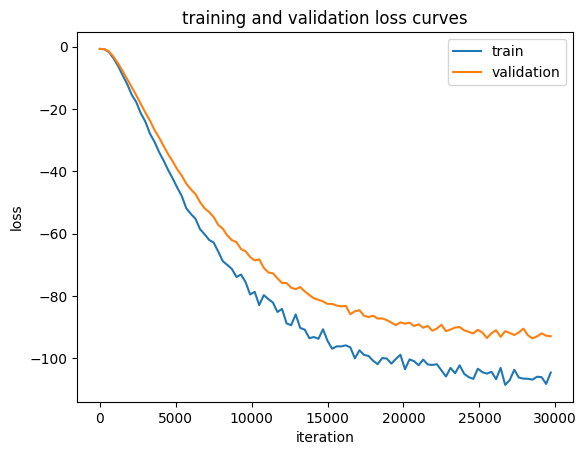

[test_loss: -87.6216, test_recall@10: 0.08694, test_precision@10: 0.05884, test_ndcg@10: 0.09062


In [37]:
data_frame = ["userId", "movieId", "rating"]
path = [rating_path, item_path]
embed_size = 16
n_epochs = 30000
user_id = 3
excluded_user = 1
K = 15


lib_titles, lib_genres = libco(data_frame, path,embed_size, n_epochs, excluded_user)
blog_titles, blog_genres = blog(data_frame, path, embed_size, n_epochs, excluded_user)

### 예측 결과

In [38]:
#-- 라이브러리 LightGCN
for i in range(K):
      print(f"title: {lib_titles[i].values}, genres: {lib_genres[i].values} ")
print("==========================LIB LightGCN=============================")

#-- BLOG LightGCN
for i in range(K):
      print(f"title: {blog_titles[i]}, genres: {blog_genres[i]} ")
print("==========================BLOG LightGCN=============================")

title: ['King Kong (1933)'], genres: ['Action|Adventure|Fantasy|Horror'] 
title: ['20,000 Leagues Under the Sea (1916)'], genres: ['Action|Adventure|Sci-Fi'] 
title: ['Color Purple, The (1985)'], genres: ['Drama'] 
title: ["All the President's Men (1976)"], genres: ['Drama|Thriller'] 
title: ['Fly Away Home (1996)'], genres: ['Adventure|Children'] 
title: ['Swiss Family Robinson (1960)'], genres: ['Adventure|Children'] 
title: ['20,000 Leagues Under the Sea (1954)'], genres: ['Adventure|Drama|Sci-Fi'] 
title: ['Olympus Has Fallen (2013)'], genres: ['Action|Thriller'] 
title: ['Bedknobs and Broomsticks (1971)'], genres: ['Adventure|Children|Musical'] 
title: ['I Am Number Four (2011)'], genres: ['Action|Sci-Fi|Thriller|IMAX'] 
title: ['Madness of King George, The (1994)'], genres: ['Comedy|Drama'] 
title: ['Dances with Wolves (1990)'], genres: ['Adventure|Drama|Western'] 
title: ['Bodyguard, The (1992)'], genres: ['Drama|Romance|Thriller'] 
title: ['Aristocats, The (1970)'], genres: ['A

In [39]:
#-- 내가 삭제한 데이터
data = pd.read_csv(path[0])
user_data = data[data[data_frame[0]] == excluded_user]
user_data_5stars = user_data[user_data[data_frame[2]] == 5.0]  # Filter the data with a rating of 5.0r_user_data[r_user_data[data_frame[2]] == 5.0]  # Filter the data with a rating of 5.0
# print(user_data_5stars.head(10))
data = user_data_5stars.head(15)
moviedIds = data['movieId'].values

df = pd.read_csv(path[1])

titles = []
genres = []
for i in moviedIds:
    title = df[df['movieId'] == i]['title']
    genre = df[df['movieId'] == i]['genres']
    titles.append(title)
    genres.append(genre)
for i in range(len(moviedIds)):
  print(f"title: {titles[i].values}, genres: {genres[i].values} ")

title: ['Seven (a.k.a. Se7en) (1995)'], genres: ['Mystery|Thriller'] 
title: ['Usual Suspects, The (1995)'], genres: ['Crime|Mystery|Thriller'] 
title: ['Bottle Rocket (1996)'], genres: ['Adventure|Comedy|Crime|Romance'] 
title: ['Rob Roy (1995)'], genres: ['Action|Drama|Romance|War'] 
title: ['Canadian Bacon (1995)'], genres: ['Comedy|War'] 
title: ['Desperado (1995)'], genres: ['Action|Romance|Western'] 
title: ['Billy Madison (1995)'], genres: ['Comedy'] 
title: ['Dumb & Dumber (Dumb and Dumber) (1994)'], genres: ['Adventure|Comedy'] 
title: ['Star Wars: Episode IV - A New Hope (1977)'], genres: ['Action|Adventure|Sci-Fi'] 
title: ['Tommy Boy (1995)'], genres: ['Comedy'] 
title: ['Jungle Book, The (1994)'], genres: ['Adventure|Children|Romance'] 
title: ['Fugitive, The (1993)'], genres: ['Thriller'] 
title: ["Schindler's List (1993)"], genres: ['Drama|War'] 
title: ['Tombstone (1993)'], genres: ['Action|Drama|Western'] 
title: ['Pinocchio (1940)'], genres: ['Animation|Children|Fanta